<a href="https://colab.research.google.com/github/KusalG05/Stock-Prophets/blob/main/StockMarketv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Idea
Model predicts upcoming closing prices using previous closing prices

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.nn import functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc
import warnings
import os
warnings.filterwarnings('ignore')
from torch.optim import Adam
import random
from collections import Counter
import copy
import pandas as pd

In [2]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

In [3]:
!pip install yfinance

In [4]:
import yfinance as yf

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


##Downloading data

In [6]:
# maersk = yf.Ticker('^NSEI')
comp = [yf.Ticker('GOOG'), yf.Ticker('AAPL'), yf.Ticker('^NSEI'), yf.Ticker('^GSPC')]
history = [i.history(period='max', interval='1d') for i in comp]
data = {'GOOG': history[0], 'AAPL': history[1], '^NSEI': history[2], '^GSPC': history[3]}

In [7]:
!pip install keras

##Data Preprocessing


In [8]:
# We can add more features here
from keras.preprocessing.sequence import TimeseriesGenerator
def generate_series(data, value_num):
    close = data['Close']
    dividends = data['Dividends']

    tsg = TimeseriesGenerator(close, close,length=value_num,batch_size=len(close))
    tsg1 = TimeseriesGenerator(dividends, dividends,length=value_num,batch_size=len(dividends))
    i, t = tsg[0]
    i1, t1 = tsg1[0]
    comp = [i]
    ans = [[[*k] for k in zip(*sublists)] for sublists in zip(*comp)]
    return np.array(ans), t

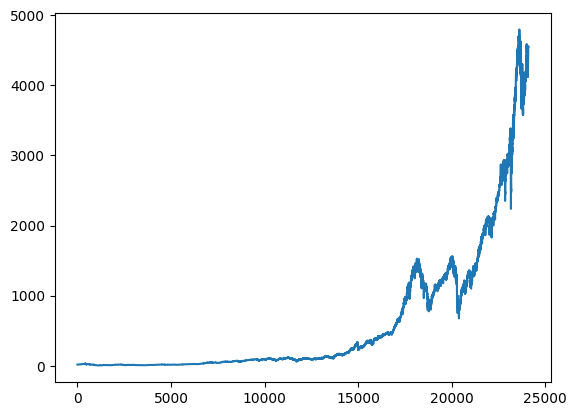

In [9]:
comp_name = '^GSPC' # company for which stocks to be predicted
X, Y = generate_series(data[comp_name], 100)
his1 = data[comp_name].reset_index()['Close']
plt.plot(his1) # plotting the entire data we have(train, validation, test)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = [MinMaxScaler(feature_range=(0, 1)) for _ in range(X.shape[2])]
X = [scaler[i].fit_transform(X[:,:,i]) for i in range(X.shape[2])]
Y = scaler[0].fit_transform(Y.reshape((-1,1)))
X = torch.tensor([[[*k] for k in zip(*sublists)] for sublists in zip(*X)])
X = torch.tensor(X, dtype = torch.float)
Y = torch.tensor(Y, dtype = torch.float)

In [11]:
def split_data(X, Y, p):
    lookback = int(p*len(X))
    X_test = X[-1*lookback:]
    Y_test = Y[-1*lookback:]
    X_val = X[-2*lookback:-1*lookback]
    Y_val = Y[-2*lookback:-1*lookback]
    X_train = X[:-2*lookback]
    Y_train = Y[:-2*lookback]
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [12]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(X,Y, 0.2)

#converting data into tensor batches
from torch.utils.data import DataLoader, TensorDataset

vectorized_train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(vectorized_train_dataset, batch_size=128, shuffle=True)

vectorized_val_dataset = TensorDataset(X_val, Y_val)
val_loader = DataLoader(vectorized_val_dataset, batch_size=128, shuffle=False)

## LSTM Model

In [13]:
from torch import nn
from torch.nn import functional as F

class StockPredictor(nn.Module):
    def __init__(self,input_dim, n_layers, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, num_layers = n_layers, batch_first = True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(p = 0.3)
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

    def forward(self, X_batch):
        hidden, carry = torch.randn(self.n_layers, len(X_batch), self.hidden_dim).to(device), torch.randn(self.n_layers, len(X_batch), self.hidden_dim).to(device)
        output, (hidden, carry) = self.lstm(X_batch)
        return self.linear(self.dropout(output[:,-1, :]))

## Training models like LSTM's, GRU's

In [18]:
def train(model, loss_fn, optimizer, train_loader, val_loader, epochs=10): # training the model using validation and train data
  set_seed(42)
  best_checkpoint = None
  val_prev_loss = 10000000.0
  avg_losses = []

  for i in range(1, epochs+1):
    losses = []
    print("Current epoch: ", i)
    model.train()
    ## Training step
    for X, Y in tqdm(train_loader):
        Y_preds = model(X.to(device))
        loss = loss_fn(Y_preds, Y.to(device))
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_losses.append(torch.tensor(losses).mean().item())
    print("Training Loss:", torch.tensor(losses).mean().item())
    ## Validation step
    val_losses = []
    model.eval()
    with torch.no_grad():
        for X, Y in tqdm(val_loader):
            Y_preds = model(X.to(device))
            loss = loss_fn(Y_preds, Y.to(device))
            val_losses.append(loss.item())
    print("Validation Loss:",torch.tensor(val_losses).mean().item())
    ## Selecting best model
    if torch.tensor(val_losses).mean().item() < val_prev_loss:
        print("checkpointing current model")
        best_checkpoint = copy.deepcopy(model)
        val_prev_loss = torch.tensor(val_losses).mean().item()
  return best_checkpoint, val_prev_loss, model, avg_losses

In [20]:
from torch.optim import Adam

l_epochs = [50,100,150]
learning_rate = 5e-3
hidden_dim = 32
num_layers=[1,2,3]
input_dim = X_train.shape[2]

best_loss = 10000000.0
best_checkpoint = 0
avg_losses = [0]
loss_fn = nn.MSELoss().to(device)
for n_layers in num_layers:
  for epochs in l_epochs:
## training using validation and train data
    print("Epochs:", epochs, "Number of lstm layers:", n_layers)
    model = StockPredictor(input_dim, n_layers, hidden_dim).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    best_chck, best_l, last_checkpoint, avg_l = train(model, loss_fn, optimizer, train_loader, val_loader, epochs)
    if(best_l < best_loss):
      print("Saving best checkpoint for epochs:", epochs, "layers:", n_layers)
      best_loss = best_l
      best_checkpoint = best_chck
      avg_losses = avg_l

Epochs: 50 Number of lstm layers: 1
Current epoch:  1


100%|██████████| 113/113 [00:00<00:00, 211.13it/s]


Training Loss: 0.0008312397985719144


100%|██████████| 38/38 [00:00<00:00, 471.23it/s]


Validation Loss: 0.019501835107803345
checkpointing current model
Current epoch:  2


100%|██████████| 113/113 [00:00<00:00, 304.25it/s]


Training Loss: 0.0001525951229268685


100%|██████████| 38/38 [00:00<00:00, 561.31it/s]


Validation Loss: 0.011625846847891808
checkpointing current model
Current epoch:  3


100%|██████████| 113/113 [00:00<00:00, 296.43it/s]


Training Loss: 4.8952049837680534e-05


100%|██████████| 38/38 [00:00<00:00, 568.88it/s]


Validation Loss: 0.0034988110419362783
checkpointing current model
Current epoch:  4


100%|██████████| 113/113 [00:00<00:00, 303.28it/s]


Training Loss: 1.3294958989717998e-05


100%|██████████| 38/38 [00:00<00:00, 559.32it/s]


Validation Loss: 0.0025216585490852594
checkpointing current model
Current epoch:  5


100%|██████████| 113/113 [00:00<00:00, 293.03it/s]


Training Loss: 5.182014319871087e-06


100%|██████████| 38/38 [00:00<00:00, 582.11it/s]


Validation Loss: 0.002159079536795616
checkpointing current model
Current epoch:  6


100%|██████████| 113/113 [00:00<00:00, 280.93it/s]


Training Loss: 3.075970880672685e-06


100%|██████████| 38/38 [00:00<00:00, 578.43it/s]


Validation Loss: 0.0020454120822250843
checkpointing current model
Current epoch:  7


100%|██████████| 113/113 [00:00<00:00, 296.84it/s]


Training Loss: 2.5379599719599355e-06


100%|██████████| 38/38 [00:00<00:00, 556.28it/s]


Validation Loss: 0.001963577466085553
checkpointing current model
Current epoch:  8


100%|██████████| 113/113 [00:00<00:00, 296.76it/s]


Training Loss: 2.5700387595861685e-06


100%|██████████| 38/38 [00:00<00:00, 560.44it/s]


Validation Loss: 0.0019426532089710236
checkpointing current model
Current epoch:  9


100%|██████████| 113/113 [00:00<00:00, 285.97it/s]


Training Loss: 2.278228294017026e-06


100%|██████████| 38/38 [00:00<00:00, 553.59it/s]


Validation Loss: 0.0019959842320531607
Current epoch:  10


100%|██████████| 113/113 [00:00<00:00, 306.68it/s]


Training Loss: 2.1546172774833394e-06


100%|██████████| 38/38 [00:00<00:00, 565.15it/s]


Validation Loss: 0.0020759745966643095
Current epoch:  11


100%|██████████| 113/113 [00:00<00:00, 287.49it/s]


Training Loss: 2.3250895537785254e-06


100%|██████████| 38/38 [00:00<00:00, 565.35it/s]


Validation Loss: 0.001993172336369753
Current epoch:  12


100%|██████████| 113/113 [00:00<00:00, 308.73it/s]


Training Loss: 2.3141992642194964e-06


100%|██████████| 38/38 [00:00<00:00, 535.13it/s]


Validation Loss: 0.0020273439586162567
Current epoch:  13


100%|██████████| 113/113 [00:00<00:00, 303.99it/s]


Training Loss: 2.405321083642775e-06


100%|██████████| 38/38 [00:00<00:00, 504.94it/s]


Validation Loss: 0.001997917192056775
Current epoch:  14


100%|██████████| 113/113 [00:00<00:00, 313.59it/s]


Training Loss: 2.067204150080215e-06


100%|██████████| 38/38 [00:00<00:00, 580.33it/s]


Validation Loss: 0.0019571222364902496
Current epoch:  15


100%|██████████| 113/113 [00:00<00:00, 301.39it/s]


Training Loss: 2.180824139941251e-06


100%|██████████| 38/38 [00:00<00:00, 493.76it/s]


Validation Loss: 0.001987076597288251
Current epoch:  16


100%|██████████| 113/113 [00:00<00:00, 294.02it/s]


Training Loss: 1.8995846176039777e-06


100%|██████████| 38/38 [00:00<00:00, 560.10it/s]


Validation Loss: 0.0019566412083804607
Current epoch:  17


100%|██████████| 113/113 [00:00<00:00, 304.76it/s]


Training Loss: 1.8176500589106581e-06


100%|██████████| 38/38 [00:00<00:00, 576.01it/s]


Validation Loss: 0.0019328627968207002
checkpointing current model
Current epoch:  18


100%|██████████| 113/113 [00:00<00:00, 291.18it/s]


Training Loss: 1.8405996797810076e-06


100%|██████████| 38/38 [00:00<00:00, 576.31it/s]


Validation Loss: 0.0019520990317687392
Current epoch:  19


100%|██████████| 113/113 [00:00<00:00, 304.06it/s]


Training Loss: 1.948590579559095e-06


100%|██████████| 38/38 [00:00<00:00, 571.22it/s]


Validation Loss: 0.001921834540553391
checkpointing current model
Current epoch:  20


100%|██████████| 113/113 [00:00<00:00, 306.10it/s]


Training Loss: 1.943893494171789e-06


100%|██████████| 38/38 [00:00<00:00, 554.89it/s]


Validation Loss: 0.0018831798806786537
checkpointing current model
Current epoch:  21


100%|██████████| 113/113 [00:00<00:00, 301.45it/s]


Training Loss: 2.279814907524269e-06


100%|██████████| 38/38 [00:00<00:00, 577.67it/s]


Validation Loss: 0.0018526449566707015
checkpointing current model
Current epoch:  22


100%|██████████| 113/113 [00:00<00:00, 298.20it/s]


Training Loss: 2.1992946130922064e-06


100%|██████████| 38/38 [00:00<00:00, 592.31it/s]


Validation Loss: 0.00175965775270015
checkpointing current model
Current epoch:  23


100%|██████████| 113/113 [00:00<00:00, 244.49it/s]


Training Loss: 1.930443886521971e-06


100%|██████████| 38/38 [00:00<00:00, 379.34it/s]


Validation Loss: 0.00171662459615618
checkpointing current model
Current epoch:  24


100%|██████████| 113/113 [00:00<00:00, 210.48it/s]


Training Loss: 1.967129492186359e-06


100%|██████████| 38/38 [00:00<00:00, 347.18it/s]


Validation Loss: 0.0017465453129261732
Current epoch:  25


100%|██████████| 113/113 [00:00<00:00, 209.54it/s]


Training Loss: 1.919712303788401e-06


100%|██████████| 38/38 [00:00<00:00, 386.08it/s]


Validation Loss: 0.0017434238689020276
Current epoch:  26


100%|██████████| 113/113 [00:00<00:00, 200.20it/s]


Training Loss: 1.8682807194636553e-06


100%|██████████| 38/38 [00:00<00:00, 337.93it/s]


Validation Loss: 0.001751672476530075
Current epoch:  27


100%|██████████| 113/113 [00:00<00:00, 204.52it/s]


Training Loss: 1.923019453897723e-06


100%|██████████| 38/38 [00:00<00:00, 318.98it/s]


Validation Loss: 0.0017493690829724073
Current epoch:  28


100%|██████████| 113/113 [00:00<00:00, 202.06it/s]


Training Loss: 1.781393166311318e-06


100%|██████████| 38/38 [00:00<00:00, 392.38it/s]


Validation Loss: 0.001666174503043294
checkpointing current model
Current epoch:  29


100%|██████████| 113/113 [00:00<00:00, 283.42it/s]


Training Loss: 1.8541185227149981e-06


100%|██████████| 38/38 [00:00<00:00, 516.77it/s]


Validation Loss: 0.0016489956760779023
checkpointing current model
Current epoch:  30


100%|██████████| 113/113 [00:00<00:00, 301.47it/s]


Training Loss: 1.7741477904564817e-06


100%|██████████| 38/38 [00:00<00:00, 591.62it/s]


Validation Loss: 0.0016634423518553376
Current epoch:  31


100%|██████████| 113/113 [00:00<00:00, 297.37it/s]


Training Loss: 1.8593399317978765e-06


100%|██████████| 38/38 [00:00<00:00, 563.37it/s]


Validation Loss: 0.0015779708046466112
checkpointing current model
Current epoch:  32


100%|██████████| 113/113 [00:00<00:00, 296.40it/s]


Training Loss: 2.100411393257673e-06


100%|██████████| 38/38 [00:00<00:00, 572.47it/s]


Validation Loss: 0.0015017244732007384
checkpointing current model
Current epoch:  33


100%|██████████| 113/113 [00:00<00:00, 290.33it/s]


Training Loss: 1.8611734731166507e-06


100%|██████████| 38/38 [00:00<00:00, 574.59it/s]


Validation Loss: 0.0015301024541258812
Current epoch:  34


100%|██████████| 113/113 [00:00<00:00, 311.90it/s]


Training Loss: 2.0932404822815442e-06


100%|██████████| 38/38 [00:00<00:00, 527.21it/s]


Validation Loss: 0.0014880397357046604
checkpointing current model
Current epoch:  35


100%|██████████| 113/113 [00:00<00:00, 296.10it/s]


Training Loss: 1.6770522961451206e-06


100%|██████████| 38/38 [00:00<00:00, 573.67it/s]


Validation Loss: 0.001502163358964026
Current epoch:  36


100%|██████████| 113/113 [00:00<00:00, 294.92it/s]


Training Loss: 2.100355459333514e-06


100%|██████████| 38/38 [00:00<00:00, 571.72it/s]


Validation Loss: 0.0013574259355664253
checkpointing current model
Current epoch:  37


100%|██████████| 113/113 [00:00<00:00, 298.50it/s]


Training Loss: 2.291292048539617e-06


100%|██████████| 38/38 [00:00<00:00, 577.00it/s]


Validation Loss: 0.001350605278275907
checkpointing current model
Current epoch:  38


100%|██████████| 113/113 [00:00<00:00, 298.30it/s]


Training Loss: 1.9559126940293936e-06


100%|██████████| 38/38 [00:00<00:00, 580.29it/s]


Validation Loss: 0.0013120588846504688
checkpointing current model
Current epoch:  39


100%|██████████| 113/113 [00:00<00:00, 297.61it/s]


Training Loss: 1.8342873318033526e-06


100%|██████████| 38/38 [00:00<00:00, 513.75it/s]


Validation Loss: 0.0012480352306738496
checkpointing current model
Current epoch:  40


100%|██████████| 113/113 [00:00<00:00, 304.72it/s]


Training Loss: 1.7504670495327446e-06


100%|██████████| 38/38 [00:00<00:00, 547.92it/s]


Validation Loss: 0.0012245551915839314
checkpointing current model
Current epoch:  41


100%|██████████| 113/113 [00:00<00:00, 304.26it/s]


Training Loss: 2.0012214463349665e-06


100%|██████████| 38/38 [00:00<00:00, 577.94it/s]


Validation Loss: 0.0012172941351309419
checkpointing current model
Current epoch:  42


100%|██████████| 113/113 [00:00<00:00, 300.21it/s]


Training Loss: 1.8147848095395602e-06


100%|██████████| 38/38 [00:00<00:00, 587.43it/s]


Validation Loss: 0.0012435754761099815
Current epoch:  43


100%|██████████| 113/113 [00:00<00:00, 308.16it/s]


Training Loss: 1.7574679986864794e-06


100%|██████████| 38/38 [00:00<00:00, 591.07it/s]


Validation Loss: 0.001187720918096602
checkpointing current model
Current epoch:  44


100%|██████████| 113/113 [00:00<00:00, 299.77it/s]


Training Loss: 1.8000989712163573e-06


100%|██████████| 38/38 [00:00<00:00, 565.85it/s]


Validation Loss: 0.0012124618515372276
Current epoch:  45


100%|██████████| 113/113 [00:00<00:00, 299.57it/s]


Training Loss: 1.9662688828248065e-06


100%|██████████| 38/38 [00:00<00:00, 555.14it/s]


Validation Loss: 0.001061717513948679
checkpointing current model
Current epoch:  46


100%|██████████| 113/113 [00:00<00:00, 299.25it/s]


Training Loss: 1.832093289522163e-06


100%|██████████| 38/38 [00:00<00:00, 542.24it/s]


Validation Loss: 0.0009587915847077966
checkpointing current model
Current epoch:  47


100%|██████████| 113/113 [00:00<00:00, 303.98it/s]


Training Loss: 1.6865006955413264e-06


100%|██████████| 38/38 [00:00<00:00, 526.05it/s]


Validation Loss: 0.000969826418440789
Current epoch:  48


100%|██████████| 113/113 [00:00<00:00, 298.22it/s]


Training Loss: 1.8331785440750537e-06


100%|██████████| 38/38 [00:00<00:00, 557.73it/s]


Validation Loss: 0.0009969865204766393
Current epoch:  49


100%|██████████| 113/113 [00:00<00:00, 291.55it/s]


Training Loss: 1.783793209142459e-06


100%|██████████| 38/38 [00:00<00:00, 468.75it/s]


Validation Loss: 0.0009207040420733392
checkpointing current model
Current epoch:  50


100%|██████████| 113/113 [00:00<00:00, 232.04it/s]


Training Loss: 1.7560099649926997e-06


100%|██████████| 38/38 [00:00<00:00, 388.53it/s]


Validation Loss: 0.0008617238490842283
checkpointing current model
Saving best checkpoint for epochs: 50 layers: 1
Epochs: 100 Number of lstm layers: 1
Current epoch:  1


100%|██████████| 113/113 [00:00<00:00, 207.16it/s]


Training Loss: 0.0008312397985719144


100%|██████████| 38/38 [00:00<00:00, 335.99it/s]


Validation Loss: 0.019501835107803345
checkpointing current model
Current epoch:  2


100%|██████████| 113/113 [00:00<00:00, 202.47it/s]


Training Loss: 0.0001525951229268685


100%|██████████| 38/38 [00:00<00:00, 396.33it/s]


Validation Loss: 0.011625846847891808
checkpointing current model
Current epoch:  3


100%|██████████| 113/113 [00:00<00:00, 206.27it/s]


Training Loss: 4.8952049837680534e-05


100%|██████████| 38/38 [00:00<00:00, 367.07it/s]


Validation Loss: 0.0034988110419362783
checkpointing current model
Current epoch:  4


100%|██████████| 113/113 [00:00<00:00, 212.50it/s]


Training Loss: 1.3294958989717998e-05


100%|██████████| 38/38 [00:00<00:00, 402.11it/s]


Validation Loss: 0.0025216585490852594
checkpointing current model
Current epoch:  5


100%|██████████| 113/113 [00:00<00:00, 207.95it/s]


Training Loss: 5.182014319871087e-06


100%|██████████| 38/38 [00:00<00:00, 301.86it/s]


Validation Loss: 0.002159079536795616
checkpointing current model
Current epoch:  6


100%|██████████| 113/113 [00:00<00:00, 289.69it/s]


Training Loss: 3.075970880672685e-06


100%|██████████| 38/38 [00:00<00:00, 531.73it/s]


Validation Loss: 0.0020454120822250843
checkpointing current model
Current epoch:  7


100%|██████████| 113/113 [00:00<00:00, 292.05it/s]


Training Loss: 2.5379599719599355e-06


100%|██████████| 38/38 [00:00<00:00, 567.51it/s]


Validation Loss: 0.001963577466085553
checkpointing current model
Current epoch:  8


100%|██████████| 113/113 [00:00<00:00, 294.53it/s]


Training Loss: 2.5700387595861685e-06


100%|██████████| 38/38 [00:00<00:00, 558.48it/s]


Validation Loss: 0.0019426532089710236
checkpointing current model
Current epoch:  9


100%|██████████| 113/113 [00:00<00:00, 289.21it/s]


Training Loss: 2.278228294017026e-06


100%|██████████| 38/38 [00:00<00:00, 559.72it/s]


Validation Loss: 0.0019959842320531607
Current epoch:  10


100%|██████████| 113/113 [00:00<00:00, 295.17it/s]


Training Loss: 2.1546172774833394e-06


100%|██████████| 38/38 [00:00<00:00, 596.50it/s]


Validation Loss: 0.0020759745966643095
Current epoch:  11


100%|██████████| 113/113 [00:00<00:00, 299.58it/s]


Training Loss: 2.3250895537785254e-06


100%|██████████| 38/38 [00:00<00:00, 536.15it/s]


Validation Loss: 0.001993172336369753
Current epoch:  12


100%|██████████| 113/113 [00:00<00:00, 298.53it/s]


Training Loss: 2.3141992642194964e-06


100%|██████████| 38/38 [00:00<00:00, 539.23it/s]


Validation Loss: 0.0020273439586162567
Current epoch:  13


100%|██████████| 113/113 [00:00<00:00, 288.14it/s]


Training Loss: 2.405321083642775e-06


100%|██████████| 38/38 [00:00<00:00, 559.11it/s]


Validation Loss: 0.001997917192056775
Current epoch:  14


100%|██████████| 113/113 [00:00<00:00, 288.05it/s]


Training Loss: 2.067204150080215e-06


100%|██████████| 38/38 [00:00<00:00, 582.61it/s]


Validation Loss: 0.0019571222364902496
Current epoch:  15


100%|██████████| 113/113 [00:00<00:00, 282.14it/s]


Training Loss: 2.180824139941251e-06


100%|██████████| 38/38 [00:00<00:00, 539.32it/s]


Validation Loss: 0.001987076597288251
Current epoch:  16


100%|██████████| 113/113 [00:00<00:00, 293.68it/s]


Training Loss: 1.8995846176039777e-06


100%|██████████| 38/38 [00:00<00:00, 568.52it/s]


Validation Loss: 0.0019566412083804607
Current epoch:  17


100%|██████████| 113/113 [00:00<00:00, 294.21it/s]


Training Loss: 1.8176500589106581e-06


100%|██████████| 38/38 [00:00<00:00, 476.38it/s]


Validation Loss: 0.0019328627968207002
checkpointing current model
Current epoch:  18


100%|██████████| 113/113 [00:00<00:00, 292.20it/s]


Training Loss: 1.8405996797810076e-06


100%|██████████| 38/38 [00:00<00:00, 555.83it/s]


Validation Loss: 0.0019520990317687392
Current epoch:  19


100%|██████████| 113/113 [00:00<00:00, 289.42it/s]


Training Loss: 1.948590579559095e-06


100%|██████████| 38/38 [00:00<00:00, 496.46it/s]


Validation Loss: 0.001921834540553391
checkpointing current model
Current epoch:  20


100%|██████████| 113/113 [00:00<00:00, 276.53it/s]


Training Loss: 1.943893494171789e-06


100%|██████████| 38/38 [00:00<00:00, 549.73it/s]


Validation Loss: 0.0018831798806786537
checkpointing current model
Current epoch:  21


100%|██████████| 113/113 [00:00<00:00, 293.16it/s]


Training Loss: 2.279814907524269e-06


100%|██████████| 38/38 [00:00<00:00, 568.38it/s]


Validation Loss: 0.0018526449566707015
checkpointing current model
Current epoch:  22


100%|██████████| 113/113 [00:00<00:00, 282.40it/s]


Training Loss: 2.1992946130922064e-06


100%|██████████| 38/38 [00:00<00:00, 551.28it/s]


Validation Loss: 0.00175965775270015
checkpointing current model
Current epoch:  23


100%|██████████| 113/113 [00:00<00:00, 289.66it/s]


Training Loss: 1.930443886521971e-06


100%|██████████| 38/38 [00:00<00:00, 552.63it/s]


Validation Loss: 0.00171662459615618
checkpointing current model
Current epoch:  24


100%|██████████| 113/113 [00:00<00:00, 289.90it/s]


Training Loss: 1.967129492186359e-06


100%|██████████| 38/38 [00:00<00:00, 558.23it/s]


Validation Loss: 0.0017465453129261732
Current epoch:  25


100%|██████████| 113/113 [00:00<00:00, 297.65it/s]


Training Loss: 1.919712303788401e-06


100%|██████████| 38/38 [00:00<00:00, 521.34it/s]


Validation Loss: 0.0017434238689020276
Current epoch:  26


100%|██████████| 113/113 [00:00<00:00, 283.84it/s]


Training Loss: 1.8682807194636553e-06


100%|██████████| 38/38 [00:00<00:00, 380.96it/s]


Validation Loss: 0.001751672476530075
Current epoch:  27


100%|██████████| 113/113 [00:00<00:00, 214.09it/s]


Training Loss: 1.923019453897723e-06


100%|██████████| 38/38 [00:00<00:00, 356.92it/s]


Validation Loss: 0.0017493690829724073
Current epoch:  28


100%|██████████| 113/113 [00:00<00:00, 200.81it/s]


Training Loss: 1.781393166311318e-06


100%|██████████| 38/38 [00:00<00:00, 149.14it/s]


Validation Loss: 0.001666174503043294
checkpointing current model
Current epoch:  29


100%|██████████| 113/113 [00:01<00:00, 80.50it/s]


Training Loss: 1.8541185227149981e-06


100%|██████████| 38/38 [00:00<00:00, 120.20it/s]


Validation Loss: 0.0016489956760779023
checkpointing current model
Current epoch:  30


100%|██████████| 113/113 [00:01<00:00, 97.65it/s] 


Training Loss: 1.7741477904564817e-06


100%|██████████| 38/38 [00:00<00:00, 325.85it/s]


Validation Loss: 0.0016634423518553376
Current epoch:  31


100%|██████████| 113/113 [00:00<00:00, 188.96it/s]


Training Loss: 1.8593399317978765e-06


100%|██████████| 38/38 [00:00<00:00, 307.75it/s]


Validation Loss: 0.0015779708046466112
checkpointing current model
Current epoch:  32


100%|██████████| 113/113 [00:00<00:00, 116.51it/s]


Training Loss: 2.100411393257673e-06


100%|██████████| 38/38 [00:00<00:00, 317.74it/s]


Validation Loss: 0.0015017244732007384
checkpointing current model
Current epoch:  33


100%|██████████| 113/113 [00:00<00:00, 140.74it/s]


Training Loss: 1.8611734731166507e-06


100%|██████████| 38/38 [00:00<00:00, 326.10it/s]


Validation Loss: 0.0015301024541258812
Current epoch:  34


100%|██████████| 113/113 [00:00<00:00, 123.87it/s]


Training Loss: 2.0932404822815442e-06


100%|██████████| 38/38 [00:00<00:00, 186.44it/s]


Validation Loss: 0.0014880397357046604
checkpointing current model
Current epoch:  35


100%|██████████| 113/113 [00:00<00:00, 133.03it/s]


Training Loss: 1.6770522961451206e-06


100%|██████████| 38/38 [00:00<00:00, 151.11it/s]


Validation Loss: 0.001502163358964026
Current epoch:  36


100%|██████████| 113/113 [00:00<00:00, 129.00it/s]


Training Loss: 2.100355459333514e-06


100%|██████████| 38/38 [00:00<00:00, 299.53it/s]


Validation Loss: 0.0013574259355664253
checkpointing current model
Current epoch:  37


100%|██████████| 113/113 [00:00<00:00, 136.09it/s]


Training Loss: 2.291292048539617e-06


100%|██████████| 38/38 [00:00<00:00, 343.56it/s]


Validation Loss: 0.001350605278275907
checkpointing current model
Current epoch:  38


100%|██████████| 113/113 [00:00<00:00, 178.10it/s]


Training Loss: 1.9559126940293936e-06


100%|██████████| 38/38 [00:00<00:00, 211.97it/s]


Validation Loss: 0.0013120588846504688
checkpointing current model
Current epoch:  39


100%|██████████| 113/113 [00:00<00:00, 128.86it/s]


Training Loss: 1.8342873318033526e-06


100%|██████████| 38/38 [00:00<00:00, 186.65it/s]


Validation Loss: 0.0012480352306738496
checkpointing current model
Current epoch:  40


100%|██████████| 113/113 [00:00<00:00, 199.86it/s]


Training Loss: 1.7504670495327446e-06


100%|██████████| 38/38 [00:00<00:00, 389.90it/s]


Validation Loss: 0.0012245551915839314
checkpointing current model
Current epoch:  41


100%|██████████| 113/113 [00:00<00:00, 216.59it/s]


Training Loss: 2.0012214463349665e-06


100%|██████████| 38/38 [00:00<00:00, 386.44it/s]


Validation Loss: 0.0012172941351309419
checkpointing current model
Current epoch:  42


100%|██████████| 113/113 [00:00<00:00, 204.41it/s]


Training Loss: 1.8147848095395602e-06


100%|██████████| 38/38 [00:00<00:00, 352.23it/s]


Validation Loss: 0.0012435754761099815
Current epoch:  43


100%|██████████| 113/113 [00:00<00:00, 220.79it/s]


Training Loss: 1.7574679986864794e-06


100%|██████████| 38/38 [00:00<00:00, 322.40it/s]


Validation Loss: 0.001187720918096602
checkpointing current model
Current epoch:  44


100%|██████████| 113/113 [00:00<00:00, 211.22it/s]


Training Loss: 1.8000989712163573e-06


100%|██████████| 38/38 [00:00<00:00, 393.31it/s]


Validation Loss: 0.0012124618515372276
Current epoch:  45


100%|██████████| 113/113 [00:00<00:00, 213.58it/s]


Training Loss: 1.9662688828248065e-06


100%|██████████| 38/38 [00:00<00:00, 309.51it/s]


Validation Loss: 0.001061717513948679
checkpointing current model
Current epoch:  46


100%|██████████| 113/113 [00:00<00:00, 202.63it/s]


Training Loss: 1.832093289522163e-06


100%|██████████| 38/38 [00:00<00:00, 348.28it/s]


Validation Loss: 0.0009587915847077966
checkpointing current model
Current epoch:  47


100%|██████████| 113/113 [00:00<00:00, 285.58it/s]


Training Loss: 1.6865006955413264e-06


100%|██████████| 38/38 [00:00<00:00, 550.19it/s]


Validation Loss: 0.000969826418440789
Current epoch:  48


100%|██████████| 113/113 [00:00<00:00, 287.07it/s]


Training Loss: 1.8331785440750537e-06


100%|██████████| 38/38 [00:00<00:00, 473.42it/s]


Validation Loss: 0.0009969865204766393
Current epoch:  49


100%|██████████| 113/113 [00:00<00:00, 290.29it/s]


Training Loss: 1.783793209142459e-06


100%|██████████| 38/38 [00:00<00:00, 555.79it/s]


Validation Loss: 0.0009207040420733392
checkpointing current model
Current epoch:  50


100%|██████████| 113/113 [00:00<00:00, 296.52it/s]


Training Loss: 1.7560099649926997e-06


100%|██████████| 38/38 [00:00<00:00, 501.50it/s]


Validation Loss: 0.0008617238490842283
checkpointing current model
Current epoch:  51


100%|██████████| 113/113 [00:00<00:00, 272.71it/s]


Training Loss: 1.7042117406163015e-06


100%|██████████| 38/38 [00:00<00:00, 533.44it/s]


Validation Loss: 0.0008543510339222848
checkpointing current model
Current epoch:  52


100%|██████████| 113/113 [00:00<00:00, 296.11it/s]


Training Loss: 1.9648841771413572e-06


100%|██████████| 38/38 [00:00<00:00, 530.52it/s]


Validation Loss: 0.0008821424562484026
Current epoch:  53


100%|██████████| 113/113 [00:00<00:00, 271.86it/s]


Training Loss: 2.041979314526543e-06


100%|██████████| 38/38 [00:00<00:00, 244.27it/s]


Validation Loss: 0.0007376905414275825
checkpointing current model
Current epoch:  54


100%|██████████| 113/113 [00:00<00:00, 179.35it/s]


Training Loss: 2.053910520771751e-06


100%|██████████| 38/38 [00:00<00:00, 351.43it/s]


Validation Loss: 0.000732292071916163
checkpointing current model
Current epoch:  55


100%|██████████| 113/113 [00:00<00:00, 172.36it/s]


Training Loss: 1.7030046137733734e-06


100%|██████████| 38/38 [00:00<00:00, 348.07it/s]


Validation Loss: 0.0005440836539492011
checkpointing current model
Current epoch:  56


100%|██████████| 113/113 [00:00<00:00, 265.07it/s]


Training Loss: 2.0014431356685236e-06


100%|██████████| 38/38 [00:00<00:00, 488.88it/s]


Validation Loss: 0.0007181499968282878
Current epoch:  57


100%|██████████| 113/113 [00:00<00:00, 295.12it/s]


Training Loss: 1.8365972209721804e-06


100%|██████████| 38/38 [00:00<00:00, 541.20it/s]


Validation Loss: 0.0004468263650778681
checkpointing current model
Current epoch:  58


100%|██████████| 113/113 [00:00<00:00, 295.84it/s]


Training Loss: 1.7457981584811932e-06


100%|██████████| 38/38 [00:00<00:00, 577.86it/s]


Validation Loss: 0.00044525344856083393
checkpointing current model
Current epoch:  59


100%|██████████| 113/113 [00:00<00:00, 300.83it/s]


Training Loss: 1.6350169289580663e-06


100%|██████████| 38/38 [00:00<00:00, 526.19it/s]


Validation Loss: 0.00045907613821327686
Current epoch:  60


100%|██████████| 113/113 [00:00<00:00, 285.62it/s]


Training Loss: 1.7662633808868122e-06


100%|██████████| 38/38 [00:00<00:00, 518.13it/s]


Validation Loss: 0.0004643231222871691
Current epoch:  61


100%|██████████| 113/113 [00:00<00:00, 275.60it/s]


Training Loss: 1.7224201656063087e-06


100%|██████████| 38/38 [00:00<00:00, 511.02it/s]


Validation Loss: 0.0005981675931252539
Current epoch:  62


100%|██████████| 113/113 [00:00<00:00, 267.07it/s]


Training Loss: 1.749225361891149e-06


100%|██████████| 38/38 [00:00<00:00, 552.11it/s]


Validation Loss: 0.0006010790239088237
Current epoch:  63


100%|██████████| 113/113 [00:00<00:00, 293.06it/s]


Training Loss: 1.8224284303869354e-06


100%|██████████| 38/38 [00:00<00:00, 552.34it/s]


Validation Loss: 0.0005321806529536843
Current epoch:  64


100%|██████████| 113/113 [00:00<00:00, 288.12it/s]


Training Loss: 1.9503168005030602e-06


100%|██████████| 38/38 [00:00<00:00, 535.32it/s]


Validation Loss: 0.00043510968680493534
checkpointing current model
Current epoch:  65


100%|██████████| 113/113 [00:00<00:00, 297.36it/s]


Training Loss: 1.6998070577756152e-06


100%|██████████| 38/38 [00:00<00:00, 464.52it/s]


Validation Loss: 0.0006281737005338073
Current epoch:  66


100%|██████████| 113/113 [00:00<00:00, 208.67it/s]


Training Loss: 1.5691933867856278e-06


100%|██████████| 38/38 [00:00<00:00, 344.08it/s]


Validation Loss: 0.000556767568923533
Current epoch:  67


100%|██████████| 113/113 [00:00<00:00, 210.25it/s]


Training Loss: 1.8572716271592071e-06


100%|██████████| 38/38 [00:00<00:00, 329.22it/s]


Validation Loss: 0.0003086900105699897
checkpointing current model
Current epoch:  68


100%|██████████| 113/113 [00:00<00:00, 208.78it/s]


Training Loss: 1.5937740727167693e-06


100%|██████████| 38/38 [00:00<00:00, 378.20it/s]


Validation Loss: 0.0003498490550555289
Current epoch:  69


100%|██████████| 113/113 [00:00<00:00, 212.44it/s]


Training Loss: 1.7129852949437918e-06


100%|██████████| 38/38 [00:00<00:00, 317.74it/s]


Validation Loss: 0.0003244131803512573
Current epoch:  70


100%|██████████| 113/113 [00:00<00:00, 210.09it/s]


Training Loss: 1.6077932514235727e-06


100%|██████████| 38/38 [00:00<00:00, 381.58it/s]


Validation Loss: 0.00031063833739608526
Current epoch:  71


100%|██████████| 113/113 [00:00<00:00, 201.05it/s]


Training Loss: 1.9644605799840065e-06


100%|██████████| 38/38 [00:00<00:00, 400.35it/s]


Validation Loss: 0.00036034415825270116
Current epoch:  72


100%|██████████| 113/113 [00:00<00:00, 289.20it/s]


Training Loss: 1.6285689525830094e-06


100%|██████████| 38/38 [00:00<00:00, 500.34it/s]


Validation Loss: 0.0003594038134906441
Current epoch:  73


100%|██████████| 113/113 [00:00<00:00, 284.35it/s]


Training Loss: 1.5425397350554704e-06


100%|██████████| 38/38 [00:00<00:00, 567.28it/s]


Validation Loss: 0.00025692451163195074
checkpointing current model
Current epoch:  74


100%|██████████| 113/113 [00:00<00:00, 294.89it/s]


Training Loss: 1.7293884866376175e-06


100%|██████████| 38/38 [00:00<00:00, 523.86it/s]


Validation Loss: 0.0003127812233287841
Current epoch:  75


100%|██████████| 113/113 [00:00<00:00, 293.66it/s]


Training Loss: 1.630544829822611e-06


100%|██████████| 38/38 [00:00<00:00, 536.93it/s]


Validation Loss: 0.00018506095511838794
checkpointing current model
Current epoch:  76


100%|██████████| 113/113 [00:00<00:00, 295.55it/s]


Training Loss: 1.8329278645978775e-06


100%|██████████| 38/38 [00:00<00:00, 528.61it/s]


Validation Loss: 0.00018606323283165693
Current epoch:  77


100%|██████████| 113/113 [00:00<00:00, 289.22it/s]


Training Loss: 1.6799892819108209e-06


100%|██████████| 38/38 [00:00<00:00, 539.42it/s]


Validation Loss: 0.00029787278617732227
Current epoch:  78


100%|██████████| 113/113 [00:00<00:00, 291.91it/s]


Training Loss: 1.8371018768448266e-06


100%|██████████| 38/38 [00:00<00:00, 488.51it/s]


Validation Loss: 0.00039567859494127333
Current epoch:  79


100%|██████████| 113/113 [00:00<00:00, 287.85it/s]


Training Loss: 1.598467747498944e-06


100%|██████████| 38/38 [00:00<00:00, 512.77it/s]


Validation Loss: 0.00016016673180274665
checkpointing current model
Current epoch:  80


100%|██████████| 113/113 [00:00<00:00, 298.09it/s]


Training Loss: 1.7221193502336973e-06


100%|██████████| 38/38 [00:00<00:00, 424.85it/s]


Validation Loss: 0.00015076827548909932
checkpointing current model
Current epoch:  81


100%|██████████| 113/113 [00:00<00:00, 287.33it/s]


Training Loss: 1.8211866290585021e-06


100%|██████████| 38/38 [00:00<00:00, 513.90it/s]


Validation Loss: 0.0002479238319210708
Current epoch:  82


100%|██████████| 113/113 [00:00<00:00, 291.81it/s]


Training Loss: 1.6720065332265222e-06


100%|██████████| 38/38 [00:00<00:00, 526.83it/s]


Validation Loss: 0.00010711846698541194
checkpointing current model
Current epoch:  83


100%|██████████| 113/113 [00:00<00:00, 303.37it/s]


Training Loss: 1.6732161611798801e-06


100%|██████████| 38/38 [00:00<00:00, 513.19it/s]


Validation Loss: 0.00014262409240473062
Current epoch:  84


100%|██████████| 113/113 [00:00<00:00, 292.49it/s]


Training Loss: 1.6976612187136197e-06


100%|██████████| 38/38 [00:00<00:00, 515.01it/s]


Validation Loss: 0.00012420555867720395
Current epoch:  85


100%|██████████| 113/113 [00:00<00:00, 280.49it/s]


Training Loss: 1.6448302631033584e-06


100%|██████████| 38/38 [00:00<00:00, 487.58it/s]


Validation Loss: 0.000173253909451887
Current epoch:  86


100%|██████████| 113/113 [00:00<00:00, 285.14it/s]


Training Loss: 1.4728951782672084e-06


100%|██████████| 38/38 [00:00<00:00, 537.22it/s]


Validation Loss: 0.0001652841892791912
Current epoch:  87


100%|██████████| 113/113 [00:00<00:00, 284.81it/s]


Training Loss: 1.530154918327753e-06


100%|██████████| 38/38 [00:00<00:00, 560.44it/s]


Validation Loss: 0.0004245706368237734
Current epoch:  88


100%|██████████| 113/113 [00:00<00:00, 281.90it/s]


Training Loss: 1.633769443287747e-06


100%|██████████| 38/38 [00:00<00:00, 557.51it/s]


Validation Loss: 0.0001845507213147357
Current epoch:  89


100%|██████████| 113/113 [00:00<00:00, 290.71it/s]


Training Loss: 1.6003019709387445e-06


100%|██████████| 38/38 [00:00<00:00, 508.45it/s]


Validation Loss: 0.00011692566476995125
Current epoch:  90


100%|██████████| 113/113 [00:00<00:00, 292.24it/s]


Training Loss: 1.703608404568513e-06


100%|██████████| 38/38 [00:00<00:00, 516.36it/s]


Validation Loss: 0.00015645222447346896
Current epoch:  91


100%|██████████| 113/113 [00:00<00:00, 296.68it/s]


Training Loss: 1.575291662447853e-06


100%|██████████| 38/38 [00:00<00:00, 519.43it/s]


Validation Loss: 0.0002687476226128638
Current epoch:  92


100%|██████████| 113/113 [00:00<00:00, 259.01it/s]


Training Loss: 1.7433601442462532e-06


100%|██████████| 38/38 [00:00<00:00, 377.94it/s]


Validation Loss: 0.00014608845231123269
Current epoch:  93


100%|██████████| 113/113 [00:00<00:00, 207.46it/s]


Training Loss: 1.958279881364433e-06


100%|██████████| 38/38 [00:00<00:00, 388.07it/s]


Validation Loss: 9.129421960096806e-05
checkpointing current model
Current epoch:  94


100%|██████████| 113/113 [00:00<00:00, 212.67it/s]


Training Loss: 1.5619153828083654e-06


100%|██████████| 38/38 [00:00<00:00, 388.09it/s]


Validation Loss: 9.504233457846567e-05
Current epoch:  95


100%|██████████| 113/113 [00:00<00:00, 210.33it/s]


Training Loss: 1.6060567986642127e-06


100%|██████████| 38/38 [00:00<00:00, 398.58it/s]


Validation Loss: 5.2893676183884963e-05
checkpointing current model
Current epoch:  96


100%|██████████| 113/113 [00:00<00:00, 208.00it/s]


Training Loss: 1.5482487469853368e-06


100%|██████████| 38/38 [00:00<00:00, 349.42it/s]


Validation Loss: 0.00011278215970378369
Current epoch:  97


100%|██████████| 113/113 [00:00<00:00, 207.53it/s]


Training Loss: 1.6282878050333238e-06


100%|██████████| 38/38 [00:00<00:00, 387.24it/s]


Validation Loss: 8.356487523997203e-05
Current epoch:  98


100%|██████████| 113/113 [00:00<00:00, 228.58it/s]


Training Loss: 1.8539714119469863e-06


100%|██████████| 38/38 [00:00<00:00, 514.76it/s]


Validation Loss: 0.00013258740364108235
Current epoch:  99


100%|██████████| 113/113 [00:00<00:00, 295.38it/s]


Training Loss: 1.7939931922228425e-06


100%|██████████| 38/38 [00:00<00:00, 512.64it/s]


Validation Loss: 6.974809366511181e-05
Current epoch:  100


100%|██████████| 113/113 [00:00<00:00, 283.32it/s]


Training Loss: 1.678670969340601e-06


100%|██████████| 38/38 [00:00<00:00, 523.51it/s]


Validation Loss: 0.00014359965280164033
Saving best checkpoint for epochs: 100 layers: 1
Epochs: 150 Number of lstm layers: 1
Current epoch:  1


100%|██████████| 113/113 [00:00<00:00, 293.88it/s]


Training Loss: 0.00020691417739726603


100%|██████████| 38/38 [00:00<00:00, 553.46it/s]


Validation Loss: 0.018473928794264793
checkpointing current model
Current epoch:  2


100%|██████████| 113/113 [00:00<00:00, 287.84it/s]


Training Loss: 3.238534554839134e-05


100%|██████████| 38/38 [00:00<00:00, 550.00it/s]


Validation Loss: 0.0014432031894102693
checkpointing current model
Current epoch:  3


100%|██████████| 113/113 [00:00<00:00, 287.15it/s]


Training Loss: 4.145176262682071e-06


100%|██████████| 38/38 [00:00<00:00, 496.97it/s]


Validation Loss: 0.00011253102275077254
checkpointing current model
Current epoch:  4


100%|██████████| 113/113 [00:00<00:00, 282.77it/s]


Training Loss: 2.650577471285942e-06


100%|██████████| 38/38 [00:00<00:00, 539.92it/s]


Validation Loss: 0.0004659520636778325
Current epoch:  5


100%|██████████| 113/113 [00:00<00:00, 285.79it/s]


Training Loss: 2.3794605112925638e-06


100%|██████████| 38/38 [00:00<00:00, 550.27it/s]


Validation Loss: 0.000640949176158756
Current epoch:  6


100%|██████████| 113/113 [00:00<00:00, 294.88it/s]


Training Loss: 2.2449839889304712e-06


100%|██████████| 38/38 [00:00<00:00, 499.84it/s]


Validation Loss: 0.0004772217071149498
Current epoch:  7


100%|██████████| 113/113 [00:00<00:00, 278.40it/s]


Training Loss: 2.15641807699285e-06


100%|██████████| 38/38 [00:00<00:00, 521.00it/s]


Validation Loss: 0.0006149131804704666
Current epoch:  8


100%|██████████| 113/113 [00:00<00:00, 283.06it/s]


Training Loss: 1.9971548681496643e-06


100%|██████████| 38/38 [00:00<00:00, 510.79it/s]


Validation Loss: 0.000798458291683346
Current epoch:  9


100%|██████████| 113/113 [00:00<00:00, 294.19it/s]


Training Loss: 2.0357251742098015e-06


100%|██████████| 38/38 [00:00<00:00, 521.37it/s]


Validation Loss: 0.0005403237300924957
Current epoch:  10


100%|██████████| 113/113 [00:00<00:00, 290.19it/s]


Training Loss: 2.0019756448164117e-06


100%|██████████| 38/38 [00:00<00:00, 472.12it/s]


Validation Loss: 0.000744774064514786
Current epoch:  11


100%|██████████| 113/113 [00:00<00:00, 289.82it/s]


Training Loss: 2.112131824105745e-06


100%|██████████| 38/38 [00:00<00:00, 500.36it/s]


Validation Loss: 0.0005958283436484635
Current epoch:  12


100%|██████████| 113/113 [00:00<00:00, 294.65it/s]


Training Loss: 1.8278528841619845e-06


100%|██████████| 38/38 [00:00<00:00, 483.79it/s]


Validation Loss: 0.00042829965241253376
Current epoch:  13


100%|██████████| 113/113 [00:00<00:00, 290.48it/s]


Training Loss: 2.097564902214799e-06


100%|██████████| 38/38 [00:00<00:00, 552.40it/s]


Validation Loss: 0.0005182945751585066
Current epoch:  14


100%|██████████| 113/113 [00:00<00:00, 289.47it/s]


Training Loss: 2.077744511552737e-06


100%|██████████| 38/38 [00:00<00:00, 522.09it/s]


Validation Loss: 0.0004140513192396611
Current epoch:  15


100%|██████████| 113/113 [00:00<00:00, 287.99it/s]


Training Loss: 2.1096880118420813e-06


100%|██████████| 38/38 [00:00<00:00, 528.37it/s]


Validation Loss: 0.00039705654489807785
Current epoch:  16


100%|██████████| 113/113 [00:00<00:00, 303.97it/s]


Training Loss: 1.9024938637812738e-06


100%|██████████| 38/38 [00:00<00:00, 559.16it/s]


Validation Loss: 0.0005434377817437053
Current epoch:  17


100%|██████████| 113/113 [00:00<00:00, 272.48it/s]


Training Loss: 2.0709774162241956e-06


100%|██████████| 38/38 [00:00<00:00, 518.92it/s]


Validation Loss: 0.000523801427334547
Current epoch:  18


100%|██████████| 113/113 [00:00<00:00, 272.20it/s]


Training Loss: 1.7909102325575077e-06


100%|██████████| 38/38 [00:00<00:00, 530.41it/s]


Validation Loss: 0.00036409893073141575
Current epoch:  19


100%|██████████| 113/113 [00:00<00:00, 204.88it/s]


Training Loss: 1.865661488409387e-06


100%|██████████| 38/38 [00:00<00:00, 402.74it/s]


Validation Loss: 0.00028040632605552673
Current epoch:  20


100%|██████████| 113/113 [00:00<00:00, 210.61it/s]


Training Loss: 1.8632342744240304e-06


100%|██████████| 38/38 [00:00<00:00, 344.03it/s]


Validation Loss: 0.00038789535756222904
Current epoch:  21


100%|██████████| 113/113 [00:00<00:00, 218.39it/s]


Training Loss: 1.7248516996914987e-06


100%|██████████| 38/38 [00:00<00:00, 328.46it/s]


Validation Loss: 0.0003637705813162029
Current epoch:  22


100%|██████████| 113/113 [00:00<00:00, 205.00it/s]


Training Loss: 1.8489037074687076e-06


100%|██████████| 38/38 [00:00<00:00, 361.86it/s]


Validation Loss: 0.00029149060719646513
Current epoch:  23


100%|██████████| 113/113 [00:00<00:00, 208.81it/s]


Training Loss: 1.6510409750480903e-06


100%|██████████| 38/38 [00:00<00:00, 321.55it/s]


Validation Loss: 9.51597758103162e-05
checkpointing current model
Current epoch:  24


100%|██████████| 113/113 [00:00<00:00, 198.63it/s]


Training Loss: 1.8152136362914462e-06


100%|██████████| 38/38 [00:00<00:00, 385.40it/s]


Validation Loss: 0.0001420560001861304
Current epoch:  25


100%|██████████| 113/113 [00:00<00:00, 257.93it/s]


Training Loss: 1.7635145468375413e-06


100%|██████████| 38/38 [00:00<00:00, 531.54it/s]


Validation Loss: 0.0002171842788811773
Current epoch:  26


100%|██████████| 113/113 [00:00<00:00, 295.55it/s]


Training Loss: 1.8849641492124647e-06


100%|██████████| 38/38 [00:00<00:00, 543.00it/s]


Validation Loss: 0.00011813273158622906
Current epoch:  27


100%|██████████| 113/113 [00:00<00:00, 282.39it/s]


Training Loss: 1.901292307593394e-06


100%|██████████| 38/38 [00:00<00:00, 549.98it/s]


Validation Loss: 7.643010030733421e-05
checkpointing current model
Current epoch:  28


100%|██████████| 113/113 [00:00<00:00, 297.69it/s]


Training Loss: 1.694637489890738e-06


100%|██████████| 38/38 [00:00<00:00, 575.31it/s]


Validation Loss: 4.815520878764801e-05
checkpointing current model
Current epoch:  29


100%|██████████| 113/113 [00:00<00:00, 280.98it/s]


Training Loss: 1.6436925989182782e-06


100%|██████████| 38/38 [00:00<00:00, 587.59it/s]


Validation Loss: 8.737003372516483e-05
Current epoch:  30


100%|██████████| 113/113 [00:00<00:00, 297.24it/s]


Training Loss: 1.6900714854273247e-06


100%|██████████| 38/38 [00:00<00:00, 532.14it/s]


Validation Loss: 8.238183363573626e-05
Current epoch:  31


100%|██████████| 113/113 [00:00<00:00, 288.50it/s]


Training Loss: 1.698406435934885e-06


100%|██████████| 38/38 [00:00<00:00, 525.04it/s]


Validation Loss: 0.0001230091293109581
Current epoch:  32


100%|██████████| 113/113 [00:00<00:00, 294.81it/s]


Training Loss: 1.7401850982423639e-06


100%|██████████| 38/38 [00:00<00:00, 574.12it/s]


Validation Loss: 1.356956909148721e-05
checkpointing current model
Current epoch:  33


100%|██████████| 113/113 [00:00<00:00, 294.94it/s]


Training Loss: 1.8332865465708892e-06


100%|██████████| 38/38 [00:00<00:00, 501.87it/s]


Validation Loss: 1.257169060409069e-05
checkpointing current model
Current epoch:  34


100%|██████████| 113/113 [00:00<00:00, 293.73it/s]


Training Loss: 1.7288231219936279e-06


100%|██████████| 38/38 [00:00<00:00, 501.57it/s]


Validation Loss: 2.2981954316492192e-05
Current epoch:  35


100%|██████████| 113/113 [00:00<00:00, 293.30it/s]


Training Loss: 1.5002353848103667e-06


100%|██████████| 38/38 [00:00<00:00, 522.43it/s]


Validation Loss: 5.7484907301841304e-05
Current epoch:  36


100%|██████████| 113/113 [00:00<00:00, 287.01it/s]


Training Loss: 1.9063643321715062e-06


100%|██████████| 38/38 [00:00<00:00, 531.21it/s]


Validation Loss: 7.686371100135148e-05
Current epoch:  37


100%|██████████| 113/113 [00:00<00:00, 288.89it/s]


Training Loss: 1.843864538386697e-06


100%|██████████| 38/38 [00:00<00:00, 524.15it/s]


Validation Loss: 4.960837395628914e-05
Current epoch:  38


100%|██████████| 113/113 [00:00<00:00, 275.64it/s]


Training Loss: 1.6529892263861257e-06


100%|██████████| 38/38 [00:00<00:00, 499.03it/s]


Validation Loss: 7.240599643409951e-06
checkpointing current model
Current epoch:  39


100%|██████████| 113/113 [00:00<00:00, 287.32it/s]


Training Loss: 1.6729345588828437e-06


100%|██████████| 38/38 [00:00<00:00, 476.19it/s]


Validation Loss: 2.2244941646931693e-05
Current epoch:  40


100%|██████████| 113/113 [00:00<00:00, 286.40it/s]


Training Loss: 1.5740082517368137e-06


100%|██████████| 38/38 [00:00<00:00, 535.32it/s]


Validation Loss: 1.4954309335735161e-05
Current epoch:  41


100%|██████████| 113/113 [00:00<00:00, 294.58it/s]


Training Loss: 1.735015757731162e-06


100%|██████████| 38/38 [00:00<00:00, 524.83it/s]


Validation Loss: 7.204637768154498e-06
checkpointing current model
Current epoch:  42


100%|██████████| 113/113 [00:00<00:00, 287.18it/s]


Training Loss: 1.7342933915642789e-06


100%|██████████| 38/38 [00:00<00:00, 515.10it/s]


Validation Loss: 4.3914194975513965e-05
Current epoch:  43


100%|██████████| 113/113 [00:00<00:00, 284.05it/s]


Training Loss: 1.5674553424105397e-06


100%|██████████| 38/38 [00:00<00:00, 546.93it/s]


Validation Loss: 1.998023253690917e-05
Current epoch:  44


100%|██████████| 113/113 [00:00<00:00, 291.61it/s]


Training Loss: 1.5255138805514434e-06


100%|██████████| 38/38 [00:00<00:00, 520.44it/s]


Validation Loss: 6.258214125409722e-05
Current epoch:  45


100%|██████████| 113/113 [00:00<00:00, 294.46it/s]


Training Loss: 1.6743576907174429e-06


100%|██████████| 38/38 [00:00<00:00, 357.63it/s]


Validation Loss: 8.147352673404384e-06
Current epoch:  46


100%|██████████| 113/113 [00:00<00:00, 213.05it/s]


Training Loss: 1.9306858121126425e-06


100%|██████████| 38/38 [00:00<00:00, 354.17it/s]


Validation Loss: 4.0119601180776954e-05
Current epoch:  47


100%|██████████| 113/113 [00:00<00:00, 205.30it/s]


Training Loss: 1.5087330211827066e-06


100%|██████████| 38/38 [00:00<00:00, 392.05it/s]


Validation Loss: 6.834603937022621e-06
checkpointing current model
Current epoch:  48


100%|██████████| 113/113 [00:00<00:00, 216.07it/s]


Training Loss: 1.6163886584763532e-06


100%|██████████| 38/38 [00:00<00:00, 388.65it/s]


Validation Loss: 2.0745170331792906e-05
Current epoch:  49


100%|██████████| 113/113 [00:00<00:00, 209.80it/s]


Training Loss: 1.6670302329657716e-06


100%|██████████| 38/38 [00:00<00:00, 390.39it/s]


Validation Loss: 2.1166408259887248e-05
Current epoch:  50


100%|██████████| 113/113 [00:00<00:00, 214.86it/s]


Training Loss: 1.479003913118504e-06


100%|██████████| 38/38 [00:00<00:00, 414.94it/s]


Validation Loss: 6.315191058092751e-06
checkpointing current model
Current epoch:  51


100%|██████████| 113/113 [00:00<00:00, 221.50it/s]


Training Loss: 1.6700428204785567e-06


100%|██████████| 38/38 [00:00<00:00, 353.64it/s]


Validation Loss: 1.3540084182750434e-05
Current epoch:  52


100%|██████████| 113/113 [00:00<00:00, 237.63it/s]


Training Loss: 1.6414360288763419e-06


100%|██████████| 38/38 [00:00<00:00, 489.30it/s]


Validation Loss: 1.5120939679036383e-05
Current epoch:  53


100%|██████████| 113/113 [00:00<00:00, 281.52it/s]


Training Loss: 1.5931345842545852e-06


100%|██████████| 38/38 [00:00<00:00, 496.95it/s]


Validation Loss: 9.784153917280491e-06
Current epoch:  54


100%|██████████| 113/113 [00:00<00:00, 282.46it/s]


Training Loss: 1.7796942302084062e-06


100%|██████████| 38/38 [00:00<00:00, 539.58it/s]


Validation Loss: 1.20570120998309e-05
Current epoch:  55


100%|██████████| 113/113 [00:00<00:00, 263.84it/s]


Training Loss: 1.5032571809570072e-06


100%|██████████| 38/38 [00:00<00:00, 524.42it/s]


Validation Loss: 8.960468221630435e-06
Current epoch:  56


100%|██████████| 113/113 [00:00<00:00, 292.45it/s]


Training Loss: 1.4621796253777575e-06


100%|██████████| 38/38 [00:00<00:00, 547.58it/s]


Validation Loss: 7.445958999596769e-06
Current epoch:  57


100%|██████████| 113/113 [00:00<00:00, 279.07it/s]


Training Loss: 1.5141881704039406e-06


100%|██████████| 38/38 [00:00<00:00, 181.35it/s]


Validation Loss: 1.9178132788510993e-05
Current epoch:  58


100%|██████████| 113/113 [00:00<00:00, 166.50it/s]


Training Loss: 1.596517677171505e-06


100%|██████████| 38/38 [00:00<00:00, 470.34it/s]


Validation Loss: 8.14498071122216e-06
Current epoch:  59


100%|██████████| 113/113 [00:00<00:00, 138.82it/s]


Training Loss: 1.501232532064023e-06


100%|██████████| 38/38 [00:00<00:00, 485.33it/s]


Validation Loss: 6.6228722062078305e-06
Current epoch:  60


100%|██████████| 113/113 [00:00<00:00, 171.11it/s]


Training Loss: 1.5985708614607574e-06


100%|██████████| 38/38 [00:00<00:00, 201.99it/s]


Validation Loss: 1.2892362974525895e-05
Current epoch:  61


100%|██████████| 113/113 [00:00<00:00, 288.36it/s]


Training Loss: 1.5431985502800671e-06


100%|██████████| 38/38 [00:00<00:00, 556.67it/s]


Validation Loss: 5.168782809050754e-05
Current epoch:  62


100%|██████████| 113/113 [00:00<00:00, 300.15it/s]


Training Loss: 1.5743135008960962e-06


100%|██████████| 38/38 [00:00<00:00, 456.99it/s]


Validation Loss: 5.268397580948658e-05
Current epoch:  63


100%|██████████| 113/113 [00:00<00:00, 275.21it/s]


Training Loss: 1.5599838434354751e-06


100%|██████████| 38/38 [00:00<00:00, 514.63it/s]


Validation Loss: 5.796724053652724e-06
checkpointing current model
Current epoch:  64


100%|██████████| 113/113 [00:00<00:00, 284.12it/s]


Training Loss: 1.6746272422096808e-06


100%|██████████| 38/38 [00:00<00:00, 527.29it/s]


Validation Loss: 9.22506569622783e-06
Current epoch:  65


100%|██████████| 113/113 [00:00<00:00, 291.25it/s]


Training Loss: 1.6264378928099177e-06


100%|██████████| 38/38 [00:00<00:00, 502.20it/s]


Validation Loss: 6.90514498273842e-05
Current epoch:  66


100%|██████████| 113/113 [00:00<00:00, 294.73it/s]


Training Loss: 1.466464595978323e-06


100%|██████████| 38/38 [00:00<00:00, 532.04it/s]


Validation Loss: 6.05382228968665e-05
Current epoch:  67


100%|██████████| 113/113 [00:00<00:00, 285.24it/s]


Training Loss: 1.5864109172980534e-06


100%|██████████| 38/38 [00:00<00:00, 531.11it/s]


Validation Loss: 6.888157713547116e-06
Current epoch:  68


100%|██████████| 113/113 [00:00<00:00, 291.22it/s]


Training Loss: 1.494829120929353e-06


100%|██████████| 38/38 [00:00<00:00, 478.98it/s]


Validation Loss: 2.8382217351463623e-05
Current epoch:  69


100%|██████████| 113/113 [00:00<00:00, 270.97it/s]


Training Loss: 1.4327434882943635e-06


100%|██████████| 38/38 [00:00<00:00, 513.70it/s]


Validation Loss: 5.150146535015665e-05
Current epoch:  70


100%|██████████| 113/113 [00:00<00:00, 227.24it/s]


Training Loss: 1.4644695056631463e-06


100%|██████████| 38/38 [00:00<00:00, 398.51it/s]


Validation Loss: 5.196103666094132e-05
Current epoch:  71


100%|██████████| 113/113 [00:00<00:00, 207.53it/s]


Training Loss: 1.6756695231379126e-06


100%|██████████| 38/38 [00:00<00:00, 366.11it/s]


Validation Loss: 2.3314170903177e-05
Current epoch:  72


100%|██████████| 113/113 [00:00<00:00, 221.83it/s]


Training Loss: 1.5362255680884118e-06


100%|██████████| 38/38 [00:00<00:00, 382.27it/s]


Validation Loss: 2.1140078388270922e-05
Current epoch:  73


100%|██████████| 113/113 [00:00<00:00, 212.69it/s]


Training Loss: 1.4725706023455132e-06


100%|██████████| 38/38 [00:00<00:00, 339.71it/s]


Validation Loss: 4.122929385630414e-05
Current epoch:  74


100%|██████████| 113/113 [00:00<00:00, 208.65it/s]


Training Loss: 1.6145303334269556e-06


100%|██████████| 38/38 [00:00<00:00, 393.10it/s]


Validation Loss: 8.23630834929645e-05
Current epoch:  75


100%|██████████| 113/113 [00:00<00:00, 221.50it/s]


Training Loss: 1.4845539908492356e-06


100%|██████████| 38/38 [00:00<00:00, 313.94it/s]


Validation Loss: 5.849202352692373e-06
Current epoch:  76


100%|██████████| 113/113 [00:00<00:00, 232.34it/s]


Training Loss: 1.5177508885244606e-06


100%|██████████| 38/38 [00:00<00:00, 575.43it/s]


Validation Loss: 2.224962372565642e-05
Current epoch:  77


100%|██████████| 113/113 [00:00<00:00, 286.66it/s]


Training Loss: 1.549689841340296e-06


100%|██████████| 38/38 [00:00<00:00, 484.68it/s]


Validation Loss: 9.362333003082313e-06
Current epoch:  78


100%|██████████| 113/113 [00:00<00:00, 290.79it/s]


Training Loss: 1.5381597222585697e-06


100%|██████████| 38/38 [00:00<00:00, 537.89it/s]


Validation Loss: 6.173879228299484e-05
Current epoch:  79


100%|██████████| 113/113 [00:00<00:00, 281.58it/s]


Training Loss: 1.5045700365590164e-06


100%|██████████| 38/38 [00:00<00:00, 419.12it/s]


Validation Loss: 4.345536945038475e-05
Current epoch:  80


100%|██████████| 113/113 [00:00<00:00, 283.59it/s]


Training Loss: 1.5265695765265264e-06


100%|██████████| 38/38 [00:00<00:00, 512.70it/s]


Validation Loss: 7.2183429438155144e-06
Current epoch:  81


100%|██████████| 113/113 [00:00<00:00, 283.01it/s]


Training Loss: 1.6340359252353664e-06


100%|██████████| 38/38 [00:00<00:00, 462.06it/s]


Validation Loss: 3.152906720060855e-05
Current epoch:  82


100%|██████████| 113/113 [00:00<00:00, 289.77it/s]


Training Loss: 1.6585984212724725e-06


100%|██████████| 38/38 [00:00<00:00, 535.38it/s]


Validation Loss: 1.4723070307809394e-05
Current epoch:  83


100%|██████████| 113/113 [00:00<00:00, 284.12it/s]


Training Loss: 1.4619354260503314e-06


100%|██████████| 38/38 [00:00<00:00, 469.65it/s]


Validation Loss: 2.63791844190564e-05
Current epoch:  84


100%|██████████| 113/113 [00:00<00:00, 282.74it/s]


Training Loss: 1.5791019905009307e-06


100%|██████████| 38/38 [00:00<00:00, 533.36it/s]


Validation Loss: 6.836465217929799e-06
Current epoch:  85


100%|██████████| 113/113 [00:00<00:00, 290.73it/s]


Training Loss: 1.5345918882303522e-06


100%|██████████| 38/38 [00:00<00:00, 530.93it/s]


Validation Loss: 1.4458931218541693e-05
Current epoch:  86


100%|██████████| 113/113 [00:00<00:00, 279.46it/s]


Training Loss: 1.4134253660813556e-06


100%|██████████| 38/38 [00:00<00:00, 496.82it/s]


Validation Loss: 1.1531988093338441e-05
Current epoch:  87


100%|██████████| 113/113 [00:00<00:00, 286.59it/s]


Training Loss: 1.480390324104519e-06


100%|██████████| 38/38 [00:00<00:00, 546.82it/s]


Validation Loss: 8.029989112401381e-05
Current epoch:  88


100%|██████████| 113/113 [00:00<00:00, 287.12it/s]


Training Loss: 1.5125554000405828e-06


100%|██████████| 38/38 [00:00<00:00, 511.93it/s]


Validation Loss: 1.9527244148775935e-05
Current epoch:  89


100%|██████████| 113/113 [00:00<00:00, 286.73it/s]


Training Loss: 1.4853569609840633e-06


100%|██████████| 38/38 [00:00<00:00, 557.64it/s]


Validation Loss: 2.9057908250251785e-05
Current epoch:  90


100%|██████████| 113/113 [00:00<00:00, 284.42it/s]


Training Loss: 1.6331591723428573e-06


100%|██████████| 38/38 [00:00<00:00, 504.49it/s]


Validation Loss: 3.684961484395899e-05
Current epoch:  91


100%|██████████| 113/113 [00:00<00:00, 296.89it/s]


Training Loss: 1.5887413837845088e-06


100%|██████████| 38/38 [00:00<00:00, 488.48it/s]


Validation Loss: 4.951646405970678e-05
Current epoch:  92


100%|██████████| 113/113 [00:00<00:00, 284.75it/s]


Training Loss: 1.677446675785177e-06


100%|██████████| 38/38 [00:00<00:00, 420.39it/s]


Validation Loss: 1.0843469681276474e-05
Current epoch:  93


100%|██████████| 113/113 [00:00<00:00, 284.00it/s]


Training Loss: 1.8279924915987067e-06


100%|██████████| 38/38 [00:00<00:00, 509.65it/s]


Validation Loss: 8.473749403492548e-06
Current epoch:  94


100%|██████████| 113/113 [00:00<00:00, 275.86it/s]


Training Loss: 1.5319568547056406e-06


100%|██████████| 38/38 [00:00<00:00, 549.30it/s]


Validation Loss: 4.205577715765685e-05
Current epoch:  95


100%|██████████| 113/113 [00:00<00:00, 292.29it/s]


Training Loss: 1.5390893395306193e-06


100%|██████████| 38/38 [00:00<00:00, 511.38it/s]


Validation Loss: 8.900598913896829e-06
Current epoch:  96


100%|██████████| 113/113 [00:00<00:00, 287.02it/s]


Training Loss: 1.5384451899080887e-06


100%|██████████| 38/38 [00:00<00:00, 367.42it/s]


Validation Loss: 3.216016193618998e-05
Current epoch:  97


100%|██████████| 113/113 [00:00<00:00, 204.99it/s]


Training Loss: 1.431828877684893e-06


100%|██████████| 38/38 [00:00<00:00, 402.44it/s]


Validation Loss: 2.9341863410081714e-05
Current epoch:  98


100%|██████████| 113/113 [00:00<00:00, 212.17it/s]


Training Loss: 1.5752707440697122e-06


100%|██████████| 38/38 [00:00<00:00, 403.51it/s]


Validation Loss: 7.375693530775607e-05
Current epoch:  99


100%|██████████| 113/113 [00:00<00:00, 222.11it/s]


Training Loss: 1.621415890440403e-06


100%|██████████| 38/38 [00:00<00:00, 390.57it/s]


Validation Loss: 2.8267355446587317e-05
Current epoch:  100


100%|██████████| 113/113 [00:00<00:00, 214.97it/s]


Training Loss: 1.629550069992547e-06


100%|██████████| 38/38 [00:00<00:00, 333.00it/s]


Validation Loss: 6.0995182138867676e-05
Current epoch:  101


100%|██████████| 113/113 [00:00<00:00, 204.74it/s]


Training Loss: 1.4343124803417595e-06


100%|██████████| 38/38 [00:00<00:00, 368.54it/s]


Validation Loss: 5.725973460357636e-05
Current epoch:  102


100%|██████████| 113/113 [00:00<00:00, 214.24it/s]


Training Loss: 1.49351046729862e-06


100%|██████████| 38/38 [00:00<00:00, 402.71it/s]


Validation Loss: 2.6331556000513956e-05
Current epoch:  103


100%|██████████| 113/113 [00:00<00:00, 248.11it/s]


Training Loss: 1.5130839301491505e-06


100%|██████████| 38/38 [00:00<00:00, 478.84it/s]


Validation Loss: 3.3707452530507e-05
Current epoch:  104


100%|██████████| 113/113 [00:00<00:00, 293.65it/s]


Training Loss: 1.4980196283431724e-06


100%|██████████| 38/38 [00:00<00:00, 538.55it/s]


Validation Loss: 7.019333133939654e-05
Current epoch:  105


100%|██████████| 113/113 [00:00<00:00, 287.25it/s]


Training Loss: 1.486779865444987e-06


100%|██████████| 38/38 [00:00<00:00, 498.60it/s]


Validation Loss: 8.795955363893881e-05
Current epoch:  106


100%|██████████| 113/113 [00:00<00:00, 291.43it/s]


Training Loss: 1.4165951824907097e-06


100%|██████████| 38/38 [00:00<00:00, 504.38it/s]


Validation Loss: 6.067369395168498e-05
Current epoch:  107


100%|██████████| 113/113 [00:00<00:00, 285.33it/s]


Training Loss: 1.5391030956379836e-06


100%|██████████| 38/38 [00:00<00:00, 503.52it/s]


Validation Loss: 0.00015476618136744946
Current epoch:  108


100%|██████████| 113/113 [00:00<00:00, 287.38it/s]


Training Loss: 1.6474259609822184e-06


100%|██████████| 38/38 [00:00<00:00, 489.93it/s]


Validation Loss: 0.00012523680925369263
Current epoch:  109


100%|██████████| 113/113 [00:00<00:00, 284.76it/s]


Training Loss: 1.5195543028312386e-06


100%|██████████| 38/38 [00:00<00:00, 493.59it/s]


Validation Loss: 0.00011230789823457599
Current epoch:  110


100%|██████████| 113/113 [00:00<00:00, 286.37it/s]


Training Loss: 1.3831559044774622e-06


100%|██████████| 38/38 [00:00<00:00, 476.42it/s]


Validation Loss: 0.00018245408136863261
Current epoch:  111


100%|██████████| 113/113 [00:00<00:00, 277.27it/s]


Training Loss: 1.6179625390577712e-06


100%|██████████| 38/38 [00:00<00:00, 488.98it/s]


Validation Loss: 0.00010838524030987173
Current epoch:  112


100%|██████████| 113/113 [00:00<00:00, 288.52it/s]


Training Loss: 1.4158280237097642e-06


100%|██████████| 38/38 [00:00<00:00, 545.53it/s]


Validation Loss: 7.454215665347874e-05
Current epoch:  113


100%|██████████| 113/113 [00:00<00:00, 284.46it/s]


Training Loss: 1.561415274409228e-06


100%|██████████| 38/38 [00:00<00:00, 492.01it/s]


Validation Loss: 6.178990588523448e-05
Current epoch:  114


100%|██████████| 113/113 [00:00<00:00, 292.46it/s]


Training Loss: 1.5449430748049053e-06


100%|██████████| 38/38 [00:00<00:00, 516.04it/s]


Validation Loss: 2.4301714802277274e-05
Current epoch:  115


100%|██████████| 113/113 [00:00<00:00, 290.28it/s]


Training Loss: 1.4830103509666515e-06


100%|██████████| 38/38 [00:00<00:00, 527.48it/s]


Validation Loss: 0.00014636703417636454
Current epoch:  116


100%|██████████| 113/113 [00:00<00:00, 285.70it/s]


Training Loss: 1.574499037815258e-06


100%|██████████| 38/38 [00:00<00:00, 547.04it/s]


Validation Loss: 7.982863462530077e-05
Current epoch:  117


100%|██████████| 113/113 [00:00<00:00, 281.03it/s]


Training Loss: 1.4511876997858053e-06


100%|██████████| 38/38 [00:00<00:00, 521.65it/s]


Validation Loss: 7.98660475993529e-05
Current epoch:  118


100%|██████████| 113/113 [00:00<00:00, 288.20it/s]


Training Loss: 1.4755389656784246e-06


100%|██████████| 38/38 [00:00<00:00, 503.64it/s]


Validation Loss: 3.881070006173104e-05
Current epoch:  119


100%|██████████| 113/113 [00:00<00:00, 295.36it/s]


Training Loss: 1.476208126405254e-06


100%|██████████| 38/38 [00:00<00:00, 487.91it/s]


Validation Loss: 6.944220513105392e-05
Current epoch:  120


100%|██████████| 113/113 [00:00<00:00, 265.93it/s]


Training Loss: 1.4528086467180401e-06


100%|██████████| 38/38 [00:00<00:00, 471.22it/s]


Validation Loss: 9.711660095490515e-05
Current epoch:  121


100%|██████████| 113/113 [00:00<00:00, 280.82it/s]


Training Loss: 1.59135697685997e-06


100%|██████████| 38/38 [00:00<00:00, 529.59it/s]


Validation Loss: 0.00010970009316224605
Current epoch:  122


100%|██████████| 113/113 [00:00<00:00, 288.80it/s]


Training Loss: 1.5223878335746122e-06


100%|██████████| 38/38 [00:00<00:00, 501.00it/s]


Validation Loss: 0.0001449385890737176
Current epoch:  123


100%|██████████| 113/113 [00:00<00:00, 265.73it/s]


Training Loss: 1.3783451322524343e-06


100%|██████████| 38/38 [00:00<00:00, 327.20it/s]


Validation Loss: 0.0001505356194684282
Current epoch:  124


100%|██████████| 113/113 [00:00<00:00, 214.51it/s]


Training Loss: 1.6478973066114122e-06


100%|██████████| 38/38 [00:00<00:00, 348.28it/s]


Validation Loss: 0.0002600455773063004
Current epoch:  125


100%|██████████| 113/113 [00:00<00:00, 200.27it/s]


Training Loss: 1.5097351706572226e-06


100%|██████████| 38/38 [00:00<00:00, 382.55it/s]


Validation Loss: 6.981105980230495e-05
Current epoch:  126


100%|██████████| 113/113 [00:00<00:00, 205.42it/s]


Training Loss: 1.5227286667141016e-06


100%|██████████| 38/38 [00:00<00:00, 329.70it/s]


Validation Loss: 0.0001843853242462501
Current epoch:  127


100%|██████████| 113/113 [00:00<00:00, 209.29it/s]


Training Loss: 1.5076273029990261e-06


100%|██████████| 38/38 [00:00<00:00, 360.12it/s]


Validation Loss: 9.123621566686779e-05
Current epoch:  128


100%|██████████| 113/113 [00:00<00:00, 189.47it/s]


Training Loss: 1.429499548066815e-06


100%|██████████| 38/38 [00:00<00:00, 316.61it/s]


Validation Loss: 0.0002600953739602119
Current epoch:  129


100%|██████████| 113/113 [00:00<00:00, 206.55it/s]


Training Loss: 1.4605520846089348e-06


100%|██████████| 38/38 [00:00<00:00, 305.26it/s]


Validation Loss: 0.00024200399639084935
Current epoch:  130


100%|██████████| 113/113 [00:00<00:00, 251.45it/s]


Training Loss: 1.5473295889023575e-06


100%|██████████| 38/38 [00:00<00:00, 467.90it/s]


Validation Loss: 0.0001936057087732479
Current epoch:  131


100%|██████████| 113/113 [00:00<00:00, 281.18it/s]


Training Loss: 1.5091023897184641e-06


100%|██████████| 38/38 [00:00<00:00, 472.82it/s]


Validation Loss: 0.00023996263917069882
Current epoch:  132


100%|██████████| 113/113 [00:00<00:00, 292.23it/s]


Training Loss: 1.4148859008855652e-06


100%|██████████| 38/38 [00:00<00:00, 538.10it/s]


Validation Loss: 0.0002470353210810572
Current epoch:  133


100%|██████████| 113/113 [00:00<00:00, 279.43it/s]


Training Loss: 1.4374123793459148e-06


100%|██████████| 38/38 [00:00<00:00, 439.62it/s]


Validation Loss: 0.00011843405081890523
Current epoch:  134


100%|██████████| 113/113 [00:00<00:00, 291.63it/s]


Training Loss: 1.5749304793644114e-06


100%|██████████| 38/38 [00:00<00:00, 547.98it/s]


Validation Loss: 0.00021359679521992803
Current epoch:  135


100%|██████████| 113/113 [00:00<00:00, 292.78it/s]


Training Loss: 1.520647742836445e-06


100%|██████████| 38/38 [00:00<00:00, 464.34it/s]


Validation Loss: 0.0003414448001421988
Current epoch:  136


100%|██████████| 113/113 [00:00<00:00, 288.50it/s]


Training Loss: 1.4695851859869435e-06


100%|██████████| 38/38 [00:00<00:00, 455.34it/s]


Validation Loss: 0.00023862342641223222
Current epoch:  137


100%|██████████| 113/113 [00:00<00:00, 289.41it/s]


Training Loss: 1.59382193487545e-06


100%|██████████| 38/38 [00:00<00:00, 472.19it/s]


Validation Loss: 0.00016489998961333185
Current epoch:  138


100%|██████████| 113/113 [00:00<00:00, 283.75it/s]


Training Loss: 1.3848929256710107e-06


100%|██████████| 38/38 [00:00<00:00, 512.85it/s]


Validation Loss: 0.0003012956876773387
Current epoch:  139


100%|██████████| 113/113 [00:00<00:00, 291.36it/s]


Training Loss: 1.5148941656661918e-06


100%|██████████| 38/38 [00:00<00:00, 523.23it/s]


Validation Loss: 0.00032640117569826543
Current epoch:  140


100%|██████████| 113/113 [00:00<00:00, 287.64it/s]


Training Loss: 1.5081690207807696e-06


100%|██████████| 38/38 [00:00<00:00, 498.32it/s]


Validation Loss: 0.00015743834956083447
Current epoch:  141


100%|██████████| 113/113 [00:00<00:00, 288.96it/s]


Training Loss: 1.4754565427210764e-06


100%|██████████| 38/38 [00:00<00:00, 525.16it/s]


Validation Loss: 0.0005133958184160292
Current epoch:  142


100%|██████████| 113/113 [00:00<00:00, 286.93it/s]


Training Loss: 1.6858035678524175e-06


100%|██████████| 38/38 [00:00<00:00, 511.86it/s]


Validation Loss: 0.0002809246943797916
Current epoch:  143


100%|██████████| 113/113 [00:00<00:00, 292.86it/s]


Training Loss: 1.473317638556182e-06


100%|██████████| 38/38 [00:00<00:00, 501.18it/s]


Validation Loss: 0.0006042397581040859
Current epoch:  144


100%|██████████| 113/113 [00:00<00:00, 281.49it/s]


Training Loss: 1.7541458419145783e-06


100%|██████████| 38/38 [00:00<00:00, 530.57it/s]


Validation Loss: 0.000497153028845787
Current epoch:  145


100%|██████████| 113/113 [00:00<00:00, 286.15it/s]


Training Loss: 1.5037143157314858e-06


100%|██████████| 38/38 [00:00<00:00, 482.11it/s]


Validation Loss: 0.0004924495588056743
Current epoch:  146


100%|██████████| 113/113 [00:00<00:00, 286.54it/s]


Training Loss: 1.4065299183130264e-06


100%|██████████| 38/38 [00:00<00:00, 492.76it/s]


Validation Loss: 0.00036620331229642034
Current epoch:  147


100%|██████████| 113/113 [00:00<00:00, 279.98it/s]


Training Loss: 1.3655692328029545e-06


100%|██████████| 38/38 [00:00<00:00, 464.32it/s]


Validation Loss: 0.0005424667033366859
Current epoch:  148


100%|██████████| 113/113 [00:00<00:00, 285.53it/s]


Training Loss: 1.5127196775210905e-06


100%|██████████| 38/38 [00:00<00:00, 505.09it/s]


Validation Loss: 0.0003311749896965921
Current epoch:  149


100%|██████████| 113/113 [00:00<00:00, 283.22it/s]


Training Loss: 1.5240931361404364e-06


100%|██████████| 38/38 [00:00<00:00, 537.67it/s]


Validation Loss: 0.0002914596989285201
Current epoch:  150


100%|██████████| 113/113 [00:00<00:00, 234.89it/s]


Training Loss: 1.4227510973796598e-06


100%|██████████| 38/38 [00:00<00:00, 405.88it/s]


Validation Loss: 0.00021447832114063203
Saving best checkpoint for epochs: 150 layers: 1
Epochs: 50 Number of lstm layers: 2
Current epoch:  1


100%|██████████| 113/113 [00:00<00:00, 180.88it/s]


Training Loss: 0.0006472938694059849


100%|██████████| 38/38 [00:00<00:00, 272.87it/s]


Validation Loss: 0.024304891005158424
checkpointing current model
Current epoch:  2


100%|██████████| 113/113 [00:00<00:00, 182.93it/s]


Training Loss: 0.00011090592306572944


100%|██████████| 38/38 [00:00<00:00, 299.29it/s]


Validation Loss: 0.0162667129188776
checkpointing current model
Current epoch:  3


100%|██████████| 113/113 [00:00<00:00, 181.60it/s]


Training Loss: 9.827755275182426e-05


100%|██████████| 38/38 [00:00<00:00, 339.02it/s]


Validation Loss: 0.013336258940398693
checkpointing current model
Current epoch:  4


100%|██████████| 113/113 [00:00<00:00, 185.29it/s]


Training Loss: 9.400938324688468e-06


100%|██████████| 38/38 [00:00<00:00, 342.25it/s]


Validation Loss: 0.005982474889606237
checkpointing current model
Current epoch:  5


100%|██████████| 113/113 [00:00<00:00, 188.13it/s]


Training Loss: 3.324011913719005e-06


100%|██████████| 38/38 [00:00<00:00, 268.05it/s]


Validation Loss: 0.005663636606186628
checkpointing current model
Current epoch:  6


100%|██████████| 113/113 [00:00<00:00, 222.43it/s]


Training Loss: 2.629751179483719e-06


100%|██████████| 38/38 [00:00<00:00, 396.13it/s]


Validation Loss: 0.0054010674357414246
checkpointing current model
Current epoch:  7


100%|██████████| 113/113 [00:00<00:00, 249.25it/s]


Training Loss: 2.391303041804349e-06


100%|██████████| 38/38 [00:00<00:00, 416.93it/s]


Validation Loss: 0.005083354655653238
checkpointing current model
Current epoch:  8


100%|██████████| 113/113 [00:00<00:00, 246.97it/s]


Training Loss: 2.2379751953849336e-06


100%|██████████| 38/38 [00:00<00:00, 413.92it/s]


Validation Loss: 0.004777162801474333
checkpointing current model
Current epoch:  9


100%|██████████| 113/113 [00:00<00:00, 246.73it/s]


Training Loss: 2.378621957177529e-06


100%|██████████| 38/38 [00:00<00:00, 441.56it/s]


Validation Loss: 0.004535336047410965
checkpointing current model
Current epoch:  10


100%|██████████| 113/113 [00:00<00:00, 247.49it/s]


Training Loss: 2.1891655705985613e-06


100%|██████████| 38/38 [00:00<00:00, 431.14it/s]


Validation Loss: 0.00432967534288764
checkpointing current model
Current epoch:  11


100%|██████████| 113/113 [00:00<00:00, 255.02it/s]


Training Loss: 2.416746383460122e-06


100%|██████████| 38/38 [00:00<00:00, 447.48it/s]


Validation Loss: 0.0038589078467339277
checkpointing current model
Current epoch:  12


100%|██████████| 113/113 [00:00<00:00, 250.48it/s]


Training Loss: 2.208722207797109e-06


100%|██████████| 38/38 [00:00<00:00, 455.20it/s]


Validation Loss: 0.0038363009225577116
checkpointing current model
Current epoch:  13


100%|██████████| 113/113 [00:00<00:00, 248.23it/s]


Training Loss: 2.2831532078271266e-06


100%|██████████| 38/38 [00:00<00:00, 407.11it/s]


Validation Loss: 0.0034955511800944805
checkpointing current model
Current epoch:  14


100%|██████████| 113/113 [00:00<00:00, 237.96it/s]


Training Loss: 2.064714408334112e-06


100%|██████████| 38/38 [00:00<00:00, 351.23it/s]


Validation Loss: 0.0031373482197523117
checkpointing current model
Current epoch:  15


100%|██████████| 113/113 [00:00<00:00, 234.76it/s]


Training Loss: 2.0985755782021442e-06


100%|██████████| 38/38 [00:00<00:00, 438.77it/s]


Validation Loss: 0.003069030586630106
checkpointing current model
Current epoch:  16


100%|██████████| 113/113 [00:00<00:00, 246.83it/s]


Training Loss: 2.365522277614218e-06


100%|██████████| 38/38 [00:00<00:00, 428.19it/s]


Validation Loss: 0.002815267303958535
checkpointing current model
Current epoch:  17


100%|██████████| 113/113 [00:00<00:00, 239.64it/s]


Training Loss: 1.930291546159424e-06


100%|██████████| 38/38 [00:00<00:00, 401.94it/s]


Validation Loss: 0.0026965495198965073
checkpointing current model
Current epoch:  18


100%|██████████| 113/113 [00:00<00:00, 240.84it/s]


Training Loss: 2.110359901053016e-06


100%|██████████| 38/38 [00:00<00:00, 408.25it/s]


Validation Loss: 0.0026480909436941147
checkpointing current model
Current epoch:  19


100%|██████████| 113/113 [00:00<00:00, 244.14it/s]


Training Loss: 2.193163709307555e-06


100%|██████████| 38/38 [00:00<00:00, 436.51it/s]


Validation Loss: 0.0023499508388340473
checkpointing current model
Current epoch:  20


100%|██████████| 113/113 [00:00<00:00, 251.28it/s]


Training Loss: 1.975485474758898e-06


100%|██████████| 38/38 [00:00<00:00, 422.81it/s]


Validation Loss: 0.002252402249723673
checkpointing current model
Current epoch:  21


100%|██████████| 113/113 [00:00<00:00, 252.21it/s]


Training Loss: 1.8688245972953155e-06


100%|██████████| 38/38 [00:00<00:00, 397.32it/s]


Validation Loss: 0.0018775776261463761
checkpointing current model
Current epoch:  22


100%|██████████| 113/113 [00:00<00:00, 248.52it/s]


Training Loss: 1.918998577821185e-06


100%|██████████| 38/38 [00:00<00:00, 436.54it/s]


Validation Loss: 0.0018259300850331783
checkpointing current model
Current epoch:  23


100%|██████████| 113/113 [00:00<00:00, 233.16it/s]


Training Loss: 1.7327305386061198e-06


100%|██████████| 38/38 [00:00<00:00, 314.14it/s]


Validation Loss: 0.0016284097218886018
checkpointing current model
Current epoch:  24


100%|██████████| 113/113 [00:00<00:00, 182.95it/s]


Training Loss: 1.9724457160918973e-06


100%|██████████| 38/38 [00:00<00:00, 280.00it/s]


Validation Loss: 0.0014816083712503314
checkpointing current model
Current epoch:  25


100%|██████████| 113/113 [00:00<00:00, 181.00it/s]


Training Loss: 2.0759250674018404e-06


100%|██████████| 38/38 [00:00<00:00, 307.78it/s]


Validation Loss: 0.0012763859704136848
checkpointing current model
Current epoch:  26


100%|██████████| 113/113 [00:00<00:00, 176.86it/s]


Training Loss: 2.358385927436757e-06


100%|██████████| 38/38 [00:00<00:00, 290.05it/s]


Validation Loss: 0.0013249310432001948
Current epoch:  27


100%|██████████| 113/113 [00:00<00:00, 177.79it/s]


Training Loss: 2.0445650079636835e-06


100%|██████████| 38/38 [00:00<00:00, 278.38it/s]


Validation Loss: 0.0011796478647738695
checkpointing current model
Current epoch:  28


100%|██████████| 113/113 [00:00<00:00, 177.66it/s]


Training Loss: 1.8818487887983792e-06


100%|██████████| 38/38 [00:00<00:00, 317.55it/s]


Validation Loss: 0.0010990351438522339
checkpointing current model
Current epoch:  29


100%|██████████| 113/113 [00:00<00:00, 192.21it/s]


Training Loss: 1.96168207367009e-06


100%|██████████| 38/38 [00:00<00:00, 428.19it/s]


Validation Loss: 0.0009744011331349611
checkpointing current model
Current epoch:  30


100%|██████████| 113/113 [00:00<00:00, 231.35it/s]


Training Loss: 1.943385768754524e-06


100%|██████████| 38/38 [00:00<00:00, 424.21it/s]


Validation Loss: 0.0009131358820013702
checkpointing current model
Current epoch:  31


100%|██████████| 113/113 [00:00<00:00, 250.25it/s]


Training Loss: 2.2983454073255416e-06


100%|██████████| 38/38 [00:00<00:00, 421.88it/s]


Validation Loss: 0.0009521806496195495
Current epoch:  32


100%|██████████| 113/113 [00:00<00:00, 242.55it/s]


Training Loss: 2.062693738480448e-06


100%|██████████| 38/38 [00:00<00:00, 415.73it/s]


Validation Loss: 0.0009064966579899192
checkpointing current model
Current epoch:  33


100%|██████████| 113/113 [00:00<00:00, 248.95it/s]


Training Loss: 1.6247457779172692e-06


100%|██████████| 38/38 [00:00<00:00, 419.39it/s]


Validation Loss: 0.0007610677275806665
checkpointing current model
Current epoch:  34


100%|██████████| 113/113 [00:00<00:00, 241.71it/s]


Training Loss: 1.8384246232017176e-06


100%|██████████| 38/38 [00:00<00:00, 417.65it/s]


Validation Loss: 0.0008757941541261971
Current epoch:  35


100%|██████████| 113/113 [00:00<00:00, 253.64it/s]


Training Loss: 1.8590475292512565e-06


100%|██████████| 38/38 [00:00<00:00, 427.91it/s]


Validation Loss: 0.001028374768793583
Current epoch:  36


100%|██████████| 113/113 [00:00<00:00, 241.98it/s]


Training Loss: 1.7393202824678156e-06


100%|██████████| 38/38 [00:00<00:00, 420.92it/s]


Validation Loss: 0.0010198465315625072
Current epoch:  37


100%|██████████| 113/113 [00:00<00:00, 249.75it/s]


Training Loss: 1.7271548813369009e-06


100%|██████████| 38/38 [00:00<00:00, 382.20it/s]


Validation Loss: 0.00100115523673594
Current epoch:  38


100%|██████████| 113/113 [00:00<00:00, 243.57it/s]


Training Loss: 1.8322862160857767e-06


100%|██████████| 38/38 [00:00<00:00, 420.92it/s]


Validation Loss: 0.0009514875710010529
Current epoch:  39


100%|██████████| 113/113 [00:00<00:00, 242.90it/s]


Training Loss: 1.9677577256516088e-06


100%|██████████| 38/38 [00:00<00:00, 415.45it/s]


Validation Loss: 0.0010571371531113982
Current epoch:  40


100%|██████████| 113/113 [00:00<00:00, 252.90it/s]


Training Loss: 2.036204023170285e-06


100%|██████████| 38/38 [00:00<00:00, 418.58it/s]


Validation Loss: 0.0012156374286860228
Current epoch:  41


100%|██████████| 113/113 [00:00<00:00, 244.17it/s]


Training Loss: 1.9501737824612064e-06


100%|██████████| 38/38 [00:00<00:00, 416.88it/s]


Validation Loss: 0.0014513001078739762
Current epoch:  42


100%|██████████| 113/113 [00:00<00:00, 251.64it/s]


Training Loss: 2.003237796088797e-06


100%|██████████| 38/38 [00:00<00:00, 437.18it/s]


Validation Loss: 0.0016012483974918723
Current epoch:  43


100%|██████████| 113/113 [00:00<00:00, 245.57it/s]


Training Loss: 1.752638240759552e-06


100%|██████████| 38/38 [00:00<00:00, 459.98it/s]


Validation Loss: 0.0012273123720660806
Current epoch:  44


100%|██████████| 113/113 [00:00<00:00, 250.71it/s]


Training Loss: 2.155815991500276e-06


100%|██████████| 38/38 [00:00<00:00, 429.83it/s]


Validation Loss: 0.001366712967865169
Current epoch:  45


100%|██████████| 113/113 [00:00<00:00, 240.31it/s]


Training Loss: 1.8382651205683942e-06


100%|██████████| 38/38 [00:00<00:00, 446.70it/s]


Validation Loss: 0.0014182202285155654
Current epoch:  46


100%|██████████| 113/113 [00:00<00:00, 251.11it/s]


Training Loss: 1.7678094081929885e-06


100%|██████████| 38/38 [00:00<00:00, 389.40it/s]


Validation Loss: 0.0013499718625098467
Current epoch:  47


100%|██████████| 113/113 [00:00<00:00, 184.90it/s]


Training Loss: 1.6866360965650529e-06


100%|██████████| 38/38 [00:00<00:00, 309.04it/s]


Validation Loss: 0.001578465336933732
Current epoch:  48


100%|██████████| 113/113 [00:00<00:00, 175.85it/s]


Training Loss: 1.6345178437404684e-06


100%|██████████| 38/38 [00:00<00:00, 327.30it/s]


Validation Loss: 0.0017576724058017135
Current epoch:  49


100%|██████████| 113/113 [00:00<00:00, 189.79it/s]


Training Loss: 1.8281714346812805e-06


100%|██████████| 38/38 [00:00<00:00, 312.85it/s]


Validation Loss: 0.0017142368014901876
Current epoch:  50


100%|██████████| 113/113 [00:00<00:00, 172.47it/s]


Training Loss: 1.5521618479397148e-06


100%|██████████| 38/38 [00:00<00:00, 272.70it/s]


Validation Loss: 0.001617430243641138
Epochs: 100 Number of lstm layers: 2
Current epoch:  1


100%|██████████| 113/113 [00:00<00:00, 193.25it/s]


Training Loss: 0.0003392113430891186


100%|██████████| 38/38 [00:00<00:00, 291.10it/s]


Validation Loss: 0.02374068647623062
checkpointing current model
Current epoch:  2


100%|██████████| 113/113 [00:00<00:00, 168.62it/s]


Training Loss: 7.891113637015224e-05


100%|██████████| 38/38 [00:00<00:00, 307.08it/s]


Validation Loss: 0.011146378703415394
checkpointing current model
Current epoch:  3


100%|██████████| 113/113 [00:00<00:00, 240.70it/s]


Training Loss: 1.9431547116255388e-05


100%|██████████| 38/38 [00:00<00:00, 364.51it/s]


Validation Loss: 0.0041967714205384254
checkpointing current model
Current epoch:  4


100%|██████████| 113/113 [00:00<00:00, 248.06it/s]


Training Loss: 2.6438215172674973e-06


100%|██████████| 38/38 [00:00<00:00, 419.18it/s]


Validation Loss: 0.003616382833570242
checkpointing current model
Current epoch:  5


100%|██████████| 113/113 [00:00<00:00, 242.89it/s]


Training Loss: 2.212919980593142e-06


100%|██████████| 38/38 [00:00<00:00, 419.80it/s]


Validation Loss: 0.0034607923589646816
checkpointing current model
Current epoch:  6


100%|██████████| 113/113 [00:00<00:00, 242.43it/s]


Training Loss: 2.3499824237660505e-06


100%|██████████| 38/38 [00:00<00:00, 427.94it/s]


Validation Loss: 0.0032558038365095854
checkpointing current model
Current epoch:  7


100%|██████████| 113/113 [00:00<00:00, 245.12it/s]


Training Loss: 2.2808994799561333e-06


100%|██████████| 38/38 [00:00<00:00, 426.18it/s]


Validation Loss: 0.0031428432557731867
checkpointing current model
Current epoch:  8


100%|██████████| 113/113 [00:00<00:00, 244.64it/s]


Training Loss: 2.231947291875258e-06


100%|██████████| 38/38 [00:00<00:00, 409.52it/s]


Validation Loss: 0.0030480590648949146
checkpointing current model
Current epoch:  9


100%|██████████| 113/113 [00:00<00:00, 244.59it/s]


Training Loss: 2.3949371552589582e-06


100%|██████████| 38/38 [00:00<00:00, 418.02it/s]


Validation Loss: 0.0031308101024478674
Current epoch:  10


100%|██████████| 113/113 [00:00<00:00, 247.71it/s]


Training Loss: 1.9678668650158215e-06


100%|██████████| 38/38 [00:00<00:00, 452.35it/s]


Validation Loss: 0.002880852436646819
checkpointing current model
Current epoch:  11


100%|██████████| 113/113 [00:00<00:00, 248.75it/s]


Training Loss: 2.13585758501722e-06


100%|██████████| 38/38 [00:00<00:00, 407.31it/s]


Validation Loss: 0.00279246480204165
checkpointing current model
Current epoch:  12


100%|██████████| 113/113 [00:00<00:00, 245.87it/s]


Training Loss: 2.3846939711802406e-06


100%|██████████| 38/38 [00:00<00:00, 416.36it/s]


Validation Loss: 0.002958236262202263
Current epoch:  13


100%|██████████| 113/113 [00:00<00:00, 255.23it/s]


Training Loss: 2.1344962988223415e-06


100%|██████████| 38/38 [00:00<00:00, 393.04it/s]


Validation Loss: 0.0028428365476429462
Current epoch:  14


100%|██████████| 113/113 [00:00<00:00, 256.68it/s]


Training Loss: 2.1425851173262345e-06


100%|██████████| 38/38 [00:00<00:00, 431.21it/s]


Validation Loss: 0.0029162978753447533
Current epoch:  15


100%|██████████| 113/113 [00:00<00:00, 243.05it/s]


Training Loss: 2.1068051410111366e-06


100%|██████████| 38/38 [00:00<00:00, 430.70it/s]


Validation Loss: 0.0029820771887898445
Current epoch:  16


100%|██████████| 113/113 [00:00<00:00, 248.88it/s]


Training Loss: 1.9301580778119387e-06


100%|██████████| 38/38 [00:00<00:00, 417.85it/s]


Validation Loss: 0.0030176048167049885
Current epoch:  17


100%|██████████| 113/113 [00:00<00:00, 244.92it/s]


Training Loss: 1.901378482216387e-06


100%|██████████| 38/38 [00:00<00:00, 413.56it/s]


Validation Loss: 0.003132048761472106
Current epoch:  18


100%|██████████| 113/113 [00:00<00:00, 242.94it/s]


Training Loss: 2.2992153390077874e-06


100%|██████████| 38/38 [00:00<00:00, 421.18it/s]


Validation Loss: 0.003292646026238799
Current epoch:  19


100%|██████████| 113/113 [00:00<00:00, 248.47it/s]


Training Loss: 2.4214343739004107e-06


100%|██████████| 38/38 [00:00<00:00, 440.75it/s]


Validation Loss: 0.0030055087991058826
Current epoch:  20


100%|██████████| 113/113 [00:00<00:00, 215.93it/s]


Training Loss: 1.8177984202338848e-06


100%|██████████| 38/38 [00:00<00:00, 265.85it/s]


Validation Loss: 0.003185773268342018
Current epoch:  21


100%|██████████| 113/113 [00:00<00:00, 178.85it/s]


Training Loss: 1.7767001736501697e-06


100%|██████████| 38/38 [00:00<00:00, 281.80it/s]


Validation Loss: 0.0030439444817602634
Current epoch:  22


100%|██████████| 113/113 [00:00<00:00, 179.37it/s]


Training Loss: 1.7732065771269845e-06


100%|██████████| 38/38 [00:00<00:00, 287.85it/s]


Validation Loss: 0.003256212454289198
Current epoch:  23


100%|██████████| 113/113 [00:00<00:00, 179.41it/s]


Training Loss: 1.7529275737615535e-06


100%|██████████| 38/38 [00:00<00:00, 323.26it/s]


Validation Loss: 0.0032361685298383236
Current epoch:  24


100%|██████████| 113/113 [00:00<00:00, 183.97it/s]


Training Loss: 2.0037941794726066e-06


100%|██████████| 38/38 [00:00<00:00, 317.41it/s]


Validation Loss: 0.0029581990092992783
Current epoch:  25


100%|██████████| 113/113 [00:00<00:00, 184.63it/s]


Training Loss: 2.0345069060567766e-06


100%|██████████| 38/38 [00:00<00:00, 310.22it/s]


Validation Loss: 0.002878724131733179
Current epoch:  26


100%|██████████| 113/113 [00:00<00:00, 197.22it/s]


Training Loss: 2.3176141894509783e-06


100%|██████████| 38/38 [00:00<00:00, 408.35it/s]


Validation Loss: 0.0034498011227697134
Current epoch:  27


100%|██████████| 113/113 [00:00<00:00, 232.69it/s]


Training Loss: 1.970976427401183e-06


100%|██████████| 38/38 [00:00<00:00, 423.04it/s]


Validation Loss: 0.003300909185782075
Current epoch:  28


100%|██████████| 113/113 [00:00<00:00, 247.63it/s]


Training Loss: 1.9767462617892306e-06


100%|██████████| 38/38 [00:00<00:00, 409.78it/s]


Validation Loss: 0.0033197677694261074
Current epoch:  29


100%|██████████| 113/113 [00:00<00:00, 240.44it/s]


Training Loss: 1.9435951799096074e-06


100%|██████████| 38/38 [00:00<00:00, 410.85it/s]


Validation Loss: 0.0032679750584065914
Current epoch:  30


100%|██████████| 113/113 [00:00<00:00, 241.04it/s]


Training Loss: 1.8886630641645752e-06


100%|██████████| 38/38 [00:00<00:00, 442.37it/s]


Validation Loss: 0.003351666033267975
Current epoch:  31


100%|██████████| 113/113 [00:00<00:00, 245.60it/s]


Training Loss: 1.9431222426646855e-06


100%|██████████| 38/38 [00:00<00:00, 414.74it/s]


Validation Loss: 0.0035497851204127073
Current epoch:  32


100%|██████████| 113/113 [00:00<00:00, 241.39it/s]


Training Loss: 2.024864897975931e-06


100%|██████████| 38/38 [00:00<00:00, 415.28it/s]


Validation Loss: 0.0035527744330465794
Current epoch:  33


100%|██████████| 113/113 [00:00<00:00, 246.90it/s]


Training Loss: 2.0650088572438108e-06


100%|██████████| 38/38 [00:00<00:00, 452.46it/s]


Validation Loss: 0.0034176812041550875
Current epoch:  34


100%|██████████| 113/113 [00:00<00:00, 241.74it/s]


Training Loss: 1.8590014860819792e-06


100%|██████████| 38/38 [00:00<00:00, 416.66it/s]


Validation Loss: 0.0035351852420717478
Current epoch:  35


100%|██████████| 113/113 [00:00<00:00, 254.01it/s]


Training Loss: 1.941503569469205e-06


100%|██████████| 38/38 [00:00<00:00, 425.63it/s]


Validation Loss: 0.0037692722398787737
Current epoch:  36


100%|██████████| 113/113 [00:00<00:00, 250.07it/s]


Training Loss: 1.8285148826180375e-06


100%|██████████| 38/38 [00:00<00:00, 424.92it/s]


Validation Loss: 0.0036258359905332327
Current epoch:  37


100%|██████████| 113/113 [00:00<00:00, 261.59it/s]


Training Loss: 1.980140496016247e-06


100%|██████████| 38/38 [00:00<00:00, 399.52it/s]


Validation Loss: 0.003537444630637765
Current epoch:  38


100%|██████████| 113/113 [00:00<00:00, 250.69it/s]


Training Loss: 1.8993142703038757e-06


100%|██████████| 38/38 [00:00<00:00, 422.68it/s]


Validation Loss: 0.0036050276830792427
Current epoch:  39


100%|██████████| 113/113 [00:00<00:00, 246.29it/s]


Training Loss: 1.7893543144964497e-06


100%|██████████| 38/38 [00:00<00:00, 436.94it/s]


Validation Loss: 0.0037687201984226704
Current epoch:  40


100%|██████████| 113/113 [00:00<00:00, 247.24it/s]


Training Loss: 1.8848865011023008e-06


100%|██████████| 38/38 [00:00<00:00, 428.03it/s]


Validation Loss: 0.003920835442841053
Current epoch:  41


100%|██████████| 113/113 [00:00<00:00, 246.62it/s]


Training Loss: 2.0419040538399713e-06


100%|██████████| 38/38 [00:00<00:00, 391.73it/s]


Validation Loss: 0.004353283438831568
Current epoch:  42


100%|██████████| 113/113 [00:00<00:00, 248.93it/s]


Training Loss: 1.9583417270041537e-06


100%|██████████| 38/38 [00:00<00:00, 412.19it/s]


Validation Loss: 0.004216437693685293
Current epoch:  43


100%|██████████| 113/113 [00:00<00:00, 241.40it/s]


Training Loss: 1.5849508372411947e-06


100%|██████████| 38/38 [00:00<00:00, 401.87it/s]


Validation Loss: 0.004236120264977217
Current epoch:  44


100%|██████████| 113/113 [00:00<00:00, 181.57it/s]


Training Loss: 1.7955690054805018e-06


100%|██████████| 38/38 [00:00<00:00, 303.23it/s]


Validation Loss: 0.004234022460877895
Current epoch:  45


100%|██████████| 113/113 [00:00<00:00, 170.87it/s]


Training Loss: 1.7051160057235393e-06


100%|██████████| 38/38 [00:00<00:00, 309.76it/s]


Validation Loss: 0.003983158152550459
Current epoch:  46


100%|██████████| 113/113 [00:00<00:00, 177.79it/s]


Training Loss: 2.030730911428691e-06


100%|██████████| 38/38 [00:00<00:00, 332.26it/s]


Validation Loss: 0.004357473459094763
Current epoch:  47


100%|██████████| 113/113 [00:00<00:00, 185.48it/s]


Training Loss: 1.5889909263933077e-06


100%|██████████| 38/38 [00:00<00:00, 291.42it/s]


Validation Loss: 0.004388468340039253
Current epoch:  48


100%|██████████| 113/113 [00:00<00:00, 185.54it/s]


Training Loss: 1.51249116697727e-06


100%|██████████| 38/38 [00:00<00:00, 268.00it/s]


Validation Loss: 0.004470817744731903
Current epoch:  49


100%|██████████| 113/113 [00:00<00:00, 187.63it/s]


Training Loss: 1.9236363186792005e-06


100%|██████████| 38/38 [00:00<00:00, 372.94it/s]


Validation Loss: 0.0044561163522303104
Current epoch:  50


100%|██████████| 113/113 [00:00<00:00, 241.80it/s]


Training Loss: 1.5426512618432753e-06


100%|██████████| 38/38 [00:00<00:00, 393.41it/s]


Validation Loss: 0.003839684184640646
Current epoch:  51


100%|██████████| 113/113 [00:00<00:00, 240.88it/s]


Training Loss: 1.6774603182057035e-06


100%|██████████| 38/38 [00:00<00:00, 428.95it/s]


Validation Loss: 0.003928974270820618
Current epoch:  52


100%|██████████| 113/113 [00:00<00:00, 220.61it/s]


Training Loss: 1.7288836033912958e-06


100%|██████████| 38/38 [00:00<00:00, 322.38it/s]


Validation Loss: 0.004237939603626728
Current epoch:  53


100%|██████████| 113/113 [00:00<00:00, 211.93it/s]


Training Loss: 2.0094898900424596e-06


100%|██████████| 38/38 [00:00<00:00, 406.09it/s]


Validation Loss: 0.0046973684802651405
Current epoch:  54


100%|██████████| 113/113 [00:00<00:00, 239.61it/s]


Training Loss: 1.827710548241157e-06


100%|██████████| 38/38 [00:00<00:00, 417.44it/s]


Validation Loss: 0.0049124485813081264
Current epoch:  55


100%|██████████| 113/113 [00:00<00:00, 229.97it/s]


Training Loss: 1.581055130372988e-06


100%|██████████| 38/38 [00:00<00:00, 415.22it/s]


Validation Loss: 0.004618263803422451
Current epoch:  56


100%|██████████| 113/113 [00:00<00:00, 247.09it/s]


Training Loss: 1.5836288866921677e-06


100%|██████████| 38/38 [00:00<00:00, 422.44it/s]


Validation Loss: 0.004787974059581757
Current epoch:  57


100%|██████████| 113/113 [00:00<00:00, 250.03it/s]


Training Loss: 1.8819243905454641e-06


100%|██████████| 38/38 [00:00<00:00, 440.47it/s]


Validation Loss: 0.003991029225289822
Current epoch:  58


100%|██████████| 113/113 [00:00<00:00, 243.41it/s]


Training Loss: 1.6396814999097842e-06


100%|██████████| 38/38 [00:00<00:00, 380.59it/s]


Validation Loss: 0.005082073155790567
Current epoch:  59


100%|██████████| 113/113 [00:00<00:00, 253.37it/s]


Training Loss: 1.7571726402820786e-06


100%|██████████| 38/38 [00:00<00:00, 416.90it/s]


Validation Loss: 0.004454860929399729
Current epoch:  60


100%|██████████| 113/113 [00:00<00:00, 247.81it/s]


Training Loss: 1.4644349448644789e-06


100%|██████████| 38/38 [00:00<00:00, 407.91it/s]


Validation Loss: 0.004461383912712336
Current epoch:  61


100%|██████████| 113/113 [00:00<00:00, 242.83it/s]


Training Loss: 1.7105604683820275e-06


100%|██████████| 38/38 [00:00<00:00, 393.59it/s]


Validation Loss: 0.004720636177808046
Current epoch:  62


100%|██████████| 113/113 [00:00<00:00, 242.74it/s]


Training Loss: 1.5952205103531014e-06


100%|██████████| 38/38 [00:00<00:00, 428.00it/s]


Validation Loss: 0.004356693010777235
Current epoch:  63


100%|██████████| 113/113 [00:00<00:00, 229.46it/s]


Training Loss: 1.593898332430399e-06


100%|██████████| 38/38 [00:00<00:00, 409.53it/s]


Validation Loss: 0.004550044424831867
Current epoch:  64


100%|██████████| 113/113 [00:00<00:00, 244.55it/s]


Training Loss: 1.7777717857825337e-06


100%|██████████| 38/38 [00:00<00:00, 394.63it/s]


Validation Loss: 0.004674373660236597
Current epoch:  65


100%|██████████| 113/113 [00:00<00:00, 231.68it/s]


Training Loss: 1.6255138461929164e-06


100%|██████████| 38/38 [00:00<00:00, 368.45it/s]


Validation Loss: 0.004748375155031681
Current epoch:  66


100%|██████████| 113/113 [00:00<00:00, 248.52it/s]


Training Loss: 1.8085398778566741e-06


100%|██████████| 38/38 [00:00<00:00, 329.41it/s]


Validation Loss: 0.004314643796533346
Current epoch:  67


100%|██████████| 113/113 [00:00<00:00, 192.13it/s]


Training Loss: 1.7007047290462651e-06


100%|██████████| 38/38 [00:00<00:00, 305.59it/s]


Validation Loss: 0.004297356121242046
Current epoch:  68


100%|██████████| 113/113 [00:00<00:00, 167.70it/s]


Training Loss: 1.5963875057423138e-06


100%|██████████| 38/38 [00:00<00:00, 282.99it/s]


Validation Loss: 0.0045451028272509575
Current epoch:  69


100%|██████████| 113/113 [00:00<00:00, 183.27it/s]


Training Loss: 1.5310600929296925e-06


100%|██████████| 38/38 [00:00<00:00, 233.75it/s]


Validation Loss: 0.004609724506735802
Current epoch:  70


100%|██████████| 113/113 [00:00<00:00, 174.47it/s]


Training Loss: 1.7557148339619744e-06


100%|██████████| 38/38 [00:00<00:00, 327.79it/s]


Validation Loss: 0.00416173879057169
Current epoch:  71


100%|██████████| 113/113 [00:00<00:00, 169.13it/s]


Training Loss: 1.6489999552504742e-06


100%|██████████| 38/38 [00:00<00:00, 289.64it/s]


Validation Loss: 0.004390590358525515
Current epoch:  72


100%|██████████| 113/113 [00:00<00:00, 184.33it/s]


Training Loss: 1.8285276155438623e-06


100%|██████████| 38/38 [00:00<00:00, 351.45it/s]


Validation Loss: 0.004671868402510881
Current epoch:  73


100%|██████████| 113/113 [00:00<00:00, 237.13it/s]


Training Loss: 1.5494335912080714e-06


100%|██████████| 38/38 [00:00<00:00, 414.49it/s]


Validation Loss: 0.00434930669143796
Current epoch:  74


100%|██████████| 113/113 [00:00<00:00, 233.22it/s]


Training Loss: 1.5404989426315296e-06


100%|██████████| 38/38 [00:00<00:00, 425.09it/s]


Validation Loss: 0.004368694499135017
Current epoch:  75


100%|██████████| 113/113 [00:00<00:00, 241.42it/s]


Training Loss: 1.6996359590848442e-06


100%|██████████| 38/38 [00:00<00:00, 406.70it/s]


Validation Loss: 0.004287991207093
Current epoch:  76


100%|██████████| 113/113 [00:00<00:00, 238.22it/s]


Training Loss: 1.5838282934055314e-06


100%|██████████| 38/38 [00:00<00:00, 424.18it/s]


Validation Loss: 0.004467557184398174
Current epoch:  77


100%|██████████| 113/113 [00:00<00:00, 246.52it/s]


Training Loss: 1.8096542362400214e-06


100%|██████████| 38/38 [00:00<00:00, 394.95it/s]


Validation Loss: 0.004337675403803587
Current epoch:  78


100%|██████████| 113/113 [00:00<00:00, 225.61it/s]


Training Loss: 1.6275455436698394e-06


100%|██████████| 38/38 [00:00<00:00, 405.03it/s]


Validation Loss: 0.004490680526942015
Current epoch:  79


100%|██████████| 113/113 [00:00<00:00, 236.80it/s]


Training Loss: 1.5654134131182218e-06


100%|██████████| 38/38 [00:00<00:00, 419.65it/s]


Validation Loss: 0.004415831528604031
Current epoch:  80


100%|██████████| 113/113 [00:00<00:00, 240.83it/s]


Training Loss: 1.6840895114000887e-06


100%|██████████| 38/38 [00:00<00:00, 393.33it/s]


Validation Loss: 0.0034526169765740633
Current epoch:  81


100%|██████████| 113/113 [00:00<00:00, 242.50it/s]


Training Loss: 1.6192982457141625e-06


100%|██████████| 38/38 [00:00<00:00, 404.78it/s]


Validation Loss: 0.003909191582351923
Current epoch:  82


100%|██████████| 113/113 [00:00<00:00, 252.56it/s]


Training Loss: 1.7076242784241913e-06


100%|██████████| 38/38 [00:00<00:00, 436.12it/s]


Validation Loss: 0.004271067213267088
Current epoch:  83


100%|██████████| 113/113 [00:00<00:00, 240.42it/s]


Training Loss: 1.7431718788429862e-06


100%|██████████| 38/38 [00:00<00:00, 402.26it/s]


Validation Loss: 0.004294082522392273
Current epoch:  84


100%|██████████| 113/113 [00:00<00:00, 250.05it/s]


Training Loss: 1.5245760778270778e-06


100%|██████████| 38/38 [00:00<00:00, 441.47it/s]


Validation Loss: 0.0037488737143576145
Current epoch:  85


100%|██████████| 113/113 [00:00<00:00, 244.65it/s]


Training Loss: 1.6230809478656738e-06


100%|██████████| 38/38 [00:00<00:00, 421.00it/s]


Validation Loss: 0.0033387632574886084
Current epoch:  86


100%|██████████| 113/113 [00:00<00:00, 252.81it/s]


Training Loss: 1.8010332496487536e-06


100%|██████████| 38/38 [00:00<00:00, 381.41it/s]


Validation Loss: 0.003677794011309743
Current epoch:  87


100%|██████████| 113/113 [00:00<00:00, 242.07it/s]


Training Loss: 1.64735752150591e-06


100%|██████████| 38/38 [00:00<00:00, 397.63it/s]


Validation Loss: 0.0037123416550457478
Current epoch:  88


100%|██████████| 113/113 [00:00<00:00, 239.10it/s]


Training Loss: 1.562262241350254e-06


100%|██████████| 38/38 [00:00<00:00, 395.24it/s]


Validation Loss: 0.0032402994111180305
Current epoch:  89


100%|██████████| 113/113 [00:00<00:00, 249.74it/s]


Training Loss: 1.4894236528562033e-06


100%|██████████| 38/38 [00:00<00:00, 315.13it/s]


Validation Loss: 0.00356323947198689
Current epoch:  90


100%|██████████| 113/113 [00:00<00:00, 185.29it/s]


Training Loss: 1.8397715848550433e-06


100%|██████████| 38/38 [00:00<00:00, 307.22it/s]


Validation Loss: 0.0033926833420991898
Current epoch:  91


100%|██████████| 113/113 [00:00<00:00, 167.87it/s]


Training Loss: 1.6259754147540662e-06


100%|██████████| 38/38 [00:00<00:00, 328.73it/s]


Validation Loss: 0.0031744944863021374
Current epoch:  92


100%|██████████| 113/113 [00:00<00:00, 176.96it/s]


Training Loss: 1.854785864452424e-06


100%|██████████| 38/38 [00:00<00:00, 323.12it/s]


Validation Loss: 0.003555216360837221
Current epoch:  93


100%|██████████| 113/113 [00:00<00:00, 171.83it/s]


Training Loss: 1.6734870769141708e-06


100%|██████████| 38/38 [00:00<00:00, 319.05it/s]


Validation Loss: 0.003442751709371805
Current epoch:  94


100%|██████████| 113/113 [00:00<00:00, 180.54it/s]


Training Loss: 1.6007240901672048e-06


100%|██████████| 38/38 [00:00<00:00, 259.76it/s]


Validation Loss: 0.0033584379125386477
Current epoch:  95


100%|██████████| 113/113 [00:00<00:00, 180.23it/s]


Training Loss: 1.5722489479230717e-06


100%|██████████| 38/38 [00:00<00:00, 290.29it/s]


Validation Loss: 0.0028992185834795237
Current epoch:  96


100%|██████████| 113/113 [00:00<00:00, 241.40it/s]


Training Loss: 1.704168653304805e-06


100%|██████████| 38/38 [00:00<00:00, 398.46it/s]


Validation Loss: 0.0033452578354626894
Current epoch:  97


100%|██████████| 113/113 [00:00<00:00, 244.96it/s]


Training Loss: 1.5123316643439466e-06


100%|██████████| 38/38 [00:00<00:00, 396.56it/s]


Validation Loss: 0.003366432385519147
Current epoch:  98


100%|██████████| 113/113 [00:00<00:00, 235.75it/s]


Training Loss: 1.6242493074969389e-06


100%|██████████| 38/38 [00:00<00:00, 419.18it/s]


Validation Loss: 0.0032575479708611965
Current epoch:  99


100%|██████████| 113/113 [00:00<00:00, 242.72it/s]


Training Loss: 1.6679923646734096e-06


100%|██████████| 38/38 [00:00<00:00, 437.47it/s]


Validation Loss: 0.0028320637065917253
Current epoch:  100


100%|██████████| 113/113 [00:00<00:00, 244.89it/s]


Training Loss: 1.7604794493308873e-06


100%|██████████| 38/38 [00:00<00:00, 410.06it/s]


Validation Loss: 0.003450770163908601
Epochs: 150 Number of lstm layers: 2
Current epoch:  1


100%|██████████| 113/113 [00:00<00:00, 244.16it/s]


Training Loss: 0.0005637215217575431


100%|██████████| 38/38 [00:00<00:00, 397.09it/s]


Validation Loss: 0.023118317127227783
checkpointing current model
Current epoch:  2


100%|██████████| 113/113 [00:00<00:00, 244.47it/s]


Training Loss: 8.556945977034047e-05


100%|██████████| 38/38 [00:00<00:00, 421.18it/s]


Validation Loss: 0.006814255379140377
checkpointing current model
Current epoch:  3


100%|██████████| 113/113 [00:00<00:00, 250.64it/s]


Training Loss: 1.50655969264335e-05


100%|██████████| 38/38 [00:00<00:00, 404.17it/s]


Validation Loss: 0.0075916419737041
Current epoch:  4


100%|██████████| 113/113 [00:00<00:00, 237.82it/s]


Training Loss: 5.7734359870664775e-06


100%|██████████| 38/38 [00:00<00:00, 422.66it/s]


Validation Loss: 0.00778422923758626
Current epoch:  5


100%|██████████| 113/113 [00:00<00:00, 245.78it/s]


Training Loss: 4.299681677366607e-06


100%|██████████| 38/38 [00:00<00:00, 431.62it/s]


Validation Loss: 0.007541951257735491
Current epoch:  6


100%|██████████| 113/113 [00:00<00:00, 246.29it/s]


Training Loss: 2.605349209261476e-06


100%|██████████| 38/38 [00:00<00:00, 423.00it/s]


Validation Loss: 0.007227652240544558
Current epoch:  7


100%|██████████| 113/113 [00:00<00:00, 250.59it/s]


Training Loss: 3.5996924907522043e-06


100%|██████████| 38/38 [00:00<00:00, 420.77it/s]


Validation Loss: 0.006691026035696268
checkpointing current model
Current epoch:  8


100%|██████████| 113/113 [00:00<00:00, 244.69it/s]


Training Loss: 2.9276411623868626e-06


100%|██████████| 38/38 [00:00<00:00, 400.45it/s]


Validation Loss: 0.006491378881037235
checkpointing current model
Current epoch:  9


100%|██████████| 113/113 [00:00<00:00, 240.80it/s]


Training Loss: 2.439753416183521e-06


100%|██████████| 38/38 [00:00<00:00, 413.64it/s]


Validation Loss: 0.006394985597580671
checkpointing current model
Current epoch:  10


100%|██████████| 113/113 [00:00<00:00, 244.47it/s]


Training Loss: 2.77944468507485e-06


100%|██████████| 38/38 [00:00<00:00, 397.53it/s]


Validation Loss: 0.006282330024987459
checkpointing current model
Current epoch:  11


100%|██████████| 113/113 [00:00<00:00, 246.26it/s]


Training Loss: 2.323405169590842e-06


100%|██████████| 38/38 [00:00<00:00, 399.40it/s]


Validation Loss: 0.005886828061193228
checkpointing current model
Current epoch:  12


100%|██████████| 113/113 [00:00<00:00, 244.19it/s]


Training Loss: 2.261298504890874e-06


100%|██████████| 38/38 [00:00<00:00, 401.97it/s]


Validation Loss: 0.006115504540503025
Current epoch:  13


100%|██████████| 113/113 [00:00<00:00, 193.51it/s]


Training Loss: 2.1786765955766896e-06


100%|██████████| 38/38 [00:00<00:00, 303.14it/s]


Validation Loss: 0.0058914246037602425
Current epoch:  14


100%|██████████| 113/113 [00:00<00:00, 184.02it/s]


Training Loss: 2.6129723664780613e-06


100%|██████████| 38/38 [00:00<00:00, 330.75it/s]


Validation Loss: 0.005821902770549059
checkpointing current model
Current epoch:  15


100%|██████████| 113/113 [00:00<00:00, 190.20it/s]


Training Loss: 2.2935837478144094e-06


100%|██████████| 38/38 [00:00<00:00, 315.10it/s]


Validation Loss: 0.005757585167884827
checkpointing current model
Current epoch:  16


100%|██████████| 113/113 [00:00<00:00, 179.19it/s]


Training Loss: 2.0974584913346916e-06


100%|██████████| 38/38 [00:00<00:00, 322.63it/s]


Validation Loss: 0.005704101175069809
checkpointing current model
Current epoch:  17


100%|██████████| 113/113 [00:00<00:00, 183.75it/s]


Training Loss: 2.1011658191127935e-06


100%|██████████| 38/38 [00:00<00:00, 330.22it/s]


Validation Loss: 0.005697030574083328
checkpointing current model
Current epoch:  18


100%|██████████| 113/113 [00:00<00:00, 191.51it/s]


Training Loss: 2.9129491849744227e-06


100%|██████████| 38/38 [00:00<00:00, 282.54it/s]


Validation Loss: 0.00637101661413908
Current epoch:  19


100%|██████████| 113/113 [00:00<00:00, 184.95it/s]


Training Loss: 2.3707514174020616e-06


100%|██████████| 38/38 [00:00<00:00, 313.30it/s]


Validation Loss: 0.005997007712721825
Current epoch:  20


100%|██████████| 113/113 [00:00<00:00, 235.43it/s]


Training Loss: 1.855438881648297e-06


100%|██████████| 38/38 [00:00<00:00, 384.46it/s]


Validation Loss: 0.005957594141364098
Current epoch:  21


100%|██████████| 113/113 [00:00<00:00, 238.02it/s]


Training Loss: 1.7820341327023925e-06


100%|██████████| 38/38 [00:00<00:00, 405.71it/s]


Validation Loss: 0.005830951500684023
Current epoch:  22


100%|██████████| 113/113 [00:00<00:00, 244.04it/s]


Training Loss: 1.9063998024648754e-06


100%|██████████| 38/38 [00:00<00:00, 389.97it/s]


Validation Loss: 0.006012854631990194
Current epoch:  23


100%|██████████| 113/113 [00:00<00:00, 252.06it/s]


Training Loss: 1.9460148905636743e-06


100%|██████████| 38/38 [00:00<00:00, 363.84it/s]


Validation Loss: 0.00611293688416481
Current epoch:  24


100%|██████████| 113/113 [00:00<00:00, 244.75it/s]


Training Loss: 2.128468395312666e-06


100%|██████████| 38/38 [00:00<00:00, 404.16it/s]


Validation Loss: 0.005816280376166105
Current epoch:  25


100%|██████████| 113/113 [00:00<00:00, 233.90it/s]


Training Loss: 1.972399331862107e-06


100%|██████████| 38/38 [00:00<00:00, 428.09it/s]


Validation Loss: 0.005898358765989542
Current epoch:  26


100%|██████████| 113/113 [00:00<00:00, 246.03it/s]


Training Loss: 1.8986928580488893e-06


100%|██████████| 38/38 [00:00<00:00, 403.83it/s]


Validation Loss: 0.006144093349575996
Current epoch:  27


100%|██████████| 113/113 [00:00<00:00, 242.38it/s]


Training Loss: 1.9877525119227357e-06


100%|██████████| 38/38 [00:00<00:00, 394.38it/s]


Validation Loss: 0.006068799179047346
Current epoch:  28


100%|██████████| 113/113 [00:00<00:00, 240.25it/s]


Training Loss: 1.8884305745814345e-06


100%|██████████| 38/38 [00:00<00:00, 399.22it/s]


Validation Loss: 0.006253224331885576
Current epoch:  29


100%|██████████| 113/113 [00:00<00:00, 241.22it/s]


Training Loss: 2.0090126326977042e-06


100%|██████████| 38/38 [00:00<00:00, 401.86it/s]


Validation Loss: 0.006301380228251219
Current epoch:  30


100%|██████████| 113/113 [00:00<00:00, 247.79it/s]


Training Loss: 2.3792736101313494e-06


100%|██████████| 38/38 [00:00<00:00, 355.37it/s]


Validation Loss: 0.006404591258615255
Current epoch:  31


100%|██████████| 113/113 [00:00<00:00, 242.78it/s]


Training Loss: 1.9825984054477885e-06


100%|██████████| 38/38 [00:00<00:00, 407.06it/s]


Validation Loss: 0.006699736230075359
Current epoch:  32


100%|██████████| 113/113 [00:00<00:00, 239.01it/s]


Training Loss: 1.9493427316774614e-06


100%|██████████| 38/38 [00:00<00:00, 404.90it/s]


Validation Loss: 0.006499953102320433
Current epoch:  33


100%|██████████| 113/113 [00:00<00:00, 243.20it/s]


Training Loss: 1.995884076677612e-06


100%|██████████| 38/38 [00:00<00:00, 411.03it/s]


Validation Loss: 0.006251943297684193
Current epoch:  34


100%|██████████| 113/113 [00:00<00:00, 236.72it/s]


Training Loss: 2.057808160316199e-06


100%|██████████| 38/38 [00:00<00:00, 409.57it/s]


Validation Loss: 0.006732250563800335
Current epoch:  35


100%|██████████| 113/113 [00:00<00:00, 248.47it/s]


Training Loss: 1.8109479924532934e-06


100%|██████████| 38/38 [00:00<00:00, 411.43it/s]


Validation Loss: 0.007092220243066549
Current epoch:  36


100%|██████████| 113/113 [00:00<00:00, 239.76it/s]


Training Loss: 1.7548425148561364e-06


100%|██████████| 38/38 [00:00<00:00, 395.69it/s]


Validation Loss: 0.00691613694652915
Current epoch:  37


100%|██████████| 113/113 [00:00<00:00, 195.10it/s]


Training Loss: 1.7804458138925838e-06


100%|██████████| 38/38 [00:00<00:00, 335.02it/s]


Validation Loss: 0.0069525414146482944
Current epoch:  38


100%|██████████| 113/113 [00:00<00:00, 178.18it/s]


Training Loss: 1.8940577319881413e-06


100%|██████████| 38/38 [00:00<00:00, 323.34it/s]


Validation Loss: 0.007045866455882788
Current epoch:  39


100%|██████████| 113/113 [00:00<00:00, 183.05it/s]


Training Loss: 1.9641959170257905e-06


100%|██████████| 38/38 [00:00<00:00, 323.93it/s]


Validation Loss: 0.00739997299388051
Current epoch:  40


100%|██████████| 113/113 [00:00<00:00, 176.82it/s]


Training Loss: 1.9646606688183965e-06


100%|██████████| 38/38 [00:00<00:00, 337.21it/s]


Validation Loss: 0.007371508050709963
Current epoch:  41


100%|██████████| 113/113 [00:00<00:00, 187.34it/s]


Training Loss: 2.0770091850863537e-06


100%|██████████| 38/38 [00:00<00:00, 252.86it/s]


Validation Loss: 0.00798224750906229
Current epoch:  42


100%|██████████| 113/113 [00:00<00:00, 182.25it/s]


Training Loss: 1.7468292980993283e-06


100%|██████████| 38/38 [00:00<00:00, 285.60it/s]


Validation Loss: 0.007631603628396988
Current epoch:  43


100%|██████████| 113/113 [00:00<00:00, 201.45it/s]


Training Loss: 1.738324840516725e-06


100%|██████████| 38/38 [00:00<00:00, 395.84it/s]


Validation Loss: 0.007664403412491083
Current epoch:  44


100%|██████████| 113/113 [00:00<00:00, 240.91it/s]


Training Loss: 1.841078528741491e-06


100%|██████████| 38/38 [00:00<00:00, 411.00it/s]


Validation Loss: 0.007708352524787188
Current epoch:  45


100%|██████████| 113/113 [00:00<00:00, 248.30it/s]


Training Loss: 1.7046247648977442e-06


100%|██████████| 38/38 [00:00<00:00, 425.31it/s]


Validation Loss: 0.007797009777277708
Current epoch:  46


100%|██████████| 113/113 [00:00<00:00, 241.70it/s]


Training Loss: 2.191430667153327e-06


100%|██████████| 38/38 [00:00<00:00, 383.50it/s]


Validation Loss: 0.007955022156238556
Current epoch:  47


100%|██████████| 113/113 [00:00<00:00, 249.79it/s]


Training Loss: 1.769156824593665e-06


100%|██████████| 38/38 [00:00<00:00, 429.48it/s]


Validation Loss: 0.008009870536625385
Current epoch:  48


100%|██████████| 113/113 [00:00<00:00, 235.39it/s]


Training Loss: 1.4959821328375256e-06


100%|██████████| 38/38 [00:00<00:00, 406.04it/s]


Validation Loss: 0.00840759463608265
Current epoch:  49


100%|██████████| 113/113 [00:00<00:00, 246.51it/s]


Training Loss: 1.9230931229685666e-06


100%|██████████| 38/38 [00:00<00:00, 414.27it/s]


Validation Loss: 0.008321990258991718
Current epoch:  50


100%|██████████| 113/113 [00:00<00:00, 243.43it/s]


Training Loss: 1.5591668898196076e-06


100%|██████████| 38/38 [00:00<00:00, 421.80it/s]


Validation Loss: 0.008157869800925255
Current epoch:  51


100%|██████████| 113/113 [00:00<00:00, 242.66it/s]


Training Loss: 1.6962897007033462e-06


100%|██████████| 38/38 [00:00<00:00, 395.52it/s]


Validation Loss: 0.00855487585067749
Current epoch:  52


100%|██████████| 113/113 [00:00<00:00, 240.02it/s]


Training Loss: 1.7244403807126218e-06


100%|██████████| 38/38 [00:00<00:00, 392.32it/s]


Validation Loss: 0.008469360880553722
Current epoch:  53


100%|██████████| 113/113 [00:00<00:00, 241.30it/s]


Training Loss: 1.8815129578797496e-06


100%|██████████| 38/38 [00:00<00:00, 370.44it/s]


Validation Loss: 0.008793942630290985
Current epoch:  54


100%|██████████| 113/113 [00:00<00:00, 245.77it/s]


Training Loss: 1.879938849924656e-06


100%|██████████| 38/38 [00:00<00:00, 408.52it/s]


Validation Loss: 0.008882093243300915
Current epoch:  55


100%|██████████| 113/113 [00:00<00:00, 241.37it/s]


Training Loss: 1.6553898376514553e-06


100%|██████████| 38/38 [00:00<00:00, 418.44it/s]


Validation Loss: 0.008822646923363209
Current epoch:  56


100%|██████████| 113/113 [00:00<00:00, 250.14it/s]


Training Loss: 1.8406310573482187e-06


100%|██████████| 38/38 [00:00<00:00, 424.49it/s]


Validation Loss: 0.009119005873799324
Current epoch:  57


100%|██████████| 113/113 [00:00<00:00, 243.73it/s]


Training Loss: 1.891603460535407e-06


100%|██████████| 38/38 [00:00<00:00, 406.98it/s]


Validation Loss: 0.009190195240080357
Current epoch:  58


100%|██████████| 113/113 [00:00<00:00, 243.38it/s]


Training Loss: 1.7035984001267934e-06


100%|██████████| 38/38 [00:00<00:00, 361.09it/s]


Validation Loss: 0.009788528084754944
Current epoch:  59


100%|██████████| 113/113 [00:00<00:00, 234.87it/s]


Training Loss: 2.010297976084985e-06


100%|██████████| 38/38 [00:00<00:00, 383.93it/s]


Validation Loss: 0.009486294351518154
Current epoch:  60


100%|██████████| 113/113 [00:00<00:00, 220.61it/s]


Training Loss: 1.4730915154359536e-06


100%|██████████| 38/38 [00:00<00:00, 272.89it/s]


Validation Loss: 0.00940349418669939
Current epoch:  61


100%|██████████| 113/113 [00:00<00:00, 184.52it/s]


Training Loss: 1.7303689219261287e-06


100%|██████████| 38/38 [00:00<00:00, 314.39it/s]


Validation Loss: 0.009537913836538792
Current epoch:  62


100%|██████████| 113/113 [00:00<00:00, 183.09it/s]


Training Loss: 1.7344805200991686e-06


100%|██████████| 38/38 [00:00<00:00, 323.24it/s]


Validation Loss: 0.009672709740698338
Current epoch:  63


100%|██████████| 113/113 [00:00<00:00, 174.52it/s]


Training Loss: 1.6241657476712135e-06


100%|██████████| 38/38 [00:00<00:00, 339.14it/s]


Validation Loss: 0.009795866906642914
Current epoch:  64


100%|██████████| 113/113 [00:00<00:00, 180.77it/s]


Training Loss: 1.7549530184624018e-06


100%|██████████| 38/38 [00:00<00:00, 276.84it/s]


Validation Loss: 0.009890166111290455
Current epoch:  65


100%|██████████| 113/113 [00:00<00:00, 173.16it/s]


Training Loss: 1.6623681631244835e-06


100%|██████████| 38/38 [00:00<00:00, 261.00it/s]


Validation Loss: 0.010157418437302113
Current epoch:  66


100%|██████████| 113/113 [00:00<00:00, 178.76it/s]


Training Loss: 1.7862025742942933e-06


100%|██████████| 38/38 [00:00<00:00, 289.84it/s]


Validation Loss: 0.010000195354223251
Current epoch:  67


100%|██████████| 113/113 [00:00<00:00, 226.78it/s]


Training Loss: 1.6815837398098665e-06


100%|██████████| 38/38 [00:00<00:00, 404.34it/s]


Validation Loss: 0.009626360610127449
Current epoch:  68


100%|██████████| 113/113 [00:00<00:00, 247.36it/s]


Training Loss: 1.6837800558278104e-06


100%|██████████| 38/38 [00:00<00:00, 400.45it/s]


Validation Loss: 0.009934709407389164
Current epoch:  69


100%|██████████| 113/113 [00:00<00:00, 238.53it/s]


Training Loss: 1.561158796903328e-06


100%|██████████| 38/38 [00:00<00:00, 403.20it/s]


Validation Loss: 0.009929226711392403
Current epoch:  70


100%|██████████| 113/113 [00:00<00:00, 239.08it/s]


Training Loss: 1.6483442095704959e-06


100%|██████████| 38/38 [00:00<00:00, 393.07it/s]


Validation Loss: 0.009712018072605133
Current epoch:  71


100%|██████████| 113/113 [00:00<00:00, 243.42it/s]


Training Loss: 1.7977437209992786e-06


100%|██████████| 38/38 [00:00<00:00, 397.38it/s]


Validation Loss: 0.010063473135232925
Current epoch:  72


100%|██████████| 113/113 [00:00<00:00, 246.40it/s]


Training Loss: 2.0601107735274127e-06


100%|██████████| 38/38 [00:00<00:00, 412.45it/s]


Validation Loss: 0.0105777932330966
Current epoch:  73


100%|██████████| 113/113 [00:00<00:00, 242.04it/s]


Training Loss: 1.5344566008934635e-06


100%|██████████| 38/38 [00:00<00:00, 408.05it/s]


Validation Loss: 0.010028009302914143
Current epoch:  74


100%|██████████| 113/113 [00:00<00:00, 239.27it/s]


Training Loss: 1.5797489822944044e-06


100%|██████████| 38/38 [00:00<00:00, 402.35it/s]


Validation Loss: 0.010385415516793728
Current epoch:  75


100%|██████████| 113/113 [00:00<00:00, 241.45it/s]


Training Loss: 1.7734635093802353e-06


100%|██████████| 38/38 [00:00<00:00, 420.44it/s]


Validation Loss: 0.009928563609719276
Current epoch:  76


100%|██████████| 113/113 [00:00<00:00, 243.67it/s]


Training Loss: 1.8353116502112243e-06


100%|██████████| 38/38 [00:00<00:00, 394.24it/s]


Validation Loss: 0.010119105689227581
Current epoch:  77


100%|██████████| 113/113 [00:00<00:00, 236.68it/s]


Training Loss: 1.7988676290769945e-06


100%|██████████| 38/38 [00:00<00:00, 399.70it/s]


Validation Loss: 0.010030939243733883
Current epoch:  78


100%|██████████| 113/113 [00:00<00:00, 238.07it/s]


Training Loss: 1.6289056929963408e-06


100%|██████████| 38/38 [00:00<00:00, 395.19it/s]


Validation Loss: 0.010268348269164562
Current epoch:  79


100%|██████████| 113/113 [00:00<00:00, 244.52it/s]


Training Loss: 1.5888733742031036e-06


100%|██████████| 38/38 [00:00<00:00, 402.42it/s]


Validation Loss: 0.010431828908622265
Current epoch:  80


100%|██████████| 113/113 [00:00<00:00, 242.08it/s]


Training Loss: 1.6672883020873996e-06


100%|██████████| 38/38 [00:00<00:00, 420.35it/s]


Validation Loss: 0.009962061420083046
Current epoch:  81


100%|██████████| 113/113 [00:00<00:00, 237.21it/s]


Training Loss: 1.6673312757120584e-06


100%|██████████| 38/38 [00:00<00:00, 409.54it/s]


Validation Loss: 0.010101809166371822
Current epoch:  82


100%|██████████| 113/113 [00:00<00:00, 245.03it/s]


Training Loss: 1.7425860505682067e-06


100%|██████████| 38/38 [00:00<00:00, 400.30it/s]


Validation Loss: 0.010603203438222408
Current epoch:  83


100%|██████████| 113/113 [00:00<00:00, 238.65it/s]


Training Loss: 1.652946252761467e-06


100%|██████████| 38/38 [00:00<00:00, 392.47it/s]


Validation Loss: 0.010067440569400787
Current epoch:  84


100%|██████████| 113/113 [00:00<00:00, 190.36it/s]


Training Loss: 1.6198417824853095e-06


100%|██████████| 38/38 [00:00<00:00, 288.71it/s]


Validation Loss: 0.009818101301789284
Current epoch:  85


100%|██████████| 113/113 [00:00<00:00, 184.39it/s]


Training Loss: 1.7353715975332307e-06


100%|██████████| 38/38 [00:00<00:00, 339.25it/s]


Validation Loss: 0.009735419414937496
Current epoch:  86


100%|██████████| 113/113 [00:00<00:00, 188.10it/s]


Training Loss: 1.8285332998857484e-06


100%|██████████| 38/38 [00:00<00:00, 328.53it/s]


Validation Loss: 0.010355902835726738
Current epoch:  87


100%|██████████| 113/113 [00:00<00:00, 187.59it/s]


Training Loss: 1.6304312566717272e-06


100%|██████████| 38/38 [00:00<00:00, 315.25it/s]


Validation Loss: 0.010504169389605522
Current epoch:  88


100%|██████████| 113/113 [00:00<00:00, 185.14it/s]


Training Loss: 1.5687683116993867e-06


100%|██████████| 38/38 [00:00<00:00, 290.65it/s]


Validation Loss: 0.010026446543633938
Current epoch:  89


100%|██████████| 113/113 [00:00<00:00, 173.13it/s]


Training Loss: 1.5091046634552185e-06


100%|██████████| 38/38 [00:00<00:00, 297.02it/s]


Validation Loss: 0.009709535166621208
Current epoch:  90


100%|██████████| 113/113 [00:00<00:00, 182.10it/s]


Training Loss: 1.777313059392327e-06


100%|██████████| 38/38 [00:00<00:00, 308.65it/s]


Validation Loss: 0.010013860650360584
Current epoch:  91


100%|██████████| 113/113 [00:00<00:00, 237.69it/s]


Training Loss: 1.88508613518934e-06


100%|██████████| 38/38 [00:00<00:00, 386.25it/s]


Validation Loss: 0.009932815097272396
Current epoch:  92


100%|██████████| 113/113 [00:00<00:00, 235.31it/s]


Training Loss: 1.9667563719849568e-06


100%|██████████| 38/38 [00:00<00:00, 394.05it/s]


Validation Loss: 0.010471905581653118
Current epoch:  93


100%|██████████| 113/113 [00:00<00:00, 241.88it/s]


Training Loss: 1.6659524817441707e-06


100%|██████████| 38/38 [00:00<00:00, 350.76it/s]


Validation Loss: 0.00996558926999569
Current epoch:  94


100%|██████████| 113/113 [00:00<00:00, 239.25it/s]


Training Loss: 1.62055380314996e-06


100%|██████████| 38/38 [00:00<00:00, 396.72it/s]


Validation Loss: 0.010149113833904266
Current epoch:  95


100%|██████████| 113/113 [00:00<00:00, 242.52it/s]


Training Loss: 1.6492924714839319e-06


100%|██████████| 38/38 [00:00<00:00, 390.90it/s]


Validation Loss: 0.009383550845086575
Current epoch:  96


100%|██████████| 113/113 [00:00<00:00, 238.84it/s]


Training Loss: 1.7737905864123604e-06


100%|██████████| 38/38 [00:00<00:00, 390.88it/s]


Validation Loss: 0.010017802938818932
Current epoch:  97


100%|██████████| 113/113 [00:00<00:00, 242.19it/s]


Training Loss: 1.5238235846481984e-06


100%|██████████| 38/38 [00:00<00:00, 415.99it/s]


Validation Loss: 0.00974756944924593
Current epoch:  98


100%|██████████| 113/113 [00:00<00:00, 242.94it/s]


Training Loss: 1.712227231109864e-06


100%|██████████| 38/38 [00:00<00:00, 409.53it/s]


Validation Loss: 0.009868484921753407
Current epoch:  99


100%|██████████| 113/113 [00:00<00:00, 240.36it/s]


Training Loss: 1.6375607856389252e-06


100%|██████████| 38/38 [00:00<00:00, 394.54it/s]


Validation Loss: 0.009235497564077377
Current epoch:  100


100%|██████████| 113/113 [00:00<00:00, 246.10it/s]


Training Loss: 1.9263070498709567e-06


100%|██████████| 38/38 [00:00<00:00, 366.62it/s]


Validation Loss: 0.00995610374957323
Current epoch:  101


100%|██████████| 113/113 [00:00<00:00, 244.55it/s]


Training Loss: 1.606178329893737e-06


100%|██████████| 38/38 [00:00<00:00, 402.18it/s]


Validation Loss: 0.009340016171336174
Current epoch:  102


100%|██████████| 113/113 [00:00<00:00, 244.72it/s]


Training Loss: 1.531652856101573e-06


100%|██████████| 38/38 [00:00<00:00, 385.97it/s]


Validation Loss: 0.009103365242481232
Current epoch:  103


100%|██████████| 113/113 [00:00<00:00, 242.71it/s]


Training Loss: 1.6215714140344062e-06


100%|██████████| 38/38 [00:00<00:00, 394.37it/s]


Validation Loss: 0.009683591313660145
Current epoch:  104


100%|██████████| 113/113 [00:00<00:00, 245.91it/s]


Training Loss: 1.622728063921386e-06


100%|██████████| 38/38 [00:00<00:00, 398.71it/s]


Validation Loss: 0.009253950789570808
Current epoch:  105


100%|██████████| 113/113 [00:00<00:00, 244.54it/s]


Training Loss: 1.771077108969621e-06


100%|██████████| 38/38 [00:00<00:00, 435.67it/s]


Validation Loss: 0.00911771971732378
Current epoch:  106


100%|██████████| 113/113 [00:00<00:00, 243.26it/s]


Training Loss: 1.5517392739639035e-06


100%|██████████| 38/38 [00:00<00:00, 389.23it/s]


Validation Loss: 0.009302345104515553
Current epoch:  107


100%|██████████| 113/113 [00:00<00:00, 245.83it/s]


Training Loss: 1.6296905869239708e-06


100%|██████████| 38/38 [00:00<00:00, 355.37it/s]


Validation Loss: 0.008788850158452988
Current epoch:  108


100%|██████████| 113/113 [00:00<00:00, 193.63it/s]


Training Loss: 1.4696825019200332e-06


100%|██████████| 38/38 [00:00<00:00, 343.74it/s]


Validation Loss: 0.009690791368484497
Current epoch:  109


100%|██████████| 113/113 [00:00<00:00, 185.00it/s]


Training Loss: 1.5727688378319726e-06


100%|██████████| 38/38 [00:00<00:00, 255.47it/s]


Validation Loss: 0.008659431710839272
Current epoch:  110


100%|██████████| 113/113 [00:00<00:00, 169.17it/s]


Training Loss: 1.478299850532494e-06


100%|██████████| 38/38 [00:00<00:00, 248.07it/s]


Validation Loss: 0.008523691445589066
Current epoch:  111


100%|██████████| 113/113 [00:00<00:00, 158.64it/s]


Training Loss: 1.5546991107839858e-06


100%|██████████| 38/38 [00:00<00:00, 281.16it/s]


Validation Loss: 0.00878684688359499
Current epoch:  112


100%|██████████| 113/113 [00:00<00:00, 182.40it/s]


Training Loss: 1.5199300378299085e-06


100%|██████████| 38/38 [00:00<00:00, 274.77it/s]


Validation Loss: 0.009376970119774342
Current epoch:  113


100%|██████████| 113/113 [00:00<00:00, 169.06it/s]


Training Loss: 1.8205331571152783e-06


100%|██████████| 38/38 [00:00<00:00, 306.76it/s]


Validation Loss: 0.009208179078996181
Current epoch:  114


100%|██████████| 113/113 [00:00<00:00, 221.34it/s]


Training Loss: 1.4322570223157527e-06


100%|██████████| 38/38 [00:00<00:00, 379.34it/s]


Validation Loss: 0.008381327614188194
Current epoch:  115


100%|██████████| 113/113 [00:00<00:00, 235.06it/s]


Training Loss: 1.548094701320224e-06


100%|██████████| 38/38 [00:00<00:00, 424.88it/s]


Validation Loss: 0.008833213709294796
Current epoch:  116


100%|██████████| 113/113 [00:00<00:00, 227.98it/s]


Training Loss: 1.938509740284644e-06


100%|██████████| 38/38 [00:00<00:00, 381.04it/s]


Validation Loss: 0.009561443701386452
Current epoch:  117


100%|██████████| 113/113 [00:00<00:00, 239.65it/s]


Training Loss: 1.5165223885560408e-06


100%|██████████| 38/38 [00:00<00:00, 395.61it/s]


Validation Loss: 0.008989652618765831
Current epoch:  118


100%|██████████| 113/113 [00:00<00:00, 237.33it/s]


Training Loss: 1.5585411574647878e-06


100%|██████████| 38/38 [00:00<00:00, 389.76it/s]


Validation Loss: 0.00864377524703741
Current epoch:  119


100%|██████████| 113/113 [00:00<00:00, 242.35it/s]


Training Loss: 1.6420095789726474e-06


100%|██████████| 38/38 [00:00<00:00, 297.05it/s]


Validation Loss: 0.008232182823121548
Current epoch:  120


100%|██████████| 113/113 [00:00<00:00, 230.94it/s]


Training Loss: 1.7895898736242088e-06


100%|██████████| 38/38 [00:00<00:00, 345.13it/s]


Validation Loss: 0.008798850700259209
Current epoch:  121


100%|██████████| 113/113 [00:00<00:00, 237.47it/s]


Training Loss: 1.4834147350484272e-06


100%|██████████| 38/38 [00:00<00:00, 379.51it/s]


Validation Loss: 0.008735418319702148
Current epoch:  122


100%|██████████| 113/113 [00:00<00:00, 237.00it/s]


Training Loss: 1.5662911891922704e-06


100%|██████████| 38/38 [00:00<00:00, 388.43it/s]


Validation Loss: 0.009032024070620537
Current epoch:  123


100%|██████████| 113/113 [00:00<00:00, 239.33it/s]


Training Loss: 1.6478019233545638e-06


100%|██████████| 38/38 [00:00<00:00, 389.90it/s]


Validation Loss: 0.00977284274995327
Current epoch:  124


100%|██████████| 113/113 [00:00<00:00, 235.73it/s]


Training Loss: 1.5835712474654429e-06


100%|██████████| 38/38 [00:00<00:00, 361.30it/s]


Validation Loss: 0.008983708918094635
Current epoch:  125


100%|██████████| 113/113 [00:00<00:00, 233.83it/s]


Training Loss: 1.6047325743784313e-06


100%|██████████| 38/38 [00:00<00:00, 397.85it/s]


Validation Loss: 0.009374432265758514
Current epoch:  126


100%|██████████| 113/113 [00:00<00:00, 242.10it/s]


Training Loss: 1.4999588984210277e-06


100%|██████████| 38/38 [00:00<00:00, 369.48it/s]


Validation Loss: 0.00896136462688446
Current epoch:  127


100%|██████████| 113/113 [00:00<00:00, 245.92it/s]


Training Loss: 1.5615817119396525e-06


100%|██████████| 38/38 [00:00<00:00, 403.95it/s]


Validation Loss: 0.009153887629508972
Current epoch:  128


100%|██████████| 113/113 [00:00<00:00, 236.87it/s]


Training Loss: 1.6528337027921225e-06


100%|██████████| 38/38 [00:00<00:00, 390.37it/s]


Validation Loss: 0.009296403266489506
Current epoch:  129


100%|██████████| 113/113 [00:00<00:00, 241.18it/s]


Training Loss: 1.763433374435408e-06


100%|██████████| 38/38 [00:00<00:00, 372.89it/s]


Validation Loss: 0.009209012612700462
Current epoch:  130


100%|██████████| 113/113 [00:00<00:00, 236.50it/s]


Training Loss: 1.65342362379306e-06


100%|██████████| 38/38 [00:00<00:00, 318.86it/s]


Validation Loss: 0.010010721161961555
Current epoch:  131


100%|██████████| 113/113 [00:00<00:00, 175.77it/s]


Training Loss: 1.5214096720228554e-06


100%|██████████| 38/38 [00:00<00:00, 312.52it/s]


Validation Loss: 0.009618915617465973
Current epoch:  132


100%|██████████| 113/113 [00:00<00:00, 190.67it/s]


Training Loss: 1.576957060933637e-06


100%|██████████| 38/38 [00:00<00:00, 325.24it/s]


Validation Loss: 0.008990510366857052
Current epoch:  133


100%|██████████| 113/113 [00:00<00:00, 186.85it/s]


Training Loss: 1.5033529052743688e-06


100%|██████████| 38/38 [00:00<00:00, 346.31it/s]


Validation Loss: 0.009051185101270676
Current epoch:  134


100%|██████████| 113/113 [00:00<00:00, 186.30it/s]


Training Loss: 1.4587263876819634e-06


100%|██████████| 38/38 [00:00<00:00, 334.75it/s]


Validation Loss: 0.009134039282798767
Current epoch:  135


100%|██████████| 113/113 [00:00<00:00, 189.76it/s]


Training Loss: 1.5313390804294613e-06


100%|██████████| 38/38 [00:00<00:00, 287.97it/s]


Validation Loss: 0.008948953822255135
Current epoch:  136


100%|██████████| 113/113 [00:00<00:00, 194.90it/s]


Training Loss: 1.6271512777166208e-06


100%|██████████| 38/38 [00:00<00:00, 345.45it/s]


Validation Loss: 0.009361781179904938
Current epoch:  137


100%|██████████| 113/113 [00:00<00:00, 165.87it/s]


Training Loss: 1.5502473615924828e-06


100%|██████████| 38/38 [00:00<00:00, 266.83it/s]


Validation Loss: 0.009358791634440422
Current epoch:  138


100%|██████████| 113/113 [00:00<00:00, 198.44it/s]


Training Loss: 1.4461662658504792e-06


100%|██████████| 38/38 [00:00<00:00, 360.92it/s]


Validation Loss: 0.009450025856494904
Current epoch:  139


100%|██████████| 113/113 [00:00<00:00, 229.56it/s]


Training Loss: 1.6546993037991342e-06


100%|██████████| 38/38 [00:00<00:00, 402.73it/s]


Validation Loss: 0.00903105828911066
Current epoch:  140


100%|██████████| 113/113 [00:00<00:00, 230.74it/s]


Training Loss: 1.4432870329983416e-06


100%|██████████| 38/38 [00:00<00:00, 347.84it/s]


Validation Loss: 0.008538068272173405
Current epoch:  141


100%|██████████| 113/113 [00:00<00:00, 238.54it/s]


Training Loss: 1.6511949070263654e-06


100%|██████████| 38/38 [00:00<00:00, 357.22it/s]


Validation Loss: 0.008989480324089527
Current epoch:  142


100%|██████████| 113/113 [00:00<00:00, 233.10it/s]


Training Loss: 1.7164824157589464e-06


100%|██████████| 38/38 [00:00<00:00, 409.96it/s]


Validation Loss: 0.010082192718982697
Current epoch:  143


100%|██████████| 113/113 [00:00<00:00, 231.93it/s]


Training Loss: 1.5736472960270476e-06


100%|██████████| 38/38 [00:00<00:00, 366.78it/s]


Validation Loss: 0.0094813397154212
Current epoch:  144


100%|██████████| 113/113 [00:00<00:00, 240.97it/s]


Training Loss: 1.492752062404179e-06


100%|██████████| 38/38 [00:00<00:00, 383.67it/s]


Validation Loss: 0.009907852858304977
Current epoch:  145


100%|██████████| 113/113 [00:00<00:00, 238.45it/s]


Training Loss: 1.689866735432588e-06


100%|██████████| 38/38 [00:00<00:00, 384.36it/s]


Validation Loss: 0.009780094027519226
Current epoch:  146


100%|██████████| 113/113 [00:00<00:00, 241.27it/s]


Training Loss: 1.468162167839182e-06


100%|██████████| 38/38 [00:00<00:00, 387.83it/s]


Validation Loss: 0.009183880873024464
Current epoch:  147


100%|██████████| 113/113 [00:00<00:00, 240.14it/s]


Training Loss: 1.5079755257829675e-06


100%|██████████| 38/38 [00:00<00:00, 394.19it/s]


Validation Loss: 0.009967684745788574
Current epoch:  148


100%|██████████| 113/113 [00:00<00:00, 234.85it/s]


Training Loss: 1.4869466440359247e-06


100%|██████████| 38/38 [00:00<00:00, 351.58it/s]


Validation Loss: 0.010420478880405426
Current epoch:  149


100%|██████████| 113/113 [00:00<00:00, 236.18it/s]


Training Loss: 1.4008728612679988e-06


100%|██████████| 38/38 [00:00<00:00, 393.03it/s]


Validation Loss: 0.010080376639962196
Current epoch:  150


100%|██████████| 113/113 [00:00<00:00, 241.32it/s]


Training Loss: 1.6687972674844787e-06


100%|██████████| 38/38 [00:00<00:00, 401.44it/s]


Validation Loss: 0.010628409683704376
Epochs: 50 Number of lstm layers: 3
Current epoch:  1


100%|██████████| 113/113 [00:00<00:00, 219.68it/s]


Training Loss: 0.00040724207065068185


100%|██████████| 38/38 [00:00<00:00, 341.73it/s]


Validation Loss: 0.02434774674475193
checkpointing current model
Current epoch:  2


100%|██████████| 113/113 [00:00<00:00, 211.01it/s]


Training Loss: 0.00011058739619329572


100%|██████████| 38/38 [00:00<00:00, 360.30it/s]


Validation Loss: 0.013072910718619823
checkpointing current model
Current epoch:  3


100%|██████████| 113/113 [00:00<00:00, 224.04it/s]


Training Loss: 4.403946877573617e-05


100%|██████████| 38/38 [00:00<00:00, 347.85it/s]


Validation Loss: 0.00237654079683125
checkpointing current model
Current epoch:  4


100%|██████████| 113/113 [00:00<00:00, 215.52it/s]


Training Loss: 4.422951406013453e-06


100%|██████████| 38/38 [00:00<00:00, 302.84it/s]


Validation Loss: 0.003270580666139722
Current epoch:  5


100%|██████████| 113/113 [00:00<00:00, 167.27it/s]


Training Loss: 3.1625397696188884e-06


100%|██████████| 38/38 [00:00<00:00, 294.86it/s]


Validation Loss: 0.004157202318310738
Current epoch:  6


100%|██████████| 113/113 [00:00<00:00, 149.78it/s]


Training Loss: 2.4597011361038312e-06


100%|██████████| 38/38 [00:00<00:00, 278.75it/s]


Validation Loss: 0.00480200070887804
Current epoch:  7


100%|██████████| 113/113 [00:00<00:00, 168.56it/s]


Training Loss: 2.4329990537808044e-06


100%|██████████| 38/38 [00:00<00:00, 266.87it/s]


Validation Loss: 0.0054363664239645
Current epoch:  8


100%|██████████| 113/113 [00:00<00:00, 160.53it/s]


Training Loss: 2.3312486518989317e-06


100%|██████████| 38/38 [00:00<00:00, 231.93it/s]


Validation Loss: 0.006104577798396349
Current epoch:  9


100%|██████████| 113/113 [00:00<00:00, 156.17it/s]


Training Loss: 2.00394970306661e-06


100%|██████████| 38/38 [00:00<00:00, 290.19it/s]


Validation Loss: 0.006473195739090443
Current epoch:  10


100%|██████████| 113/113 [00:00<00:00, 158.29it/s]


Training Loss: 1.909467755467631e-06


100%|██████████| 38/38 [00:00<00:00, 310.08it/s]


Validation Loss: 0.006682950537651777
Current epoch:  11


100%|██████████| 113/113 [00:00<00:00, 207.22it/s]


Training Loss: 2.251933437946718e-06


100%|██████████| 38/38 [00:00<00:00, 351.47it/s]


Validation Loss: 0.006715558003634214
Current epoch:  12


100%|██████████| 113/113 [00:00<00:00, 211.55it/s]


Training Loss: 1.9982323919975897e-06


100%|██████████| 38/38 [00:00<00:00, 358.34it/s]


Validation Loss: 0.007040443364530802
Current epoch:  13


100%|██████████| 113/113 [00:00<00:00, 201.46it/s]


Training Loss: 1.849965315159352e-06


100%|██████████| 38/38 [00:00<00:00, 361.17it/s]


Validation Loss: 0.00708452332764864
Current epoch:  14


100%|██████████| 113/113 [00:00<00:00, 223.97it/s]


Training Loss: 1.9029598661290947e-06


100%|██████████| 38/38 [00:00<00:00, 379.80it/s]


Validation Loss: 0.006959196180105209
Current epoch:  15


100%|██████████| 113/113 [00:00<00:00, 224.43it/s]


Training Loss: 1.9093665741820587e-06


100%|██████████| 38/38 [00:00<00:00, 366.60it/s]


Validation Loss: 0.007389766629785299
Current epoch:  16


100%|██████████| 113/113 [00:00<00:00, 216.21it/s]


Training Loss: 2.10055873139936e-06


100%|██████████| 38/38 [00:00<00:00, 342.05it/s]


Validation Loss: 0.007634106557816267
Current epoch:  17


100%|██████████| 113/113 [00:00<00:00, 227.01it/s]


Training Loss: 2.2362007712217746e-06


100%|██████████| 38/38 [00:00<00:00, 330.72it/s]


Validation Loss: 0.00752779608592391
Current epoch:  18


100%|██████████| 113/113 [00:00<00:00, 228.26it/s]


Training Loss: 1.9398560198169434e-06


100%|██████████| 38/38 [00:00<00:00, 387.90it/s]


Validation Loss: 0.007645756937563419
Current epoch:  19


100%|██████████| 113/113 [00:00<00:00, 224.21it/s]


Training Loss: 1.759310748639109e-06


100%|██████████| 38/38 [00:00<00:00, 333.16it/s]


Validation Loss: 0.007901760749518871
Current epoch:  20


100%|██████████| 113/113 [00:00<00:00, 219.90it/s]


Training Loss: 1.7237634892808273e-06


100%|██████████| 38/38 [00:00<00:00, 334.72it/s]


Validation Loss: 0.007775106932967901
Current epoch:  21


100%|██████████| 113/113 [00:00<00:00, 218.18it/s]


Training Loss: 2.2148360585561022e-06


100%|██████████| 38/38 [00:00<00:00, 337.10it/s]


Validation Loss: 0.007982348091900349
Current epoch:  22


100%|██████████| 113/113 [00:00<00:00, 220.22it/s]


Training Loss: 1.7019431197695667e-06


100%|██████████| 38/38 [00:00<00:00, 321.31it/s]


Validation Loss: 0.008088037371635437
Current epoch:  23


100%|██████████| 113/113 [00:00<00:00, 213.46it/s]


Training Loss: 1.546606995361799e-06


100%|██████████| 38/38 [00:00<00:00, 329.59it/s]


Validation Loss: 0.008267633616924286
Current epoch:  24


100%|██████████| 113/113 [00:00<00:00, 221.03it/s]


Training Loss: 1.6328954188793432e-06


100%|██████████| 38/38 [00:00<00:00, 329.60it/s]


Validation Loss: 0.008594020269811153
Current epoch:  25


100%|██████████| 113/113 [00:00<00:00, 224.30it/s]


Training Loss: 2.2345043362292927e-06


100%|██████████| 38/38 [00:00<00:00, 345.30it/s]


Validation Loss: 0.008165916427969933
Current epoch:  26


100%|██████████| 113/113 [00:00<00:00, 175.19it/s]


Training Loss: 1.8280616131960414e-06


100%|██████████| 38/38 [00:00<00:00, 302.75it/s]


Validation Loss: 0.008629793301224709
Current epoch:  27


100%|██████████| 113/113 [00:00<00:00, 169.67it/s]


Training Loss: 1.6463783367726137e-06


100%|██████████| 38/38 [00:00<00:00, 277.42it/s]


Validation Loss: 0.008689412847161293
Current epoch:  28


100%|██████████| 113/113 [00:00<00:00, 160.80it/s]


Training Loss: 1.9713413621502696e-06


100%|██████████| 38/38 [00:00<00:00, 291.84it/s]


Validation Loss: 0.008903550915420055
Current epoch:  29


100%|██████████| 113/113 [00:00<00:00, 165.20it/s]


Training Loss: 1.8691364402911859e-06


100%|██████████| 38/38 [00:00<00:00, 293.24it/s]


Validation Loss: 0.008502914570271969
Current epoch:  30


100%|██████████| 113/113 [00:00<00:00, 166.35it/s]


Training Loss: 1.9390784018469276e-06


100%|██████████| 38/38 [00:00<00:00, 259.80it/s]


Validation Loss: 0.008745633997023106
Current epoch:  31


100%|██████████| 113/113 [00:00<00:00, 168.83it/s]


Training Loss: 1.787287374099833e-06


100%|██████████| 38/38 [00:00<00:00, 248.53it/s]


Validation Loss: 0.009218404069542885
Current epoch:  32


100%|██████████| 113/113 [00:00<00:00, 185.32it/s]


Training Loss: 1.5087774727362557e-06


100%|██████████| 38/38 [00:00<00:00, 320.29it/s]


Validation Loss: 0.00912522803992033
Current epoch:  33


100%|██████████| 113/113 [00:00<00:00, 210.43it/s]


Training Loss: 2.100827941831085e-06


100%|██████████| 38/38 [00:00<00:00, 381.49it/s]


Validation Loss: 0.009197480976581573
Current epoch:  34


100%|██████████| 113/113 [00:00<00:00, 223.14it/s]


Training Loss: 1.7286623688050895e-06


100%|██████████| 38/38 [00:00<00:00, 338.38it/s]


Validation Loss: 0.009268012829124928
Current epoch:  35


100%|██████████| 113/113 [00:00<00:00, 209.09it/s]


Training Loss: 1.7524117765788105e-06


100%|██████████| 38/38 [00:00<00:00, 374.16it/s]


Validation Loss: 0.00943043828010559
Current epoch:  36


100%|██████████| 113/113 [00:00<00:00, 219.04it/s]


Training Loss: 1.6918904748308705e-06


100%|██████████| 38/38 [00:00<00:00, 357.47it/s]


Validation Loss: 0.00970656331628561
Current epoch:  37


100%|██████████| 113/113 [00:00<00:00, 222.45it/s]


Training Loss: 1.8341063423576998e-06


100%|██████████| 38/38 [00:00<00:00, 358.94it/s]


Validation Loss: 0.009825414046645164
Current epoch:  38


100%|██████████| 113/113 [00:00<00:00, 225.16it/s]


Training Loss: 1.825716026360169e-06


100%|██████████| 38/38 [00:00<00:00, 379.57it/s]


Validation Loss: 0.010131077840924263
Current epoch:  39


100%|██████████| 113/113 [00:00<00:00, 225.10it/s]


Training Loss: 1.847069938776258e-06


100%|██████████| 38/38 [00:00<00:00, 366.06it/s]


Validation Loss: 0.009956566616892815
Current epoch:  40


100%|██████████| 113/113 [00:00<00:00, 218.61it/s]


Training Loss: 1.63805702868558e-06


100%|██████████| 38/38 [00:00<00:00, 320.79it/s]


Validation Loss: 0.010302192531526089
Current epoch:  41


100%|██████████| 113/113 [00:00<00:00, 225.31it/s]


Training Loss: 1.7601608988115913e-06


100%|██████████| 38/38 [00:00<00:00, 370.58it/s]


Validation Loss: 0.010033981874585152
Current epoch:  42


100%|██████████| 113/113 [00:00<00:00, 226.24it/s]


Training Loss: 1.765851038726396e-06


100%|██████████| 38/38 [00:00<00:00, 383.02it/s]


Validation Loss: 0.01012946106493473
Current epoch:  43


100%|██████████| 113/113 [00:00<00:00, 226.55it/s]


Training Loss: 1.6080837212939514e-06


100%|██████████| 38/38 [00:00<00:00, 380.94it/s]


Validation Loss: 0.009788320399820805
Current epoch:  44


100%|██████████| 113/113 [00:00<00:00, 229.92it/s]


Training Loss: 1.5479894273084938e-06


100%|██████████| 38/38 [00:00<00:00, 333.68it/s]


Validation Loss: 0.00996947381645441
Current epoch:  45


100%|██████████| 113/113 [00:00<00:00, 227.86it/s]


Training Loss: 1.764765897860343e-06


100%|██████████| 38/38 [00:00<00:00, 358.77it/s]


Validation Loss: 0.010290084406733513
Current epoch:  46


100%|██████████| 113/113 [00:00<00:00, 223.22it/s]


Training Loss: 1.6554704416194e-06


100%|██████████| 38/38 [00:00<00:00, 338.31it/s]


Validation Loss: 0.010085094720125198
Current epoch:  47


100%|██████████| 113/113 [00:00<00:00, 224.13it/s]


Training Loss: 1.5980341458998737e-06


100%|██████████| 38/38 [00:00<00:00, 330.58it/s]


Validation Loss: 0.010157489217817783
Current epoch:  48


100%|██████████| 113/113 [00:00<00:00, 163.86it/s]


Training Loss: 1.5658688425901346e-06


100%|██████████| 38/38 [00:00<00:00, 292.86it/s]


Validation Loss: 0.010454270988702774
Current epoch:  49


100%|██████████| 113/113 [00:00<00:00, 165.13it/s]


Training Loss: 1.9144449652230833e-06


100%|██████████| 38/38 [00:00<00:00, 279.97it/s]


Validation Loss: 0.010749341920018196
Current epoch:  50


100%|██████████| 113/113 [00:00<00:00, 166.32it/s]


Training Loss: 1.6042149582062848e-06


100%|██████████| 38/38 [00:00<00:00, 243.85it/s]


Validation Loss: 0.0109242619946599
Epochs: 100 Number of lstm layers: 3
Current epoch:  1


100%|██████████| 113/113 [00:00<00:00, 154.91it/s]


Training Loss: 0.0009457532432861626


100%|██████████| 38/38 [00:00<00:00, 261.12it/s]


Validation Loss: 0.024486513808369637
checkpointing current model
Current epoch:  2


100%|██████████| 113/113 [00:00<00:00, 158.80it/s]


Training Loss: 0.0001391987461829558


100%|██████████| 38/38 [00:00<00:00, 260.29it/s]


Validation Loss: 0.020510390400886536
checkpointing current model
Current epoch:  3


100%|██████████| 113/113 [00:00<00:00, 157.79it/s]


Training Loss: 0.00011751979764085263


100%|██████████| 38/38 [00:00<00:00, 251.13it/s]


Validation Loss: 0.019898781552910805
checkpointing current model
Current epoch:  4


100%|██████████| 113/113 [00:00<00:00, 204.88it/s]


Training Loss: 3.930314414901659e-05


100%|██████████| 38/38 [00:00<00:00, 346.45it/s]


Validation Loss: 0.00831857044249773
checkpointing current model
Current epoch:  5


100%|██████████| 113/113 [00:00<00:00, 222.17it/s]


Training Loss: 6.072310952731641e-06


100%|██████████| 38/38 [00:00<00:00, 275.57it/s]


Validation Loss: 0.008321487344801426
Current epoch:  6


100%|██████████| 113/113 [00:00<00:00, 213.22it/s]


Training Loss: 3.2362697766075144e-06


100%|██████████| 38/38 [00:00<00:00, 332.05it/s]


Validation Loss: 0.008281326852738857
checkpointing current model
Current epoch:  7


100%|██████████| 113/113 [00:00<00:00, 214.79it/s]


Training Loss: 2.476203917467501e-06


100%|██████████| 38/38 [00:00<00:00, 352.67it/s]


Validation Loss: 0.00798033457249403
checkpointing current model
Current epoch:  8


100%|██████████| 113/113 [00:00<00:00, 226.54it/s]


Training Loss: 2.180061301260139e-06


100%|██████████| 38/38 [00:00<00:00, 327.37it/s]


Validation Loss: 0.00783497653901577
checkpointing current model
Current epoch:  9


100%|██████████| 113/113 [00:00<00:00, 221.84it/s]


Training Loss: 1.911796289277845e-06


100%|██████████| 38/38 [00:00<00:00, 327.74it/s]


Validation Loss: 0.007707133889198303
checkpointing current model
Current epoch:  10


100%|██████████| 113/113 [00:00<00:00, 223.23it/s]


Training Loss: 1.8263142465002602e-06


100%|██████████| 38/38 [00:00<00:00, 351.20it/s]


Validation Loss: 0.007652765139937401
checkpointing current model
Current epoch:  11


100%|██████████| 113/113 [00:00<00:00, 227.65it/s]


Training Loss: 2.0472757569223177e-06


100%|██████████| 38/38 [00:00<00:00, 347.14it/s]


Validation Loss: 0.007534602656960487
checkpointing current model
Current epoch:  12


100%|██████████| 113/113 [00:00<00:00, 220.68it/s]


Training Loss: 1.940530864885659e-06


100%|██████████| 38/38 [00:00<00:00, 325.52it/s]


Validation Loss: 0.007675788830965757
Current epoch:  13


100%|██████████| 113/113 [00:00<00:00, 222.01it/s]


Training Loss: 1.9428073301241966e-06


100%|██████████| 38/38 [00:00<00:00, 327.41it/s]


Validation Loss: 0.007724799681454897
Current epoch:  14


100%|██████████| 113/113 [00:00<00:00, 230.33it/s]


Training Loss: 1.784094592949259e-06


100%|██████████| 38/38 [00:00<00:00, 372.55it/s]


Validation Loss: 0.007630553096532822
Current epoch:  15


100%|██████████| 113/113 [00:00<00:00, 224.91it/s]


Training Loss: 2.060197630271432e-06


100%|██████████| 38/38 [00:00<00:00, 323.90it/s]


Validation Loss: 0.007824472151696682
Current epoch:  16


100%|██████████| 113/113 [00:00<00:00, 226.49it/s]


Training Loss: 2.0162376586085884e-06


100%|██████████| 38/38 [00:00<00:00, 347.57it/s]


Validation Loss: 0.00802564900368452
Current epoch:  17


100%|██████████| 113/113 [00:00<00:00, 218.75it/s]


Training Loss: 2.1632022253470495e-06


100%|██████████| 38/38 [00:00<00:00, 329.95it/s]


Validation Loss: 0.008263668976724148
Current epoch:  18


100%|██████████| 113/113 [00:00<00:00, 212.79it/s]


Training Loss: 1.9767398953263182e-06


100%|██████████| 38/38 [00:00<00:00, 315.84it/s]


Validation Loss: 0.008357993327081203
Current epoch:  19


100%|██████████| 113/113 [00:00<00:00, 190.58it/s]


Training Loss: 1.791247882465541e-06


100%|██████████| 38/38 [00:00<00:00, 277.02it/s]


Validation Loss: 0.008499963209033012
Current epoch:  20


100%|██████████| 113/113 [00:00<00:00, 157.68it/s]


Training Loss: 1.795639150259376e-06


100%|██████████| 38/38 [00:00<00:00, 231.41it/s]


Validation Loss: 0.0082860067486763
Current epoch:  21


100%|██████████| 113/113 [00:00<00:00, 153.69it/s]


Training Loss: 2.2358799469657242e-06


100%|██████████| 38/38 [00:00<00:00, 254.81it/s]


Validation Loss: 0.008687480352818966
Current epoch:  22


100%|██████████| 113/113 [00:00<00:00, 146.66it/s]


Training Loss: 1.7904369542520726e-06


100%|██████████| 38/38 [00:00<00:00, 264.30it/s]


Validation Loss: 0.008816142566502094
Current epoch:  23


100%|██████████| 113/113 [00:00<00:00, 154.29it/s]


Training Loss: 1.623972366360249e-06


100%|██████████| 38/38 [00:00<00:00, 263.61it/s]


Validation Loss: 0.009013520553708076
Current epoch:  24


100%|██████████| 113/113 [00:00<00:00, 155.64it/s]


Training Loss: 1.7315103377768537e-06


100%|██████████| 38/38 [00:00<00:00, 288.86it/s]


Validation Loss: 0.009211575612425804
Current epoch:  25


100%|██████████| 113/113 [00:00<00:00, 211.44it/s]


Training Loss: 2.127534344253945e-06


100%|██████████| 38/38 [00:00<00:00, 346.25it/s]


Validation Loss: 0.009061450138688087
Current epoch:  26


100%|██████████| 113/113 [00:00<00:00, 216.16it/s]


Training Loss: 1.8161006209993502e-06


100%|██████████| 38/38 [00:00<00:00, 337.20it/s]


Validation Loss: 0.009478184394538403
Current epoch:  27


100%|██████████| 113/113 [00:00<00:00, 211.63it/s]


Training Loss: 1.7141901480499655e-06


100%|██████████| 38/38 [00:00<00:00, 344.53it/s]


Validation Loss: 0.009499644860625267
Current epoch:  28


100%|██████████| 113/113 [00:00<00:00, 223.93it/s]


Training Loss: 2.1192995518504176e-06


100%|██████████| 38/38 [00:00<00:00, 344.13it/s]


Validation Loss: 0.009772198274731636
Current epoch:  29


100%|██████████| 113/113 [00:00<00:00, 211.28it/s]


Training Loss: 2.169135768781416e-06


100%|██████████| 38/38 [00:00<00:00, 348.67it/s]


Validation Loss: 0.009753748774528503
Current epoch:  30


100%|██████████| 113/113 [00:00<00:00, 219.35it/s]


Training Loss: 2.0330185179773252e-06


100%|██████████| 38/38 [00:00<00:00, 325.85it/s]


Validation Loss: 0.010100046172738075
Current epoch:  31


100%|██████████| 113/113 [00:00<00:00, 222.78it/s]


Training Loss: 1.7813187014326104e-06


100%|██████████| 38/38 [00:00<00:00, 372.17it/s]


Validation Loss: 0.010395621880888939
Current epoch:  32


100%|██████████| 113/113 [00:00<00:00, 222.38it/s]


Training Loss: 1.6060600955825066e-06


100%|██████████| 38/38 [00:00<00:00, 318.77it/s]


Validation Loss: 0.010350347496569157
Current epoch:  33


100%|██████████| 113/113 [00:00<00:00, 226.06it/s]


Training Loss: 2.05850119527895e-06


100%|██████████| 38/38 [00:00<00:00, 370.49it/s]


Validation Loss: 0.010616401210427284
Current epoch:  34


100%|██████████| 113/113 [00:00<00:00, 225.54it/s]


Training Loss: 1.7915082253239234e-06


100%|██████████| 38/38 [00:00<00:00, 368.32it/s]


Validation Loss: 0.010573625564575195
Current epoch:  35


100%|██████████| 113/113 [00:00<00:00, 215.04it/s]


Training Loss: 1.841455514295376e-06


100%|██████████| 38/38 [00:00<00:00, 343.16it/s]


Validation Loss: 0.01088480930775404
Current epoch:  36


100%|██████████| 113/113 [00:00<00:00, 226.42it/s]


Training Loss: 1.7601461195226875e-06


100%|██████████| 38/38 [00:00<00:00, 336.09it/s]


Validation Loss: 0.011119857430458069
Current epoch:  37


100%|██████████| 113/113 [00:00<00:00, 204.45it/s]


Training Loss: 1.833715032262262e-06


100%|██████████| 38/38 [00:00<00:00, 320.03it/s]


Validation Loss: 0.01136710960417986
Current epoch:  38


100%|██████████| 113/113 [00:00<00:00, 215.43it/s]


Training Loss: 1.8289507579538622e-06


100%|██████████| 38/38 [00:00<00:00, 304.27it/s]


Validation Loss: 0.011551422998309135
Current epoch:  39


100%|██████████| 113/113 [00:00<00:00, 219.98it/s]


Training Loss: 1.8452710719429888e-06


100%|██████████| 38/38 [00:00<00:00, 327.25it/s]


Validation Loss: 0.01163473166525364
Current epoch:  40


100%|██████████| 113/113 [00:00<00:00, 168.31it/s]


Training Loss: 1.9151796095684404e-06


100%|██████████| 38/38 [00:00<00:00, 311.83it/s]


Validation Loss: 0.012262764386832714
Current epoch:  41


100%|██████████| 113/113 [00:00<00:00, 159.16it/s]


Training Loss: 1.7915261878442834e-06


100%|██████████| 38/38 [00:00<00:00, 275.38it/s]


Validation Loss: 0.011979948729276657
Current epoch:  42


100%|██████████| 113/113 [00:00<00:00, 165.28it/s]


Training Loss: 1.789827479115047e-06


100%|██████████| 38/38 [00:00<00:00, 292.79it/s]


Validation Loss: 0.012253602035343647
Current epoch:  43


100%|██████████| 113/113 [00:00<00:00, 158.44it/s]


Training Loss: 1.7572032220414258e-06


100%|██████████| 38/38 [00:00<00:00, 275.74it/s]


Validation Loss: 0.012107028625905514
Current epoch:  44


100%|██████████| 113/113 [00:00<00:00, 145.40it/s]


Training Loss: 1.7311862166025094e-06


100%|██████████| 38/38 [00:00<00:00, 270.26it/s]


Validation Loss: 0.012525036931037903
Current epoch:  45


100%|██████████| 113/113 [00:00<00:00, 152.36it/s]


Training Loss: 1.8609490552989882e-06


100%|██████████| 38/38 [00:00<00:00, 227.00it/s]


Validation Loss: 0.012935818172991276
Current epoch:  46


100%|██████████| 113/113 [00:00<00:00, 195.55it/s]


Training Loss: 1.6998714045257657e-06


100%|██████████| 38/38 [00:00<00:00, 320.70it/s]


Validation Loss: 0.012947472743690014
Current epoch:  47


100%|██████████| 113/113 [00:00<00:00, 217.56it/s]


Training Loss: 1.6853106217240565e-06


100%|██████████| 38/38 [00:00<00:00, 294.52it/s]


Validation Loss: 0.012937073595821857
Current epoch:  48


100%|██████████| 113/113 [00:00<00:00, 214.18it/s]


Training Loss: 1.5883503010627464e-06


100%|██████████| 38/38 [00:00<00:00, 335.70it/s]


Validation Loss: 0.012824997305870056
Current epoch:  49


100%|██████████| 113/113 [00:00<00:00, 217.82it/s]


Training Loss: 1.712703010525729e-06


100%|██████████| 38/38 [00:00<00:00, 310.33it/s]


Validation Loss: 0.012473111040890217
Current epoch:  50


100%|██████████| 113/113 [00:00<00:00, 219.54it/s]


Training Loss: 1.8086005866280175e-06


100%|██████████| 38/38 [00:00<00:00, 296.76it/s]


Validation Loss: 0.01301591470837593
Current epoch:  51


100%|██████████| 113/113 [00:00<00:00, 219.76it/s]


Training Loss: 1.7529281421957421e-06


100%|██████████| 38/38 [00:00<00:00, 360.66it/s]


Validation Loss: 0.013021182268857956
Current epoch:  52


100%|██████████| 113/113 [00:00<00:00, 221.33it/s]


Training Loss: 1.7545218042869237e-06


100%|██████████| 38/38 [00:00<00:00, 350.09it/s]


Validation Loss: 0.013643760234117508
Current epoch:  53


100%|██████████| 113/113 [00:00<00:00, 214.37it/s]


Training Loss: 1.843678319346509e-06


100%|██████████| 38/38 [00:00<00:00, 321.43it/s]


Validation Loss: 0.013725988566875458
Current epoch:  54


100%|██████████| 113/113 [00:00<00:00, 208.98it/s]


Training Loss: 1.853631374615361e-06


100%|██████████| 38/38 [00:00<00:00, 335.75it/s]


Validation Loss: 0.014295807108283043
Current epoch:  55


100%|██████████| 113/113 [00:00<00:00, 209.29it/s]


Training Loss: 1.8414015130474581e-06


100%|██████████| 38/38 [00:00<00:00, 322.54it/s]


Validation Loss: 0.014216178096830845
Current epoch:  56


100%|██████████| 113/113 [00:00<00:00, 210.48it/s]


Training Loss: 2.052407353403396e-06


100%|██████████| 38/38 [00:00<00:00, 318.35it/s]


Validation Loss: 0.014549202285706997
Current epoch:  57


100%|██████████| 113/113 [00:00<00:00, 212.12it/s]


Training Loss: 1.8209896097687306e-06


100%|██████████| 38/38 [00:00<00:00, 351.03it/s]


Validation Loss: 0.015093040652573109
Current epoch:  58


100%|██████████| 113/113 [00:00<00:00, 217.60it/s]


Training Loss: 1.612037863196747e-06


100%|██████████| 38/38 [00:00<00:00, 327.44it/s]


Validation Loss: 0.014881921000778675
Current epoch:  59


100%|██████████| 113/113 [00:00<00:00, 220.52it/s]


Training Loss: 1.95211464415479e-06


100%|██████████| 38/38 [00:00<00:00, 318.77it/s]


Validation Loss: 0.015024067834019661
Current epoch:  60


100%|██████████| 113/113 [00:00<00:00, 220.86it/s]


Training Loss: 1.7529281421957421e-06


100%|██████████| 38/38 [00:00<00:00, 344.88it/s]


Validation Loss: 0.014831552281975746
Current epoch:  61


100%|██████████| 113/113 [00:00<00:00, 178.09it/s]


Training Loss: 1.7079240706152632e-06


100%|██████████| 38/38 [00:00<00:00, 297.01it/s]


Validation Loss: 0.015279040671885014
Current epoch:  62


100%|██████████| 113/113 [00:00<00:00, 169.64it/s]


Training Loss: 1.7930469766724855e-06


100%|██████████| 38/38 [00:00<00:00, 288.45it/s]


Validation Loss: 0.014979188330471516
Current epoch:  63


100%|██████████| 113/113 [00:00<00:00, 165.06it/s]


Training Loss: 1.7116435628850013e-06


100%|██████████| 38/38 [00:00<00:00, 290.70it/s]


Validation Loss: 0.014880023896694183
Current epoch:  64


100%|██████████| 113/113 [00:00<00:00, 165.70it/s]


Training Loss: 1.53950645653822e-06


100%|██████████| 38/38 [00:00<00:00, 283.75it/s]


Validation Loss: 0.014543045312166214
Current epoch:  65


100%|██████████| 113/113 [00:00<00:00, 158.04it/s]


Training Loss: 1.7493186987849185e-06


100%|██████████| 38/38 [00:00<00:00, 240.83it/s]


Validation Loss: 0.014811895787715912
Current epoch:  66


100%|██████████| 113/113 [00:00<00:00, 151.01it/s]


Training Loss: 1.5715916106273653e-06


100%|██████████| 38/38 [00:00<00:00, 281.40it/s]


Validation Loss: 0.014695421792566776
Current epoch:  67


100%|██████████| 113/113 [00:00<00:00, 165.42it/s]


Training Loss: 1.6793218264865573e-06


100%|██████████| 38/38 [00:00<00:00, 292.37it/s]


Validation Loss: 0.014610666781663895
Current epoch:  68


100%|██████████| 113/113 [00:00<00:00, 204.80it/s]


Training Loss: 1.8852808807423571e-06


100%|██████████| 38/38 [00:00<00:00, 326.65it/s]


Validation Loss: 0.015459281392395496
Current epoch:  69


100%|██████████| 113/113 [00:00<00:00, 205.92it/s]


Training Loss: 1.6335900454578223e-06


100%|██████████| 38/38 [00:00<00:00, 334.97it/s]


Validation Loss: 0.014546309597790241
Current epoch:  70


100%|██████████| 113/113 [00:00<00:00, 211.23it/s]


Training Loss: 1.809635250538122e-06


100%|██████████| 38/38 [00:00<00:00, 283.65it/s]


Validation Loss: 0.015155629254877567
Current epoch:  71


100%|██████████| 113/113 [00:00<00:00, 219.68it/s]


Training Loss: 1.5196757203739253e-06


100%|██████████| 38/38 [00:00<00:00, 339.73it/s]


Validation Loss: 0.014670885168015957
Current epoch:  72


100%|██████████| 113/113 [00:00<00:00, 221.80it/s]


Training Loss: 1.7196305179822957e-06


100%|██████████| 38/38 [00:00<00:00, 350.93it/s]


Validation Loss: 0.014653361402451992
Current epoch:  73


100%|██████████| 113/113 [00:00<00:00, 216.02it/s]


Training Loss: 1.6793522945590666e-06


100%|██████████| 38/38 [00:00<00:00, 330.44it/s]


Validation Loss: 0.015356975607573986
Current epoch:  74


100%|██████████| 113/113 [00:00<00:00, 213.88it/s]


Training Loss: 1.7509069039078895e-06


100%|██████████| 38/38 [00:00<00:00, 332.59it/s]


Validation Loss: 0.015651024878025055
Current epoch:  75


100%|██████████| 113/113 [00:00<00:00, 220.52it/s]


Training Loss: 1.642907363930135e-06


100%|██████████| 38/38 [00:00<00:00, 321.04it/s]


Validation Loss: 0.015332057140767574
Current epoch:  76


100%|██████████| 113/113 [00:00<00:00, 221.00it/s]


Training Loss: 1.5907327224340406e-06


100%|██████████| 38/38 [00:00<00:00, 308.75it/s]


Validation Loss: 0.014654595404863358
Current epoch:  77


100%|██████████| 113/113 [00:00<00:00, 222.08it/s]


Training Loss: 1.849929390118632e-06


100%|██████████| 38/38 [00:00<00:00, 329.42it/s]


Validation Loss: 0.01562819629907608
Current epoch:  78


100%|██████████| 113/113 [00:00<00:00, 224.83it/s]


Training Loss: 1.8694125856200117e-06


100%|██████████| 38/38 [00:00<00:00, 296.98it/s]


Validation Loss: 0.016048526391386986
Current epoch:  79


100%|██████████| 113/113 [00:00<00:00, 225.33it/s]


Training Loss: 1.5036221157060936e-06


100%|██████████| 38/38 [00:00<00:00, 339.79it/s]


Validation Loss: 0.015369449742138386
Current epoch:  80


100%|██████████| 113/113 [00:00<00:00, 225.75it/s]


Training Loss: 1.9244689610786736e-06


100%|██████████| 38/38 [00:00<00:00, 358.79it/s]


Validation Loss: 0.015254569239914417
Current epoch:  81


100%|██████████| 113/113 [00:00<00:00, 220.31it/s]


Training Loss: 1.6452263480459806e-06


100%|██████████| 38/38 [00:00<00:00, 325.82it/s]


Validation Loss: 0.014995457604527473
Current epoch:  82


100%|██████████| 113/113 [00:00<00:00, 218.77it/s]


Training Loss: 1.7676832158031175e-06


100%|██████████| 38/38 [00:00<00:00, 261.99it/s]


Validation Loss: 0.015278029255568981
Current epoch:  83


100%|██████████| 113/113 [00:00<00:00, 169.92it/s]


Training Loss: 1.5000961184341577e-06


100%|██████████| 38/38 [00:00<00:00, 300.38it/s]


Validation Loss: 0.014876835979521275
Current epoch:  84


100%|██████████| 113/113 [00:00<00:00, 165.91it/s]


Training Loss: 1.6224922774199513e-06


100%|██████████| 38/38 [00:00<00:00, 289.75it/s]


Validation Loss: 0.01465213019400835
Current epoch:  85


100%|██████████| 113/113 [00:00<00:00, 166.88it/s]


Training Loss: 2.0697127638413804e-06


100%|██████████| 38/38 [00:00<00:00, 287.17it/s]


Validation Loss: 0.01562413852661848
Current epoch:  86


100%|██████████| 113/113 [00:00<00:00, 161.09it/s]


Training Loss: 1.585785071256396e-06


100%|██████████| 38/38 [00:00<00:00, 284.60it/s]


Validation Loss: 0.014652322977781296
Current epoch:  87


100%|██████████| 113/113 [00:00<00:00, 154.30it/s]


Training Loss: 1.5753197430967703e-06


100%|██████████| 38/38 [00:00<00:00, 271.54it/s]


Validation Loss: 0.014733007177710533
Current epoch:  88


100%|██████████| 113/113 [00:00<00:00, 159.53it/s]


Training Loss: 1.5174863392530824e-06


100%|██████████| 38/38 [00:00<00:00, 250.47it/s]


Validation Loss: 0.014363475143909454
Current epoch:  89


100%|██████████| 113/113 [00:00<00:00, 177.86it/s]


Training Loss: 1.6271249023702694e-06


100%|██████████| 38/38 [00:00<00:00, 303.52it/s]


Validation Loss: 0.014226527884602547
Current epoch:  90


100%|██████████| 113/113 [00:00<00:00, 210.02it/s]


Training Loss: 1.732241230456566e-06


100%|██████████| 38/38 [00:00<00:00, 323.93it/s]


Validation Loss: 0.01436153519898653
Current epoch:  91


100%|██████████| 113/113 [00:00<00:00, 213.51it/s]


Training Loss: 1.5467446701222798e-06


100%|██████████| 38/38 [00:00<00:00, 350.36it/s]


Validation Loss: 0.014694052748382092
Current epoch:  92


100%|██████████| 113/113 [00:00<00:00, 215.07it/s]


Training Loss: 1.7240108718397096e-06


100%|██████████| 38/38 [00:00<00:00, 287.38it/s]


Validation Loss: 0.014602182433009148
Current epoch:  93


100%|██████████| 113/113 [00:00<00:00, 223.55it/s]


Training Loss: 2.0591724023688585e-06


100%|██████████| 38/38 [00:00<00:00, 367.69it/s]


Validation Loss: 0.015314445830881596
Current epoch:  94


100%|██████████| 113/113 [00:00<00:00, 215.43it/s]


Training Loss: 1.6583343267484452e-06


100%|██████████| 38/38 [00:00<00:00, 332.87it/s]


Validation Loss: 0.01551672164350748
Current epoch:  95


100%|██████████| 113/113 [00:00<00:00, 219.52it/s]


Training Loss: 1.5940446473905467e-06


100%|██████████| 38/38 [00:00<00:00, 337.90it/s]


Validation Loss: 0.01449614018201828
Current epoch:  96


100%|██████████| 113/113 [00:00<00:00, 216.70it/s]


Training Loss: 1.7561600316184922e-06


100%|██████████| 38/38 [00:00<00:00, 319.55it/s]


Validation Loss: 0.015022993087768555
Current epoch:  97


100%|██████████| 113/113 [00:00<00:00, 213.09it/s]


Training Loss: 1.665048216636933e-06


100%|██████████| 38/38 [00:00<00:00, 338.18it/s]


Validation Loss: 0.014386981725692749
Current epoch:  98


100%|██████████| 113/113 [00:00<00:00, 223.30it/s]


Training Loss: 1.7533674281366984e-06


100%|██████████| 38/38 [00:00<00:00, 308.33it/s]


Validation Loss: 0.014511671848595142
Current epoch:  99


100%|██████████| 113/113 [00:00<00:00, 214.40it/s]


Training Loss: 1.5974914049365907e-06


100%|██████████| 38/38 [00:00<00:00, 330.45it/s]


Validation Loss: 0.01405149232596159
Current epoch:  100


100%|██████████| 113/113 [00:00<00:00, 218.59it/s]


Training Loss: 1.5701307347626425e-06


100%|██████████| 38/38 [00:00<00:00, 324.39it/s]


Validation Loss: 0.014145714230835438
Epochs: 150 Number of lstm layers: 3
Current epoch:  1


100%|██████████| 113/113 [00:00<00:00, 219.12it/s]


Training Loss: 0.0011269261594861746


100%|██████████| 38/38 [00:00<00:00, 316.98it/s]


Validation Loss: 0.0240182988345623
checkpointing current model
Current epoch:  2


100%|██████████| 113/113 [00:00<00:00, 215.68it/s]


Training Loss: 0.0001761554303811863


100%|██████████| 38/38 [00:00<00:00, 326.40it/s]


Validation Loss: 0.015351751819252968
checkpointing current model
Current epoch:  3


100%|██████████| 113/113 [00:00<00:00, 212.06it/s]


Training Loss: 0.00014845198893453926


100%|██████████| 38/38 [00:00<00:00, 311.53it/s]


Validation Loss: 0.016413414850831032
Current epoch:  4


100%|██████████| 113/113 [00:00<00:00, 199.17it/s]


Training Loss: 3.278491203673184e-05


100%|██████████| 38/38 [00:00<00:00, 281.11it/s]


Validation Loss: 0.006777400150895119
checkpointing current model
Current epoch:  5


100%|██████████| 113/113 [00:00<00:00, 172.40it/s]


Training Loss: 7.847142114769667e-06


100%|██████████| 38/38 [00:00<00:00, 294.11it/s]


Validation Loss: 0.007219310849905014
Current epoch:  6


100%|██████████| 113/113 [00:00<00:00, 159.67it/s]


Training Loss: 4.396812528284499e-06


100%|██████████| 38/38 [00:00<00:00, 278.22it/s]


Validation Loss: 0.007749594282358885
Current epoch:  7


100%|██████████| 113/113 [00:00<00:00, 165.29it/s]


Training Loss: 3.294467887826613e-06


100%|██████████| 38/38 [00:00<00:00, 239.13it/s]


Validation Loss: 0.007813745178282261
Current epoch:  8


100%|██████████| 113/113 [00:00<00:00, 162.94it/s]


Training Loss: 2.7319886157783912e-06


100%|██████████| 38/38 [00:00<00:00, 280.53it/s]


Validation Loss: 0.007908709347248077
Current epoch:  9


100%|██████████| 113/113 [00:00<00:00, 162.49it/s]


Training Loss: 2.4219339138653595e-06


100%|██████████| 38/38 [00:00<00:00, 263.58it/s]


Validation Loss: 0.007830400951206684
Current epoch:  10


100%|██████████| 113/113 [00:00<00:00, 155.72it/s]


Training Loss: 2.4064283934421837e-06


100%|██████████| 38/38 [00:00<00:00, 249.78it/s]


Validation Loss: 0.007613332476466894
Current epoch:  11


100%|██████████| 113/113 [00:00<00:00, 204.29it/s]


Training Loss: 2.636418912516092e-06


100%|██████████| 38/38 [00:00<00:00, 291.25it/s]


Validation Loss: 0.0074606891721487045
Current epoch:  12


100%|██████████| 113/113 [00:00<00:00, 211.21it/s]


Training Loss: 2.6390487164462684e-06


100%|██████████| 38/38 [00:00<00:00, 313.75it/s]


Validation Loss: 0.00771464966237545
Current epoch:  13


100%|██████████| 113/113 [00:00<00:00, 208.82it/s]


Training Loss: 2.4365597255382454e-06


100%|██████████| 38/38 [00:00<00:00, 325.35it/s]


Validation Loss: 0.00757848983630538
Current epoch:  14


100%|██████████| 113/113 [00:00<00:00, 217.63it/s]


Training Loss: 2.2721840196027188e-06


100%|██████████| 38/38 [00:00<00:00, 309.75it/s]


Validation Loss: 0.0076665375381708145
Current epoch:  15


100%|██████████| 113/113 [00:00<00:00, 204.79it/s]


Training Loss: 2.4706500880711246e-06


100%|██████████| 38/38 [00:00<00:00, 346.89it/s]


Validation Loss: 0.0077042109332978725
Current epoch:  16


100%|██████████| 113/113 [00:00<00:00, 205.34it/s]


Training Loss: 2.193318550780532e-06


100%|██████████| 38/38 [00:00<00:00, 307.60it/s]


Validation Loss: 0.007957769557833672
Current epoch:  17


100%|██████████| 113/113 [00:00<00:00, 201.20it/s]


Training Loss: 2.339852699151379e-06


100%|██████████| 38/38 [00:00<00:00, 292.26it/s]


Validation Loss: 0.008056923747062683
Current epoch:  18


100%|██████████| 113/113 [00:00<00:00, 160.40it/s]


Training Loss: 2.2070489649195224e-06


100%|██████████| 38/38 [00:00<00:00, 300.34it/s]


Validation Loss: 0.007911480963230133
Current epoch:  19


100%|██████████| 113/113 [00:00<00:00, 209.31it/s]


Training Loss: 2.19540538637375e-06


100%|██████████| 38/38 [00:00<00:00, 306.02it/s]


Validation Loss: 0.008117216639220715
Current epoch:  20


100%|██████████| 113/113 [00:00<00:00, 212.73it/s]


Training Loss: 2.2777328467782354e-06


100%|██████████| 38/38 [00:00<00:00, 323.43it/s]


Validation Loss: 0.007968403398990631
Current epoch:  21


100%|██████████| 113/113 [00:00<00:00, 217.58it/s]


Training Loss: 2.276456370964297e-06


100%|██████████| 38/38 [00:00<00:00, 295.15it/s]


Validation Loss: 0.008169179782271385
Current epoch:  22


100%|██████████| 113/113 [00:00<00:00, 219.72it/s]


Training Loss: 1.7909010239236522e-06


100%|██████████| 38/38 [00:00<00:00, 313.89it/s]


Validation Loss: 0.008263644762337208
Current epoch:  23


100%|██████████| 113/113 [00:00<00:00, 206.32it/s]


Training Loss: 1.7958506077775382e-06


100%|██████████| 38/38 [00:00<00:00, 337.65it/s]


Validation Loss: 0.00858473964035511
Current epoch:  24


100%|██████████| 113/113 [00:00<00:00, 214.80it/s]


Training Loss: 1.9405474631639663e-06


100%|██████████| 38/38 [00:00<00:00, 302.29it/s]


Validation Loss: 0.008604614995419979
Current epoch:  25


100%|██████████| 113/113 [00:00<00:00, 188.38it/s]


Training Loss: 2.687668711587321e-06


100%|██████████| 38/38 [00:00<00:00, 286.84it/s]


Validation Loss: 0.008332334458827972
Current epoch:  26


100%|██████████| 113/113 [00:00<00:00, 148.15it/s]


Training Loss: 2.0970730929548154e-06


100%|██████████| 38/38 [00:00<00:00, 291.47it/s]


Validation Loss: 0.008677922189235687
Current epoch:  27


100%|██████████| 113/113 [00:00<00:00, 156.60it/s]


Training Loss: 2.19270191337273e-06


100%|██████████| 38/38 [00:00<00:00, 216.93it/s]


Validation Loss: 0.008746132254600525
Current epoch:  28


100%|██████████| 113/113 [00:00<00:00, 152.11it/s]


Training Loss: 2.3738245999993524e-06


100%|██████████| 38/38 [00:00<00:00, 258.62it/s]


Validation Loss: 0.009099308401346207
Current epoch:  29


100%|██████████| 113/113 [00:00<00:00, 156.49it/s]


Training Loss: 2.049448539764853e-06


100%|██████████| 38/38 [00:00<00:00, 237.15it/s]


Validation Loss: 0.00887103471904993
Current epoch:  30


100%|██████████| 113/113 [00:00<00:00, 155.52it/s]


Training Loss: 2.359885911573656e-06


100%|██████████| 38/38 [00:00<00:00, 255.58it/s]


Validation Loss: 0.009323523379862309
Current epoch:  31


100%|██████████| 113/113 [00:00<00:00, 165.81it/s]


Training Loss: 2.156511527573457e-06


100%|██████████| 38/38 [00:00<00:00, 306.05it/s]


Validation Loss: 0.009594278410077095
Current epoch:  32


100%|██████████| 113/113 [00:00<00:00, 205.64it/s]


Training Loss: 1.755201651576499e-06


100%|██████████| 38/38 [00:00<00:00, 331.37it/s]


Validation Loss: 0.009470624849200249
Current epoch:  33


100%|██████████| 113/113 [00:00<00:00, 204.76it/s]


Training Loss: 2.165521664210246e-06


100%|██████████| 38/38 [00:00<00:00, 324.14it/s]


Validation Loss: 0.009574688039720058
Current epoch:  34


100%|██████████| 113/113 [00:00<00:00, 215.22it/s]


Training Loss: 2.291779310326092e-06


100%|██████████| 38/38 [00:00<00:00, 304.04it/s]


Validation Loss: 0.009815112687647343
Current epoch:  35


100%|██████████| 113/113 [00:00<00:00, 211.32it/s]


Training Loss: 1.9121366676699836e-06


100%|██████████| 38/38 [00:00<00:00, 321.64it/s]


Validation Loss: 0.010055573657155037
Current epoch:  36


100%|██████████| 113/113 [00:00<00:00, 209.16it/s]


Training Loss: 1.8991470369655872e-06


100%|██████████| 38/38 [00:00<00:00, 307.53it/s]


Validation Loss: 0.00979696772992611
Current epoch:  37


100%|██████████| 113/113 [00:00<00:00, 209.97it/s]


Training Loss: 2.0236982436472317e-06


100%|██████████| 38/38 [00:00<00:00, 356.24it/s]


Validation Loss: 0.010239613242447376
Current epoch:  38


100%|██████████| 113/113 [00:00<00:00, 213.44it/s]


Training Loss: 2.0446234429982724e-06


100%|██████████| 38/38 [00:00<00:00, 319.20it/s]


Validation Loss: 0.010499941185116768
Current epoch:  39


100%|██████████| 113/113 [00:00<00:00, 221.28it/s]


Training Loss: 2.2181936856213724e-06


100%|██████████| 38/38 [00:00<00:00, 333.31it/s]


Validation Loss: 0.010577411390841007
Current epoch:  40


100%|██████████| 113/113 [00:00<00:00, 213.92it/s]


Training Loss: 1.800934228413098e-06


100%|██████████| 38/38 [00:00<00:00, 228.49it/s]


Validation Loss: 0.010900476016104221
Current epoch:  41


100%|██████████| 113/113 [00:00<00:00, 137.04it/s]


Training Loss: 1.99005808099173e-06


100%|██████████| 38/38 [00:00<00:00, 202.04it/s]


Validation Loss: 0.010490765795111656
Current epoch:  42


100%|██████████| 113/113 [00:01<00:00, 97.65it/s]


Training Loss: 1.857893266787869e-06


100%|██████████| 38/38 [00:00<00:00, 207.07it/s]


Validation Loss: 0.01035893615335226
Current epoch:  43


100%|██████████| 113/113 [00:00<00:00, 189.90it/s]


Training Loss: 1.713653773549595e-06


100%|██████████| 38/38 [00:00<00:00, 327.57it/s]


Validation Loss: 0.010319567285478115
Current epoch:  44


100%|██████████| 113/113 [00:00<00:00, 199.03it/s]


Training Loss: 1.7874816649054992e-06


100%|██████████| 38/38 [00:00<00:00, 277.10it/s]


Validation Loss: 0.010425354354083538
Current epoch:  45


100%|██████████| 113/113 [00:00<00:00, 161.87it/s]


Training Loss: 1.963809836524888e-06


100%|██████████| 38/38 [00:00<00:00, 282.74it/s]


Validation Loss: 0.010811839252710342
Current epoch:  46


100%|██████████| 113/113 [00:00<00:00, 150.52it/s]


Training Loss: 1.7088613049054402e-06


100%|██████████| 38/38 [00:00<00:00, 291.73it/s]


Validation Loss: 0.010500738397240639
Current epoch:  47


100%|██████████| 113/113 [00:00<00:00, 158.02it/s]


Training Loss: 1.729732503008563e-06


100%|██████████| 38/38 [00:00<00:00, 267.46it/s]


Validation Loss: 0.010612559504806995
Current epoch:  48


100%|██████████| 113/113 [00:00<00:00, 153.18it/s]


Training Loss: 1.572165956531535e-06


100%|██████████| 38/38 [00:00<00:00, 278.36it/s]


Validation Loss: 0.01074954029172659
Current epoch:  49


100%|██████████| 113/113 [00:00<00:00, 164.55it/s]


Training Loss: 1.879484784694796e-06


100%|██████████| 38/38 [00:00<00:00, 260.65it/s]


Validation Loss: 0.010768014006316662
Current epoch:  50


100%|██████████| 113/113 [00:00<00:00, 153.65it/s]


Training Loss: 1.8594641915115062e-06


100%|██████████| 38/38 [00:00<00:00, 258.99it/s]


Validation Loss: 0.010969510301947594
Current epoch:  51


100%|██████████| 113/113 [00:00<00:00, 170.44it/s]


Training Loss: 1.6512908587174024e-06


100%|██████████| 38/38 [00:00<00:00, 311.65it/s]


Validation Loss: 0.010905267670750618
Current epoch:  52


100%|██████████| 113/113 [00:00<00:00, 215.74it/s]


Training Loss: 1.7412451143172802e-06


100%|██████████| 38/38 [00:00<00:00, 312.13it/s]


Validation Loss: 0.011009671725332737
Current epoch:  53


100%|██████████| 113/113 [00:00<00:00, 208.92it/s]


Training Loss: 1.802361111913342e-06


100%|██████████| 38/38 [00:00<00:00, 308.25it/s]


Validation Loss: 0.010952423326671124
Current epoch:  54


100%|██████████| 113/113 [00:00<00:00, 212.82it/s]


Training Loss: 1.852110131039808e-06


100%|██████████| 38/38 [00:00<00:00, 295.80it/s]


Validation Loss: 0.011459900997579098
Current epoch:  55


100%|██████████| 113/113 [00:00<00:00, 215.05it/s]


Training Loss: 1.7977125708057429e-06


100%|██████████| 38/38 [00:00<00:00, 315.44it/s]


Validation Loss: 0.011558599770069122
Current epoch:  56


100%|██████████| 113/113 [00:00<00:00, 202.25it/s]


Training Loss: 1.992064881051192e-06


100%|██████████| 38/38 [00:00<00:00, 328.88it/s]


Validation Loss: 0.011531976982951164
Current epoch:  57


100%|██████████| 113/113 [00:00<00:00, 218.08it/s]


Training Loss: 1.7571588841747143e-06


100%|██████████| 38/38 [00:00<00:00, 290.86it/s]


Validation Loss: 0.011604824103415012
Current epoch:  58


100%|██████████| 113/113 [00:00<00:00, 211.43it/s]


Training Loss: 1.7133338587882463e-06


100%|██████████| 38/38 [00:00<00:00, 327.66it/s]


Validation Loss: 0.01157926395535469
Current epoch:  59


100%|██████████| 113/113 [00:00<00:00, 209.98it/s]


Training Loss: 1.9555350263544824e-06


100%|██████████| 38/38 [00:00<00:00, 324.97it/s]


Validation Loss: 0.011980646289885044
Current epoch:  60


100%|██████████| 113/113 [00:00<00:00, 211.47it/s]


Training Loss: 1.839396418290562e-06


100%|██████████| 38/38 [00:00<00:00, 328.53it/s]


Validation Loss: 0.011490763165056705
Current epoch:  61


100%|██████████| 113/113 [00:00<00:00, 222.24it/s]


Training Loss: 1.6903426285352907e-06


100%|██████████| 38/38 [00:00<00:00, 326.85it/s]


Validation Loss: 0.011805680580437183
Current epoch:  62


100%|██████████| 113/113 [00:00<00:00, 211.21it/s]


Training Loss: 1.8095847735821735e-06


100%|██████████| 38/38 [00:00<00:00, 314.15it/s]


Validation Loss: 0.012234705500304699
Current epoch:  63


100%|██████████| 113/113 [00:00<00:00, 219.62it/s]


Training Loss: 1.8005014226218918e-06


100%|██████████| 38/38 [00:00<00:00, 311.53it/s]


Validation Loss: 0.011582686565816402
Current epoch:  64


100%|██████████| 113/113 [00:00<00:00, 210.43it/s]


Training Loss: 1.5848803514018073e-06


100%|██████████| 38/38 [00:00<00:00, 321.67it/s]


Validation Loss: 0.011463684029877186
Current epoch:  65


100%|██████████| 113/113 [00:00<00:00, 217.39it/s]


Training Loss: 1.8352303641222534e-06


100%|██████████| 38/38 [00:00<00:00, 328.24it/s]


Validation Loss: 0.011899672448635101
Current epoch:  66


100%|██████████| 113/113 [00:00<00:00, 155.25it/s]


Training Loss: 1.5479290595976636e-06


100%|██████████| 38/38 [00:00<00:00, 261.60it/s]


Validation Loss: 0.01127108745276928
Current epoch:  67


100%|██████████| 113/113 [00:00<00:00, 177.22it/s]


Training Loss: 1.7055889429684612e-06


100%|██████████| 38/38 [00:00<00:00, 253.62it/s]


Validation Loss: 0.01126253604888916
Current epoch:  68


100%|██████████| 113/113 [00:00<00:00, 155.68it/s]


Training Loss: 1.8902973124568234e-06


100%|██████████| 38/38 [00:00<00:00, 253.52it/s]


Validation Loss: 0.012106386944651604
Current epoch:  69


100%|██████████| 113/113 [00:00<00:00, 159.52it/s]


Training Loss: 1.6481427564940532e-06


100%|██████████| 38/38 [00:00<00:00, 267.98it/s]


Validation Loss: 0.01143373642116785
Current epoch:  70


100%|██████████| 113/113 [00:00<00:00, 159.11it/s]


Training Loss: 1.845277893153252e-06


100%|██████████| 38/38 [00:00<00:00, 256.76it/s]


Validation Loss: 0.012070827186107635
Current epoch:  71


100%|██████████| 113/113 [00:00<00:00, 151.79it/s]


Training Loss: 1.5793892771398532e-06


100%|██████████| 38/38 [00:00<00:00, 263.08it/s]


Validation Loss: 0.011583591811358929
Current epoch:  72


100%|██████████| 113/113 [00:00<00:00, 169.47it/s]


Training Loss: 1.6616870652796933e-06


100%|██████████| 38/38 [00:00<00:00, 306.49it/s]


Validation Loss: 0.011712937615811825
Current epoch:  73


100%|██████████| 113/113 [00:00<00:00, 209.50it/s]


Training Loss: 1.6654905721225077e-06


100%|██████████| 38/38 [00:00<00:00, 307.59it/s]


Validation Loss: 0.01160222478210926
Current epoch:  74


100%|██████████| 113/113 [00:00<00:00, 206.65it/s]


Training Loss: 1.6993830058709136e-06


100%|██████████| 38/38 [00:00<00:00, 313.63it/s]


Validation Loss: 0.011815584264695644
Current epoch:  75


100%|██████████| 113/113 [00:00<00:00, 206.98it/s]


Training Loss: 1.6670791183059919e-06


100%|██████████| 38/38 [00:00<00:00, 308.12it/s]


Validation Loss: 0.011586664244532585
Current epoch:  76


100%|██████████| 113/113 [00:00<00:00, 209.53it/s]


Training Loss: 1.6205165138671873e-06


100%|██████████| 38/38 [00:00<00:00, 349.58it/s]


Validation Loss: 0.011299997568130493
Current epoch:  77


100%|██████████| 113/113 [00:00<00:00, 215.14it/s]


Training Loss: 1.8457632222634857e-06


100%|██████████| 38/38 [00:00<00:00, 331.69it/s]


Validation Loss: 0.011494171805679798
Current epoch:  78


100%|██████████| 113/113 [00:00<00:00, 215.85it/s]


Training Loss: 1.8203153331342037e-06


100%|██████████| 38/38 [00:00<00:00, 328.76it/s]


Validation Loss: 0.011755582876503468
Current epoch:  79


100%|██████████| 113/113 [00:00<00:00, 223.65it/s]


Training Loss: 1.6012644437068957e-06


100%|██████████| 38/38 [00:00<00:00, 328.69it/s]


Validation Loss: 0.011693688109517097
Current epoch:  80


100%|██████████| 113/113 [00:00<00:00, 220.04it/s]


Training Loss: 1.9437059108895482e-06


100%|██████████| 38/38 [00:00<00:00, 319.09it/s]


Validation Loss: 0.011291327886283398
Current epoch:  81


100%|██████████| 113/113 [00:00<00:00, 210.41it/s]


Training Loss: 1.6727107094993698e-06


100%|██████████| 38/38 [00:00<00:00, 314.33it/s]


Validation Loss: 0.011322133243083954
Current epoch:  82


100%|██████████| 113/113 [00:00<00:00, 211.82it/s]


Training Loss: 1.7579919813215383e-06


100%|██████████| 38/38 [00:00<00:00, 310.21it/s]


Validation Loss: 0.011463126167654991
Current epoch:  83


100%|██████████| 113/113 [00:00<00:00, 206.15it/s]


Training Loss: 1.498435949542909e-06


100%|██████████| 38/38 [00:00<00:00, 338.38it/s]


Validation Loss: 0.011456194333732128
Current epoch:  84


100%|██████████| 113/113 [00:00<00:00, 214.04it/s]


Training Loss: 1.680331820352876e-06


100%|██████████| 38/38 [00:00<00:00, 315.45it/s]


Validation Loss: 0.010918287560343742
Current epoch:  85


100%|██████████| 113/113 [00:00<00:00, 210.15it/s]


Training Loss: 2.106561169057386e-06


100%|██████████| 38/38 [00:00<00:00, 343.38it/s]


Validation Loss: 0.01216650940477848
Current epoch:  86


100%|██████████| 113/113 [00:00<00:00, 201.48it/s]


Training Loss: 1.5847198255869444e-06


100%|██████████| 38/38 [00:00<00:00, 300.02it/s]


Validation Loss: 0.011462577618658543
Current epoch:  87


100%|██████████| 113/113 [00:00<00:00, 171.74it/s]


Training Loss: 1.5769954870847869e-06


100%|██████████| 38/38 [00:00<00:00, 261.34it/s]


Validation Loss: 0.011572410352528095
Current epoch:  88


100%|██████████| 113/113 [00:00<00:00, 157.48it/s]


Training Loss: 1.5505161172768567e-06


100%|██████████| 38/38 [00:00<00:00, 286.15it/s]


Validation Loss: 0.011164627969264984
Current epoch:  89


100%|██████████| 113/113 [00:00<00:00, 156.05it/s]


Training Loss: 1.569180653859803e-06


100%|██████████| 38/38 [00:00<00:00, 279.15it/s]


Validation Loss: 0.010623814538121223
Current epoch:  90


100%|██████████| 113/113 [00:00<00:00, 159.61it/s]


Training Loss: 1.6800769344627042e-06


100%|██████████| 38/38 [00:00<00:00, 291.46it/s]


Validation Loss: 0.011104482226073742
Current epoch:  91


100%|██████████| 113/113 [00:00<00:00, 161.71it/s]


Training Loss: 1.6094496686491766e-06


100%|██████████| 38/38 [00:00<00:00, 283.07it/s]


Validation Loss: 0.011333959177136421
Current epoch:  92


100%|██████████| 113/113 [00:00<00:00, 164.98it/s]


Training Loss: 1.7429377976441174e-06


100%|██████████| 38/38 [00:00<00:00, 236.26it/s]


Validation Loss: 0.011089646257460117
Current epoch:  93


100%|██████████| 113/113 [00:00<00:00, 157.76it/s]


Training Loss: 2.0681770820374368e-06


100%|██████████| 38/38 [00:00<00:00, 255.74it/s]


Validation Loss: 0.0114586241543293
Current epoch:  94


100%|██████████| 113/113 [00:00<00:00, 207.40it/s]


Training Loss: 1.6319863789249212e-06


100%|██████████| 38/38 [00:00<00:00, 318.98it/s]


Validation Loss: 0.012010937556624413
Current epoch:  95


100%|██████████| 113/113 [00:00<00:00, 211.26it/s]


Training Loss: 1.5844179870327935e-06


100%|██████████| 38/38 [00:00<00:00, 318.07it/s]


Validation Loss: 0.010944876819849014
Current epoch:  96


100%|██████████| 113/113 [00:00<00:00, 217.66it/s]


Training Loss: 1.8260626575283823e-06


100%|██████████| 38/38 [00:00<00:00, 314.49it/s]


Validation Loss: 0.011862389743328094
Current epoch:  97


100%|██████████| 113/113 [00:00<00:00, 216.03it/s]


Training Loss: 1.6981933868009946e-06


100%|██████████| 38/38 [00:00<00:00, 318.28it/s]


Validation Loss: 0.011049860157072544
Current epoch:  98


100%|██████████| 113/113 [00:00<00:00, 213.45it/s]


Training Loss: 1.8147418359149015e-06


100%|██████████| 38/38 [00:00<00:00, 304.33it/s]


Validation Loss: 0.01105212327092886
Current epoch:  99


100%|██████████| 113/113 [00:00<00:00, 208.40it/s]


Training Loss: 1.6235078419413185e-06


100%|██████████| 38/38 [00:00<00:00, 343.03it/s]


Validation Loss: 0.010961321182549
Current epoch:  100


100%|██████████| 113/113 [00:00<00:00, 204.60it/s]


Training Loss: 1.5837366618143278e-06


100%|██████████| 38/38 [00:00<00:00, 336.35it/s]


Validation Loss: 0.010863963514566422
Current epoch:  101


100%|██████████| 113/113 [00:00<00:00, 212.59it/s]


Training Loss: 1.6065151839939062e-06


100%|██████████| 38/38 [00:00<00:00, 325.77it/s]


Validation Loss: 0.011503035202622414
Current epoch:  102


100%|██████████| 113/113 [00:00<00:00, 214.96it/s]


Training Loss: 1.732357645778393e-06


100%|██████████| 38/38 [00:00<00:00, 329.26it/s]


Validation Loss: 0.01097334548830986
Current epoch:  103


100%|██████████| 113/113 [00:00<00:00, 214.30it/s]


Training Loss: 1.4831623502686853e-06


100%|██████████| 38/38 [00:00<00:00, 338.71it/s]


Validation Loss: 0.01108193676918745
Current epoch:  104


100%|██████████| 113/113 [00:00<00:00, 212.02it/s]


Training Loss: 1.5955415619828273e-06


100%|██████████| 38/38 [00:00<00:00, 323.94it/s]


Validation Loss: 0.010961872525513172
Current epoch:  105


100%|██████████| 113/113 [00:00<00:00, 225.48it/s]


Training Loss: 1.6576179859839613e-06


100%|██████████| 38/38 [00:00<00:00, 356.05it/s]


Validation Loss: 0.010889807716012001
Current epoch:  106


100%|██████████| 113/113 [00:00<00:00, 212.25it/s]


Training Loss: 1.664546289248392e-06


100%|██████████| 38/38 [00:00<00:00, 306.54it/s]


Validation Loss: 0.010798546485602856
Current epoch:  107


100%|██████████| 113/113 [00:00<00:00, 208.29it/s]


Training Loss: 1.7137898566943477e-06


100%|██████████| 38/38 [00:00<00:00, 312.14it/s]


Validation Loss: 0.010889716446399689
Current epoch:  108


100%|██████████| 113/113 [00:00<00:00, 213.34it/s]


Training Loss: 1.690333078840922e-06


100%|██████████| 38/38 [00:00<00:00, 271.20it/s]


Validation Loss: 0.010285892523825169
Current epoch:  109


100%|██████████| 113/113 [00:00<00:00, 163.70it/s]


Training Loss: 1.7341816374027985e-06


100%|██████████| 38/38 [00:00<00:00, 318.15it/s]


Validation Loss: 0.00996472779661417
Current epoch:  110


100%|██████████| 113/113 [00:00<00:00, 164.24it/s]


Training Loss: 1.991142426049919e-06


100%|██████████| 38/38 [00:00<00:00, 304.43it/s]


Validation Loss: 0.010896556079387665
Current epoch:  111


100%|██████████| 113/113 [00:00<00:00, 164.26it/s]


Training Loss: 1.5258149232977303e-06


100%|██████████| 38/38 [00:00<00:00, 280.70it/s]


Validation Loss: 0.010395662859082222
Current epoch:  112


100%|██████████| 113/113 [00:00<00:00, 165.65it/s]


Training Loss: 1.825350523176894e-06


100%|██████████| 38/38 [00:00<00:00, 268.73it/s]


Validation Loss: 0.010110265575349331
Current epoch:  113


100%|██████████| 113/113 [00:00<00:00, 156.68it/s]


Training Loss: 1.7177360405185027e-06


100%|██████████| 38/38 [00:00<00:00, 229.19it/s]


Validation Loss: 0.01032924186438322
Current epoch:  114


100%|██████████| 113/113 [00:00<00:00, 150.88it/s]


Training Loss: 1.6068254353740485e-06


100%|██████████| 38/38 [00:00<00:00, 263.81it/s]


Validation Loss: 0.010311342775821686
Current epoch:  115


100%|██████████| 113/113 [00:00<00:00, 156.64it/s]


Training Loss: 1.5821068473087507e-06


100%|██████████| 38/38 [00:00<00:00, 299.36it/s]


Validation Loss: 0.010615487582981586
Current epoch:  116


100%|██████████| 113/113 [00:00<00:00, 200.23it/s]


Training Loss: 1.7037468751368579e-06


100%|██████████| 38/38 [00:00<00:00, 292.69it/s]


Validation Loss: 0.010722270235419273
Current epoch:  117


100%|██████████| 113/113 [00:00<00:00, 216.86it/s]


Training Loss: 1.520985961178667e-06


100%|██████████| 38/38 [00:00<00:00, 322.80it/s]


Validation Loss: 0.009540821425616741
Current epoch:  118


100%|██████████| 113/113 [00:00<00:00, 209.97it/s]


Training Loss: 1.6066110219981056e-06


100%|██████████| 38/38 [00:00<00:00, 325.94it/s]


Validation Loss: 0.010258623398840427
Current epoch:  119


100%|██████████| 113/113 [00:00<00:00, 213.58it/s]


Training Loss: 1.8475112710802932e-06


100%|██████████| 38/38 [00:00<00:00, 303.52it/s]


Validation Loss: 0.009732428006827831
Current epoch:  120


100%|██████████| 113/113 [00:00<00:00, 215.44it/s]


Training Loss: 1.6391537656090804e-06


100%|██████████| 38/38 [00:00<00:00, 323.75it/s]


Validation Loss: 0.009828494861721992
Current epoch:  121


100%|██████████| 113/113 [00:00<00:00, 204.16it/s]


Training Loss: 1.5209324146781e-06


100%|██████████| 38/38 [00:00<00:00, 328.55it/s]


Validation Loss: 0.00997450202703476
Current epoch:  122


100%|██████████| 113/113 [00:00<00:00, 209.43it/s]


Training Loss: 1.5173650353972334e-06


100%|██████████| 38/38 [00:00<00:00, 279.97it/s]


Validation Loss: 0.009334124624729156
Current epoch:  123


100%|██████████| 113/113 [00:00<00:00, 210.74it/s]


Training Loss: 1.583772927915561e-06


100%|██████████| 38/38 [00:00<00:00, 328.44it/s]


Validation Loss: 0.01032383181154728
Current epoch:  124


100%|██████████| 113/113 [00:00<00:00, 208.55it/s]


Training Loss: 1.7937383063326706e-06


100%|██████████| 38/38 [00:00<00:00, 320.69it/s]


Validation Loss: 0.009697021916508675
Current epoch:  125


100%|██████████| 113/113 [00:00<00:00, 211.45it/s]


Training Loss: 1.5237627621900174e-06


100%|██████████| 38/38 [00:00<00:00, 325.31it/s]


Validation Loss: 0.009827419184148312
Current epoch:  126


100%|██████████| 113/113 [00:00<00:00, 201.16it/s]


Training Loss: 1.4403133263840573e-06


100%|██████████| 38/38 [00:00<00:00, 291.03it/s]


Validation Loss: 0.008855166845023632
Current epoch:  127


100%|██████████| 113/113 [00:00<00:00, 204.55it/s]


Training Loss: 1.7648708308115602e-06


100%|██████████| 38/38 [00:00<00:00, 314.44it/s]


Validation Loss: 0.009190157987177372
Current epoch:  128


100%|██████████| 113/113 [00:00<00:00, 205.49it/s]


Training Loss: 1.591865839145612e-06


100%|██████████| 38/38 [00:00<00:00, 315.88it/s]


Validation Loss: 0.009303711354732513
Current epoch:  129


100%|██████████| 113/113 [00:00<00:00, 205.01it/s]


Training Loss: 1.6373796825064346e-06


100%|██████████| 38/38 [00:00<00:00, 326.33it/s]


Validation Loss: 0.008988317102193832
Current epoch:  130


100%|██████████| 113/113 [00:00<00:00, 162.82it/s]


Training Loss: 1.5185838719844469e-06


100%|██████████| 38/38 [00:00<00:00, 249.51it/s]


Validation Loss: 0.008895091712474823
Current epoch:  131


100%|██████████| 113/113 [00:00<00:00, 147.15it/s]


Training Loss: 1.5944912092891173e-06


100%|██████████| 38/38 [00:00<00:00, 272.13it/s]


Validation Loss: 0.009195768274366856
Current epoch:  132


100%|██████████| 113/113 [00:00<00:00, 162.31it/s]


Training Loss: 1.505035356785811e-06


100%|██████████| 38/38 [00:00<00:00, 266.64it/s]


Validation Loss: 0.008854171261191368
Current epoch:  133


100%|██████████| 113/113 [00:00<00:00, 155.13it/s]


Training Loss: 1.5861925248827902e-06


100%|██████████| 38/38 [00:00<00:00, 289.04it/s]


Validation Loss: 0.00839459802955389
Current epoch:  134


100%|██████████| 113/113 [00:00<00:00, 167.12it/s]


Training Loss: 1.6296705780405318e-06


100%|██████████| 38/38 [00:00<00:00, 296.02it/s]


Validation Loss: 0.008887993171811104
Current epoch:  135


100%|██████████| 113/113 [00:00<00:00, 163.02it/s]


Training Loss: 1.6274593690468464e-06


100%|██████████| 38/38 [00:00<00:00, 259.16it/s]


Validation Loss: 0.009034092538058758
Current epoch:  136


100%|██████████| 113/113 [00:00<00:00, 145.71it/s]


Training Loss: 1.549143803458719e-06


100%|██████████| 38/38 [00:00<00:00, 257.09it/s]


Validation Loss: 0.009235836565494537
Current epoch:  137


100%|██████████| 113/113 [00:00<00:00, 207.60it/s]


Training Loss: 1.538121182420582e-06


100%|██████████| 38/38 [00:00<00:00, 286.81it/s]


Validation Loss: 0.008945372886955738
Current epoch:  138


100%|██████████| 113/113 [00:00<00:00, 215.29it/s]


Training Loss: 1.812105551834975e-06


100%|██████████| 38/38 [00:00<00:00, 309.54it/s]


Validation Loss: 0.0077005489729344845
Current epoch:  139


100%|██████████| 113/113 [00:00<00:00, 213.81it/s]


Training Loss: 1.650160243116261e-06


100%|██████████| 38/38 [00:00<00:00, 320.50it/s]


Validation Loss: 0.008027852512896061
Current epoch:  140


100%|██████████| 113/113 [00:00<00:00, 216.73it/s]


Training Loss: 1.642639517740463e-06


100%|██████████| 38/38 [00:00<00:00, 316.87it/s]


Validation Loss: 0.00819181278347969
Current epoch:  141


100%|██████████| 113/113 [00:00<00:00, 216.79it/s]


Training Loss: 1.6775367157606524e-06


100%|██████████| 38/38 [00:00<00:00, 329.47it/s]


Validation Loss: 0.009057807736098766
Current epoch:  142


100%|██████████| 113/113 [00:00<00:00, 225.23it/s]


Training Loss: 1.8198825273429975e-06


100%|██████████| 38/38 [00:00<00:00, 320.56it/s]


Validation Loss: 0.009561344981193542
Current epoch:  143


100%|██████████| 113/113 [00:00<00:00, 211.82it/s]


Training Loss: 1.5835780686757062e-06


100%|██████████| 38/38 [00:00<00:00, 311.02it/s]


Validation Loss: 0.008608889766037464
Current epoch:  144


100%|██████████| 113/113 [00:00<00:00, 206.03it/s]


Training Loss: 1.4059329487281502e-06


100%|██████████| 38/38 [00:00<00:00, 314.46it/s]


Validation Loss: 0.008615851402282715
Current epoch:  145


100%|██████████| 113/113 [00:00<00:00, 209.81it/s]


Training Loss: 1.5950735132719274e-06


100%|██████████| 38/38 [00:00<00:00, 317.21it/s]


Validation Loss: 0.007875227369368076
Current epoch:  146


100%|██████████| 113/113 [00:00<00:00, 204.28it/s]


Training Loss: 1.4830009149591206e-06


100%|██████████| 38/38 [00:00<00:00, 335.41it/s]


Validation Loss: 0.008027049712836742
Current epoch:  147


100%|██████████| 113/113 [00:00<00:00, 197.16it/s]


Training Loss: 1.6363297845600755e-06


100%|██████████| 38/38 [00:00<00:00, 302.51it/s]


Validation Loss: 0.007944420911371708
Current epoch:  148


100%|██████████| 113/113 [00:00<00:00, 212.80it/s]


Training Loss: 1.6635993915770086e-06


100%|██████████| 38/38 [00:00<00:00, 302.83it/s]


Validation Loss: 0.00805237889289856
Current epoch:  149


100%|██████████| 113/113 [00:00<00:00, 208.43it/s]


Training Loss: 1.4510335404338548e-06


100%|██████████| 38/38 [00:00<00:00, 325.73it/s]


Validation Loss: 0.007595912553369999
Current epoch:  150


100%|██████████| 113/113 [00:00<00:00, 197.39it/s]


Training Loss: 1.4900529095029924e-06


100%|██████████| 38/38 [00:00<00:00, 315.12it/s]

Validation Loss: 0.007368598133325577


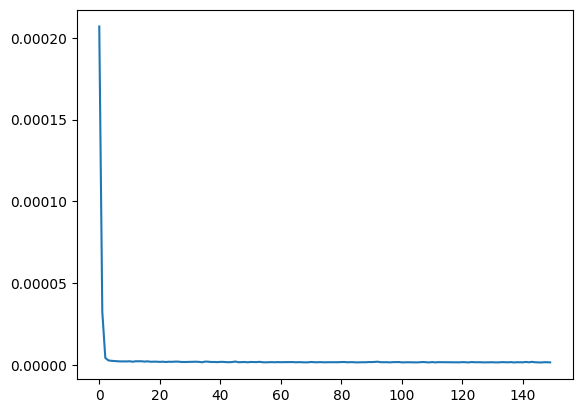

In [21]:
plt.plot(avg_losses) #plot of training losses

##Predicting test data using LSTM

In [22]:
model = best_checkpoint

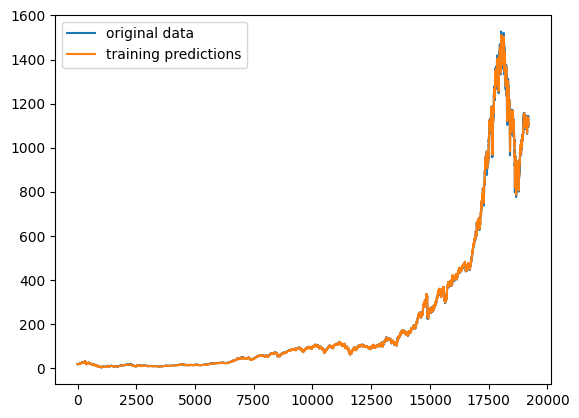

In [23]:
np.random.seed(48)
model.eval()
with torch.no_grad():
  closing_price = model(X_test.to(device))
  closing_price = scaler[0].inverse_transform(closing_price.cpu().numpy())
  training_price = model(X_train.to(device))
  valid_price = model(X_val.to(device))
  training_price = scaler[0].inverse_transform(training_price.cpu().numpy())
  valid_price = scaler[0].inverse_transform(valid_price.cpu().numpy())

training_price = [x[0] for x in training_price]
valid_price = [x[0] for x in valid_price]
plt.plot(list(scaler[0].inverse_transform(Y_train).tolist()+scaler[0].inverse_transform(Y_val).tolist()),label='original data')
plt.plot(list(training_price)+list(valid_price),label='training predictions')
plt.legend()
plt.show()

In [24]:
### Calculate RMSE performance metrics
Y_test = scaler[0].inverse_transform(Y_test)
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print("RMSE:", math.sqrt(mean_squared_error(Y_test,closing_price)))
print("MAE:", mean_absolute_error(Y_test,closing_price))
print("MAE:", mean_absolute_percentage_error(Y_test,closing_price))

RMSE: 568.4346140727563
MAE: 309.2562754909203
MAE: 0.0890777641136291


##Plotting predicted data using LSTM

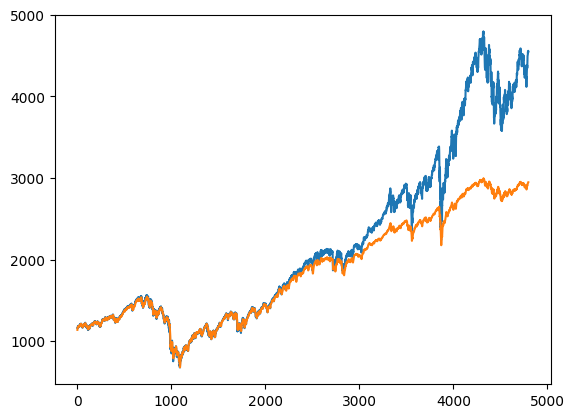

In [25]:
plt.plot(Y_test.tolist())
plt.plot(closing_price)
plt.show()

## GRU Model

In [26]:
class StockPredictor_v2(nn.Module):
    def __init__(self,input_dim, n_layers, hidden_dim):
        super().__init__()
        self.gru = nn.GRU(input_size = input_dim, hidden_size = hidden_dim, num_layers = n_layers, batch_first = True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(p = 0.3)
        self.num_layers = n_layers
        self.hidden_dim = hidden_dim

    def forward(self, X_batch):
        hidden = torch.zeros(self.num_layers, X_batch.size(0), self.hidden_dim).requires_grad_().to(device)
        output, (hidden) = self.gru(X_batch.to(device), (hidden.detach()))
        return self.linear(self.dropout(output[:,-1, :]))

In [29]:
from torch.optim import Adam

l_epochs = [50,100,150]
learning_rate = 5e-3
hidden_dim = 32
num_layers=[1,2,3]
input_dim = X_train.shape[2]

best_loss = 10000000.0
best_checkpoint = 0
avg_losses = [0]
loss_fn = nn.MSELoss().to(device)
for n_layers in num_layers:
  for epochs in l_epochs:
## training using validation and train data
    print("Epochs:", epochs, "Number of lstm layers:", n_layers)
    model = StockPredictor_v2(input_dim, n_layers, hidden_dim).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    best_chck, best_l, last_checkpoint, avg_l = train(model, loss_fn, optimizer, train_loader, val_loader, epochs)
    if(best_l < best_loss):
      print("Saving best checkpoint for epochs:", epochs, "layers:", n_layers)
      best_loss = best_l
      best_checkpoint = best_chck
      avg_losses = avg_l

Epochs: 50 Number of lstm layers: 1
Current epoch:  1


100%|██████████| 113/113 [00:00<00:00, 317.18it/s]


Training Loss: 0.0003455407568253577


100%|██████████| 38/38 [00:00<00:00, 645.11it/s]


Validation Loss: 0.01156352087855339
checkpointing current model
Current epoch:  2


100%|██████████| 113/113 [00:00<00:00, 318.78it/s]


Training Loss: 2.2544109015143476e-05


100%|██████████| 38/38 [00:00<00:00, 653.74it/s]


Validation Loss: 0.0002650537062436342
checkpointing current model
Current epoch:  3


100%|██████████| 113/113 [00:00<00:00, 319.75it/s]


Training Loss: 3.8078628676885273e-06


100%|██████████| 38/38 [00:00<00:00, 607.11it/s]


Validation Loss: 7.933843153296039e-05
checkpointing current model
Current epoch:  4


100%|██████████| 113/113 [00:00<00:00, 321.78it/s]


Training Loss: 3.190568804711802e-06


100%|██████████| 38/38 [00:00<00:00, 660.80it/s]


Validation Loss: 5.6022116041276604e-05
checkpointing current model
Current epoch:  5


100%|██████████| 113/113 [00:00<00:00, 306.71it/s]


Training Loss: 3.0837209124001674e-06


100%|██████████| 38/38 [00:00<00:00, 632.20it/s]


Validation Loss: 5.981593858450651e-05
Current epoch:  6


100%|██████████| 113/113 [00:00<00:00, 322.26it/s]


Training Loss: 2.806185420922702e-06


100%|██████████| 38/38 [00:00<00:00, 664.67it/s]


Validation Loss: 4.050420830026269e-05
checkpointing current model
Current epoch:  7


100%|██████████| 113/113 [00:00<00:00, 325.93it/s]


Training Loss: 2.797943579935236e-06


100%|██████████| 38/38 [00:00<00:00, 666.34it/s]


Validation Loss: 2.7261325158178806e-05
checkpointing current model
Current epoch:  8


100%|██████████| 113/113 [00:00<00:00, 308.36it/s]


Training Loss: 2.7107391815661686e-06


100%|██████████| 38/38 [00:00<00:00, 646.38it/s]


Validation Loss: 5.012881592847407e-05
Current epoch:  9


100%|██████████| 113/113 [00:00<00:00, 326.34it/s]


Training Loss: 2.801460595946992e-06


100%|██████████| 38/38 [00:00<00:00, 649.24it/s]


Validation Loss: 2.6558011086308397e-05
checkpointing current model
Current epoch:  10


100%|██████████| 113/113 [00:00<00:00, 316.95it/s]


Training Loss: 2.5299764274677727e-06


100%|██████████| 38/38 [00:00<00:00, 616.76it/s]


Validation Loss: 2.3865930415922776e-05
checkpointing current model
Current epoch:  11


100%|██████████| 113/113 [00:00<00:00, 330.96it/s]


Training Loss: 2.3787467853253474e-06


100%|██████████| 38/38 [00:00<00:00, 661.55it/s]


Validation Loss: 2.569471689639613e-05
Current epoch:  12


100%|██████████| 113/113 [00:00<00:00, 313.51it/s]


Training Loss: 2.5029125936271157e-06


100%|██████████| 38/38 [00:00<00:00, 645.54it/s]


Validation Loss: 4.276353865861893e-05
Current epoch:  13


100%|██████████| 113/113 [00:00<00:00, 318.30it/s]


Training Loss: 2.7500768737809267e-06


100%|██████████| 38/38 [00:00<00:00, 650.25it/s]


Validation Loss: 5.241845065029338e-05
Current epoch:  14


100%|██████████| 113/113 [00:00<00:00, 317.52it/s]


Training Loss: 2.317684902664041e-06


100%|██████████| 38/38 [00:00<00:00, 630.84it/s]


Validation Loss: 2.8943253710167482e-05
Current epoch:  15


100%|██████████| 113/113 [00:00<00:00, 316.63it/s]


Training Loss: 2.1943469619145617e-06


100%|██████████| 38/38 [00:00<00:00, 635.15it/s]


Validation Loss: 2.9721652026637457e-05
Current epoch:  16


100%|██████████| 113/113 [00:00<00:00, 321.50it/s]


Training Loss: 2.3479012725147186e-06


100%|██████████| 38/38 [00:00<00:00, 673.55it/s]


Validation Loss: 2.4449662305414677e-05
Current epoch:  17


100%|██████████| 113/113 [00:00<00:00, 330.10it/s]


Training Loss: 2.1814462343172636e-06


100%|██████████| 38/38 [00:00<00:00, 613.55it/s]


Validation Loss: 3.826234024018049e-05
Current epoch:  18


100%|██████████| 113/113 [00:00<00:00, 332.16it/s]


Training Loss: 2.4209587081713835e-06


100%|██████████| 38/38 [00:00<00:00, 658.71it/s]


Validation Loss: 3.738382656592876e-05
Current epoch:  19


100%|██████████| 113/113 [00:00<00:00, 317.82it/s]


Training Loss: 2.515505002520513e-06


100%|██████████| 38/38 [00:00<00:00, 664.96it/s]


Validation Loss: 3.918567017535679e-05
Current epoch:  20


100%|██████████| 113/113 [00:00<00:00, 323.04it/s]


Training Loss: 2.1365606244216906e-06


100%|██████████| 38/38 [00:00<00:00, 651.30it/s]


Validation Loss: 3.115521394647658e-05
Current epoch:  21


100%|██████████| 113/113 [00:00<00:00, 333.89it/s]


Training Loss: 2.177634314648458e-06


100%|██████████| 38/38 [00:00<00:00, 620.17it/s]


Validation Loss: 1.0536970876273699e-05
checkpointing current model
Current epoch:  22


100%|██████████| 113/113 [00:00<00:00, 313.00it/s]


Training Loss: 2.2021940822014585e-06


100%|██████████| 38/38 [00:00<00:00, 646.42it/s]


Validation Loss: 5.236291326582432e-05
Current epoch:  23


100%|██████████| 113/113 [00:00<00:00, 252.45it/s]


Training Loss: 2.133326006514835e-06


100%|██████████| 38/38 [00:00<00:00, 444.64it/s]


Validation Loss: 2.524567571526859e-05
Current epoch:  24


100%|██████████| 113/113 [00:00<00:00, 232.36it/s]


Training Loss: 2.1345192635635613e-06


100%|██████████| 38/38 [00:00<00:00, 435.52it/s]


Validation Loss: 2.6703977709985338e-05
Current epoch:  25


100%|██████████| 113/113 [00:00<00:00, 239.72it/s]


Training Loss: 2.076489181490615e-06


100%|██████████| 38/38 [00:00<00:00, 380.52it/s]


Validation Loss: 1.511218124505831e-05
Current epoch:  26


100%|██████████| 113/113 [00:00<00:00, 226.44it/s]


Training Loss: 2.503089262972935e-06


100%|██████████| 38/38 [00:00<00:00, 394.46it/s]


Validation Loss: 4.643645297619514e-05
Current epoch:  27


100%|██████████| 113/113 [00:00<00:00, 243.08it/s]


Training Loss: 2.2263163828029064e-06


100%|██████████| 38/38 [00:00<00:00, 473.17it/s]


Validation Loss: 3.0200646506273188e-05
Current epoch:  28


100%|██████████| 113/113 [00:00<00:00, 231.38it/s]


Training Loss: 2.2194935809238814e-06


100%|██████████| 38/38 [00:00<00:00, 467.49it/s]


Validation Loss: 7.09154483047314e-06
checkpointing current model
Current epoch:  29


100%|██████████| 113/113 [00:00<00:00, 286.13it/s]


Training Loss: 2.508124680389301e-06


100%|██████████| 38/38 [00:00<00:00, 650.44it/s]


Validation Loss: 4.1618230170570314e-05
Current epoch:  30


100%|██████████| 113/113 [00:00<00:00, 323.83it/s]


Training Loss: 1.945028770933277e-06


100%|██████████| 38/38 [00:00<00:00, 685.30it/s]


Validation Loss: 1.2363485438982025e-05
Current epoch:  31


100%|██████████| 113/113 [00:00<00:00, 323.45it/s]


Training Loss: 2.0079514797544107e-06


100%|██████████| 38/38 [00:00<00:00, 637.65it/s]


Validation Loss: 3.356194429215975e-05
Current epoch:  32


100%|██████████| 113/113 [00:00<00:00, 308.41it/s]


Training Loss: 2.076928240057896e-06


100%|██████████| 38/38 [00:00<00:00, 661.72it/s]


Validation Loss: 4.0994080336531624e-05
Current epoch:  33


100%|██████████| 113/113 [00:00<00:00, 324.04it/s]


Training Loss: 1.9356471057108138e-06


100%|██████████| 38/38 [00:00<00:00, 670.12it/s]


Validation Loss: 1.2003468327748124e-05
Current epoch:  34


100%|██████████| 113/113 [00:00<00:00, 333.89it/s]


Training Loss: 1.8816911051544594e-06


100%|██████████| 38/38 [00:00<00:00, 592.95it/s]


Validation Loss: 2.7861035050591454e-05
Current epoch:  35


100%|██████████| 113/113 [00:00<00:00, 325.18it/s]


Training Loss: 1.9278377294540405e-06


100%|██████████| 38/38 [00:00<00:00, 655.44it/s]


Validation Loss: 3.9312493754550815e-05
Current epoch:  36


100%|██████████| 113/113 [00:00<00:00, 327.47it/s]


Training Loss: 1.8966501329487073e-06


100%|██████████| 38/38 [00:00<00:00, 623.44it/s]


Validation Loss: 2.1092684619361535e-05
Current epoch:  37


100%|██████████| 113/113 [00:00<00:00, 322.83it/s]


Training Loss: 2.185711991842254e-06


100%|██████████| 38/38 [00:00<00:00, 660.59it/s]


Validation Loss: 2.4391451006522402e-05
Current epoch:  38


100%|██████████| 113/113 [00:00<00:00, 324.06it/s]


Training Loss: 1.8570279962659697e-06


100%|██████████| 38/38 [00:00<00:00, 643.83it/s]


Validation Loss: 2.2352716769091785e-05
Current epoch:  39


100%|██████████| 113/113 [00:00<00:00, 316.32it/s]


Training Loss: 1.7480829228588846e-06


100%|██████████| 38/38 [00:00<00:00, 623.23it/s]


Validation Loss: 4.378262747195549e-05
Current epoch:  40


100%|██████████| 113/113 [00:00<00:00, 316.75it/s]


Training Loss: 1.942823473655153e-06


100%|██████████| 38/38 [00:00<00:00, 594.54it/s]


Validation Loss: 5.1227880248916335e-06
checkpointing current model
Current epoch:  41


100%|██████████| 113/113 [00:00<00:00, 325.11it/s]


Training Loss: 1.6519696828254382e-06


100%|██████████| 38/38 [00:00<00:00, 592.98it/s]


Validation Loss: 1.9292274373583496e-05
Current epoch:  42


100%|██████████| 113/113 [00:00<00:00, 329.46it/s]


Training Loss: 1.751103582137148e-06


100%|██████████| 38/38 [00:00<00:00, 630.79it/s]


Validation Loss: 3.073337938985787e-05
Current epoch:  43


100%|██████████| 113/113 [00:00<00:00, 323.65it/s]


Training Loss: 1.8092007394443499e-06


100%|██████████| 38/38 [00:00<00:00, 644.30it/s]


Validation Loss: 4.777095455210656e-06
checkpointing current model
Current epoch:  44


100%|██████████| 113/113 [00:00<00:00, 322.21it/s]


Training Loss: 1.749218085933535e-06


100%|██████████| 38/38 [00:00<00:00, 655.66it/s]


Validation Loss: 5.626043275697157e-06
Current epoch:  45


100%|██████████| 113/113 [00:00<00:00, 301.13it/s]


Training Loss: 1.692140244813345e-06


100%|██████████| 38/38 [00:00<00:00, 667.63it/s]


Validation Loss: 1.4210780136636458e-05
Current epoch:  46


100%|██████████| 113/113 [00:00<00:00, 326.47it/s]


Training Loss: 1.8200478280050447e-06


100%|██████████| 38/38 [00:00<00:00, 671.87it/s]


Validation Loss: 1.0215223483100999e-05
Current epoch:  47


100%|██████████| 113/113 [00:00<00:00, 323.39it/s]


Training Loss: 1.8618783315105247e-06


100%|██████████| 38/38 [00:00<00:00, 651.69it/s]


Validation Loss: 2.6112165869562887e-05
Current epoch:  48


100%|██████████| 113/113 [00:00<00:00, 327.80it/s]


Training Loss: 1.763629825290991e-06


100%|██████████| 38/38 [00:00<00:00, 668.33it/s]


Validation Loss: 2.577587110863533e-05
Current epoch:  49


100%|██████████| 113/113 [00:00<00:00, 310.61it/s]


Training Loss: 1.666884713813488e-06


100%|██████████| 38/38 [00:00<00:00, 653.96it/s]


Validation Loss: 3.794350050156936e-05
Current epoch:  50


100%|██████████| 113/113 [00:00<00:00, 320.18it/s]


Training Loss: 1.573956296851975e-06


100%|██████████| 38/38 [00:00<00:00, 641.95it/s]


Validation Loss: 4.629423528967891e-06
checkpointing current model
Saving best checkpoint for epochs: 50 layers: 1
Epochs: 100 Number of lstm layers: 1
Current epoch:  1


100%|██████████| 113/113 [00:00<00:00, 322.97it/s]


Training Loss: 0.0018211026908829808


100%|██████████| 38/38 [00:00<00:00, 540.73it/s]


Validation Loss: 0.01809152029454708
checkpointing current model
Current epoch:  2


100%|██████████| 113/113 [00:00<00:00, 262.37it/s]


Training Loss: 0.00021795203792862594


100%|██████████| 38/38 [00:00<00:00, 443.02it/s]


Validation Loss: 0.012519750744104385
checkpointing current model
Current epoch:  3


100%|██████████| 113/113 [00:00<00:00, 232.26it/s]


Training Loss: 0.00010709337948355824


100%|██████████| 38/38 [00:00<00:00, 428.06it/s]


Validation Loss: 0.007973767817020416
checkpointing current model
Current epoch:  4


100%|██████████| 113/113 [00:00<00:00, 234.31it/s]


Training Loss: 5.859054726897739e-05


100%|██████████| 38/38 [00:00<00:00, 455.38it/s]


Validation Loss: 0.004421096760779619
checkpointing current model
Current epoch:  5


100%|██████████| 113/113 [00:00<00:00, 221.06it/s]


Training Loss: 3.203922460670583e-05


100%|██████████| 38/38 [00:00<00:00, 381.99it/s]


Validation Loss: 0.0019051417475566268
checkpointing current model
Current epoch:  6


100%|██████████| 113/113 [00:00<00:00, 223.19it/s]


Training Loss: 1.550423439766746e-05


100%|██████████| 38/38 [00:00<00:00, 418.24it/s]


Validation Loss: 0.0006162385689094663
checkpointing current model
Current epoch:  7


100%|██████████| 113/113 [00:00<00:00, 229.99it/s]


Training Loss: 8.269311365438625e-06


100%|██████████| 38/38 [00:00<00:00, 442.23it/s]


Validation Loss: 0.00020670444064307958
checkpointing current model
Current epoch:  8


100%|██████████| 113/113 [00:00<00:00, 253.08it/s]


Training Loss: 5.242814040684607e-06


100%|██████████| 38/38 [00:00<00:00, 632.08it/s]


Validation Loss: 9.632428555050865e-05
checkpointing current model
Current epoch:  9


100%|██████████| 113/113 [00:00<00:00, 328.16it/s]


Training Loss: 3.983043825428467e-06


100%|██████████| 38/38 [00:00<00:00, 641.10it/s]


Validation Loss: 5.3255585953593254e-05
checkpointing current model
Current epoch:  10


100%|██████████| 113/113 [00:00<00:00, 322.25it/s]


Training Loss: 3.4522790883784182e-06


100%|██████████| 38/38 [00:00<00:00, 633.80it/s]


Validation Loss: 3.548019958543591e-05
checkpointing current model
Current epoch:  11


100%|██████████| 113/113 [00:00<00:00, 317.80it/s]


Training Loss: 3.1804374884814024e-06


100%|██████████| 38/38 [00:00<00:00, 653.43it/s]


Validation Loss: 3.466717680566944e-05
checkpointing current model
Current epoch:  12


100%|██████████| 113/113 [00:00<00:00, 322.55it/s]


Training Loss: 2.8546339763124706e-06


100%|██████████| 38/38 [00:00<00:00, 601.94it/s]


Validation Loss: 4.6098168240860105e-05
Current epoch:  13


100%|██████████| 113/113 [00:00<00:00, 313.40it/s]


Training Loss: 2.863026793420431e-06


100%|██████████| 38/38 [00:00<00:00, 589.51it/s]


Validation Loss: 2.6429135687067173e-05
checkpointing current model
Current epoch:  14


100%|██████████| 113/113 [00:00<00:00, 297.57it/s]


Training Loss: 2.7804678666143445e-06


100%|██████████| 38/38 [00:00<00:00, 574.70it/s]


Validation Loss: 2.7789254090748727e-05
Current epoch:  15


100%|██████████| 113/113 [00:00<00:00, 303.65it/s]


Training Loss: 2.700489403650863e-06


100%|██████████| 38/38 [00:00<00:00, 628.62it/s]


Validation Loss: 2.926033630501479e-05
Current epoch:  16


100%|██████████| 113/113 [00:00<00:00, 312.24it/s]


Training Loss: 2.7097166821477003e-06


100%|██████████| 38/38 [00:00<00:00, 626.71it/s]


Validation Loss: 2.4943050448200665e-05
checkpointing current model
Current epoch:  17


100%|██████████| 113/113 [00:00<00:00, 311.14it/s]


Training Loss: 2.6385423552710563e-06


100%|██████████| 38/38 [00:00<00:00, 631.07it/s]


Validation Loss: 2.677361771930009e-05
Current epoch:  18


100%|██████████| 113/113 [00:00<00:00, 321.15it/s]


Training Loss: 2.5506924430374056e-06


100%|██████████| 38/38 [00:00<00:00, 623.71it/s]


Validation Loss: 2.554241473262664e-05
Current epoch:  19


100%|██████████| 113/113 [00:00<00:00, 323.49it/s]


Training Loss: 2.641749006215832e-06


100%|██████████| 38/38 [00:00<00:00, 521.05it/s]


Validation Loss: 2.5481904231128283e-05
Current epoch:  20


100%|██████████| 113/113 [00:00<00:00, 310.42it/s]


Training Loss: 2.5499905405013124e-06


100%|██████████| 38/38 [00:00<00:00, 610.98it/s]


Validation Loss: 1.7265752831008285e-05
checkpointing current model
Current epoch:  21


100%|██████████| 113/113 [00:00<00:00, 315.08it/s]


Training Loss: 2.393213435425423e-06


100%|██████████| 38/38 [00:00<00:00, 644.14it/s]


Validation Loss: 2.124747697962448e-05
Current epoch:  22


100%|██████████| 113/113 [00:00<00:00, 314.77it/s]


Training Loss: 2.432652081552078e-06


100%|██████████| 38/38 [00:00<00:00, 633.21it/s]


Validation Loss: 2.9596349122584797e-05
Current epoch:  23


100%|██████████| 113/113 [00:00<00:00, 317.43it/s]


Training Loss: 2.4056680558715016e-06


100%|██████████| 38/38 [00:00<00:00, 582.43it/s]


Validation Loss: 1.996100036194548e-05
Current epoch:  24


100%|██████████| 113/113 [00:00<00:00, 293.61it/s]


Training Loss: 2.3361685634881724e-06


100%|██████████| 38/38 [00:00<00:00, 640.63it/s]


Validation Loss: 1.901581526908558e-05
Current epoch:  25


100%|██████████| 113/113 [00:00<00:00, 307.64it/s]


Training Loss: 2.2806996184954187e-06


100%|██████████| 38/38 [00:00<00:00, 601.53it/s]


Validation Loss: 2.0417646737769246e-05
Current epoch:  26


100%|██████████| 113/113 [00:00<00:00, 310.37it/s]


Training Loss: 2.2901047032064525e-06


100%|██████████| 38/38 [00:00<00:00, 603.36it/s]


Validation Loss: 2.8827089408878237e-05
Current epoch:  27


100%|██████████| 113/113 [00:00<00:00, 315.68it/s]


Training Loss: 2.434052476019133e-06


100%|██████████| 38/38 [00:00<00:00, 623.85it/s]


Validation Loss: 2.9281127353897318e-05
Current epoch:  28


100%|██████████| 113/113 [00:00<00:00, 320.88it/s]


Training Loss: 2.3089226033334853e-06


100%|██████████| 38/38 [00:00<00:00, 625.73it/s]


Validation Loss: 1.8332721083424985e-05
Current epoch:  29


100%|██████████| 113/113 [00:00<00:00, 314.50it/s]


Training Loss: 2.207823854405433e-06


100%|██████████| 38/38 [00:00<00:00, 603.03it/s]


Validation Loss: 2.8196525818202645e-05
Current epoch:  30


100%|██████████| 113/113 [00:00<00:00, 312.12it/s]


Training Loss: 2.218730514869094e-06


100%|██████████| 38/38 [00:00<00:00, 447.96it/s]


Validation Loss: 2.2621543394052424e-05
Current epoch:  31


100%|██████████| 113/113 [00:00<00:00, 222.48it/s]


Training Loss: 2.2351614461513236e-06


100%|██████████| 38/38 [00:00<00:00, 408.81it/s]


Validation Loss: 2.826147283485625e-05
Current epoch:  32


100%|██████████| 113/113 [00:00<00:00, 230.41it/s]


Training Loss: 2.227540107924142e-06


100%|██████████| 38/38 [00:00<00:00, 368.60it/s]


Validation Loss: 1.5462765077245422e-05
checkpointing current model
Current epoch:  33


100%|██████████| 113/113 [00:00<00:00, 232.15it/s]


Training Loss: 2.13478529076383e-06


100%|██████████| 38/38 [00:00<00:00, 448.94it/s]


Validation Loss: 1.8690203432925045e-05
Current epoch:  34


100%|██████████| 113/113 [00:00<00:00, 228.66it/s]


Training Loss: 2.1708451640733983e-06


100%|██████████| 38/38 [00:00<00:00, 431.28it/s]


Validation Loss: 2.662278711795807e-05
Current epoch:  35


100%|██████████| 113/113 [00:00<00:00, 227.42it/s]


Training Loss: 2.221256636403268e-06


100%|██████████| 38/38 [00:00<00:00, 392.70it/s]


Validation Loss: 2.140846845577471e-05
Current epoch:  36


100%|██████████| 113/113 [00:00<00:00, 233.97it/s]


Training Loss: 2.2381248072633753e-06


100%|██████████| 38/38 [00:00<00:00, 580.86it/s]


Validation Loss: 2.3472646716982126e-05
Current epoch:  37


100%|██████████| 113/113 [00:00<00:00, 320.88it/s]


Training Loss: 2.1529951936827274e-06


100%|██████████| 38/38 [00:00<00:00, 615.58it/s]


Validation Loss: 3.9467715396313e-05
Current epoch:  38


100%|██████████| 113/113 [00:00<00:00, 311.97it/s]


Training Loss: 2.2066760720917955e-06


100%|██████████| 38/38 [00:00<00:00, 640.63it/s]


Validation Loss: 1.5841198546695523e-05
Current epoch:  39


100%|██████████| 113/113 [00:00<00:00, 320.08it/s]


Training Loss: 2.1331436528271297e-06


100%|██████████| 38/38 [00:00<00:00, 659.90it/s]


Validation Loss: 3.500973616610281e-05
Current epoch:  40


100%|██████████| 113/113 [00:00<00:00, 311.88it/s]


Training Loss: 2.08821097658074e-06


100%|██████████| 38/38 [00:00<00:00, 573.39it/s]


Validation Loss: 3.001024560944643e-05
Current epoch:  41


100%|██████████| 113/113 [00:00<00:00, 311.40it/s]


Training Loss: 2.1348887457861565e-06


100%|██████████| 38/38 [00:00<00:00, 649.72it/s]


Validation Loss: 2.8660024327109568e-05
Current epoch:  42


100%|██████████| 113/113 [00:00<00:00, 312.31it/s]


Training Loss: 2.40412578023097e-06


100%|██████████| 38/38 [00:00<00:00, 599.04it/s]


Validation Loss: 3.0059738492127508e-05
Current epoch:  43


100%|██████████| 113/113 [00:00<00:00, 308.53it/s]


Training Loss: 2.14337273973797e-06


100%|██████████| 38/38 [00:00<00:00, 573.75it/s]


Validation Loss: 2.354977732466068e-05
Current epoch:  44


100%|██████████| 113/113 [00:00<00:00, 299.24it/s]


Training Loss: 2.2667127268505283e-06


100%|██████████| 38/38 [00:00<00:00, 546.66it/s]


Validation Loss: 1.3913365364714991e-05
checkpointing current model
Current epoch:  45


100%|██████████| 113/113 [00:00<00:00, 298.07it/s]


Training Loss: 2.019797648245003e-06


100%|██████████| 38/38 [00:00<00:00, 599.03it/s]


Validation Loss: 1.728141614876222e-05
Current epoch:  46


100%|██████████| 113/113 [00:00<00:00, 320.66it/s]


Training Loss: 2.353555601075641e-06


100%|██████████| 38/38 [00:00<00:00, 607.51it/s]


Validation Loss: 2.106580723193474e-05
Current epoch:  47


100%|██████████| 113/113 [00:00<00:00, 310.01it/s]


Training Loss: 2.195170509367017e-06


100%|██████████| 38/38 [00:00<00:00, 628.36it/s]


Validation Loss: 2.196558671130333e-05
Current epoch:  48


100%|██████████| 113/113 [00:00<00:00, 318.14it/s]


Training Loss: 2.133427415174083e-06


100%|██████████| 38/38 [00:00<00:00, 564.62it/s]


Validation Loss: 3.118617314612493e-05
Current epoch:  49


100%|██████████| 113/113 [00:00<00:00, 263.20it/s]


Training Loss: 2.1436931092466693e-06


100%|██████████| 38/38 [00:00<00:00, 416.18it/s]


Validation Loss: 1.3232399396656547e-05
checkpointing current model
Current epoch:  50


100%|██████████| 113/113 [00:00<00:00, 299.37it/s]


Training Loss: 2.0622785541490884e-06


100%|██████████| 38/38 [00:00<00:00, 622.69it/s]


Validation Loss: 2.3698126824456267e-05
Current epoch:  51


100%|██████████| 113/113 [00:00<00:00, 315.11it/s]


Training Loss: 1.8867638118535979e-06


100%|██████████| 38/38 [00:00<00:00, 647.00it/s]


Validation Loss: 3.242425009375438e-05
Current epoch:  52


100%|██████████| 113/113 [00:00<00:00, 309.48it/s]


Training Loss: 2.0278296233300352e-06


100%|██████████| 38/38 [00:00<00:00, 589.07it/s]


Validation Loss: 3.610431667766534e-05
Current epoch:  53


100%|██████████| 113/113 [00:00<00:00, 310.35it/s]


Training Loss: 1.9822537069558166e-06


100%|██████████| 38/38 [00:00<00:00, 626.63it/s]


Validation Loss: 3.848037522402592e-05
Current epoch:  54


100%|██████████| 113/113 [00:00<00:00, 319.95it/s]


Training Loss: 1.9273420548415743e-06


100%|██████████| 38/38 [00:00<00:00, 610.88it/s]


Validation Loss: 1.785869062587153e-05
Current epoch:  55


100%|██████████| 113/113 [00:00<00:00, 317.63it/s]


Training Loss: 1.9165615867677843e-06


100%|██████████| 38/38 [00:00<00:00, 611.28it/s]


Validation Loss: 1.617574889678508e-05
Current epoch:  56


100%|██████████| 113/113 [00:00<00:00, 294.05it/s]


Training Loss: 2.016797679971205e-06


100%|██████████| 38/38 [00:00<00:00, 639.85it/s]


Validation Loss: 1.6488984329043888e-05
Current epoch:  57


100%|██████████| 113/113 [00:00<00:00, 326.99it/s]


Training Loss: 1.8936681271952693e-06


100%|██████████| 38/38 [00:00<00:00, 582.44it/s]


Validation Loss: 2.4285844119731337e-05
Current epoch:  58


100%|██████████| 113/113 [00:00<00:00, 311.09it/s]


Training Loss: 1.7559173102199566e-06


100%|██████████| 38/38 [00:00<00:00, 545.82it/s]


Validation Loss: 2.9378059480222873e-05
Current epoch:  59


100%|██████████| 113/113 [00:00<00:00, 224.00it/s]


Training Loss: 1.8021888763541938e-06


100%|██████████| 38/38 [00:00<00:00, 414.91it/s]


Validation Loss: 3.4894699638243765e-05
Current epoch:  60


100%|██████████| 113/113 [00:00<00:00, 226.36it/s]


Training Loss: 1.9245408111601137e-06


100%|██████████| 38/38 [00:00<00:00, 423.20it/s]


Validation Loss: 6.520256647490896e-06
checkpointing current model
Current epoch:  61


100%|██████████| 113/113 [00:00<00:00, 234.11it/s]


Training Loss: 2.046203235295252e-06


100%|██████████| 38/38 [00:00<00:00, 433.99it/s]


Validation Loss: 1.2656111721298657e-05
Current epoch:  62


100%|██████████| 113/113 [00:00<00:00, 232.26it/s]


Training Loss: 1.8588744978842442e-06


100%|██████████| 38/38 [00:00<00:00, 409.88it/s]


Validation Loss: 5.2329269237816334e-05
Current epoch:  63


100%|██████████| 113/113 [00:00<00:00, 239.20it/s]


Training Loss: 1.9664134924823884e-06


100%|██████████| 38/38 [00:00<00:00, 463.46it/s]


Validation Loss: 2.376892553002108e-05
Current epoch:  64


100%|██████████| 113/113 [00:00<00:00, 227.22it/s]


Training Loss: 1.7912104794959305e-06


100%|██████████| 38/38 [00:00<00:00, 337.48it/s]


Validation Loss: 9.184231203107629e-06
Current epoch:  65


100%|██████████| 113/113 [00:00<00:00, 270.57it/s]


Training Loss: 2.1607038434012793e-06


100%|██████████| 38/38 [00:00<00:00, 529.56it/s]


Validation Loss: 1.5043198800412938e-05
Current epoch:  66


100%|██████████| 113/113 [00:00<00:00, 309.60it/s]


Training Loss: 1.76693811226869e-06


100%|██████████| 38/38 [00:00<00:00, 497.94it/s]


Validation Loss: 1.9894365323125385e-05
Current epoch:  67


100%|██████████| 113/113 [00:00<00:00, 319.23it/s]


Training Loss: 1.7729197452354128e-06


100%|██████████| 38/38 [00:00<00:00, 576.58it/s]


Validation Loss: 3.544727951521054e-05
Current epoch:  68


100%|██████████| 113/113 [00:00<00:00, 309.70it/s]


Training Loss: 1.6316832898155553e-06


100%|██████████| 38/38 [00:00<00:00, 634.24it/s]


Validation Loss: 9.528764167043846e-06
Current epoch:  69


100%|██████████| 113/113 [00:00<00:00, 312.06it/s]


Training Loss: 1.7516013031126931e-06


100%|██████████| 38/38 [00:00<00:00, 588.82it/s]


Validation Loss: 2.7382973712519743e-05
Current epoch:  70


100%|██████████| 113/113 [00:00<00:00, 304.52it/s]


Training Loss: 1.8577161426946986e-06


100%|██████████| 38/38 [00:00<00:00, 524.28it/s]


Validation Loss: 2.6268222427461296e-05
Current epoch:  71


100%|██████████| 113/113 [00:00<00:00, 297.33it/s]


Training Loss: 1.9043828842768562e-06


100%|██████████| 38/38 [00:00<00:00, 673.33it/s]


Validation Loss: 2.207704892498441e-05
Current epoch:  72


100%|██████████| 113/113 [00:00<00:00, 313.65it/s]


Training Loss: 1.8217601791548077e-06


100%|██████████| 38/38 [00:00<00:00, 614.77it/s]


Validation Loss: 6.707905868097441e-06
Current epoch:  73


100%|██████████| 113/113 [00:00<00:00, 318.17it/s]


Training Loss: 1.5910054571577348e-06


100%|██████████| 38/38 [00:00<00:00, 576.85it/s]


Validation Loss: 1.1633676876954269e-05
Current epoch:  74


100%|██████████| 113/113 [00:00<00:00, 314.27it/s]


Training Loss: 1.7110481849158532e-06


100%|██████████| 38/38 [00:00<00:00, 567.15it/s]


Validation Loss: 1.1633519534370862e-05
Current epoch:  75


100%|██████████| 113/113 [00:00<00:00, 305.78it/s]


Training Loss: 1.6879423583304742e-06


100%|██████████| 38/38 [00:00<00:00, 592.80it/s]


Validation Loss: 1.428595987817971e-05
Current epoch:  76


100%|██████████| 113/113 [00:00<00:00, 313.57it/s]


Training Loss: 1.6937489135671058e-06


100%|██████████| 38/38 [00:00<00:00, 624.70it/s]


Validation Loss: 3.1405561458086595e-05
Current epoch:  77


100%|██████████| 113/113 [00:00<00:00, 289.74it/s]


Training Loss: 1.7749835024005733e-06


100%|██████████| 38/38 [00:00<00:00, 553.31it/s]


Validation Loss: 8.029818854993209e-05
Current epoch:  78


100%|██████████| 113/113 [00:00<00:00, 306.43it/s]


Training Loss: 1.73698333583161e-06


100%|██████████| 38/38 [00:00<00:00, 613.03it/s]


Validation Loss: 8.008600161701906e-06
Current epoch:  79


100%|██████████| 113/113 [00:00<00:00, 316.85it/s]


Training Loss: 1.6557079334234004e-06


100%|██████████| 38/38 [00:00<00:00, 628.38it/s]


Validation Loss: 1.484518088545883e-05
Current epoch:  80


100%|██████████| 113/113 [00:00<00:00, 307.76it/s]


Training Loss: 1.6740775663492968e-06


100%|██████████| 38/38 [00:00<00:00, 608.99it/s]


Validation Loss: 4.3775606172857806e-05
Current epoch:  81


100%|██████████| 113/113 [00:00<00:00, 310.66it/s]


Training Loss: 1.5495348861804814e-06


100%|██████████| 38/38 [00:00<00:00, 600.40it/s]


Validation Loss: 3.537820521160029e-05
Current epoch:  82


100%|██████████| 113/113 [00:00<00:00, 305.60it/s]


Training Loss: 1.6005546967789996e-06


100%|██████████| 38/38 [00:00<00:00, 637.05it/s]


Validation Loss: 1.072986106009921e-05
Current epoch:  83


100%|██████████| 113/113 [00:00<00:00, 320.01it/s]


Training Loss: 1.6219735243794275e-06


100%|██████████| 38/38 [00:00<00:00, 568.51it/s]


Validation Loss: 2.1481813746504486e-05
Current epoch:  84


100%|██████████| 113/113 [00:00<00:00, 315.26it/s]


Training Loss: 1.6534982023586053e-06


100%|██████████| 38/38 [00:00<00:00, 614.83it/s]


Validation Loss: 6.362715339491842e-06
checkpointing current model
Current epoch:  85


100%|██████████| 113/113 [00:00<00:00, 314.22it/s]


Training Loss: 1.5321950286306674e-06


100%|██████████| 38/38 [00:00<00:00, 580.95it/s]


Validation Loss: 1.146479644376086e-05
Current epoch:  86


100%|██████████| 113/113 [00:00<00:00, 306.23it/s]


Training Loss: 1.6002408074200503e-06


100%|██████████| 38/38 [00:00<00:00, 578.81it/s]


Validation Loss: 6.090678652981296e-06
checkpointing current model
Current epoch:  87


100%|██████████| 113/113 [00:00<00:00, 253.53it/s]


Training Loss: 1.5499799701501615e-06


100%|██████████| 38/38 [00:00<00:00, 382.30it/s]


Validation Loss: 5.1228162192273885e-05
Current epoch:  88


100%|██████████| 113/113 [00:00<00:00, 210.36it/s]


Training Loss: 1.6241172033915063e-06


100%|██████████| 38/38 [00:00<00:00, 385.72it/s]


Validation Loss: 4.076646291650832e-06
checkpointing current model
Current epoch:  89


100%|██████████| 113/113 [00:00<00:00, 202.26it/s]


Training Loss: 1.4468316749116639e-06


100%|██████████| 38/38 [00:00<00:00, 446.17it/s]


Validation Loss: 4.235576852806844e-06
Current epoch:  90


100%|██████████| 113/113 [00:00<00:00, 213.37it/s]


Training Loss: 1.5303007785405498e-06


100%|██████████| 38/38 [00:00<00:00, 436.73it/s]


Validation Loss: 7.0676346695108805e-06
Current epoch:  91


100%|██████████| 113/113 [00:00<00:00, 228.06it/s]


Training Loss: 1.7900056263897568e-06


100%|██████████| 38/38 [00:00<00:00, 422.25it/s]


Validation Loss: 5.473187684401637e-06
Current epoch:  92


100%|██████████| 113/113 [00:00<00:00, 237.65it/s]


Training Loss: 1.5390500038847676e-06


100%|██████████| 38/38 [00:00<00:00, 453.93it/s]


Validation Loss: 2.1426852981676348e-05
Current epoch:  93


100%|██████████| 113/113 [00:00<00:00, 224.91it/s]


Training Loss: 1.4941711015126202e-06


100%|██████████| 38/38 [00:00<00:00, 535.37it/s]


Validation Loss: 7.73663487052545e-06
Current epoch:  94


100%|██████████| 113/113 [00:00<00:00, 311.02it/s]


Training Loss: 1.5428499864356127e-06


100%|██████████| 38/38 [00:00<00:00, 647.13it/s]


Validation Loss: 8.602968591731042e-06
Current epoch:  95


100%|██████████| 113/113 [00:00<00:00, 312.68it/s]


Training Loss: 1.5956586594256805e-06


100%|██████████| 38/38 [00:00<00:00, 629.17it/s]


Validation Loss: 2.4429096811218187e-05
Current epoch:  96


100%|██████████| 113/113 [00:00<00:00, 304.47it/s]


Training Loss: 1.6993402596199303e-06


100%|██████████| 38/38 [00:00<00:00, 581.54it/s]


Validation Loss: 2.0890083760605194e-05
Current epoch:  97


100%|██████████| 113/113 [00:00<00:00, 299.63it/s]


Training Loss: 1.7153904536826303e-06


100%|██████████| 38/38 [00:00<00:00, 560.23it/s]


Validation Loss: 1.253609934792621e-05
Current epoch:  98


100%|██████████| 113/113 [00:00<00:00, 312.43it/s]


Training Loss: 1.6285497395074344e-06


100%|██████████| 38/38 [00:00<00:00, 590.79it/s]


Validation Loss: 3.995231963926926e-06
checkpointing current model
Current epoch:  99


100%|██████████| 113/113 [00:00<00:00, 314.40it/s]


Training Loss: 1.4580217566617648e-06


100%|██████████| 38/38 [00:00<00:00, 561.13it/s]


Validation Loss: 1.8827031453838572e-05
Current epoch:  100


100%|██████████| 113/113 [00:00<00:00, 317.04it/s]


Training Loss: 1.5845602092667832e-06


100%|██████████| 38/38 [00:00<00:00, 613.37it/s]


Validation Loss: 1.5193553736025933e-05
Saving best checkpoint for epochs: 100 layers: 1
Epochs: 150 Number of lstm layers: 1
Current epoch:  1


100%|██████████| 113/113 [00:00<00:00, 324.78it/s]


Training Loss: 0.00154206738807261


100%|██████████| 38/38 [00:00<00:00, 526.57it/s]


Validation Loss: 0.021739738062024117
checkpointing current model
Current epoch:  2


100%|██████████| 113/113 [00:00<00:00, 299.88it/s]


Training Loss: 0.00015373306814581156


100%|██████████| 38/38 [00:00<00:00, 546.71it/s]


Validation Loss: 0.01493030320852995
checkpointing current model
Current epoch:  3


100%|██████████| 113/113 [00:00<00:00, 314.62it/s]


Training Loss: 7.400572940241545e-05


100%|██████████| 38/38 [00:00<00:00, 614.13it/s]


Validation Loss: 0.006978312507271767
checkpointing current model
Current epoch:  4


100%|██████████| 113/113 [00:00<00:00, 308.05it/s]


Training Loss: 2.913401840487495e-05


100%|██████████| 38/38 [00:00<00:00, 607.11it/s]


Validation Loss: 0.0008772840956225991
checkpointing current model
Current epoch:  5


100%|██████████| 113/113 [00:00<00:00, 315.54it/s]


Training Loss: 9.779882020666264e-06


100%|██████████| 38/38 [00:00<00:00, 619.74it/s]


Validation Loss: 6.520405440824106e-05
checkpointing current model
Current epoch:  6


100%|██████████| 113/113 [00:00<00:00, 306.74it/s]


Training Loss: 5.736049388360698e-06


100%|██████████| 38/38 [00:00<00:00, 596.02it/s]


Validation Loss: 4.094889300176874e-05
checkpointing current model
Current epoch:  7


100%|██████████| 113/113 [00:00<00:00, 322.58it/s]


Training Loss: 4.228527359373402e-06


100%|██████████| 38/38 [00:00<00:00, 649.03it/s]


Validation Loss: 1.8620086848386563e-05
checkpointing current model
Current epoch:  8


100%|██████████| 113/113 [00:00<00:00, 320.18it/s]


Training Loss: 3.5958760236098897e-06


100%|██████████| 38/38 [00:00<00:00, 530.54it/s]


Validation Loss: 3.7465437344508246e-05
Current epoch:  9


100%|██████████| 113/113 [00:00<00:00, 311.28it/s]


Training Loss: 3.3127064398286166e-06


100%|██████████| 38/38 [00:00<00:00, 599.41it/s]


Validation Loss: 2.88213759631617e-05
Current epoch:  10


100%|██████████| 113/113 [00:00<00:00, 322.13it/s]


Training Loss: 3.220871576559148e-06


100%|██████████| 38/38 [00:00<00:00, 595.89it/s]


Validation Loss: 5.5640190112171695e-05
Current epoch:  11


100%|██████████| 113/113 [00:00<00:00, 294.28it/s]


Training Loss: 3.159995685564354e-06


100%|██████████| 38/38 [00:00<00:00, 505.17it/s]


Validation Loss: 2.7215990485274233e-05
Current epoch:  12


100%|██████████| 113/113 [00:00<00:00, 315.63it/s]


Training Loss: 2.8681095045612892e-06


100%|██████████| 38/38 [00:00<00:00, 580.80it/s]


Validation Loss: 4.05277096433565e-05
Current epoch:  13


100%|██████████| 113/113 [00:00<00:00, 299.08it/s]


Training Loss: 2.8618080705200555e-06


100%|██████████| 38/38 [00:00<00:00, 581.95it/s]


Validation Loss: 3.517114237183705e-05
Current epoch:  14


100%|██████████| 113/113 [00:00<00:00, 315.41it/s]


Training Loss: 3.053069576708367e-06


100%|██████████| 38/38 [00:00<00:00, 635.24it/s]


Validation Loss: 4.726546467281878e-05
Current epoch:  15


100%|██████████| 113/113 [00:00<00:00, 304.46it/s]


Training Loss: 2.831172650985536e-06


100%|██████████| 38/38 [00:00<00:00, 570.57it/s]


Validation Loss: 2.3597398467245512e-05
Current epoch:  16


100%|██████████| 113/113 [00:00<00:00, 213.42it/s]


Training Loss: 2.878137820516713e-06


100%|██████████| 38/38 [00:00<00:00, 425.89it/s]


Validation Loss: 3.0679162591695786e-05
Current epoch:  17


100%|██████████| 113/113 [00:00<00:00, 219.14it/s]


Training Loss: 2.6849638743442483e-06


100%|██████████| 38/38 [00:00<00:00, 431.48it/s]


Validation Loss: 3.752541670110077e-05
Current epoch:  18


100%|██████████| 113/113 [00:00<00:00, 232.73it/s]


Training Loss: 2.6006150619650725e-06


100%|██████████| 38/38 [00:00<00:00, 444.90it/s]


Validation Loss: 4.666085078497417e-05
Current epoch:  19


100%|██████████| 113/113 [00:01<00:00, 88.12it/s]


Training Loss: 2.525467834857409e-06


100%|██████████| 38/38 [00:00<00:00, 443.52it/s]


Validation Loss: 3.2510368328075856e-05
Current epoch:  20


100%|██████████| 113/113 [00:01<00:00, 105.37it/s]


Training Loss: 2.4250646220025374e-06


100%|██████████| 38/38 [00:00<00:00, 631.74it/s]


Validation Loss: 1.9645212887553498e-05
Current epoch:  21


100%|██████████| 113/113 [00:00<00:00, 319.02it/s]


Training Loss: 2.548190877860179e-06


100%|██████████| 38/38 [00:00<00:00, 626.95it/s]


Validation Loss: 2.496811794117093e-05
Current epoch:  22


100%|██████████| 113/113 [00:00<00:00, 307.34it/s]


Training Loss: 2.4720955025259173e-06


100%|██████████| 38/38 [00:00<00:00, 548.18it/s]


Validation Loss: 3.5927369026467204e-05
Current epoch:  23


100%|██████████| 113/113 [00:00<00:00, 320.91it/s]


Training Loss: 2.451472710163216e-06


100%|██████████| 38/38 [00:00<00:00, 597.82it/s]


Validation Loss: 1.5996292859199457e-05
checkpointing current model
Current epoch:  24


100%|██████████| 113/113 [00:00<00:00, 305.17it/s]


Training Loss: 2.4676962766534416e-06


100%|██████████| 38/38 [00:00<00:00, 598.66it/s]


Validation Loss: 2.6124655050807633e-05
Current epoch:  25


100%|██████████| 113/113 [00:00<00:00, 312.30it/s]


Training Loss: 2.351888497287291e-06


100%|██████████| 38/38 [00:00<00:00, 584.91it/s]


Validation Loss: 5.7563112932257354e-05
Current epoch:  26


100%|██████████| 113/113 [00:00<00:00, 297.45it/s]


Training Loss: 2.249881390525843e-06


100%|██████████| 38/38 [00:00<00:00, 597.19it/s]


Validation Loss: 3.0598468583775684e-05
Current epoch:  27


100%|██████████| 113/113 [00:00<00:00, 312.07it/s]


Training Loss: 2.3509073798777536e-06


100%|██████████| 38/38 [00:00<00:00, 588.41it/s]


Validation Loss: 3.7032314139651135e-05
Current epoch:  28


100%|██████████| 113/113 [00:00<00:00, 291.27it/s]


Training Loss: 2.248197233711835e-06


100%|██████████| 38/38 [00:00<00:00, 575.26it/s]


Validation Loss: 1.5999985407688655e-05
Current epoch:  29


100%|██████████| 113/113 [00:00<00:00, 311.42it/s]


Training Loss: 2.311402340637869e-06


100%|██████████| 38/38 [00:00<00:00, 564.91it/s]


Validation Loss: 3.0459284971584566e-05
Current epoch:  30


100%|██████████| 113/113 [00:00<00:00, 307.24it/s]


Training Loss: 2.235478632428567e-06


100%|██████████| 38/38 [00:00<00:00, 585.98it/s]


Validation Loss: 1.979668013518676e-05
Current epoch:  31


100%|██████████| 113/113 [00:00<00:00, 304.63it/s]


Training Loss: 2.1240045953163644e-06


100%|██████████| 38/38 [00:00<00:00, 593.41it/s]


Validation Loss: 5.8639398048399016e-05
Current epoch:  32


100%|██████████| 113/113 [00:00<00:00, 313.34it/s]


Training Loss: 2.3265351956069935e-06


100%|██████████| 38/38 [00:00<00:00, 614.58it/s]


Validation Loss: 2.6592631911626086e-05
Current epoch:  33


100%|██████████| 113/113 [00:00<00:00, 310.25it/s]


Training Loss: 2.3133452486945316e-06


100%|██████████| 38/38 [00:00<00:00, 542.00it/s]


Validation Loss: 2.1182488126214594e-05
Current epoch:  34


100%|██████████| 113/113 [00:00<00:00, 303.93it/s]


Training Loss: 2.0730112737510353e-06


100%|██████████| 38/38 [00:00<00:00, 618.47it/s]


Validation Loss: 2.8023432605550624e-05
Current epoch:  35


100%|██████████| 113/113 [00:00<00:00, 294.19it/s]


Training Loss: 1.97630220100109e-06


100%|██████████| 38/38 [00:00<00:00, 583.50it/s]


Validation Loss: 2.4325270715053193e-05
Current epoch:  36


100%|██████████| 113/113 [00:00<00:00, 304.51it/s]


Training Loss: 2.052383251793799e-06


100%|██████████| 38/38 [00:00<00:00, 570.24it/s]


Validation Loss: 1.8171795090893283e-05
Current epoch:  37


100%|██████████| 113/113 [00:00<00:00, 298.91it/s]


Training Loss: 2.290905740665039e-06


100%|██████████| 38/38 [00:00<00:00, 543.69it/s]


Validation Loss: 1.3935088645666838e-05
checkpointing current model
Current epoch:  38


100%|██████████| 113/113 [00:00<00:00, 300.42it/s]


Training Loss: 2.103150336552062e-06


100%|██████████| 38/38 [00:00<00:00, 589.58it/s]


Validation Loss: 2.884013701986987e-05
Current epoch:  39


100%|██████████| 113/113 [00:00<00:00, 308.10it/s]


Training Loss: 2.0158777260803618e-06


100%|██████████| 38/38 [00:00<00:00, 558.87it/s]


Validation Loss: 4.4977234210819006e-05
Current epoch:  40


100%|██████████| 113/113 [00:00<00:00, 312.79it/s]


Training Loss: 2.194898115703836e-06


100%|██████████| 38/38 [00:00<00:00, 583.84it/s]


Validation Loss: 3.062806717935018e-05
Current epoch:  41


100%|██████████| 113/113 [00:00<00:00, 315.77it/s]


Training Loss: 2.033036935245036e-06


100%|██████████| 38/38 [00:00<00:00, 588.32it/s]


Validation Loss: 1.6530195352970622e-05
Current epoch:  42


100%|██████████| 113/113 [00:00<00:00, 287.71it/s]


Training Loss: 2.1743383058492327e-06


100%|██████████| 38/38 [00:00<00:00, 348.21it/s]


Validation Loss: 1.2809311556338798e-05
checkpointing current model
Current epoch:  43


100%|██████████| 113/113 [00:00<00:00, 217.26it/s]


Training Loss: 2.2975875708652893e-06


100%|██████████| 38/38 [00:00<00:00, 369.49it/s]


Validation Loss: 4.5567187044071034e-05
Current epoch:  44


100%|██████████| 113/113 [00:00<00:00, 224.78it/s]


Training Loss: 2.1714583908760687e-06


100%|██████████| 38/38 [00:00<00:00, 400.00it/s]


Validation Loss: 1.3011452210776042e-05
Current epoch:  45


100%|██████████| 113/113 [00:00<00:00, 225.64it/s]


Training Loss: 1.9802980659733294e-06


100%|██████████| 38/38 [00:00<00:00, 412.43it/s]


Validation Loss: 3.25327564496547e-05
Current epoch:  46


100%|██████████| 113/113 [00:00<00:00, 225.91it/s]


Training Loss: 2.2508691017719684e-06


100%|██████████| 38/38 [00:00<00:00, 440.27it/s]


Validation Loss: 1.7208143617608584e-05
Current epoch:  47


100%|██████████| 113/113 [00:00<00:00, 234.87it/s]


Training Loss: 2.5012334390339674e-06


100%|██████████| 38/38 [00:00<00:00, 400.90it/s]


Validation Loss: 2.1877896870137192e-05
Current epoch:  48


100%|██████████| 113/113 [00:00<00:00, 226.93it/s]


Training Loss: 2.2414455997932237e-06


100%|██████████| 38/38 [00:00<00:00, 430.86it/s]


Validation Loss: 2.3925194909679703e-05
Current epoch:  49


100%|██████████| 113/113 [00:00<00:00, 306.23it/s]


Training Loss: 1.9472211079119006e-06


100%|██████████| 38/38 [00:00<00:00, 565.80it/s]


Validation Loss: 1.128281837736722e-05
checkpointing current model
Current epoch:  50


100%|██████████| 113/113 [00:00<00:00, 316.86it/s]


Training Loss: 1.9258441170677543e-06


100%|██████████| 38/38 [00:00<00:00, 612.25it/s]


Validation Loss: 1.1417540008551441e-05
Current epoch:  51


100%|██████████| 113/113 [00:00<00:00, 317.67it/s]


Training Loss: 1.9627564142865594e-06


100%|██████████| 38/38 [00:00<00:00, 575.61it/s]


Validation Loss: 3.7841808079974726e-05
Current epoch:  52


100%|██████████| 113/113 [00:00<00:00, 295.64it/s]


Training Loss: 1.8760575812848401e-06


100%|██████████| 38/38 [00:00<00:00, 555.45it/s]


Validation Loss: 3.18767961289268e-05
Current epoch:  53


100%|██████████| 113/113 [00:00<00:00, 316.72it/s]


Training Loss: 2.077625367746805e-06


100%|██████████| 38/38 [00:00<00:00, 591.13it/s]


Validation Loss: 2.917851452366449e-05
Current epoch:  54


100%|██████████| 113/113 [00:00<00:00, 300.00it/s]


Training Loss: 2.008252295127022e-06


100%|██████████| 38/38 [00:00<00:00, 538.11it/s]


Validation Loss: 1.4163419109536335e-05
Current epoch:  55


100%|██████████| 113/113 [00:00<00:00, 309.76it/s]


Training Loss: 2.023740535150864e-06


100%|██████████| 38/38 [00:00<00:00, 564.52it/s]


Validation Loss: 2.2221734980121255e-05
Current epoch:  56


100%|██████████| 113/113 [00:00<00:00, 291.57it/s]


Training Loss: 1.9537292246241122e-06


100%|██████████| 38/38 [00:00<00:00, 535.93it/s]


Validation Loss: 1.726856680761557e-05
Current epoch:  57


100%|██████████| 113/113 [00:00<00:00, 301.31it/s]


Training Loss: 2.2622971300734207e-06


100%|██████████| 38/38 [00:00<00:00, 553.91it/s]


Validation Loss: 5.526220047613606e-05
Current epoch:  58


100%|██████████| 113/113 [00:00<00:00, 308.83it/s]


Training Loss: 1.7315084051006124e-06


100%|██████████| 38/38 [00:00<00:00, 575.57it/s]


Validation Loss: 2.6777615858009085e-05
Current epoch:  59


100%|██████████| 113/113 [00:00<00:00, 303.97it/s]


Training Loss: 1.724314984130615e-06


100%|██████████| 38/38 [00:00<00:00, 601.91it/s]


Validation Loss: 5.378340574679896e-05
Current epoch:  60


100%|██████████| 113/113 [00:00<00:00, 311.63it/s]


Training Loss: 1.952558932316606e-06


100%|██████████| 38/38 [00:00<00:00, 492.31it/s]


Validation Loss: 2.4383936761296354e-05
Current epoch:  61


100%|██████████| 113/113 [00:00<00:00, 308.03it/s]


Training Loss: 2.0082170522073284e-06


100%|██████████| 38/38 [00:00<00:00, 564.13it/s]


Validation Loss: 5.66169255762361e-05
Current epoch:  62


100%|██████████| 113/113 [00:00<00:00, 310.15it/s]


Training Loss: 1.8243175645693555e-06


100%|██████████| 38/38 [00:00<00:00, 573.76it/s]


Validation Loss: 4.52928215963766e-05
Current epoch:  63


100%|██████████| 113/113 [00:00<00:00, 296.18it/s]


Training Loss: 2.034303861364606e-06


100%|██████████| 38/38 [00:00<00:00, 599.47it/s]


Validation Loss: 4.579384403768927e-05
Current epoch:  64


100%|██████████| 113/113 [00:00<00:00, 311.46it/s]


Training Loss: 1.6410332364102942e-06


100%|██████████| 38/38 [00:00<00:00, 572.73it/s]


Validation Loss: 5.159374723007204e-06
checkpointing current model
Current epoch:  65


100%|██████████| 113/113 [00:00<00:00, 304.74it/s]


Training Loss: 1.8207728089691955e-06


100%|██████████| 38/38 [00:00<00:00, 626.77it/s]


Validation Loss: 1.777103534550406e-05
Current epoch:  66


100%|██████████| 113/113 [00:00<00:00, 305.73it/s]


Training Loss: 1.7138052044174401e-06


100%|██████████| 38/38 [00:00<00:00, 563.35it/s]


Validation Loss: 4.975622141500935e-05
Current epoch:  67


100%|██████████| 113/113 [00:00<00:00, 300.69it/s]


Training Loss: 1.8431476291880244e-06


100%|██████████| 38/38 [00:00<00:00, 562.37it/s]


Validation Loss: 2.2783899112255313e-05
Current epoch:  68


100%|██████████| 113/113 [00:00<00:00, 309.03it/s]


Training Loss: 1.6413674757131957e-06


100%|██████████| 38/38 [00:00<00:00, 577.99it/s]


Validation Loss: 1.2413554031809326e-05
Current epoch:  69


100%|██████████| 113/113 [00:00<00:00, 322.76it/s]


Training Loss: 1.627459141673171e-06


100%|██████████| 38/38 [00:00<00:00, 486.59it/s]


Validation Loss: 8.179888936865609e-06
Current epoch:  70


100%|██████████| 113/113 [00:00<00:00, 309.31it/s]


Training Loss: 1.8483351595932618e-06


100%|██████████| 38/38 [00:00<00:00, 461.88it/s]


Validation Loss: 4.1564264392945915e-05
Current epoch:  71


100%|██████████| 113/113 [00:00<00:00, 225.91it/s]


Training Loss: 1.6946099776760093e-06


100%|██████████| 38/38 [00:00<00:00, 426.77it/s]


Validation Loss: 5.129472992848605e-05
Current epoch:  72


100%|██████████| 113/113 [00:00<00:00, 229.09it/s]


Training Loss: 1.6267829323624028e-06


100%|██████████| 38/38 [00:00<00:00, 469.29it/s]


Validation Loss: 8.81375526660122e-05
Current epoch:  73


100%|██████████| 113/113 [00:00<00:00, 236.83it/s]


Training Loss: 1.5935247574816458e-06


100%|██████████| 38/38 [00:00<00:00, 465.48it/s]


Validation Loss: 2.4862834834493697e-05
Current epoch:  74


100%|██████████| 113/113 [00:00<00:00, 231.29it/s]


Training Loss: 1.5627476841473253e-06


100%|██████████| 38/38 [00:00<00:00, 415.17it/s]


Validation Loss: 9.628141015127767e-06
Current epoch:  75


100%|██████████| 113/113 [00:00<00:00, 230.15it/s]


Training Loss: 1.5271485835910426e-06


100%|██████████| 38/38 [00:00<00:00, 449.82it/s]


Validation Loss: 2.501085509720724e-05
Current epoch:  76


100%|██████████| 113/113 [00:00<00:00, 235.20it/s]


Training Loss: 1.5612941979270545e-06


100%|██████████| 38/38 [00:00<00:00, 390.93it/s]


Validation Loss: 2.6704519768827595e-05
Current epoch:  77


100%|██████████| 113/113 [00:00<00:00, 233.05it/s]


Training Loss: 1.7941524674824905e-06


100%|██████████| 38/38 [00:00<00:00, 591.23it/s]


Validation Loss: 0.00012726201384793967
Current epoch:  78


100%|██████████| 113/113 [00:00<00:00, 291.47it/s]


Training Loss: 1.576477643538965e-06


100%|██████████| 38/38 [00:00<00:00, 531.71it/s]


Validation Loss: 3.012061097251717e-05
Current epoch:  79


100%|██████████| 113/113 [00:00<00:00, 310.81it/s]


Training Loss: 1.5607035948050907e-06


100%|██████████| 38/38 [00:00<00:00, 582.26it/s]


Validation Loss: 1.7130665582953952e-05
Current epoch:  80


100%|██████████| 113/113 [00:00<00:00, 305.07it/s]


Training Loss: 1.7019125380102196e-06


100%|██████████| 38/38 [00:00<00:00, 537.19it/s]


Validation Loss: 7.290989015018567e-05
Current epoch:  81


100%|██████████| 113/113 [00:00<00:00, 306.47it/s]


Training Loss: 1.5178779904090334e-06


100%|██████████| 38/38 [00:00<00:00, 633.60it/s]


Validation Loss: 4.4521420932142064e-05
Current epoch:  82


100%|██████████| 113/113 [00:00<00:00, 312.77it/s]


Training Loss: 1.5314460597437574e-06


100%|██████████| 38/38 [00:00<00:00, 609.01it/s]


Validation Loss: 7.19709760232945e-06
Current epoch:  83


100%|██████████| 113/113 [00:00<00:00, 307.48it/s]


Training Loss: 1.5979497902662843e-06


100%|██████████| 38/38 [00:00<00:00, 582.27it/s]


Validation Loss: 1.897751099022571e-05
Current epoch:  84


100%|██████████| 113/113 [00:00<00:00, 311.15it/s]


Training Loss: 1.620873945284984e-06


100%|██████████| 38/38 [00:00<00:00, 633.87it/s]


Validation Loss: 1.2885698197351303e-05
Current epoch:  85


100%|██████████| 113/113 [00:00<00:00, 312.80it/s]


Training Loss: 1.5232171790557913e-06


100%|██████████| 38/38 [00:00<00:00, 509.14it/s]


Validation Loss: 2.454525383654982e-05
Current epoch:  86


100%|██████████| 113/113 [00:00<00:00, 306.65it/s]


Training Loss: 1.5758237168483902e-06


100%|██████████| 38/38 [00:00<00:00, 590.10it/s]


Validation Loss: 2.9383934815996327e-05
Current epoch:  87


100%|██████████| 113/113 [00:00<00:00, 312.15it/s]


Training Loss: 1.5374088206954184e-06


100%|██████████| 38/38 [00:00<00:00, 549.35it/s]


Validation Loss: 0.00011076203372795135
Current epoch:  88


100%|██████████| 113/113 [00:00<00:00, 305.23it/s]


Training Loss: 1.4805020782659994e-06


100%|██████████| 38/38 [00:00<00:00, 617.44it/s]


Validation Loss: 6.296242645476013e-06
Current epoch:  89


100%|██████████| 113/113 [00:00<00:00, 309.77it/s]


Training Loss: 1.4376195167642436e-06


100%|██████████| 38/38 [00:00<00:00, 577.00it/s]


Validation Loss: 1.0223607205261942e-05
Current epoch:  90


100%|██████████| 113/113 [00:00<00:00, 311.08it/s]


Training Loss: 1.4853549146209843e-06


100%|██████████| 38/38 [00:00<00:00, 579.36it/s]


Validation Loss: 2.0584171579685062e-05
Current epoch:  91


100%|██████████| 113/113 [00:00<00:00, 303.47it/s]


Training Loss: 1.6693869611117407e-06


100%|██████████| 38/38 [00:00<00:00, 604.50it/s]


Validation Loss: 1.4305716831586324e-05
Current epoch:  92


100%|██████████| 113/113 [00:00<00:00, 293.38it/s]


Training Loss: 1.5344942312367493e-06


100%|██████████| 38/38 [00:00<00:00, 551.69it/s]


Validation Loss: 1.4346202078741044e-05
Current epoch:  93


100%|██████████| 113/113 [00:00<00:00, 317.27it/s]


Training Loss: 1.4928469909136766e-06


100%|██████████| 38/38 [00:00<00:00, 616.87it/s]


Validation Loss: 5.053715540270787e-06
checkpointing current model
Current epoch:  94


100%|██████████| 113/113 [00:00<00:00, 304.94it/s]


Training Loss: 1.558284225211537e-06


100%|██████████| 38/38 [00:00<00:00, 532.61it/s]


Validation Loss: 4.392604751046747e-05
Current epoch:  95


100%|██████████| 113/113 [00:00<00:00, 310.86it/s]


Training Loss: 1.6135882106027566e-06


100%|██████████| 38/38 [00:00<00:00, 573.46it/s]


Validation Loss: 5.094129392091418e-06
Current epoch:  96


100%|██████████| 113/113 [00:00<00:00, 316.21it/s]


Training Loss: 1.7146393247458036e-06


100%|██████████| 38/38 [00:00<00:00, 609.09it/s]


Validation Loss: 7.050793647067621e-05
Current epoch:  97


100%|██████████| 113/113 [00:00<00:00, 311.99it/s]


Training Loss: 1.6894043710635742e-06


100%|██████████| 38/38 [00:00<00:00, 520.59it/s]


Validation Loss: 8.816935405775439e-06
Current epoch:  98


100%|██████████| 113/113 [00:00<00:00, 316.35it/s]


Training Loss: 1.6747426343499683e-06


100%|██████████| 38/38 [00:00<00:00, 520.73it/s]


Validation Loss: 2.0192372176097706e-05
Current epoch:  99


100%|██████████| 113/113 [00:00<00:00, 261.66it/s]


Training Loss: 1.4797994936088799e-06


100%|██████████| 38/38 [00:00<00:00, 382.82it/s]


Validation Loss: 4.719845946965506e-06
checkpointing current model
Current epoch:  100


100%|██████████| 113/113 [00:00<00:00, 213.05it/s]


Training Loss: 1.6001088170014555e-06


100%|██████████| 38/38 [00:00<00:00, 410.63it/s]


Validation Loss: 4.319194886193145e-06
checkpointing current model
Current epoch:  101


100%|██████████| 113/113 [00:00<00:00, 216.37it/s]


Training Loss: 1.7711744249027106e-06


100%|██████████| 38/38 [00:00<00:00, 460.62it/s]


Validation Loss: 1.1338978765706997e-05
Current epoch:  102


100%|██████████| 113/113 [00:00<00:00, 228.57it/s]


Training Loss: 1.5071933603394427e-06


100%|██████████| 38/38 [00:00<00:00, 442.80it/s]


Validation Loss: 5.4149563766259234e-06
Current epoch:  103


100%|██████████| 113/113 [00:00<00:00, 224.69it/s]


Training Loss: 1.5312216419260949e-06


100%|██████████| 38/38 [00:00<00:00, 386.11it/s]


Validation Loss: 3.102050686720759e-05
Current epoch:  104


100%|██████████| 113/113 [00:00<00:00, 234.87it/s]


Training Loss: 1.463335934204224e-06


100%|██████████| 38/38 [00:00<00:00, 418.74it/s]


Validation Loss: 7.320575241465122e-05
Current epoch:  105


100%|██████████| 113/113 [00:00<00:00, 228.25it/s]


Training Loss: 1.549660851196677e-06


100%|██████████| 38/38 [00:00<00:00, 406.51it/s]


Validation Loss: 2.5435385396122e-05
Current epoch:  106


100%|██████████| 113/113 [00:00<00:00, 259.55it/s]


Training Loss: 1.4733700481883716e-06


100%|██████████| 38/38 [00:00<00:00, 542.37it/s]


Validation Loss: 2.6937264919979498e-05
Current epoch:  107


100%|██████████| 113/113 [00:00<00:00, 307.32it/s]


Training Loss: 1.5463340332644293e-06


100%|██████████| 38/38 [00:00<00:00, 586.78it/s]


Validation Loss: 2.598831088107545e-05
Current epoch:  108


100%|██████████| 113/113 [00:00<00:00, 300.12it/s]


Training Loss: 1.5357418305939063e-06


100%|██████████| 38/38 [00:00<00:00, 524.83it/s]


Validation Loss: 0.00010978624050039798
Current epoch:  109


100%|██████████| 113/113 [00:00<00:00, 305.58it/s]


Training Loss: 1.6634185158181936e-06


100%|██████████| 38/38 [00:00<00:00, 576.35it/s]


Validation Loss: 1.195750792248873e-05
Current epoch:  110


100%|██████████| 113/113 [00:00<00:00, 307.23it/s]


Training Loss: 1.5179817864918732e-06


100%|██████████| 38/38 [00:00<00:00, 517.55it/s]


Validation Loss: 5.267505184747279e-05
Current epoch:  111


100%|██████████| 113/113 [00:00<00:00, 305.11it/s]


Training Loss: 1.696700564934872e-06


100%|██████████| 38/38 [00:00<00:00, 542.83it/s]


Validation Loss: 4.74311718789977e-06
Current epoch:  112


100%|██████████| 113/113 [00:00<00:00, 299.04it/s]


Training Loss: 1.6598363572484232e-06


100%|██████████| 38/38 [00:00<00:00, 574.69it/s]


Validation Loss: 2.96186135528842e-05
Current epoch:  113


100%|██████████| 113/113 [00:00<00:00, 316.37it/s]


Training Loss: 1.5935744386297301e-06


100%|██████████| 38/38 [00:00<00:00, 577.84it/s]


Validation Loss: 2.0840734578086995e-05
Current epoch:  114


100%|██████████| 113/113 [00:00<00:00, 297.36it/s]


Training Loss: 1.4589155625799322e-06


100%|██████████| 38/38 [00:00<00:00, 543.50it/s]


Validation Loss: 4.269095370545983e-06
checkpointing current model
Current epoch:  115


100%|██████████| 113/113 [00:00<00:00, 306.77it/s]


Training Loss: 1.4997875723565812e-06


100%|██████████| 38/38 [00:00<00:00, 558.76it/s]


Validation Loss: 3.987241871072911e-05
Current epoch:  116


100%|██████████| 113/113 [00:00<00:00, 304.52it/s]


Training Loss: 1.655865730754158e-06


100%|██████████| 38/38 [00:00<00:00, 557.18it/s]


Validation Loss: 4.498142061493127e-06
Current epoch:  117


100%|██████████| 113/113 [00:00<00:00, 311.83it/s]


Training Loss: 1.472868007112993e-06


100%|██████████| 38/38 [00:00<00:00, 563.01it/s]


Validation Loss: 2.73601744993357e-05
Current epoch:  118


100%|██████████| 113/113 [00:00<00:00, 313.51it/s]


Training Loss: 1.697128141131543e-06


100%|██████████| 38/38 [00:00<00:00, 533.77it/s]


Validation Loss: 1.6252339264610782e-05
Current epoch:  119


100%|██████████| 113/113 [00:00<00:00, 306.79it/s]


Training Loss: 1.649995283514727e-06


100%|██████████| 38/38 [00:00<00:00, 612.51it/s]


Validation Loss: 3.586425009416416e-05
Current epoch:  120


100%|██████████| 113/113 [00:00<00:00, 315.76it/s]


Training Loss: 1.6548449366382556e-06


100%|██████████| 38/38 [00:00<00:00, 553.31it/s]


Validation Loss: 5.175868864171207e-06
Current epoch:  121


100%|██████████| 113/113 [00:00<00:00, 300.75it/s]


Training Loss: 1.588034024280205e-06


100%|██████████| 38/38 [00:00<00:00, 546.26it/s]


Validation Loss: 8.461502875434235e-05
Current epoch:  122


100%|██████████| 113/113 [00:00<00:00, 311.37it/s]


Training Loss: 1.7130114429164678e-06


100%|██████████| 38/38 [00:00<00:00, 535.33it/s]


Validation Loss: 7.486633421649458e-06
Current epoch:  123


100%|██████████| 113/113 [00:00<00:00, 316.96it/s]


Training Loss: 1.536970785309677e-06


100%|██████████| 38/38 [00:00<00:00, 540.39it/s]


Validation Loss: 8.86338748387061e-05
Current epoch:  124


100%|██████████| 113/113 [00:00<00:00, 301.77it/s]


Training Loss: 1.5811071989446646e-06


100%|██████████| 38/38 [00:00<00:00, 555.47it/s]


Validation Loss: 1.5599611288052984e-05
Current epoch:  125


100%|██████████| 113/113 [00:00<00:00, 315.23it/s]


Training Loss: 1.4395753851204063e-06


100%|██████████| 38/38 [00:00<00:00, 566.27it/s]


Validation Loss: 5.9382211475167423e-05
Current epoch:  126


100%|██████████| 113/113 [00:00<00:00, 299.71it/s]


Training Loss: 1.5624214029230643e-06


100%|██████████| 38/38 [00:00<00:00, 573.31it/s]


Validation Loss: 2.5730683773872443e-05
Current epoch:  127


100%|██████████| 113/113 [00:00<00:00, 304.99it/s]


Training Loss: 1.5546847862424329e-06


100%|██████████| 38/38 [00:00<00:00, 569.03it/s]


Validation Loss: 1.1761556379497051e-05
Current epoch:  128


100%|██████████| 113/113 [00:00<00:00, 219.10it/s]


Training Loss: 1.6513811260665534e-06


100%|██████████| 38/38 [00:00<00:00, 457.67it/s]


Validation Loss: 1.2310091733525041e-05
Current epoch:  129


100%|██████████| 113/113 [00:00<00:00, 211.98it/s]


Training Loss: 1.8797912844092934e-06


100%|██████████| 38/38 [00:00<00:00, 380.35it/s]


Validation Loss: 3.773910066229291e-05
Current epoch:  130


100%|██████████| 113/113 [00:00<00:00, 236.26it/s]


Training Loss: 1.5556548760287114e-06


100%|██████████| 38/38 [00:00<00:00, 447.60it/s]


Validation Loss: 1.7075581126846373e-05
Current epoch:  131


100%|██████████| 113/113 [00:00<00:00, 221.33it/s]


Training Loss: 1.6409921954618767e-06


100%|██████████| 38/38 [00:00<00:00, 419.15it/s]


Validation Loss: 0.0001941432274179533
Current epoch:  132


100%|██████████| 113/113 [00:00<00:00, 238.69it/s]


Training Loss: 1.5094392438186333e-06


100%|██████████| 38/38 [00:00<00:00, 461.46it/s]


Validation Loss: 3.4229778975714e-05
Current epoch:  133


100%|██████████| 113/113 [00:00<00:00, 233.86it/s]


Training Loss: 1.6302966514558648e-06


100%|██████████| 38/38 [00:00<00:00, 457.06it/s]


Validation Loss: 4.871435885434039e-05
Current epoch:  134


100%|██████████| 113/113 [00:00<00:00, 224.87it/s]


Training Loss: 1.55452426042757e-06


100%|██████████| 38/38 [00:00<00:00, 547.61it/s]


Validation Loss: 5.652105755871162e-06
Current epoch:  135


100%|██████████| 113/113 [00:00<00:00, 300.80it/s]


Training Loss: 1.517915279691806e-06


100%|██████████| 38/38 [00:00<00:00, 557.69it/s]


Validation Loss: 4.189369428786449e-05
Current epoch:  136


100%|██████████| 113/113 [00:00<00:00, 309.85it/s]


Training Loss: 1.5820660337340087e-06


100%|██████████| 38/38 [00:00<00:00, 582.08it/s]


Validation Loss: 4.884186637355015e-06
Current epoch:  137


100%|██████████| 113/113 [00:00<00:00, 294.65it/s]


Training Loss: 1.6131133406815934e-06


100%|██████████| 38/38 [00:00<00:00, 541.33it/s]


Validation Loss: 1.4556158021150623e-05
Current epoch:  138


100%|██████████| 113/113 [00:00<00:00, 305.26it/s]


Training Loss: 1.5344189705501776e-06


100%|██████████| 38/38 [00:00<00:00, 561.56it/s]


Validation Loss: 1.5875026292633265e-05
Current epoch:  139


100%|██████████| 113/113 [00:00<00:00, 291.47it/s]


Training Loss: 1.6043090909079183e-06


100%|██████████| 38/38 [00:00<00:00, 528.85it/s]


Validation Loss: 2.5818846552283503e-05
Current epoch:  140


100%|██████████| 113/113 [00:00<00:00, 305.12it/s]


Training Loss: 1.7968143311009044e-06


100%|██████████| 38/38 [00:00<00:00, 560.18it/s]


Validation Loss: 3.4321223211009055e-05
Current epoch:  141


100%|██████████| 113/113 [00:00<00:00, 311.40it/s]


Training Loss: 1.4802249097556341e-06


100%|██████████| 38/38 [00:00<00:00, 514.53it/s]


Validation Loss: 6.735328497597948e-06
Current epoch:  142


100%|██████████| 113/113 [00:00<00:00, 312.79it/s]


Training Loss: 2.281831939399126e-06


100%|██████████| 38/38 [00:00<00:00, 570.00it/s]


Validation Loss: 5.550575224333443e-05
Current epoch:  143


100%|██████████| 113/113 [00:00<00:00, 310.93it/s]


Training Loss: 1.4908544017089298e-06


100%|██████████| 38/38 [00:00<00:00, 564.76it/s]


Validation Loss: 6.037670118530514e-06
Current epoch:  144


100%|██████████| 113/113 [00:00<00:00, 307.88it/s]


Training Loss: 1.47655362070509e-06


100%|██████████| 38/38 [00:00<00:00, 564.33it/s]


Validation Loss: 5.777953447250184e-06
Current epoch:  145


100%|██████████| 113/113 [00:00<00:00, 313.98it/s]


Training Loss: 1.4895958884153515e-06


100%|██████████| 38/38 [00:00<00:00, 559.95it/s]


Validation Loss: 2.9481660021701828e-05
Current epoch:  146


100%|██████████| 113/113 [00:00<00:00, 304.45it/s]


Training Loss: 1.4751645949218073e-06


100%|██████████| 38/38 [00:00<00:00, 545.11it/s]


Validation Loss: 7.539416401414201e-06
Current epoch:  147


100%|██████████| 113/113 [00:00<00:00, 309.17it/s]


Training Loss: 1.5694613466621377e-06


100%|██████████| 38/38 [00:00<00:00, 538.59it/s]


Validation Loss: 9.915090231515933e-06
Current epoch:  148


100%|██████████| 113/113 [00:00<00:00, 300.62it/s]


Training Loss: 1.547707938698295e-06


100%|██████████| 38/38 [00:00<00:00, 429.37it/s]


Validation Loss: 5.457851329992991e-06
Current epoch:  149


100%|██████████| 113/113 [00:00<00:00, 295.89it/s]


Training Loss: 1.6235287603194593e-06


100%|██████████| 38/38 [00:00<00:00, 606.62it/s]


Validation Loss: 0.00010777299030451104
Current epoch:  150


100%|██████████| 113/113 [00:00<00:00, 300.79it/s]


Training Loss: 1.7420087488062563e-06


100%|██████████| 38/38 [00:00<00:00, 485.55it/s]


Validation Loss: 1.8966038624057546e-05
Epochs: 50 Number of lstm layers: 2
Current epoch:  1


100%|██████████| 113/113 [00:00<00:00, 259.75it/s]


Training Loss: 0.0006116247386671603


100%|██████████| 38/38 [00:00<00:00, 467.00it/s]


Validation Loss: 0.01959025114774704
checkpointing current model
Current epoch:  2


100%|██████████| 113/113 [00:00<00:00, 250.10it/s]


Training Loss: 7.066539546940476e-05


100%|██████████| 38/38 [00:00<00:00, 501.98it/s]


Validation Loss: 0.0019227020675316453
checkpointing current model
Current epoch:  3


100%|██████████| 113/113 [00:00<00:00, 278.62it/s]


Training Loss: 1.0460126759426203e-05


100%|██████████| 38/38 [00:00<00:00, 473.80it/s]


Validation Loss: 0.0002416523202555254
checkpointing current model
Current epoch:  4


100%|██████████| 113/113 [00:00<00:00, 263.57it/s]


Training Loss: 4.454015652299859e-06


100%|██████████| 38/38 [00:00<00:00, 529.85it/s]


Validation Loss: 0.0001928872225107625
checkpointing current model
Current epoch:  5


100%|██████████| 113/113 [00:00<00:00, 283.29it/s]


Training Loss: 2.949274175989558e-06


100%|██████████| 38/38 [00:00<00:00, 332.70it/s]


Validation Loss: 0.00012123797932872549
checkpointing current model
Current epoch:  6


100%|██████████| 113/113 [00:00<00:00, 206.80it/s]


Training Loss: 2.7113051146443468e-06


100%|██████████| 38/38 [00:00<00:00, 295.62it/s]


Validation Loss: 0.00016843662888277322
Current epoch:  7


100%|██████████| 113/113 [00:00<00:00, 205.86it/s]


Training Loss: 2.489461621735245e-06


100%|██████████| 38/38 [00:00<00:00, 424.96it/s]


Validation Loss: 0.0001246785541297868
Current epoch:  8


100%|██████████| 113/113 [00:00<00:00, 208.92it/s]


Training Loss: 2.4180019408959197e-06


100%|██████████| 38/38 [00:00<00:00, 392.24it/s]


Validation Loss: 0.00010519623901927844
checkpointing current model
Current epoch:  9


100%|██████████| 113/113 [00:00<00:00, 193.01it/s]


Training Loss: 1.9928013443859527e-06


100%|██████████| 38/38 [00:00<00:00, 365.39it/s]


Validation Loss: 0.00011440756497904658
Current epoch:  10


100%|██████████| 113/113 [00:00<00:00, 195.13it/s]


Training Loss: 2.00432691599417e-06


100%|██████████| 38/38 [00:00<00:00, 381.53it/s]


Validation Loss: 0.00010532237502047792
Current epoch:  11


100%|██████████| 113/113 [00:00<00:00, 199.46it/s]


Training Loss: 1.923845957207959e-06


100%|██████████| 38/38 [00:00<00:00, 349.34it/s]


Validation Loss: 0.0001440048508811742
Current epoch:  12


100%|██████████| 113/113 [00:00<00:00, 223.93it/s]


Training Loss: 2.3542670533061028e-06


100%|██████████| 38/38 [00:00<00:00, 504.62it/s]


Validation Loss: 0.00012150248949183151
Current epoch:  13


100%|██████████| 113/113 [00:00<00:00, 270.08it/s]


Training Loss: 2.0642701201722957e-06


100%|██████████| 38/38 [00:00<00:00, 445.91it/s]


Validation Loss: 7.697442197240889e-05
checkpointing current model
Current epoch:  14


100%|██████████| 113/113 [00:00<00:00, 277.02it/s]


Training Loss: 2.4895721253415104e-06


100%|██████████| 38/38 [00:00<00:00, 462.05it/s]


Validation Loss: 7.314288814086467e-05
checkpointing current model
Current epoch:  15


100%|██████████| 113/113 [00:00<00:00, 286.56it/s]


Training Loss: 2.017738552240189e-06


100%|██████████| 38/38 [00:00<00:00, 532.07it/s]


Validation Loss: 0.00011957852257182822
Current epoch:  16


100%|██████████| 113/113 [00:00<00:00, 276.62it/s]


Training Loss: 1.8734209561444004e-06


100%|██████████| 38/38 [00:00<00:00, 495.97it/s]


Validation Loss: 9.56440344452858e-05
Current epoch:  17


100%|██████████| 113/113 [00:00<00:00, 287.72it/s]


Training Loss: 2.352445108044776e-06


100%|██████████| 38/38 [00:00<00:00, 522.28it/s]


Validation Loss: 0.0001123109323089011
Current epoch:  18


100%|██████████| 113/113 [00:00<00:00, 278.33it/s]


Training Loss: 2.1546695734286914e-06


100%|██████████| 38/38 [00:00<00:00, 477.38it/s]


Validation Loss: 7.650957559235394e-05
Current epoch:  19


100%|██████████| 113/113 [00:00<00:00, 293.57it/s]


Training Loss: 1.8901004068538896e-06


100%|██████████| 38/38 [00:00<00:00, 497.41it/s]


Validation Loss: 7.301238656509668e-05
checkpointing current model
Current epoch:  20


100%|██████████| 113/113 [00:00<00:00, 269.49it/s]


Training Loss: 1.8079397250403417e-06


100%|██████████| 38/38 [00:00<00:00, 505.24it/s]


Validation Loss: 0.0001028977130772546
Current epoch:  21


100%|██████████| 113/113 [00:00<00:00, 281.00it/s]


Training Loss: 2.0913325897709e-06


100%|██████████| 38/38 [00:00<00:00, 500.96it/s]


Validation Loss: 5.559398414334282e-05
checkpointing current model
Current epoch:  22


100%|██████████| 113/113 [00:00<00:00, 268.83it/s]


Training Loss: 1.8578133449409506e-06


100%|██████████| 38/38 [00:00<00:00, 464.49it/s]


Validation Loss: 0.00010831351391971111
Current epoch:  23


100%|██████████| 113/113 [00:00<00:00, 270.99it/s]


Training Loss: 2.330135657757637e-06


100%|██████████| 38/38 [00:00<00:00, 479.28it/s]


Validation Loss: 7.818485028110445e-05
Current epoch:  24


100%|██████████| 113/113 [00:00<00:00, 280.36it/s]


Training Loss: 2.1756411570095224e-06


100%|██████████| 38/38 [00:00<00:00, 532.17it/s]


Validation Loss: 0.00017970299813896418
Current epoch:  25


100%|██████████| 113/113 [00:00<00:00, 279.57it/s]


Training Loss: 2.1898965769651113e-06


100%|██████████| 38/38 [00:00<00:00, 485.92it/s]


Validation Loss: 6.928452057763934e-05
Current epoch:  26


100%|██████████| 113/113 [00:00<00:00, 266.33it/s]


Training Loss: 1.955873813130893e-06


100%|██████████| 38/38 [00:00<00:00, 484.95it/s]


Validation Loss: 0.00012591508857440203
Current epoch:  27


100%|██████████| 113/113 [00:00<00:00, 284.68it/s]


Training Loss: 1.8146681668440579e-06


100%|██████████| 38/38 [00:00<00:00, 518.54it/s]


Validation Loss: 0.00017027223657350987
Current epoch:  28


100%|██████████| 113/113 [00:00<00:00, 273.54it/s]


Training Loss: 1.8487135093891993e-06


100%|██████████| 38/38 [00:00<00:00, 473.67it/s]


Validation Loss: 8.146931941155344e-05
Current epoch:  29


100%|██████████| 113/113 [00:00<00:00, 275.50it/s]


Training Loss: 2.108075022988487e-06


100%|██████████| 38/38 [00:00<00:00, 494.46it/s]


Validation Loss: 0.00014403750537894666
Current epoch:  30


100%|██████████| 113/113 [00:00<00:00, 267.56it/s]


Training Loss: 1.7185421938847867e-06


100%|██████████| 38/38 [00:00<00:00, 509.16it/s]


Validation Loss: 8.902199624571949e-05
Current epoch:  31


100%|██████████| 113/113 [00:00<00:00, 286.79it/s]


Training Loss: 2.294061687280191e-06


100%|██████████| 38/38 [00:00<00:00, 515.05it/s]


Validation Loss: 0.00010693264630390331
Current epoch:  32


100%|██████████| 113/113 [00:00<00:00, 219.13it/s]


Training Loss: 2.117119947797619e-06


100%|██████████| 38/38 [00:00<00:00, 428.45it/s]


Validation Loss: 0.00015201755741145462
Current epoch:  33


100%|██████████| 113/113 [00:00<00:00, 209.74it/s]


Training Loss: 2.090099314955296e-06


100%|██████████| 38/38 [00:00<00:00, 421.78it/s]


Validation Loss: 0.00011187267227796838
Current epoch:  34


100%|██████████| 113/113 [00:00<00:00, 203.80it/s]


Training Loss: 2.0563566067721695e-06


100%|██████████| 38/38 [00:00<00:00, 317.53it/s]


Validation Loss: 0.0001819892058847472
Current epoch:  35


100%|██████████| 113/113 [00:00<00:00, 190.75it/s]


Training Loss: 2.26289694182924e-06


100%|██████████| 38/38 [00:00<00:00, 289.78it/s]


Validation Loss: 0.00019546854309737682
Current epoch:  36


100%|██████████| 113/113 [00:00<00:00, 197.73it/s]


Training Loss: 2.205385726483655e-06


100%|██████████| 38/38 [00:00<00:00, 349.49it/s]


Validation Loss: 0.00012373361096251756
Current epoch:  37


100%|██████████| 113/113 [00:00<00:00, 204.39it/s]


Training Loss: 1.6214548850257415e-06


100%|██████████| 38/38 [00:00<00:00, 353.18it/s]


Validation Loss: 0.00012006601900793612
Current epoch:  38


100%|██████████| 113/113 [00:00<00:00, 220.73it/s]


Training Loss: 1.8722461163633852e-06


100%|██████████| 38/38 [00:00<00:00, 448.44it/s]


Validation Loss: 0.0001791017857613042
Current epoch:  39


100%|██████████| 113/113 [00:00<00:00, 278.44it/s]


Training Loss: 1.9056158180319471e-06


100%|██████████| 38/38 [00:00<00:00, 485.65it/s]


Validation Loss: 0.0002091158094117418
Current epoch:  40


100%|██████████| 113/113 [00:00<00:00, 277.19it/s]


Training Loss: 1.7114352885982953e-06


100%|██████████| 38/38 [00:00<00:00, 520.08it/s]


Validation Loss: 0.0001169526221929118
Current epoch:  41


100%|██████████| 113/113 [00:00<00:00, 275.54it/s]


Training Loss: 1.5736845853098202e-06


100%|██████████| 38/38 [00:00<00:00, 411.50it/s]


Validation Loss: 0.00014734372962266207
Current epoch:  42


100%|██████████| 113/113 [00:00<00:00, 272.59it/s]


Training Loss: 1.6746822666391381e-06


100%|██████████| 38/38 [00:00<00:00, 487.46it/s]


Validation Loss: 0.00020738353487104177
Current epoch:  43


100%|██████████| 113/113 [00:00<00:00, 284.04it/s]


Training Loss: 1.8908223182734218e-06


100%|██████████| 38/38 [00:00<00:00, 541.39it/s]


Validation Loss: 0.0002092898212140426
Current epoch:  44


100%|██████████| 113/113 [00:00<00:00, 286.82it/s]


Training Loss: 1.9307274214952486e-06


100%|██████████| 38/38 [00:00<00:00, 450.39it/s]


Validation Loss: 0.0001469202688895166
Current epoch:  45


100%|██████████| 113/113 [00:00<00:00, 281.84it/s]


Training Loss: 1.6554319017814123e-06


100%|██████████| 38/38 [00:00<00:00, 529.13it/s]


Validation Loss: 0.0001731682277750224
Current epoch:  46


100%|██████████| 113/113 [00:00<00:00, 287.59it/s]


Training Loss: 1.5896896456979448e-06


100%|██████████| 38/38 [00:00<00:00, 463.76it/s]


Validation Loss: 0.00022013270063325763
Current epoch:  47


100%|██████████| 113/113 [00:00<00:00, 283.64it/s]


Training Loss: 1.6798268234197167e-06


100%|██████████| 38/38 [00:00<00:00, 497.59it/s]


Validation Loss: 0.00018286857812199742
Current epoch:  48


100%|██████████| 113/113 [00:00<00:00, 283.31it/s]


Training Loss: 1.8535622530180262e-06


100%|██████████| 38/38 [00:00<00:00, 449.91it/s]


Validation Loss: 0.0003618662303779274
Current epoch:  49


100%|██████████| 113/113 [00:00<00:00, 280.40it/s]


Training Loss: 1.822633976189536e-06


100%|██████████| 38/38 [00:00<00:00, 524.01it/s]


Validation Loss: 0.0003903582110069692
Current epoch:  50


100%|██████████| 113/113 [00:00<00:00, 273.39it/s]


Training Loss: 1.8300562487638672e-06


100%|██████████| 38/38 [00:00<00:00, 420.19it/s]


Validation Loss: 0.00024667379329912364
Epochs: 100 Number of lstm layers: 2
Current epoch:  1


100%|██████████| 113/113 [00:00<00:00, 269.93it/s]


Training Loss: 0.0008402946987189353


100%|██████████| 38/38 [00:00<00:00, 490.64it/s]


Validation Loss: 0.019642828032374382
checkpointing current model
Current epoch:  2


100%|██████████| 113/113 [00:00<00:00, 279.10it/s]


Training Loss: 8.517315291101113e-05


100%|██████████| 38/38 [00:00<00:00, 490.76it/s]


Validation Loss: 0.006096965167671442
checkpointing current model
Current epoch:  3


100%|██████████| 113/113 [00:00<00:00, 283.61it/s]


Training Loss: 1.9699396943906322e-05


100%|██████████| 38/38 [00:00<00:00, 539.23it/s]


Validation Loss: 0.00010574467887636274
checkpointing current model
Current epoch:  4


100%|██████████| 113/113 [00:00<00:00, 279.01it/s]


Training Loss: 7.173873655119678e-06


100%|██████████| 38/38 [00:00<00:00, 491.36it/s]


Validation Loss: 9.702619718154892e-05
checkpointing current model
Current epoch:  5


100%|██████████| 113/113 [00:00<00:00, 270.68it/s]


Training Loss: 3.883561475959141e-06


100%|██████████| 38/38 [00:00<00:00, 491.96it/s]


Validation Loss: 5.103534567751922e-05
checkpointing current model
Current epoch:  6


100%|██████████| 113/113 [00:00<00:00, 270.30it/s]


Training Loss: 3.2860534702194855e-06


100%|██████████| 38/38 [00:00<00:00, 427.02it/s]


Validation Loss: 7.591483881697059e-05
Current epoch:  7


100%|██████████| 113/113 [00:00<00:00, 276.43it/s]


Training Loss: 2.9627492494910257e-06


100%|██████████| 38/38 [00:00<00:00, 477.27it/s]


Validation Loss: 7.120660302462056e-05
Current epoch:  8


100%|██████████| 113/113 [00:00<00:00, 217.67it/s]


Training Loss: 2.7728544864658033e-06


100%|██████████| 38/38 [00:00<00:00, 389.60it/s]


Validation Loss: 6.367630703607574e-05
Current epoch:  9


100%|██████████| 113/113 [00:00<00:00, 203.23it/s]


Training Loss: 2.6556244847597554e-06


100%|██████████| 38/38 [00:00<00:00, 382.30it/s]


Validation Loss: 2.433762165310327e-05
checkpointing current model
Current epoch:  10


100%|██████████| 113/113 [00:00<00:00, 209.17it/s]


Training Loss: 2.6236448320560157e-06


100%|██████████| 38/38 [00:00<00:00, 413.17it/s]


Validation Loss: 5.4892061598366126e-05
Current epoch:  11


100%|██████████| 113/113 [00:00<00:00, 207.41it/s]


Training Loss: 2.873555786209181e-06


100%|██████████| 38/38 [00:00<00:00, 324.87it/s]


Validation Loss: 3.918090806109831e-05
Current epoch:  12


100%|██████████| 113/113 [00:00<00:00, 209.73it/s]


Training Loss: 2.3177749426395167e-06


100%|██████████| 38/38 [00:00<00:00, 404.45it/s]


Validation Loss: 6.4051229855977e-05
Current epoch:  13


100%|██████████| 113/113 [00:00<00:00, 196.81it/s]


Training Loss: 2.576459110059659e-06


100%|██████████| 38/38 [00:00<00:00, 398.09it/s]


Validation Loss: 3.536881922627799e-05
Current epoch:  14


100%|██████████| 113/113 [00:00<00:00, 202.03it/s]


Training Loss: 3.2516586543351877e-06


100%|██████████| 38/38 [00:00<00:00, 472.72it/s]


Validation Loss: 3.656939952634275e-05
Current epoch:  15


100%|██████████| 113/113 [00:00<00:00, 259.02it/s]


Training Loss: 2.571967797848629e-06


100%|██████████| 38/38 [00:00<00:00, 479.39it/s]


Validation Loss: 4.467002145247534e-05
Current epoch:  16


100%|██████████| 113/113 [00:00<00:00, 270.95it/s]


Training Loss: 2.3114728264772566e-06


100%|██████████| 38/38 [00:00<00:00, 472.81it/s]


Validation Loss: 5.9875052102142945e-05
Current epoch:  17


100%|██████████| 113/113 [00:00<00:00, 267.51it/s]


Training Loss: 2.518897417758126e-06


100%|██████████| 38/38 [00:00<00:00, 522.92it/s]


Validation Loss: 6.962635961826891e-05
Current epoch:  18


100%|██████████| 113/113 [00:00<00:00, 282.29it/s]


Training Loss: 2.509544174245093e-06


100%|██████████| 38/38 [00:00<00:00, 532.48it/s]


Validation Loss: 3.989209290011786e-05
Current epoch:  19


100%|██████████| 113/113 [00:00<00:00, 274.98it/s]


Training Loss: 2.3697136839473387e-06


100%|██████████| 38/38 [00:00<00:00, 502.93it/s]


Validation Loss: 5.296169183566235e-05
Current epoch:  20


100%|██████████| 113/113 [00:00<00:00, 282.90it/s]


Training Loss: 2.4534026579203783e-06


100%|██████████| 38/38 [00:00<00:00, 502.37it/s]


Validation Loss: 6.666309491265565e-05
Current epoch:  21


100%|██████████| 113/113 [00:00<00:00, 279.51it/s]


Training Loss: 2.4717510314076208e-06


100%|██████████| 38/38 [00:00<00:00, 481.87it/s]


Validation Loss: 3.0469820558209904e-05
Current epoch:  22


100%|██████████| 113/113 [00:00<00:00, 280.54it/s]


Training Loss: 2.3151012555899797e-06


100%|██████████| 38/38 [00:00<00:00, 529.75it/s]


Validation Loss: 4.675241871154867e-05
Current epoch:  23


100%|██████████| 113/113 [00:00<00:00, 275.06it/s]


Training Loss: 2.4938090064097196e-06


100%|██████████| 38/38 [00:00<00:00, 491.01it/s]


Validation Loss: 2.4720018700463697e-05
Current epoch:  24


100%|██████████| 113/113 [00:00<00:00, 288.66it/s]


Training Loss: 2.6965374217979843e-06


100%|██████████| 38/38 [00:00<00:00, 485.77it/s]


Validation Loss: 9.508129733148962e-05
Current epoch:  25


100%|██████████| 113/113 [00:00<00:00, 271.27it/s]


Training Loss: 2.949540430563502e-06


100%|██████████| 38/38 [00:00<00:00, 468.74it/s]


Validation Loss: 3.430735523579642e-05
Current epoch:  26


100%|██████████| 113/113 [00:00<00:00, 280.42it/s]


Training Loss: 2.460772748236195e-06


100%|██████████| 38/38 [00:00<00:00, 505.41it/s]


Validation Loss: 7.60872135288082e-05
Current epoch:  27


100%|██████████| 113/113 [00:00<00:00, 267.68it/s]


Training Loss: 1.9934400370402727e-06


100%|██████████| 38/38 [00:00<00:00, 472.43it/s]


Validation Loss: 6.614358426304534e-05
Current epoch:  28


100%|██████████| 113/113 [00:00<00:00, 277.48it/s]


Training Loss: 2.0323400349298026e-06


100%|██████████| 38/38 [00:00<00:00, 522.82it/s]


Validation Loss: 3.3223932405235246e-05
Current epoch:  29


100%|██████████| 113/113 [00:00<00:00, 283.67it/s]


Training Loss: 2.381799276918173e-06


100%|██████████| 38/38 [00:00<00:00, 530.17it/s]


Validation Loss: 4.9994334403891116e-05
Current epoch:  30


100%|██████████| 113/113 [00:00<00:00, 283.76it/s]


Training Loss: 2.1331989046302624e-06


100%|██████████| 38/38 [00:00<00:00, 545.20it/s]


Validation Loss: 4.803239062312059e-05
Current epoch:  31


100%|██████████| 113/113 [00:00<00:00, 268.45it/s]


Training Loss: 2.4851044599927263e-06


100%|██████████| 38/38 [00:00<00:00, 490.12it/s]


Validation Loss: 4.379167512524873e-05
Current epoch:  32


100%|██████████| 113/113 [00:00<00:00, 281.89it/s]


Training Loss: 2.95959648610733e-06


100%|██████████| 38/38 [00:00<00:00, 502.44it/s]


Validation Loss: 7.151293539209291e-05
Current epoch:  33


100%|██████████| 113/113 [00:00<00:00, 283.67it/s]


Training Loss: 2.4358898826903896e-06


100%|██████████| 38/38 [00:00<00:00, 514.53it/s]


Validation Loss: 3.547811138560064e-05
Current epoch:  34


100%|██████████| 113/113 [00:00<00:00, 223.17it/s]


Training Loss: 2.117251369782025e-06


100%|██████████| 38/38 [00:00<00:00, 325.84it/s]


Validation Loss: 7.879269105615094e-05
Current epoch:  35


100%|██████████| 113/113 [00:00<00:00, 201.33it/s]


Training Loss: 2.813032779158675e-06


100%|██████████| 38/38 [00:00<00:00, 406.77it/s]


Validation Loss: 5.2031238737981766e-05
Current epoch:  36


100%|██████████| 113/113 [00:00<00:00, 202.74it/s]


Training Loss: 2.590117446743534e-06


100%|██████████| 38/38 [00:00<00:00, 410.92it/s]


Validation Loss: 2.794455758703407e-05
Current epoch:  37


100%|██████████| 113/113 [00:00<00:00, 212.09it/s]


Training Loss: 1.7260747426917078e-06


100%|██████████| 38/38 [00:00<00:00, 411.88it/s]


Validation Loss: 4.436391100171022e-05
Current epoch:  38


100%|██████████| 113/113 [00:00<00:00, 209.96it/s]


Training Loss: 2.0472268715820974e-06


100%|██████████| 38/38 [00:00<00:00, 405.56it/s]


Validation Loss: 4.275434912415221e-05
Current epoch:  39


100%|██████████| 113/113 [00:00<00:00, 213.10it/s]


Training Loss: 1.9849730961141177e-06


100%|██████████| 38/38 [00:00<00:00, 338.40it/s]


Validation Loss: 7.597976218676195e-05
Current epoch:  40


100%|██████████| 113/113 [00:00<00:00, 193.59it/s]


Training Loss: 1.826780703595432e-06


100%|██████████| 38/38 [00:00<00:00, 387.94it/s]


Validation Loss: 3.731887409230694e-05
Current epoch:  41


100%|██████████| 113/113 [00:00<00:00, 248.26it/s]


Training Loss: 1.6917911125347018e-06


100%|██████████| 38/38 [00:00<00:00, 481.15it/s]


Validation Loss: 6.0879949160153046e-05
Current epoch:  42


100%|██████████| 113/113 [00:00<00:00, 277.23it/s]


Training Loss: 1.8845779550247244e-06


100%|██████████| 38/38 [00:00<00:00, 494.02it/s]


Validation Loss: 7.101220398908481e-05
Current epoch:  43


100%|██████████| 113/113 [00:00<00:00, 270.68it/s]


Training Loss: 2.1354633190640016e-06


100%|██████████| 38/38 [00:00<00:00, 446.70it/s]


Validation Loss: 8.807767881080508e-05
Current epoch:  44


100%|██████████| 113/113 [00:00<00:00, 279.27it/s]


Training Loss: 2.1776741050416604e-06


100%|██████████| 38/38 [00:00<00:00, 495.80it/s]


Validation Loss: 2.476355803082697e-05
Current epoch:  45


100%|██████████| 113/113 [00:00<00:00, 267.76it/s]


Training Loss: 1.6579640487179859e-06


100%|██████████| 38/38 [00:00<00:00, 493.87it/s]


Validation Loss: 5.931216219323687e-05
Current epoch:  46


100%|██████████| 113/113 [00:00<00:00, 278.07it/s]


Training Loss: 1.6787197409939836e-06


100%|██████████| 38/38 [00:00<00:00, 498.02it/s]


Validation Loss: 6.522624607896432e-05
Current epoch:  47


100%|██████████| 113/113 [00:00<00:00, 268.62it/s]


Training Loss: 1.7334792801193544e-06


100%|██████████| 38/38 [00:00<00:00, 509.99it/s]


Validation Loss: 5.305788363330066e-05
Current epoch:  48


100%|██████████| 113/113 [00:00<00:00, 275.94it/s]


Training Loss: 1.9393742149986792e-06


100%|██████████| 38/38 [00:00<00:00, 466.81it/s]


Validation Loss: 5.433762999018654e-05
Current epoch:  49


100%|██████████| 113/113 [00:00<00:00, 268.54it/s]


Training Loss: 2.017446149693569e-06


100%|██████████| 38/38 [00:00<00:00, 490.90it/s]


Validation Loss: 8.741099736653268e-05
Current epoch:  50


100%|██████████| 113/113 [00:00<00:00, 264.61it/s]


Training Loss: 1.9894425804523053e-06


100%|██████████| 38/38 [00:00<00:00, 472.68it/s]


Validation Loss: 5.4509513574885204e-05
Current epoch:  51


100%|██████████| 113/113 [00:00<00:00, 275.81it/s]


Training Loss: 1.5461339444300393e-06


100%|██████████| 38/38 [00:00<00:00, 464.05it/s]


Validation Loss: 0.0001228859619004652
Current epoch:  52


100%|██████████| 113/113 [00:00<00:00, 284.15it/s]


Training Loss: 1.6528143760297098e-06


100%|██████████| 38/38 [00:00<00:00, 518.40it/s]


Validation Loss: 8.425207488471642e-05
Current epoch:  53


100%|██████████| 113/113 [00:00<00:00, 273.42it/s]


Training Loss: 2.029994902841281e-06


100%|██████████| 38/38 [00:00<00:00, 489.83it/s]


Validation Loss: 7.685756281716749e-05
Current epoch:  54


100%|██████████| 113/113 [00:00<00:00, 282.07it/s]


Training Loss: 1.97358326659014e-06


100%|██████████| 38/38 [00:00<00:00, 526.23it/s]


Validation Loss: 2.7980378945358098e-05
Current epoch:  55


100%|██████████| 113/113 [00:00<00:00, 272.06it/s]


Training Loss: 1.654476818657713e-06


100%|██████████| 38/38 [00:00<00:00, 469.23it/s]


Validation Loss: 1.3177399523556232e-05
checkpointing current model
Current epoch:  56


100%|██████████| 113/113 [00:00<00:00, 278.75it/s]


Training Loss: 1.6242078118011705e-06


100%|██████████| 38/38 [00:00<00:00, 479.94it/s]


Validation Loss: 8.729074761504307e-05
Current epoch:  57


100%|██████████| 113/113 [00:00<00:00, 265.85it/s]


Training Loss: 1.5070368135639e-06


100%|██████████| 38/38 [00:00<00:00, 492.72it/s]


Validation Loss: 5.048121965955943e-05
Current epoch:  58


100%|██████████| 113/113 [00:00<00:00, 263.93it/s]


Training Loss: 1.5393221701742732e-06


100%|██████████| 38/38 [00:00<00:00, 463.94it/s]


Validation Loss: 0.00012870848877355456
Current epoch:  59


100%|██████████| 113/113 [00:00<00:00, 264.14it/s]


Training Loss: 1.8474848957339418e-06


100%|██████████| 38/38 [00:00<00:00, 467.96it/s]


Validation Loss: 5.220404273131862e-05
Current epoch:  60


100%|██████████| 113/113 [00:00<00:00, 257.75it/s]


Training Loss: 1.6376926623706822e-06


100%|██████████| 38/38 [00:00<00:00, 397.24it/s]


Validation Loss: 5.39649226993788e-05
Current epoch:  61


100%|██████████| 113/113 [00:00<00:00, 196.79it/s]


Training Loss: 1.7106832501667668e-06


100%|██████████| 38/38 [00:00<00:00, 401.18it/s]


Validation Loss: 0.0001636064116610214
Current epoch:  62


100%|██████████| 113/113 [00:00<00:00, 196.39it/s]


Training Loss: 1.7358087234242703e-06


100%|██████████| 38/38 [00:00<00:00, 384.95it/s]


Validation Loss: 0.00013027155364397913
Current epoch:  63


100%|██████████| 113/113 [00:00<00:00, 220.55it/s]


Training Loss: 1.6645800542391953e-06


100%|██████████| 38/38 [00:00<00:00, 383.86it/s]


Validation Loss: 0.0001313680550083518
Current epoch:  64


100%|██████████| 113/113 [00:00<00:00, 203.77it/s]


Training Loss: 1.7927578710441594e-06


100%|██████████| 38/38 [00:00<00:00, 394.63it/s]


Validation Loss: 0.00014119203842710704
Current epoch:  65


100%|██████████| 113/113 [00:00<00:00, 209.38it/s]


Training Loss: 1.6179543536054553e-06


100%|██████████| 38/38 [00:00<00:00, 337.71it/s]


Validation Loss: 0.00017114375077653676
Current epoch:  66


100%|██████████| 113/113 [00:00<00:00, 200.18it/s]


Training Loss: 1.7419043842892279e-06


100%|██████████| 38/38 [00:00<00:00, 378.93it/s]


Validation Loss: 0.00022810755763202906
Current epoch:  67


100%|██████████| 113/113 [00:00<00:00, 208.08it/s]


Training Loss: 1.8291572132511646e-06


100%|██████████| 38/38 [00:00<00:00, 460.76it/s]


Validation Loss: 3.725021815625951e-05
Current epoch:  68


100%|██████████| 113/113 [00:00<00:00, 255.19it/s]


Training Loss: 1.5326360198741895e-06


100%|██████████| 38/38 [00:00<00:00, 464.60it/s]


Validation Loss: 0.00016823786427266896
Current epoch:  69


100%|██████████| 113/113 [00:00<00:00, 266.17it/s]


Training Loss: 1.7013204569593654e-06


100%|██████████| 38/38 [00:00<00:00, 484.09it/s]


Validation Loss: 0.0001531364832771942
Current epoch:  70


100%|██████████| 113/113 [00:00<00:00, 267.25it/s]


Training Loss: 1.5484541791010997e-06


100%|██████████| 38/38 [00:00<00:00, 505.23it/s]


Validation Loss: 0.00014541401469614357
Current epoch:  71


100%|██████████| 113/113 [00:00<00:00, 260.35it/s]


Training Loss: 1.9444005374680273e-06


100%|██████████| 38/38 [00:00<00:00, 492.99it/s]


Validation Loss: 0.00015461703878827393
Current epoch:  72


100%|██████████| 113/113 [00:00<00:00, 279.68it/s]


Training Loss: 1.5880285673119943e-06


100%|██████████| 38/38 [00:00<00:00, 465.33it/s]


Validation Loss: 0.00014350379933603108
Current epoch:  73


100%|██████████| 113/113 [00:00<00:00, 261.46it/s]


Training Loss: 1.4628318467657664e-06


100%|██████████| 38/38 [00:00<00:00, 478.97it/s]


Validation Loss: 0.00025312567595392466
Current epoch:  74


100%|██████████| 113/113 [00:00<00:00, 270.15it/s]


Training Loss: 1.6286176105495542e-06


100%|██████████| 38/38 [00:00<00:00, 470.70it/s]


Validation Loss: 0.0002618757134769112
Current epoch:  75


100%|██████████| 113/113 [00:00<00:00, 264.56it/s]


Training Loss: 1.5420953332068166e-06


100%|██████████| 38/38 [00:00<00:00, 506.50it/s]


Validation Loss: 0.0001401283807354048
Current epoch:  76


100%|██████████| 113/113 [00:00<00:00, 273.13it/s]


Training Loss: 1.5696363107053912e-06


100%|██████████| 38/38 [00:00<00:00, 448.77it/s]


Validation Loss: 7.914060552138835e-05
Current epoch:  77


100%|██████████| 113/113 [00:00<00:00, 266.23it/s]


Training Loss: 1.661580995460099e-06


100%|██████████| 38/38 [00:00<00:00, 492.51it/s]


Validation Loss: 0.0001679712295299396
Current epoch:  78


100%|██████████| 113/113 [00:00<00:00, 275.14it/s]


Training Loss: 1.497225071034336e-06


100%|██████████| 38/38 [00:00<00:00, 467.45it/s]


Validation Loss: 0.0002866883878596127
Current epoch:  79


100%|██████████| 113/113 [00:00<00:00, 275.10it/s]


Training Loss: 1.7250340533792041e-06


100%|██████████| 38/38 [00:00<00:00, 470.29it/s]


Validation Loss: 0.0001991220924537629
Current epoch:  80


100%|██████████| 113/113 [00:00<00:00, 273.85it/s]


Training Loss: 1.6468137573610875e-06


100%|██████████| 38/38 [00:00<00:00, 478.84it/s]


Validation Loss: 6.948500958969817e-05
Current epoch:  81


100%|██████████| 113/113 [00:00<00:00, 264.43it/s]


Training Loss: 1.6539137277504778e-06


100%|██████████| 38/38 [00:00<00:00, 498.15it/s]


Validation Loss: 0.00015247947885654867
Current epoch:  82


100%|██████████| 113/113 [00:00<00:00, 278.54it/s]


Training Loss: 1.8627924873726442e-06


100%|██████████| 38/38 [00:00<00:00, 469.41it/s]


Validation Loss: 0.00024168229720089585
Current epoch:  83


100%|██████████| 113/113 [00:00<00:00, 267.69it/s]


Training Loss: 1.6983299246930983e-06


100%|██████████| 38/38 [00:00<00:00, 474.82it/s]


Validation Loss: 0.00013783301983494312
Current epoch:  84


100%|██████████| 113/113 [00:00<00:00, 264.10it/s]


Training Loss: 1.7302505739280605e-06


100%|██████████| 38/38 [00:00<00:00, 469.17it/s]


Validation Loss: 0.00010243184078717604
Current epoch:  85


100%|██████████| 113/113 [00:00<00:00, 264.98it/s]


Training Loss: 1.6050958038249519e-06


100%|██████████| 38/38 [00:00<00:00, 479.61it/s]


Validation Loss: 0.0002440386451780796
Current epoch:  86


100%|██████████| 113/113 [00:00<00:00, 268.43it/s]


Training Loss: 1.6465330645587528e-06


100%|██████████| 38/38 [00:00<00:00, 379.04it/s]


Validation Loss: 0.00024179839238058776
Current epoch:  87


100%|██████████| 113/113 [00:00<00:00, 190.00it/s]


Training Loss: 1.5337652712332783e-06


100%|██████████| 38/38 [00:00<00:00, 384.67it/s]


Validation Loss: 0.00017516872321721166
Current epoch:  88


100%|██████████| 113/113 [00:00<00:00, 189.64it/s]


Training Loss: 1.765589672686474e-06


100%|██████████| 38/38 [00:00<00:00, 360.48it/s]


Validation Loss: 0.00021611498959828168
Current epoch:  89


100%|██████████| 113/113 [00:00<00:00, 202.61it/s]


Training Loss: 1.5829994026717031e-06


100%|██████████| 38/38 [00:00<00:00, 308.20it/s]


Validation Loss: 0.00036017654929310083
Current epoch:  90


100%|██████████| 113/113 [00:00<00:00, 200.00it/s]


Training Loss: 1.5808022908458952e-06


100%|██████████| 38/38 [00:00<00:00, 389.48it/s]


Validation Loss: 0.00042434479109942913
Current epoch:  91


100%|██████████| 113/113 [00:00<00:00, 192.51it/s]


Training Loss: 1.8764693550110678e-06


100%|██████████| 38/38 [00:00<00:00, 369.50it/s]


Validation Loss: 0.00046193809248507023
Current epoch:  92


100%|██████████| 113/113 [00:00<00:00, 195.82it/s]


Training Loss: 1.8697261339184479e-06


100%|██████████| 38/38 [00:00<00:00, 339.05it/s]


Validation Loss: 0.00016763970779720694
Current epoch:  93


100%|██████████| 113/113 [00:00<00:00, 231.46it/s]


Training Loss: 1.5654230764994281e-06


100%|██████████| 38/38 [00:00<00:00, 480.71it/s]


Validation Loss: 0.00026442648959346116
Current epoch:  94


100%|██████████| 113/113 [00:00<00:00, 269.58it/s]


Training Loss: 1.5390540966109256e-06


100%|██████████| 38/38 [00:00<00:00, 452.47it/s]


Validation Loss: 0.0003260289959143847
Current epoch:  95


100%|██████████| 113/113 [00:00<00:00, 272.49it/s]


Training Loss: 1.8307724758415134e-06


100%|██████████| 38/38 [00:00<00:00, 491.93it/s]


Validation Loss: 8.511872874805704e-05
Current epoch:  96


100%|██████████| 113/113 [00:00<00:00, 237.41it/s]


Training Loss: 1.8810228539223317e-06


100%|██████████| 38/38 [00:00<00:00, 416.82it/s]


Validation Loss: 0.00017955160001292825
Current epoch:  97


100%|██████████| 113/113 [00:00<00:00, 254.88it/s]


Training Loss: 1.7782878103389521e-06


100%|██████████| 38/38 [00:00<00:00, 460.49it/s]


Validation Loss: 0.00011021901445928961
Current epoch:  98


100%|██████████| 113/113 [00:00<00:00, 276.07it/s]


Training Loss: 1.9474791770335287e-06


100%|██████████| 38/38 [00:00<00:00, 457.83it/s]


Validation Loss: 0.0007507615955546498
Current epoch:  99


100%|██████████| 113/113 [00:00<00:00, 279.26it/s]


Training Loss: 1.6060267853390542e-06


100%|██████████| 38/38 [00:00<00:00, 486.82it/s]


Validation Loss: 0.00038290402153506875
Current epoch:  100


100%|██████████| 113/113 [00:00<00:00, 274.92it/s]


Training Loss: 1.78000391315436e-06


100%|██████████| 38/38 [00:00<00:00, 459.91it/s]


Validation Loss: 7.114344043657184e-05
Epochs: 150 Number of lstm layers: 2
Current epoch:  1


100%|██████████| 113/113 [00:00<00:00, 274.93it/s]


Training Loss: 0.0006806044839322567


100%|██████████| 38/38 [00:00<00:00, 460.68it/s]


Validation Loss: 0.01871199905872345
checkpointing current model
Current epoch:  2


100%|██████████| 113/113 [00:00<00:00, 268.22it/s]


Training Loss: 0.00010068509436678141


100%|██████████| 38/38 [00:00<00:00, 459.09it/s]


Validation Loss: 0.0015978177543729544
checkpointing current model
Current epoch:  3


100%|██████████| 113/113 [00:00<00:00, 261.09it/s]


Training Loss: 1.8548698790255003e-05


100%|██████████| 38/38 [00:00<00:00, 469.02it/s]


Validation Loss: 0.0001667767355684191
checkpointing current model
Current epoch:  4


100%|██████████| 113/113 [00:00<00:00, 276.72it/s]


Training Loss: 6.7526684688345995e-06


100%|██████████| 38/38 [00:00<00:00, 435.32it/s]


Validation Loss: 0.00017243670299649239
Current epoch:  5


100%|██████████| 113/113 [00:00<00:00, 279.64it/s]


Training Loss: 3.894680958183017e-06


100%|██████████| 38/38 [00:00<00:00, 537.26it/s]


Validation Loss: 0.00014928739983588457
checkpointing current model
Current epoch:  6


100%|██████████| 113/113 [00:00<00:00, 276.15it/s]


Training Loss: 2.850637883966556e-06


100%|██████████| 38/38 [00:00<00:00, 504.70it/s]


Validation Loss: 0.00019845279166474938
Current epoch:  7


100%|██████████| 113/113 [00:00<00:00, 267.82it/s]


Training Loss: 2.718444420679589e-06


100%|██████████| 38/38 [00:00<00:00, 507.95it/s]


Validation Loss: 0.00014729266695212573
checkpointing current model
Current epoch:  8


100%|██████████| 113/113 [00:00<00:00, 266.69it/s]


Training Loss: 2.502921915947809e-06


100%|██████████| 38/38 [00:00<00:00, 499.64it/s]


Validation Loss: 0.0001496469631092623
Current epoch:  9


100%|██████████| 113/113 [00:00<00:00, 276.73it/s]


Training Loss: 2.6236432404402876e-06


100%|██████████| 38/38 [00:00<00:00, 473.73it/s]


Validation Loss: 0.00010049575212178752
checkpointing current model
Current epoch:  10


100%|██████████| 113/113 [00:00<00:00, 263.20it/s]


Training Loss: 2.994599981320789e-06


100%|██████████| 38/38 [00:00<00:00, 479.40it/s]


Validation Loss: 0.00016185179993044585
Current epoch:  11


100%|██████████| 113/113 [00:00<00:00, 269.21it/s]


Training Loss: 2.3378472633339697e-06


100%|██████████| 38/38 [00:00<00:00, 482.71it/s]


Validation Loss: 0.00015847885515540838
Current epoch:  12


100%|██████████| 113/113 [00:00<00:00, 224.26it/s]


Training Loss: 2.9750947305728914e-06


100%|██████████| 38/38 [00:00<00:00, 392.46it/s]


Validation Loss: 0.0001711939403321594
Current epoch:  13


100%|██████████| 113/113 [00:00<00:00, 211.54it/s]


Training Loss: 2.758114987955196e-06


100%|██████████| 38/38 [00:00<00:00, 336.43it/s]


Validation Loss: 0.00015571397671010345
Current epoch:  14


100%|██████████| 113/113 [00:00<00:00, 198.27it/s]


Training Loss: 2.437349621686735e-06


100%|██████████| 38/38 [00:00<00:00, 302.92it/s]


Validation Loss: 0.00016388182120863348
Current epoch:  15


100%|██████████| 113/113 [00:00<00:00, 179.13it/s]


Training Loss: 2.559545919211814e-06


100%|██████████| 38/38 [00:00<00:00, 383.35it/s]


Validation Loss: 0.00016462116036564112
Current epoch:  16


100%|██████████| 113/113 [00:00<00:00, 195.26it/s]


Training Loss: 2.1165990347071784e-06


100%|██████████| 38/38 [00:00<00:00, 333.63it/s]


Validation Loss: 0.00013856780424248427
Current epoch:  17


100%|██████████| 113/113 [00:00<00:00, 198.49it/s]


Training Loss: 2.389851260886644e-06


100%|██████████| 38/38 [00:00<00:00, 313.29it/s]


Validation Loss: 0.00018816835654433817
Current epoch:  18


100%|██████████| 113/113 [00:00<00:00, 187.95it/s]


Training Loss: 2.3805673663446214e-06


100%|██████████| 38/38 [00:00<00:00, 358.11it/s]


Validation Loss: 0.00018919608555734158
Current epoch:  19


100%|██████████| 113/113 [00:00<00:00, 255.17it/s]


Training Loss: 2.255905883430387e-06


100%|██████████| 38/38 [00:00<00:00, 406.11it/s]


Validation Loss: 0.00016976615006569773
Current epoch:  20


100%|██████████| 113/113 [00:00<00:00, 271.42it/s]


Training Loss: 2.66145434579812e-06


100%|██████████| 38/38 [00:00<00:00, 447.12it/s]


Validation Loss: 0.00019990438886452466
Current epoch:  21


100%|██████████| 113/113 [00:00<00:00, 264.55it/s]


Training Loss: 2.576477072580019e-06


100%|██████████| 38/38 [00:00<00:00, 423.71it/s]


Validation Loss: 0.00012874988897237927
Current epoch:  22


100%|██████████| 113/113 [00:00<00:00, 268.13it/s]


Training Loss: 1.9617118596215732e-06


100%|██████████| 38/38 [00:00<00:00, 468.11it/s]


Validation Loss: 0.0001966923155123368
Current epoch:  23


100%|██████████| 113/113 [00:00<00:00, 269.75it/s]


Training Loss: 2.986012077599298e-06


100%|██████████| 38/38 [00:00<00:00, 427.61it/s]


Validation Loss: 0.00013309900532476604
Current epoch:  24


100%|██████████| 113/113 [00:00<00:00, 276.56it/s]


Training Loss: 2.1386915705079446e-06


100%|██████████| 38/38 [00:00<00:00, 462.62it/s]


Validation Loss: 0.00030099257128313184
Current epoch:  25


100%|██████████| 113/113 [00:00<00:00, 279.44it/s]


Training Loss: 2.1942555576970335e-06


100%|██████████| 38/38 [00:00<00:00, 447.11it/s]


Validation Loss: 0.0001951843296410516
Current epoch:  26


100%|██████████| 113/113 [00:00<00:00, 262.15it/s]


Training Loss: 2.230996187790879e-06


100%|██████████| 38/38 [00:00<00:00, 477.21it/s]


Validation Loss: 0.00022261322010308504
Current epoch:  27


100%|██████████| 113/113 [00:00<00:00, 268.33it/s]


Training Loss: 1.9053399000767968e-06


100%|██████████| 38/38 [00:00<00:00, 426.22it/s]


Validation Loss: 0.00022837980941403657
Current epoch:  28


100%|██████████| 113/113 [00:00<00:00, 271.53it/s]


Training Loss: 1.9993735804746393e-06


100%|██████████| 38/38 [00:00<00:00, 469.16it/s]


Validation Loss: 0.00014923301932867616
Current epoch:  29


100%|██████████| 113/113 [00:00<00:00, 281.25it/s]


Training Loss: 2.096225898640114e-06


100%|██████████| 38/38 [00:00<00:00, 441.95it/s]


Validation Loss: 0.00024489936186000705
Current epoch:  30


100%|██████████| 113/113 [00:00<00:00, 266.87it/s]


Training Loss: 2.2240617454372114e-06


100%|██████████| 38/38 [00:00<00:00, 496.98it/s]


Validation Loss: 0.00021670572459697723
Current epoch:  31


100%|██████████| 113/113 [00:00<00:00, 273.18it/s]


Training Loss: 2.3010786662780447e-06


100%|██████████| 38/38 [00:00<00:00, 356.54it/s]


Validation Loss: 0.0002468806633260101
Current epoch:  32


100%|██████████| 113/113 [00:00<00:00, 266.61it/s]


Training Loss: 2.2026372334948974e-06


100%|██████████| 38/38 [00:00<00:00, 478.82it/s]


Validation Loss: 0.0002662747574504465
Current epoch:  33


100%|██████████| 113/113 [00:00<00:00, 253.90it/s]


Training Loss: 1.9827450614684494e-06


100%|██████████| 38/38 [00:00<00:00, 449.53it/s]


Validation Loss: 0.00021716314950026572
Current epoch:  34


100%|██████████| 113/113 [00:00<00:00, 268.43it/s]


Training Loss: 1.8988077954418259e-06


100%|██████████| 38/38 [00:00<00:00, 486.01it/s]


Validation Loss: 0.00034086822415702045
Current epoch:  35


100%|██████████| 113/113 [00:00<00:00, 266.82it/s]


Training Loss: 2.1912746888119727e-06


100%|██████████| 38/38 [00:00<00:00, 390.75it/s]


Validation Loss: 0.00030894624069333076
Current epoch:  36


100%|██████████| 113/113 [00:00<00:00, 266.74it/s]


Training Loss: 2.091800297421287e-06


100%|██████████| 38/38 [00:00<00:00, 447.75it/s]


Validation Loss: 0.0002657943405210972
Current epoch:  37


100%|██████████| 113/113 [00:00<00:00, 263.60it/s]


Training Loss: 1.6068668173829792e-06


100%|██████████| 38/38 [00:00<00:00, 473.21it/s]


Validation Loss: 0.0002862321853172034
Current epoch:  38


100%|██████████| 113/113 [00:00<00:00, 198.91it/s]


Training Loss: 1.770663743627665e-06


100%|██████████| 38/38 [00:00<00:00, 358.55it/s]


Validation Loss: 0.0002984786406159401
Current epoch:  39


100%|██████████| 113/113 [00:00<00:00, 198.66it/s]


Training Loss: 1.833566329878522e-06


100%|██████████| 38/38 [00:00<00:00, 416.38it/s]


Validation Loss: 0.00038409954868257046
Current epoch:  40


100%|██████████| 113/113 [00:00<00:00, 204.17it/s]


Training Loss: 1.7233668359040166e-06


100%|██████████| 38/38 [00:00<00:00, 395.87it/s]


Validation Loss: 0.00023763769422657788
Current epoch:  41


100%|██████████| 113/113 [00:00<00:00, 208.53it/s]


Training Loss: 1.6953666772678844e-06


100%|██████████| 38/38 [00:00<00:00, 407.96it/s]


Validation Loss: 0.00028687549638561904
Current epoch:  42


100%|██████████| 113/113 [00:00<00:00, 200.85it/s]


Training Loss: 1.6429031575171393e-06


100%|██████████| 38/38 [00:00<00:00, 336.33it/s]


Validation Loss: 0.0003817205724772066
Current epoch:  43


100%|██████████| 113/113 [00:00<00:00, 207.88it/s]


Training Loss: 1.6969328271443374e-06


100%|██████████| 38/38 [00:00<00:00, 337.18it/s]


Validation Loss: 0.00029513577464967966
Current epoch:  44


100%|██████████| 113/113 [00:00<00:00, 194.07it/s]


Training Loss: 1.7215509160450893e-06


100%|██████████| 38/38 [00:00<00:00, 330.06it/s]


Validation Loss: 0.0002761834766715765
Current epoch:  45


100%|██████████| 113/113 [00:00<00:00, 253.03it/s]


Training Loss: 1.5998518847482046e-06


100%|██████████| 38/38 [00:00<00:00, 477.21it/s]


Validation Loss: 0.0003271527530159801
Current epoch:  46


100%|██████████| 113/113 [00:00<00:00, 265.51it/s]


Training Loss: 1.6117733139253687e-06


100%|██████████| 38/38 [00:00<00:00, 471.48it/s]


Validation Loss: 0.0003816714452113956
Current epoch:  47


100%|██████████| 113/113 [00:00<00:00, 268.43it/s]


Training Loss: 1.6820698647279642e-06


100%|██████████| 38/38 [00:00<00:00, 446.78it/s]


Validation Loss: 0.00037691142642870545
Current epoch:  48


100%|██████████| 113/113 [00:00<00:00, 268.36it/s]


Training Loss: 1.8954555116579286e-06


100%|██████████| 38/38 [00:00<00:00, 458.42it/s]


Validation Loss: 0.0004672967770602554
Current epoch:  49


100%|██████████| 113/113 [00:00<00:00, 262.41it/s]


Training Loss: 1.7282429780607345e-06


100%|██████████| 38/38 [00:00<00:00, 452.58it/s]


Validation Loss: 0.0006360202096402645
Current epoch:  50


100%|██████████| 113/113 [00:00<00:00, 263.33it/s]


Training Loss: 1.6576259440626018e-06


100%|██████████| 38/38 [00:00<00:00, 462.96it/s]


Validation Loss: 0.0004650329356081784
Current epoch:  51


100%|██████████| 113/113 [00:00<00:00, 263.77it/s]


Training Loss: 1.4883106587149086e-06


100%|██████████| 38/38 [00:00<00:00, 447.84it/s]


Validation Loss: 0.0004931638250127435
Current epoch:  52


100%|██████████| 113/113 [00:00<00:00, 273.54it/s]


Training Loss: 1.8101029581885086e-06


100%|██████████| 38/38 [00:00<00:00, 453.99it/s]


Validation Loss: 0.0005624204059131444
Current epoch:  53


100%|██████████| 113/113 [00:00<00:00, 266.19it/s]


Training Loss: 1.9429376152402256e-06


100%|██████████| 38/38 [00:00<00:00, 469.73it/s]


Validation Loss: 0.0003399877459742129
Current epoch:  54


100%|██████████| 113/113 [00:00<00:00, 267.56it/s]


Training Loss: 1.8785755173666985e-06


100%|██████████| 38/38 [00:00<00:00, 428.83it/s]


Validation Loss: 0.000590104958973825
Current epoch:  55


100%|██████████| 113/113 [00:00<00:00, 266.37it/s]


Training Loss: 1.8207451830676291e-06


100%|██████████| 38/38 [00:00<00:00, 481.67it/s]


Validation Loss: 0.0004761924792546779
Current epoch:  56


100%|██████████| 113/113 [00:00<00:00, 261.43it/s]


Training Loss: 1.6748155076129478e-06


100%|██████████| 38/38 [00:00<00:00, 467.64it/s]


Validation Loss: 0.0005949832266196609
Current epoch:  57


100%|██████████| 113/113 [00:00<00:00, 274.17it/s]


Training Loss: 1.6732134326957748e-06


100%|██████████| 38/38 [00:00<00:00, 431.38it/s]


Validation Loss: 0.0002861578541342169
Current epoch:  58


100%|██████████| 113/113 [00:00<00:00, 266.30it/s]


Training Loss: 1.4459288877333165e-06


100%|██████████| 38/38 [00:00<00:00, 477.42it/s]


Validation Loss: 0.0007131078746169806
Current epoch:  59


100%|██████████| 113/113 [00:00<00:00, 274.90it/s]


Training Loss: 1.4538977666234132e-06


100%|██████████| 38/38 [00:00<00:00, 430.31it/s]


Validation Loss: 0.00043945989455096424
Current epoch:  60


100%|██████████| 113/113 [00:00<00:00, 279.75it/s]


Training Loss: 1.5427715425175847e-06


100%|██████████| 38/38 [00:00<00:00, 500.24it/s]


Validation Loss: 0.0005298763862811029
Current epoch:  61


100%|██████████| 113/113 [00:00<00:00, 264.63it/s]


Training Loss: 1.6241053799603833e-06


100%|██████████| 38/38 [00:00<00:00, 461.58it/s]


Validation Loss: 0.0007130257436074317
Current epoch:  62


100%|██████████| 113/113 [00:00<00:00, 264.52it/s]


Training Loss: 1.5498226275667548e-06


100%|██████████| 38/38 [00:00<00:00, 401.78it/s]


Validation Loss: 0.0007140279631130397
Current epoch:  63


100%|██████████| 113/113 [00:00<00:00, 270.86it/s]


Training Loss: 1.5269595223799115e-06


100%|██████████| 38/38 [00:00<00:00, 414.47it/s]


Validation Loss: 0.0007433831924572587
Current epoch:  64


100%|██████████| 113/113 [00:00<00:00, 194.50it/s]


Training Loss: 1.7288741673837649e-06


100%|██████████| 38/38 [00:00<00:00, 392.64it/s]


Validation Loss: 0.0009330615284852684
Current epoch:  65


100%|██████████| 113/113 [00:00<00:00, 193.23it/s]


Training Loss: 1.6323530189765734e-06


100%|██████████| 38/38 [00:00<00:00, 324.03it/s]


Validation Loss: 0.0010175103088840842
Current epoch:  66


100%|██████████| 113/113 [00:00<00:00, 175.45it/s]


Training Loss: 1.8349786614635377e-06


100%|██████████| 38/38 [00:00<00:00, 397.38it/s]


Validation Loss: 0.0008147790795192122
Current epoch:  67


100%|██████████| 113/113 [00:00<00:00, 190.47it/s]


Training Loss: 1.8473293721399386e-06


100%|██████████| 38/38 [00:00<00:00, 405.11it/s]


Validation Loss: 0.0005373061867430806
Current epoch:  68


100%|██████████| 113/113 [00:00<00:00, 193.52it/s]


Training Loss: 1.5300730638045934e-06


100%|██████████| 38/38 [00:00<00:00, 326.03it/s]


Validation Loss: 0.0007223885622806847
Current epoch:  69


100%|██████████| 113/113 [00:00<00:00, 189.53it/s]


Training Loss: 1.6558792594878469e-06


100%|██████████| 38/38 [00:00<00:00, 336.22it/s]


Validation Loss: 0.0007799089071340859
Current epoch:  70


100%|██████████| 113/113 [00:00<00:00, 204.98it/s]


Training Loss: 1.6463170595670817e-06


100%|██████████| 38/38 [00:00<00:00, 457.55it/s]


Validation Loss: 0.0007606748840771616
Current epoch:  71


100%|██████████| 113/113 [00:00<00:00, 258.74it/s]


Training Loss: 1.798418225007481e-06


100%|██████████| 38/38 [00:00<00:00, 458.21it/s]


Validation Loss: 0.000831424433272332
Current epoch:  72


100%|██████████| 113/113 [00:00<00:00, 257.79it/s]


Training Loss: 1.7231624269697932e-06


100%|██████████| 38/38 [00:00<00:00, 450.20it/s]


Validation Loss: 0.0005620468291454017
Current epoch:  73


100%|██████████| 113/113 [00:00<00:00, 261.65it/s]


Training Loss: 1.5031389466457767e-06


100%|██████████| 38/38 [00:00<00:00, 468.45it/s]


Validation Loss: 0.001291625085286796
Current epoch:  74


100%|██████████| 113/113 [00:00<00:00, 254.21it/s]


Training Loss: 1.6413594039477175e-06


100%|██████████| 38/38 [00:00<00:00, 415.95it/s]


Validation Loss: 0.0008308772812597454
Current epoch:  75


100%|██████████| 113/113 [00:00<00:00, 248.08it/s]


Training Loss: 1.5543967037956463e-06


100%|██████████| 38/38 [00:00<00:00, 487.06it/s]


Validation Loss: 0.0005990745266899467
Current epoch:  76


100%|██████████| 113/113 [00:00<00:00, 254.76it/s]


Training Loss: 1.5555616528217797e-06


100%|██████████| 38/38 [00:00<00:00, 473.57it/s]


Validation Loss: 0.0008143887389451265
Current epoch:  77


100%|██████████| 113/113 [00:00<00:00, 265.29it/s]


Training Loss: 1.6890055576368468e-06


100%|██████████| 38/38 [00:00<00:00, 443.84it/s]


Validation Loss: 0.0010904058581218123
Current epoch:  78


100%|██████████| 113/113 [00:00<00:00, 259.92it/s]


Training Loss: 1.5541921811745851e-06


100%|██████████| 38/38 [00:00<00:00, 446.69it/s]


Validation Loss: 0.0008017148356884718
Current epoch:  79


100%|██████████| 113/113 [00:00<00:00, 264.49it/s]


Training Loss: 1.804001158234314e-06


100%|██████████| 38/38 [00:00<00:00, 449.67it/s]


Validation Loss: 0.0006543953204527497
Current epoch:  80


100%|██████████| 113/113 [00:00<00:00, 262.58it/s]


Training Loss: 1.6438693819509353e-06


100%|██████████| 38/38 [00:00<00:00, 471.97it/s]


Validation Loss: 0.0004853375721722841
Current epoch:  81


100%|██████████| 113/113 [00:00<00:00, 261.17it/s]


Training Loss: 1.7184893295052461e-06


100%|██████████| 38/38 [00:00<00:00, 351.35it/s]


Validation Loss: 0.0007138691726140678
Current epoch:  82


100%|██████████| 113/113 [00:00<00:00, 262.01it/s]


Training Loss: 1.744632754707709e-06


100%|██████████| 38/38 [00:00<00:00, 448.50it/s]


Validation Loss: 0.0005693704006262124
Current epoch:  83


100%|██████████| 113/113 [00:00<00:00, 264.77it/s]


Training Loss: 1.741584128467366e-06


100%|██████████| 38/38 [00:00<00:00, 421.75it/s]


Validation Loss: 0.000267209077719599
Current epoch:  84


100%|██████████| 113/113 [00:00<00:00, 270.43it/s]


Training Loss: 1.870784217317123e-06


100%|██████████| 38/38 [00:00<00:00, 435.68it/s]


Validation Loss: 0.0004937578924000263
Current epoch:  85


100%|██████████| 113/113 [00:00<00:00, 255.16it/s]


Training Loss: 1.6806036455818685e-06


100%|██████████| 38/38 [00:00<00:00, 464.22it/s]


Validation Loss: 0.0004219921538606286
Current epoch:  86


100%|██████████| 113/113 [00:00<00:00, 267.38it/s]


Training Loss: 1.6941958165261894e-06


100%|██████████| 38/38 [00:00<00:00, 454.36it/s]


Validation Loss: 0.0005420406814664602
Current epoch:  87


100%|██████████| 113/113 [00:00<00:00, 264.63it/s]


Training Loss: 1.5729892766103148e-06


100%|██████████| 38/38 [00:00<00:00, 488.69it/s]


Validation Loss: 0.0005589951178990304
Current epoch:  88


100%|██████████| 113/113 [00:00<00:00, 261.50it/s]


Training Loss: 1.7011955151247093e-06


100%|██████████| 38/38 [00:00<00:00, 477.75it/s]


Validation Loss: 0.0005025945720262825
Current epoch:  89


100%|██████████| 113/113 [00:00<00:00, 200.99it/s]


Training Loss: 1.6361929056074587e-06


100%|██████████| 38/38 [00:00<00:00, 356.17it/s]


Validation Loss: 0.000540206499863416
Current epoch:  90


100%|██████████| 113/113 [00:00<00:00, 186.04it/s]


Training Loss: 1.6512095726284315e-06


100%|██████████| 38/38 [00:00<00:00, 337.46it/s]


Validation Loss: 0.0008225127239711583
Current epoch:  91


100%|██████████| 113/113 [00:00<00:00, 203.35it/s]


Training Loss: 1.97867734641477e-06


100%|██████████| 38/38 [00:00<00:00, 396.18it/s]


Validation Loss: 0.0009265712578780949
Current epoch:  92


100%|██████████| 113/113 [00:00<00:00, 195.94it/s]


Training Loss: 1.8410726170259295e-06


100%|██████████| 38/38 [00:00<00:00, 385.08it/s]


Validation Loss: 0.00044099436490796506
Current epoch:  93


100%|██████████| 113/113 [00:00<00:00, 207.04it/s]


Training Loss: 1.5334177305703633e-06


100%|██████████| 38/38 [00:00<00:00, 370.26it/s]


Validation Loss: 0.0004928421694785357
Current epoch:  94


100%|██████████| 113/113 [00:00<00:00, 205.42it/s]


Training Loss: 1.6115239986902452e-06


100%|██████████| 38/38 [00:00<00:00, 314.41it/s]


Validation Loss: 0.0006527348305098712
Current epoch:  95


100%|██████████| 113/113 [00:00<00:00, 180.84it/s]


Training Loss: 1.7484345562479575e-06


100%|██████████| 38/38 [00:00<00:00, 311.51it/s]


Validation Loss: 0.0003665196127258241
Current epoch:  96


100%|██████████| 113/113 [00:00<00:00, 207.11it/s]


Training Loss: 1.8714345060288906e-06


100%|██████████| 38/38 [00:00<00:00, 454.75it/s]


Validation Loss: 0.0005136225372552872
Current epoch:  97


100%|██████████| 113/113 [00:00<00:00, 256.58it/s]


Training Loss: 1.8001056787397829e-06


100%|██████████| 38/38 [00:00<00:00, 413.11it/s]


Validation Loss: 0.00029268310754559934
Current epoch:  98


100%|██████████| 113/113 [00:00<00:00, 269.23it/s]


Training Loss: 1.7924005533132004e-06


100%|██████████| 38/38 [00:00<00:00, 421.06it/s]


Validation Loss: 0.0005736144375987351
Current epoch:  99


100%|██████████| 113/113 [00:00<00:00, 273.41it/s]


Training Loss: 1.5574709095744765e-06


100%|██████████| 38/38 [00:00<00:00, 445.59it/s]


Validation Loss: 0.0006235611508600414
Current epoch:  100


100%|██████████| 113/113 [00:00<00:00, 261.34it/s]


Training Loss: 1.720063323773502e-06


100%|██████████| 38/38 [00:00<00:00, 447.71it/s]


Validation Loss: 0.0002158966235583648
Current epoch:  101


100%|██████████| 113/113 [00:00<00:00, 280.35it/s]


Training Loss: 2.0285926893848227e-06


100%|██████████| 38/38 [00:00<00:00, 425.24it/s]


Validation Loss: 0.0005108003388158977
Current epoch:  102


100%|██████████| 113/113 [00:00<00:00, 274.79it/s]


Training Loss: 1.6494898318342166e-06


100%|██████████| 38/38 [00:00<00:00, 409.39it/s]


Validation Loss: 0.0005187494098208845
Current epoch:  103


100%|██████████| 113/113 [00:00<00:00, 278.39it/s]


Training Loss: 1.6103197140182601e-06


100%|██████████| 38/38 [00:00<00:00, 449.99it/s]


Validation Loss: 0.00048038759268820286
Current epoch:  104


100%|██████████| 113/113 [00:00<00:00, 256.87it/s]


Training Loss: 1.692869545877329e-06


100%|██████████| 38/38 [00:00<00:00, 453.86it/s]


Validation Loss: 0.0007847847300581634
Current epoch:  105


100%|██████████| 113/113 [00:00<00:00, 264.54it/s]


Training Loss: 1.6384647096856497e-06


100%|██████████| 38/38 [00:00<00:00, 428.79it/s]


Validation Loss: 0.0008484688005410135
Current epoch:  106


100%|██████████| 113/113 [00:00<00:00, 265.69it/s]


Training Loss: 1.6683039802956046e-06


100%|██████████| 38/38 [00:00<00:00, 427.95it/s]


Validation Loss: 0.00044211294152773917
Current epoch:  107


100%|██████████| 113/113 [00:00<00:00, 268.96it/s]


Training Loss: 1.604130716259533e-06


100%|██████████| 38/38 [00:00<00:00, 452.95it/s]


Validation Loss: 0.00025159167125821114
Current epoch:  108


100%|██████████| 113/113 [00:00<00:00, 251.19it/s]


Training Loss: 1.683549498920911e-06


100%|██████████| 38/38 [00:00<00:00, 439.85it/s]


Validation Loss: 0.0004469138220883906
Current epoch:  109


100%|██████████| 113/113 [00:00<00:00, 264.73it/s]


Training Loss: 1.7787086790121975e-06


100%|██████████| 38/38 [00:00<00:00, 451.44it/s]


Validation Loss: 8.899654494598508e-05
checkpointing current model
Current epoch:  110


100%|██████████| 113/113 [00:00<00:00, 268.68it/s]


Training Loss: 1.6111906688820454e-06


100%|██████████| 38/38 [00:00<00:00, 461.75it/s]


Validation Loss: 6.128098902991042e-05
checkpointing current model
Current epoch:  111


100%|██████████| 113/113 [00:00<00:00, 271.27it/s]


Training Loss: 1.7785963564165286e-06


100%|██████████| 38/38 [00:00<00:00, 463.38it/s]


Validation Loss: 0.00015182272181846201
Current epoch:  112


100%|██████████| 113/113 [00:00<00:00, 267.08it/s]


Training Loss: 1.809208015401964e-06


100%|██████████| 38/38 [00:00<00:00, 461.40it/s]


Validation Loss: 0.00013377821596805006
Current epoch:  113


100%|██████████| 113/113 [00:00<00:00, 258.75it/s]


Training Loss: 1.6324150919899694e-06


100%|██████████| 38/38 [00:00<00:00, 464.05it/s]


Validation Loss: 0.00026250939117744565
Current epoch:  114


100%|██████████| 113/113 [00:00<00:00, 253.87it/s]


Training Loss: 1.5437275351359858e-06


100%|██████████| 38/38 [00:00<00:00, 342.19it/s]


Validation Loss: 0.0002804617688525468
Current epoch:  115


100%|██████████| 113/113 [00:00<00:00, 191.05it/s]


Training Loss: 1.5556435073449393e-06


100%|██████████| 38/38 [00:00<00:00, 340.00it/s]


Validation Loss: 0.0005297050811350346
Current epoch:  116


100%|██████████| 113/113 [00:00<00:00, 201.92it/s]


Training Loss: 1.5989469375199405e-06


100%|██████████| 38/38 [00:00<00:00, 412.33it/s]


Validation Loss: 0.00030660227639600635
Current epoch:  117


100%|██████████| 113/113 [00:00<00:00, 199.86it/s]


Training Loss: 1.5526298966506147e-06


100%|██████████| 38/38 [00:00<00:00, 385.17it/s]


Validation Loss: 0.00041129603050649166
Current epoch:  118


100%|██████████| 113/113 [00:00<00:00, 209.83it/s]


Training Loss: 1.8430786212775274e-06


100%|██████████| 38/38 [00:00<00:00, 391.29it/s]


Validation Loss: 0.0003978550375904888
Current epoch:  119


100%|██████████| 113/113 [00:00<00:00, 200.28it/s]


Training Loss: 1.6808620557640097e-06


100%|██████████| 38/38 [00:00<00:00, 359.94it/s]


Validation Loss: 0.0004172715707682073
Current epoch:  120


100%|██████████| 113/113 [00:00<00:00, 197.87it/s]


Training Loss: 1.7267752809857484e-06


100%|██████████| 38/38 [00:00<00:00, 407.61it/s]


Validation Loss: 0.0002654172421898693
Current epoch:  121


100%|██████████| 113/113 [00:00<00:00, 193.62it/s]


Training Loss: 1.5419133205796243e-06


100%|██████████| 38/38 [00:00<00:00, 391.66it/s]


Validation Loss: 0.00032611569622531533
Current epoch:  122


100%|██████████| 113/113 [00:00<00:00, 215.44it/s]


Training Loss: 1.5973020026649465e-06


100%|██████████| 38/38 [00:00<00:00, 479.02it/s]


Validation Loss: 0.0004022599896416068
Current epoch:  123


100%|██████████| 113/113 [00:00<00:00, 259.84it/s]


Training Loss: 1.614435859664809e-06


100%|██████████| 38/38 [00:00<00:00, 449.02it/s]


Validation Loss: 0.0007473817677237093
Current epoch:  124


100%|██████████| 113/113 [00:00<00:00, 254.73it/s]


Training Loss: 1.6533748521396774e-06


100%|██████████| 38/38 [00:00<00:00, 458.12it/s]


Validation Loss: 0.0005095302476547658
Current epoch:  125


100%|██████████| 113/113 [00:00<00:00, 168.94it/s]


Training Loss: 1.4981241065470385e-06


100%|██████████| 38/38 [00:00<00:00, 157.71it/s]


Validation Loss: 0.00014829737483523786
Current epoch:  126


100%|██████████| 113/113 [00:00<00:00, 149.29it/s]


Training Loss: 1.637410605326295e-06


100%|██████████| 38/38 [00:00<00:00, 250.66it/s]


Validation Loss: 0.00046372012002393603
Current epoch:  127


100%|██████████| 113/113 [00:00<00:00, 204.58it/s]


Training Loss: 1.6884263231986552e-06


100%|██████████| 38/38 [00:00<00:00, 189.54it/s]


Validation Loss: 0.0003996063896920532
Current epoch:  128


100%|██████████| 113/113 [00:00<00:00, 212.39it/s]


Training Loss: 1.698191226751078e-06


100%|██████████| 38/38 [00:00<00:00, 313.90it/s]


Validation Loss: 0.00042045992449857295
Current epoch:  129


100%|██████████| 113/113 [00:00<00:00, 171.18it/s]


Training Loss: 1.9659853478515288e-06


100%|██████████| 38/38 [00:00<00:00, 224.11it/s]


Validation Loss: 0.0004049782583024353
Current epoch:  130


100%|██████████| 113/113 [00:00<00:00, 147.72it/s]


Training Loss: 1.6200940535782138e-06


100%|██████████| 38/38 [00:00<00:00, 290.96it/s]


Validation Loss: 0.0002652722178027034
Current epoch:  131


100%|██████████| 113/113 [00:00<00:00, 146.89it/s]


Training Loss: 1.737118964229012e-06


100%|██████████| 38/38 [00:00<00:00, 243.22it/s]


Validation Loss: 0.000539781991392374
Current epoch:  132


100%|██████████| 113/113 [00:00<00:00, 131.13it/s]


Training Loss: 1.5865180102991872e-06


100%|██████████| 38/38 [00:00<00:00, 106.39it/s]


Validation Loss: 0.0003849041531793773
Current epoch:  133


100%|██████████| 113/113 [00:00<00:00, 246.71it/s]


Training Loss: 1.7363015558657935e-06


100%|██████████| 38/38 [00:00<00:00, 428.77it/s]


Validation Loss: 7.360838208114728e-05
Current epoch:  134


100%|██████████| 113/113 [00:00<00:00, 248.12it/s]


Training Loss: 1.6005453744583065e-06


100%|██████████| 38/38 [00:00<00:00, 459.47it/s]


Validation Loss: 0.00040602442459203303
Current epoch:  135


100%|██████████| 113/113 [00:00<00:00, 211.69it/s]


Training Loss: 1.5240794937199098e-06


100%|██████████| 38/38 [00:00<00:00, 416.21it/s]


Validation Loss: 0.00014309430844150484
Current epoch:  136


100%|██████████| 113/113 [00:00<00:00, 208.62it/s]


Training Loss: 1.6227189689743682e-06


100%|██████████| 38/38 [00:00<00:00, 400.84it/s]


Validation Loss: 0.00029718675068579614
Current epoch:  137


100%|██████████| 113/113 [00:00<00:00, 204.74it/s]


Training Loss: 1.7127703131336602e-06


100%|██████████| 38/38 [00:00<00:00, 320.32it/s]


Validation Loss: 0.00019640207756310701
Current epoch:  138


100%|██████████| 113/113 [00:00<00:00, 181.03it/s]


Training Loss: 1.6419514849985717e-06


100%|██████████| 38/38 [00:00<00:00, 386.78it/s]


Validation Loss: 0.0001604207936907187
Current epoch:  139


100%|██████████| 113/113 [00:00<00:00, 194.48it/s]


Training Loss: 1.6116840697577572e-06


100%|██████████| 38/38 [00:00<00:00, 402.72it/s]


Validation Loss: 0.00043327189632691443
Current epoch:  140


100%|██████████| 113/113 [00:00<00:00, 203.29it/s]


Training Loss: 1.5572205711578135e-06


100%|██████████| 38/38 [00:00<00:00, 331.92it/s]


Validation Loss: 0.00012498760770540684
Current epoch:  141


100%|██████████| 113/113 [00:00<00:00, 186.93it/s]


Training Loss: 1.523585297036334e-06


100%|██████████| 38/38 [00:00<00:00, 346.61it/s]


Validation Loss: 6.943853077245876e-05
Current epoch:  142


100%|██████████| 113/113 [00:00<00:00, 240.70it/s]


Training Loss: 2.152506112906849e-06


100%|██████████| 38/38 [00:00<00:00, 475.48it/s]


Validation Loss: 0.00028494762955233455
Current epoch:  143


100%|██████████| 113/113 [00:00<00:00, 254.12it/s]


Training Loss: 1.548775912851852e-06


100%|██████████| 38/38 [00:00<00:00, 447.87it/s]


Validation Loss: 0.0002534629893489182
Current epoch:  144


100%|██████████| 113/113 [00:00<00:00, 259.71it/s]


Training Loss: 1.4788853377467603e-06


100%|██████████| 38/38 [00:00<00:00, 445.35it/s]


Validation Loss: 0.00030363607220351696
Current epoch:  145


100%|██████████| 113/113 [00:00<00:00, 268.33it/s]


Training Loss: 1.624402784727863e-06


100%|██████████| 38/38 [00:00<00:00, 457.08it/s]


Validation Loss: 0.00015606856322847307
Current epoch:  146


100%|██████████| 113/113 [00:00<00:00, 275.50it/s]


Training Loss: 1.4844936231384054e-06


100%|██████████| 38/38 [00:00<00:00, 425.96it/s]


Validation Loss: 8.605158654972911e-05
Current epoch:  147


100%|██████████| 113/113 [00:00<00:00, 257.58it/s]


Training Loss: 1.541608412480855e-06


100%|██████████| 38/38 [00:00<00:00, 432.01it/s]


Validation Loss: 0.0002475491783116013
Current epoch:  148


100%|██████████| 113/113 [00:00<00:00, 256.87it/s]


Training Loss: 1.6220075167439063e-06


100%|██████████| 38/38 [00:00<00:00, 457.85it/s]


Validation Loss: 0.0005822062375955284
Current epoch:  149


100%|██████████| 113/113 [00:00<00:00, 266.29it/s]


Training Loss: 1.6811673049232922e-06


100%|██████████| 38/38 [00:00<00:00, 448.76it/s]


Validation Loss: 0.000384740240406245
Current epoch:  150


100%|██████████| 113/113 [00:00<00:00, 259.96it/s]


Training Loss: 1.6233302631007973e-06


100%|██████████| 38/38 [00:00<00:00, 448.95it/s]


Validation Loss: 0.00018450102652423084
Epochs: 50 Number of lstm layers: 3
Current epoch:  1


100%|██████████| 113/113 [00:00<00:00, 242.51it/s]


Training Loss: 0.0004939056816510856


100%|██████████| 38/38 [00:00<00:00, 416.17it/s]


Validation Loss: 0.023667629808187485
checkpointing current model
Current epoch:  2


100%|██████████| 113/113 [00:00<00:00, 250.41it/s]


Training Loss: 8.242194599006325e-05


100%|██████████| 38/38 [00:00<00:00, 439.69it/s]


Validation Loss: 0.016870981082320213
checkpointing current model
Current epoch:  3


100%|██████████| 113/113 [00:00<00:00, 244.27it/s]


Training Loss: 1.660997440922074e-05


100%|██████████| 38/38 [00:00<00:00, 434.18it/s]


Validation Loss: 0.0025852888356894255
checkpointing current model
Current epoch:  4


100%|██████████| 113/113 [00:00<00:00, 238.29it/s]


Training Loss: 3.2987550184770953e-06


100%|██████████| 38/38 [00:00<00:00, 446.14it/s]


Validation Loss: 0.002282218774780631
checkpointing current model
Current epoch:  5


100%|██████████| 113/113 [00:00<00:00, 249.31it/s]


Training Loss: 2.944650077552069e-06


100%|██████████| 38/38 [00:00<00:00, 447.76it/s]


Validation Loss: 0.002215813146904111
checkpointing current model
Current epoch:  6


100%|██████████| 113/113 [00:00<00:00, 246.66it/s]


Training Loss: 2.4695862066437257e-06


100%|██████████| 38/38 [00:00<00:00, 437.38it/s]


Validation Loss: 0.002027436625212431
checkpointing current model
Current epoch:  7


100%|██████████| 113/113 [00:00<00:00, 253.26it/s]


Training Loss: 2.4326616312464466e-06


100%|██████████| 38/38 [00:00<00:00, 463.53it/s]


Validation Loss: 0.001915247063152492
checkpointing current model
Current epoch:  8


100%|██████████| 113/113 [00:00<00:00, 247.33it/s]


Training Loss: 2.3382708604913205e-06


100%|██████████| 38/38 [00:00<00:00, 445.34it/s]


Validation Loss: 0.002021189546212554
Current epoch:  9


100%|██████████| 113/113 [00:00<00:00, 241.60it/s]


Training Loss: 2.3309355583478464e-06


100%|██████████| 38/38 [00:00<00:00, 429.75it/s]


Validation Loss: 0.001835965202189982
checkpointing current model
Current epoch:  10


100%|██████████| 113/113 [00:00<00:00, 198.45it/s]


Training Loss: 2.305252564838156e-06


100%|██████████| 38/38 [00:00<00:00, 283.59it/s]


Validation Loss: 0.0017644413746893406
checkpointing current model
Current epoch:  11


100%|██████████| 113/113 [00:00<00:00, 184.37it/s]


Training Loss: 2.2659330625174334e-06


100%|██████████| 38/38 [00:00<00:00, 360.81it/s]


Validation Loss: 0.001748275593854487
checkpointing current model
Current epoch:  12


100%|██████████| 113/113 [00:00<00:00, 171.42it/s]


Training Loss: 2.0568859326886013e-06


100%|██████████| 38/38 [00:00<00:00, 314.14it/s]


Validation Loss: 0.0017384678358212113
checkpointing current model
Current epoch:  13


100%|██████████| 113/113 [00:00<00:00, 171.47it/s]


Training Loss: 2.1480382201843895e-06


100%|██████████| 38/38 [00:00<00:00, 345.24it/s]


Validation Loss: 0.0015315563650801778
checkpointing current model
Current epoch:  14


100%|██████████| 113/113 [00:00<00:00, 180.67it/s]


Training Loss: 2.2224674012250034e-06


100%|██████████| 38/38 [00:00<00:00, 315.30it/s]


Validation Loss: 0.001558962045237422
Current epoch:  15


100%|██████████| 113/113 [00:00<00:00, 184.92it/s]


Training Loss: 1.97847225535952e-06


100%|██████████| 38/38 [00:00<00:00, 289.07it/s]


Validation Loss: 0.0016339001012966037
Current epoch:  16


100%|██████████| 113/113 [00:00<00:00, 191.58it/s]


Training Loss: 2.0385916741361143e-06


100%|██████████| 38/38 [00:00<00:00, 402.73it/s]


Validation Loss: 0.0016421263571828604
Current epoch:  17


100%|██████████| 113/113 [00:00<00:00, 239.02it/s]


Training Loss: 2.0099848825338995e-06


100%|██████████| 38/38 [00:00<00:00, 444.22it/s]


Validation Loss: 0.0016654867213219404
Current epoch:  18


100%|██████████| 113/113 [00:00<00:00, 245.54it/s]


Training Loss: 2.037721060332842e-06


100%|██████████| 38/38 [00:00<00:00, 444.14it/s]


Validation Loss: 0.0015202321810647845
checkpointing current model
Current epoch:  19


100%|██████████| 113/113 [00:00<00:00, 253.57it/s]


Training Loss: 1.884219500425388e-06


100%|██████████| 38/38 [00:00<00:00, 426.39it/s]


Validation Loss: 0.0015985689824447036
Current epoch:  20


100%|██████████| 113/113 [00:00<00:00, 246.67it/s]


Training Loss: 1.9414540020079585e-06


100%|██████████| 38/38 [00:00<00:00, 466.47it/s]


Validation Loss: 0.0017707301303744316
Current epoch:  21


100%|██████████| 113/113 [00:00<00:00, 245.85it/s]


Training Loss: 2.0788563688256545e-06


100%|██████████| 38/38 [00:00<00:00, 425.79it/s]


Validation Loss: 0.0015917241107672453
Current epoch:  22


100%|██████████| 113/113 [00:00<00:00, 238.67it/s]


Training Loss: 1.910260834847577e-06


100%|██████████| 38/38 [00:00<00:00, 443.85it/s]


Validation Loss: 0.0017371277790516615
Current epoch:  23


100%|██████████| 113/113 [00:00<00:00, 253.53it/s]


Training Loss: 2.253666707474622e-06


100%|██████████| 38/38 [00:00<00:00, 441.10it/s]


Validation Loss: 0.0019939756020903587
Current epoch:  24


100%|██████████| 113/113 [00:00<00:00, 244.38it/s]


Training Loss: 1.7476623952461523e-06


100%|██████████| 38/38 [00:00<00:00, 441.95it/s]


Validation Loss: 0.0017937117954716086
Current epoch:  25


100%|██████████| 113/113 [00:00<00:00, 249.36it/s]


Training Loss: 1.8064152982333326e-06


100%|██████████| 38/38 [00:00<00:00, 371.66it/s]


Validation Loss: 0.0018633678555488586
Current epoch:  26


100%|██████████| 113/113 [00:00<00:00, 240.90it/s]


Training Loss: 2.044028178715962e-06


100%|██████████| 38/38 [00:00<00:00, 444.99it/s]


Validation Loss: 0.0022512825671583414
Current epoch:  27


100%|██████████| 113/113 [00:00<00:00, 244.62it/s]


Training Loss: 2.012342292800895e-06


100%|██████████| 38/38 [00:00<00:00, 459.30it/s]


Validation Loss: 0.002199622103944421
Current epoch:  28


100%|██████████| 113/113 [00:00<00:00, 253.53it/s]


Training Loss: 1.7208811868840712e-06


100%|██████████| 38/38 [00:00<00:00, 446.84it/s]


Validation Loss: 0.002125932602211833
Current epoch:  29


100%|██████████| 113/113 [00:00<00:00, 247.54it/s]


Training Loss: 1.8410534039503546e-06


100%|██████████| 38/38 [00:00<00:00, 442.31it/s]


Validation Loss: 0.0024140137247741222
Current epoch:  30


100%|██████████| 113/113 [00:00<00:00, 250.60it/s]


Training Loss: 1.920189333759481e-06


100%|██████████| 38/38 [00:00<00:00, 459.34it/s]


Validation Loss: 0.0022788518108427525
Current epoch:  31


100%|██████████| 113/113 [00:00<00:00, 242.50it/s]


Training Loss: 1.998398829528014e-06


100%|██████████| 38/38 [00:00<00:00, 456.26it/s]


Validation Loss: 0.0022722147405147552
Current epoch:  32


100%|██████████| 113/113 [00:00<00:00, 249.19it/s]


Training Loss: 1.8565875734566362e-06


100%|██████████| 38/38 [00:00<00:00, 435.15it/s]


Validation Loss: 0.0025330614298582077
Current epoch:  33


100%|██████████| 113/113 [00:00<00:00, 244.43it/s]


Training Loss: 1.7020839777615038e-06


100%|██████████| 38/38 [00:00<00:00, 443.73it/s]


Validation Loss: 0.0024531849194318056
Current epoch:  34


100%|██████████| 113/113 [00:00<00:00, 201.59it/s]


Training Loss: 1.6821401231936761e-06


100%|██████████| 38/38 [00:00<00:00, 384.97it/s]


Validation Loss: 0.002028516959398985
Current epoch:  35


100%|██████████| 113/113 [00:00<00:00, 188.62it/s]


Training Loss: 1.9521010017342633e-06


100%|██████████| 38/38 [00:00<00:00, 313.22it/s]


Validation Loss: 0.0028130821883678436
Current epoch:  36


100%|██████████| 113/113 [00:00<00:00, 187.21it/s]


Training Loss: 2.05842684408708e-06


100%|██████████| 38/38 [00:00<00:00, 393.65it/s]


Validation Loss: 0.003088209545239806
Current epoch:  37


100%|██████████| 113/113 [00:00<00:00, 189.64it/s]


Training Loss: 1.588672716934525e-06


100%|██████████| 38/38 [00:00<00:00, 306.42it/s]


Validation Loss: 0.0027590855024755
Current epoch:  38


100%|██████████| 113/113 [00:00<00:00, 179.45it/s]


Training Loss: 1.862070575953112e-06


100%|██████████| 38/38 [00:00<00:00, 393.97it/s]


Validation Loss: 0.002522907452657819
Current epoch:  39


100%|██████████| 113/113 [00:00<00:00, 192.86it/s]


Training Loss: 1.7548313735460397e-06


100%|██████████| 38/38 [00:00<00:00, 351.70it/s]


Validation Loss: 0.0022642456460744143
Current epoch:  40


100%|██████████| 113/113 [00:00<00:00, 175.54it/s]


Training Loss: 1.6244082416960737e-06


100%|██████████| 38/38 [00:00<00:00, 381.73it/s]


Validation Loss: 0.0022806681226938963
Current epoch:  41


100%|██████████| 113/113 [00:00<00:00, 235.71it/s]


Training Loss: 1.7266510212721187e-06


100%|██████████| 38/38 [00:00<00:00, 420.70it/s]


Validation Loss: 0.002784082433208823
Current epoch:  42


100%|██████████| 113/113 [00:00<00:00, 242.82it/s]


Training Loss: 2.15935256164812e-06


100%|██████████| 38/38 [00:00<00:00, 430.40it/s]


Validation Loss: 0.002782875904813409
Current epoch:  43


100%|██████████| 113/113 [00:00<00:00, 242.97it/s]


Training Loss: 2.0936001874360954e-06


100%|██████████| 38/38 [00:00<00:00, 431.53it/s]


Validation Loss: 0.0031154423486441374
Current epoch:  44


100%|██████████| 113/113 [00:00<00:00, 245.05it/s]


Training Loss: 1.815864266063727e-06


100%|██████████| 38/38 [00:00<00:00, 414.21it/s]


Validation Loss: 0.003452467964962125
Current epoch:  45


100%|██████████| 113/113 [00:00<00:00, 246.33it/s]


Training Loss: 1.7193993926412077e-06


100%|██████████| 38/38 [00:00<00:00, 445.60it/s]


Validation Loss: 0.0030905944295227528
Current epoch:  46


100%|██████████| 113/113 [00:00<00:00, 249.00it/s]


Training Loss: 1.83634824679757e-06


100%|██████████| 38/38 [00:00<00:00, 442.34it/s]


Validation Loss: 0.0034917809534817934
Current epoch:  47


100%|██████████| 113/113 [00:00<00:00, 245.46it/s]


Training Loss: 1.9289400370325893e-06


100%|██████████| 38/38 [00:00<00:00, 428.16it/s]


Validation Loss: 0.003336725989356637
Current epoch:  48


100%|██████████| 113/113 [00:00<00:00, 241.30it/s]


Training Loss: 1.940225729413214e-06


100%|██████████| 38/38 [00:00<00:00, 449.88it/s]


Validation Loss: 0.003440209198743105
Current epoch:  49


100%|██████████| 113/113 [00:00<00:00, 244.26it/s]


Training Loss: 1.62219794219709e-06


100%|██████████| 38/38 [00:00<00:00, 452.42it/s]


Validation Loss: 0.003358010435476899
Current epoch:  50


100%|██████████| 113/113 [00:00<00:00, 253.64it/s]


Training Loss: 1.714606469249702e-06


100%|██████████| 38/38 [00:00<00:00, 449.84it/s]


Validation Loss: 0.003466807771474123
Epochs: 100 Number of lstm layers: 3
Current epoch:  1


100%|██████████| 113/113 [00:00<00:00, 255.71it/s]


Training Loss: 0.00037951781996525824


100%|██████████| 38/38 [00:00<00:00, 414.29it/s]


Validation Loss: 0.02216845192015171
checkpointing current model
Current epoch:  2


100%|██████████| 113/113 [00:00<00:00, 246.79it/s]


Training Loss: 5.085286102257669e-05


100%|██████████| 38/38 [00:00<00:00, 400.25it/s]


Validation Loss: 0.0008122603176161647
checkpointing current model
Current epoch:  3


100%|██████████| 113/113 [00:00<00:00, 239.95it/s]


Training Loss: 6.685689641017234e-06


100%|██████████| 38/38 [00:00<00:00, 409.69it/s]


Validation Loss: 0.001038897898979485
Current epoch:  4


100%|██████████| 113/113 [00:00<00:00, 247.70it/s]


Training Loss: 3.888892479153583e-06


100%|██████████| 38/38 [00:00<00:00, 402.87it/s]


Validation Loss: 0.0010865535587072372
Current epoch:  5


100%|██████████| 113/113 [00:00<00:00, 246.68it/s]


Training Loss: 3.0676160349685233e-06


100%|██████████| 38/38 [00:00<00:00, 425.04it/s]


Validation Loss: 0.00097864237613976
Current epoch:  6


100%|██████████| 113/113 [00:00<00:00, 252.20it/s]


Training Loss: 2.9663876830454683e-06


100%|██████████| 38/38 [00:00<00:00, 416.44it/s]


Validation Loss: 0.0010433351853862405
Current epoch:  7


100%|██████████| 113/113 [00:00<00:00, 238.33it/s]


Training Loss: 3.163120709359646e-06


100%|██████████| 38/38 [00:00<00:00, 348.46it/s]


Validation Loss: 0.001164997578598559
Current epoch:  8


100%|██████████| 113/113 [00:00<00:00, 209.80it/s]


Training Loss: 2.670259391379659e-06


100%|██████████| 38/38 [00:00<00:00, 327.51it/s]


Validation Loss: 0.001270259264856577
Current epoch:  9


100%|██████████| 113/113 [00:00<00:00, 184.91it/s]


Training Loss: 2.8036422463628696e-06


100%|██████████| 38/38 [00:00<00:00, 337.21it/s]


Validation Loss: 0.0013165125856176019
Current epoch:  10


100%|██████████| 113/113 [00:00<00:00, 184.51it/s]


Training Loss: 2.36095752370602e-06


100%|██████████| 38/38 [00:00<00:00, 317.55it/s]


Validation Loss: 0.0012748520821332932
Current epoch:  11


100%|██████████| 113/113 [00:00<00:00, 170.84it/s]


Training Loss: 2.1287082745402586e-06


100%|██████████| 38/38 [00:00<00:00, 359.66it/s]


Validation Loss: 0.0013097092742100358
Current epoch:  12


100%|██████████| 113/113 [00:00<00:00, 182.22it/s]


Training Loss: 2.3282968868443277e-06


100%|██████████| 38/38 [00:00<00:00, 342.57it/s]


Validation Loss: 0.001709512434899807
Current epoch:  13


100%|██████████| 113/113 [00:00<00:00, 184.24it/s]


Training Loss: 2.2774697754357476e-06


100%|██████████| 38/38 [00:00<00:00, 320.45it/s]


Validation Loss: 0.0013181626563891768
Current epoch:  14


100%|██████████| 113/113 [00:00<00:00, 172.50it/s]


Training Loss: 2.9547197755164234e-06


100%|██████████| 38/38 [00:00<00:00, 269.67it/s]


Validation Loss: 0.0014927140437066555
Current epoch:  15


100%|██████████| 113/113 [00:00<00:00, 228.57it/s]


Training Loss: 2.195837396357092e-06


100%|██████████| 38/38 [00:00<00:00, 461.04it/s]


Validation Loss: 0.001863664947450161
Current epoch:  16


100%|██████████| 113/113 [00:00<00:00, 247.63it/s]


Training Loss: 2.204362772317836e-06


100%|██████████| 38/38 [00:00<00:00, 424.35it/s]


Validation Loss: 0.001868899562396109
Current epoch:  17


100%|██████████| 113/113 [00:00<00:00, 248.00it/s]


Training Loss: 2.2004869606462307e-06


100%|██████████| 38/38 [00:00<00:00, 450.42it/s]


Validation Loss: 0.001946218078956008
Current epoch:  18


100%|██████████| 113/113 [00:00<00:00, 251.12it/s]


Training Loss: 2.1348241716623306e-06


100%|██████████| 38/38 [00:00<00:00, 433.11it/s]


Validation Loss: 0.001927299308590591
Current epoch:  19


100%|██████████| 113/113 [00:00<00:00, 243.54it/s]


Training Loss: 2.0894326553388964e-06


100%|██████████| 38/38 [00:00<00:00, 462.09it/s]


Validation Loss: 0.002007661620154977
Current epoch:  20


100%|██████████| 113/113 [00:00<00:00, 243.26it/s]


Training Loss: 2.193479758716421e-06


100%|██████████| 38/38 [00:00<00:00, 373.76it/s]


Validation Loss: 0.0021597149316221476
Current epoch:  21


100%|██████████| 113/113 [00:00<00:00, 231.18it/s]


Training Loss: 2.0045647488586837e-06


100%|██████████| 38/38 [00:00<00:00, 438.90it/s]


Validation Loss: 0.0021568755619227886
Current epoch:  22


100%|██████████| 113/113 [00:00<00:00, 248.68it/s]


Training Loss: 1.9435685771895805e-06


100%|██████████| 38/38 [00:00<00:00, 441.40it/s]


Validation Loss: 0.0022547300904989243
Current epoch:  23


100%|██████████| 113/113 [00:00<00:00, 251.06it/s]


Training Loss: 2.620759460114641e-06


100%|██████████| 38/38 [00:00<00:00, 421.95it/s]


Validation Loss: 0.00226441933773458
Current epoch:  24


100%|██████████| 113/113 [00:00<00:00, 242.62it/s]


Training Loss: 2.045213250312372e-06


100%|██████████| 38/38 [00:00<00:00, 424.53it/s]


Validation Loss: 0.002446897327899933
Current epoch:  25


100%|██████████| 113/113 [00:00<00:00, 254.90it/s]


Training Loss: 1.8438713595969602e-06


100%|██████████| 38/38 [00:00<00:00, 422.25it/s]


Validation Loss: 0.0025627482682466507
Current epoch:  26


100%|██████████| 113/113 [00:00<00:00, 245.16it/s]


Training Loss: 2.3517543468187796e-06


100%|██████████| 38/38 [00:00<00:00, 456.02it/s]


Validation Loss: 0.0031403589528054
Current epoch:  27


100%|██████████| 113/113 [00:00<00:00, 252.12it/s]


Training Loss: 2.0565366867231205e-06


100%|██████████| 38/38 [00:00<00:00, 442.28it/s]


Validation Loss: 0.0030597825534641743
Current epoch:  28


100%|██████████| 113/113 [00:00<00:00, 242.36it/s]


Training Loss: 2.0728980416606646e-06


100%|██████████| 38/38 [00:00<00:00, 443.15it/s]


Validation Loss: 0.002823842689394951
Current epoch:  29


100%|██████████| 113/113 [00:00<00:00, 248.96it/s]


Training Loss: 2.005201395149925e-06


100%|██████████| 38/38 [00:00<00:00, 395.93it/s]


Validation Loss: 0.0033831424079835415
Current epoch:  30


100%|██████████| 113/113 [00:00<00:00, 245.67it/s]


Training Loss: 2.119400278388639e-06


100%|██████████| 38/38 [00:00<00:00, 435.49it/s]


Validation Loss: 0.0032709145452827215
Current epoch:  31


100%|██████████| 113/113 [00:00<00:00, 234.44it/s]


Training Loss: 1.8901653220382286e-06


100%|██████████| 38/38 [00:00<00:00, 414.06it/s]


Validation Loss: 0.003389063524082303
Current epoch:  32


100%|██████████| 113/113 [00:00<00:00, 212.49it/s]


Training Loss: 1.9927222183468984e-06


100%|██████████| 38/38 [00:00<00:00, 299.99it/s]


Validation Loss: 0.003493948606774211
Current epoch:  33


100%|██████████| 113/113 [00:00<00:00, 180.74it/s]


Training Loss: 1.78640732428903e-06


100%|██████████| 38/38 [00:00<00:00, 306.99it/s]


Validation Loss: 0.0033397290389984846
Current epoch:  34


100%|██████████| 113/113 [00:00<00:00, 182.90it/s]


Training Loss: 1.5753769275761442e-06


100%|██████████| 38/38 [00:00<00:00, 320.77it/s]


Validation Loss: 0.002796493237838149
Current epoch:  35


100%|██████████| 113/113 [00:00<00:00, 170.04it/s]


Training Loss: 1.7349664176435908e-06


100%|██████████| 38/38 [00:00<00:00, 327.37it/s]


Validation Loss: 0.0034404569305479527
Current epoch:  36


100%|██████████| 113/113 [00:00<00:00, 198.57it/s]


Training Loss: 1.957386302819941e-06


100%|██████████| 38/38 [00:00<00:00, 324.39it/s]


Validation Loss: 0.0037419642321765423
Current epoch:  37


100%|██████████| 113/113 [00:00<00:00, 183.23it/s]


Training Loss: 1.605650368219358e-06


100%|██████████| 38/38 [00:00<00:00, 278.93it/s]


Validation Loss: 0.0034795834217220545
Current epoch:  38


100%|██████████| 113/113 [00:00<00:00, 184.89it/s]


Training Loss: 1.7791327309168992e-06


100%|██████████| 38/38 [00:00<00:00, 357.72it/s]


Validation Loss: 0.003483121283352375
Current epoch:  39


100%|██████████| 113/113 [00:00<00:00, 232.60it/s]


Training Loss: 1.7215472780662822e-06


100%|██████████| 38/38 [00:00<00:00, 439.33it/s]


Validation Loss: 0.0030349595472216606
Current epoch:  40


100%|██████████| 113/113 [00:00<00:00, 243.63it/s]


Training Loss: 1.744361156852392e-06


100%|██████████| 38/38 [00:00<00:00, 420.88it/s]


Validation Loss: 0.0030662082135677338
Current epoch:  41


100%|██████████| 113/113 [00:00<00:00, 246.48it/s]


Training Loss: 1.7112257637563744e-06


100%|██████████| 38/38 [00:00<00:00, 432.40it/s]


Validation Loss: 0.003532963804900646
Current epoch:  42


100%|██████████| 113/113 [00:00<00:00, 240.65it/s]


Training Loss: 1.884898665593937e-06


100%|██████████| 38/38 [00:00<00:00, 449.08it/s]


Validation Loss: 0.0032816349994391203
Current epoch:  43


100%|██████████| 113/113 [00:00<00:00, 238.41it/s]


Training Loss: 1.7878214748634491e-06


100%|██████████| 38/38 [00:00<00:00, 400.11it/s]


Validation Loss: 0.003949489910155535
Current epoch:  44


100%|██████████| 113/113 [00:00<00:00, 248.62it/s]


Training Loss: 1.7369565057379077e-06


100%|██████████| 38/38 [00:00<00:00, 399.22it/s]


Validation Loss: 0.003917869180440903
Current epoch:  45


100%|██████████| 113/113 [00:00<00:00, 245.60it/s]


Training Loss: 1.5425454193973565e-06


100%|██████████| 38/38 [00:00<00:00, 449.37it/s]


Validation Loss: 0.0034571548458188772
Current epoch:  46


100%|██████████| 113/113 [00:00<00:00, 248.09it/s]


Training Loss: 1.6844885522004915e-06


100%|██████████| 38/38 [00:00<00:00, 431.84it/s]


Validation Loss: 0.003917474299669266
Current epoch:  47


100%|██████████| 113/113 [00:00<00:00, 240.93it/s]


Training Loss: 1.6903632058529183e-06


100%|██████████| 38/38 [00:00<00:00, 443.81it/s]


Validation Loss: 0.0038080564700067043
Current epoch:  48


100%|██████████| 113/113 [00:00<00:00, 252.41it/s]


Training Loss: 1.9892863747372758e-06


100%|██████████| 38/38 [00:00<00:00, 415.57it/s]


Validation Loss: 0.004211136605590582
Current epoch:  49


100%|██████████| 113/113 [00:00<00:00, 241.27it/s]


Training Loss: 1.6940414298005635e-06


100%|██████████| 38/38 [00:00<00:00, 417.62it/s]


Validation Loss: 0.003787350608035922
Current epoch:  50


100%|██████████| 113/113 [00:00<00:00, 244.07it/s]


Training Loss: 1.7570428099134006e-06


100%|██████████| 38/38 [00:00<00:00, 436.47it/s]


Validation Loss: 0.0037950128316879272
Current epoch:  51


100%|██████████| 113/113 [00:00<00:00, 239.47it/s]


Training Loss: 1.7328995909338119e-06


100%|██████████| 38/38 [00:00<00:00, 420.24it/s]


Validation Loss: 0.004039083141833544
Current epoch:  52


100%|██████████| 113/113 [00:00<00:00, 248.03it/s]


Training Loss: 1.8675345927476883e-06


100%|██████████| 38/38 [00:00<00:00, 418.60it/s]


Validation Loss: 0.0037979192566126585
Current epoch:  53


100%|██████████| 113/113 [00:00<00:00, 250.56it/s]


Training Loss: 2.0841775949520525e-06


100%|██████████| 38/38 [00:00<00:00, 438.61it/s]


Validation Loss: 0.0050706868059933186
Current epoch:  54


100%|██████████| 113/113 [00:00<00:00, 247.41it/s]


Training Loss: 1.7817692423705012e-06


100%|██████████| 38/38 [00:00<00:00, 425.83it/s]


Validation Loss: 0.0048988694325089455
Current epoch:  55


100%|██████████| 113/113 [00:00<00:00, 246.21it/s]


Training Loss: 1.8539288930696785e-06


100%|██████████| 38/38 [00:00<00:00, 452.91it/s]


Validation Loss: 0.005058129318058491
Current epoch:  56


100%|██████████| 113/113 [00:00<00:00, 211.11it/s]


Training Loss: 1.6121093722176738e-06


100%|██████████| 38/38 [00:00<00:00, 292.57it/s]


Validation Loss: 0.005151383113116026
Current epoch:  57


100%|██████████| 113/113 [00:00<00:00, 179.64it/s]


Training Loss: 1.7118143205152592e-06


100%|██████████| 38/38 [00:00<00:00, 302.23it/s]


Validation Loss: 0.004445286002010107
Current epoch:  58


100%|██████████| 113/113 [00:00<00:00, 182.35it/s]


Training Loss: 1.4823112906015012e-06


100%|██████████| 38/38 [00:00<00:00, 342.64it/s]


Validation Loss: 0.005200995597988367
Current epoch:  59


100%|██████████| 113/113 [00:00<00:00, 170.10it/s]


Training Loss: 1.5352021591752418e-06


100%|██████████| 38/38 [00:00<00:00, 339.77it/s]


Validation Loss: 0.004614503122866154
Current epoch:  60


100%|██████████| 113/113 [00:00<00:00, 173.14it/s]


Training Loss: 1.5996371303117485e-06


100%|██████████| 38/38 [00:00<00:00, 351.64it/s]


Validation Loss: 0.004484274890273809
Current epoch:  61


100%|██████████| 113/113 [00:00<00:00, 175.04it/s]


Training Loss: 1.7660991034063045e-06


100%|██████████| 38/38 [00:00<00:00, 303.92it/s]


Validation Loss: 0.0055145262740552425
Current epoch:  62


100%|██████████| 113/113 [00:00<00:00, 174.49it/s]


Training Loss: 1.7890570234158076e-06


100%|██████████| 38/38 [00:00<00:00, 325.82it/s]


Validation Loss: 0.004421476274728775
Current epoch:  63


100%|██████████| 113/113 [00:00<00:00, 196.66it/s]


Training Loss: 1.7313503803961794e-06


100%|██████████| 38/38 [00:00<00:00, 425.70it/s]


Validation Loss: 0.005001523997634649
Current epoch:  64


100%|██████████| 113/113 [00:00<00:00, 247.88it/s]


Training Loss: 1.918448788273963e-06


100%|██████████| 38/38 [00:00<00:00, 416.63it/s]


Validation Loss: 0.004920204635709524
Current epoch:  65


100%|██████████| 113/113 [00:00<00:00, 244.05it/s]


Training Loss: 1.6981662156467792e-06


100%|██████████| 38/38 [00:00<00:00, 415.90it/s]


Validation Loss: 0.00463285343721509
Current epoch:  66


100%|██████████| 113/113 [00:00<00:00, 248.83it/s]


Training Loss: 1.8494957885195618e-06


100%|██████████| 38/38 [00:00<00:00, 391.32it/s]


Validation Loss: 0.004947606939822435
Current epoch:  67


100%|██████████| 113/113 [00:00<00:00, 235.53it/s]


Training Loss: 1.952268121385714e-06


100%|██████████| 38/38 [00:00<00:00, 456.58it/s]


Validation Loss: 0.00399650726467371
Current epoch:  68


100%|██████████| 113/113 [00:00<00:00, 239.09it/s]


Training Loss: 1.5945104223646922e-06


100%|██████████| 38/38 [00:00<00:00, 451.38it/s]


Validation Loss: 0.004915229976177216
Current epoch:  69


100%|██████████| 113/113 [00:00<00:00, 241.48it/s]


Training Loss: 1.9715712369361427e-06


100%|██████████| 38/38 [00:00<00:00, 446.61it/s]


Validation Loss: 0.00421571871265769
Current epoch:  70


100%|██████████| 113/113 [00:00<00:00, 238.16it/s]


Training Loss: 1.8802480781232589e-06


100%|██████████| 38/38 [00:00<00:00, 429.80it/s]


Validation Loss: 0.004310200922191143
Current epoch:  71


100%|██████████| 113/113 [00:00<00:00, 245.34it/s]


Training Loss: 1.9367992081242846e-06


100%|██████████| 38/38 [00:00<00:00, 429.07it/s]


Validation Loss: 0.005365023389458656
Current epoch:  72


100%|██████████| 113/113 [00:00<00:00, 241.14it/s]


Training Loss: 1.8559969703346724e-06


100%|██████████| 38/38 [00:00<00:00, 415.48it/s]


Validation Loss: 0.003789912210777402
Current epoch:  73


100%|██████████| 113/113 [00:00<00:00, 244.79it/s]


Training Loss: 1.5570650475638104e-06


100%|██████████| 38/38 [00:00<00:00, 340.09it/s]


Validation Loss: 0.004762055352330208
Current epoch:  74


100%|██████████| 113/113 [00:00<00:00, 239.77it/s]


Training Loss: 1.7000951402224018e-06


100%|██████████| 38/38 [00:00<00:00, 419.90it/s]


Validation Loss: 0.004474112764000893
Current epoch:  75


100%|██████████| 113/113 [00:00<00:00, 241.00it/s]


Training Loss: 1.7442495163777494e-06


100%|██████████| 38/38 [00:00<00:00, 438.67it/s]


Validation Loss: 0.004407268017530441
Current epoch:  76


100%|██████████| 113/113 [00:00<00:00, 246.29it/s]


Training Loss: 1.7404943264409667e-06


100%|██████████| 38/38 [00:00<00:00, 438.28it/s]


Validation Loss: 0.003999683540314436
Current epoch:  77


100%|██████████| 113/113 [00:00<00:00, 232.16it/s]


Training Loss: 1.821705723159539e-06


100%|██████████| 38/38 [00:00<00:00, 414.70it/s]


Validation Loss: 0.004810039885342121
Current epoch:  78


100%|██████████| 113/113 [00:00<00:00, 245.08it/s]


Training Loss: 1.6283227068925044e-06


100%|██████████| 38/38 [00:00<00:00, 410.54it/s]


Validation Loss: 0.004384297877550125
Current epoch:  79


100%|██████████| 113/113 [00:00<00:00, 235.27it/s]


Training Loss: 1.722297156447894e-06


100%|██████████| 38/38 [00:00<00:00, 391.24it/s]


Validation Loss: 0.004123704507946968
Current epoch:  80


100%|██████████| 113/113 [00:00<00:00, 201.87it/s]


Training Loss: 1.6866154055605875e-06


100%|██████████| 38/38 [00:00<00:00, 349.95it/s]


Validation Loss: 0.004205082543194294
Current epoch:  81


100%|██████████| 113/113 [00:00<00:00, 168.22it/s]


Training Loss: 1.9470321603876073e-06


100%|██████████| 38/38 [00:00<00:00, 343.06it/s]


Validation Loss: 0.0045896172523498535
Current epoch:  82


100%|██████████| 113/113 [00:00<00:00, 179.89it/s]


Training Loss: 1.7862022332337801e-06


100%|██████████| 38/38 [00:00<00:00, 301.15it/s]


Validation Loss: 0.0037835584953427315
Current epoch:  83


100%|██████████| 113/113 [00:00<00:00, 184.62it/s]


Training Loss: 1.6866007399585214e-06


100%|██████████| 38/38 [00:00<00:00, 354.44it/s]


Validation Loss: 0.004818675573915243
Current epoch:  84


100%|██████████| 113/113 [00:00<00:00, 195.15it/s]


Training Loss: 1.7434258552384563e-06


100%|██████████| 38/38 [00:00<00:00, 335.14it/s]


Validation Loss: 0.004571480210870504
Current epoch:  85


100%|██████████| 113/113 [00:00<00:00, 186.93it/s]


Training Loss: 1.72800218933844e-06


100%|██████████| 38/38 [00:00<00:00, 347.63it/s]


Validation Loss: 0.003462921129539609
Current epoch:  86


100%|██████████| 113/113 [00:00<00:00, 176.85it/s]


Training Loss: 2.0051916180818807e-06


100%|██████████| 38/38 [00:00<00:00, 333.25it/s]


Validation Loss: 0.003860166994854808
Current epoch:  87


100%|██████████| 113/113 [00:00<00:00, 190.51it/s]


Training Loss: 1.593060346749553e-06


100%|██████████| 38/38 [00:00<00:00, 392.36it/s]


Validation Loss: 0.004596872720867395
Current epoch:  88


100%|██████████| 113/113 [00:00<00:00, 227.95it/s]


Training Loss: 1.8524824554333463e-06


100%|██████████| 38/38 [00:00<00:00, 432.04it/s]


Validation Loss: 0.0055274274200201035
Current epoch:  89


100%|██████████| 113/113 [00:00<00:00, 234.28it/s]


Training Loss: 1.7147101516457042e-06


100%|██████████| 38/38 [00:00<00:00, 393.04it/s]


Validation Loss: 0.004826005082577467
Current epoch:  90


100%|██████████| 113/113 [00:00<00:00, 241.81it/s]


Training Loss: 1.6578674149059225e-06


100%|██████████| 38/38 [00:00<00:00, 402.52it/s]


Validation Loss: 0.00490206154063344
Current epoch:  91


100%|██████████| 113/113 [00:00<00:00, 244.10it/s]


Training Loss: 1.7936089307113434e-06


100%|██████████| 38/38 [00:00<00:00, 419.41it/s]


Validation Loss: 0.005239949561655521
Current epoch:  92


100%|██████████| 113/113 [00:00<00:00, 239.24it/s]


Training Loss: 1.709217940515373e-06


100%|██████████| 38/38 [00:00<00:00, 398.64it/s]


Validation Loss: 0.004681793507188559
Current epoch:  93


100%|██████████| 113/113 [00:00<00:00, 237.49it/s]


Training Loss: 1.7112093928517425e-06


100%|██████████| 38/38 [00:00<00:00, 400.99it/s]


Validation Loss: 0.005087986588478088
Current epoch:  94


100%|██████████| 113/113 [00:00<00:00, 238.78it/s]


Training Loss: 1.6554763533349615e-06


100%|██████████| 38/38 [00:00<00:00, 434.28it/s]


Validation Loss: 0.004455634392797947
Current epoch:  95


100%|██████████| 113/113 [00:00<00:00, 239.22it/s]


Training Loss: 1.8885281178881996e-06


100%|██████████| 38/38 [00:00<00:00, 383.79it/s]


Validation Loss: 0.004801299888640642
Current epoch:  96


100%|██████████| 113/113 [00:00<00:00, 237.93it/s]


Training Loss: 1.884568746390869e-06


100%|██████████| 38/38 [00:00<00:00, 397.99it/s]


Validation Loss: 0.005247041583061218
Current epoch:  97


100%|██████████| 113/113 [00:00<00:00, 239.84it/s]


Training Loss: 1.8418751324134064e-06


100%|██████████| 38/38 [00:00<00:00, 429.19it/s]


Validation Loss: 0.004287152085453272
Current epoch:  98


100%|██████████| 113/113 [00:00<00:00, 228.23it/s]


Training Loss: 1.747160240483936e-06


100%|██████████| 38/38 [00:00<00:00, 407.66it/s]


Validation Loss: 0.005923319607973099
Current epoch:  99


100%|██████████| 113/113 [00:00<00:00, 243.99it/s]


Training Loss: 1.66886854913173e-06


100%|██████████| 38/38 [00:00<00:00, 342.53it/s]


Validation Loss: 0.005296753253787756
Current epoch:  100


100%|██████████| 113/113 [00:00<00:00, 239.30it/s]


Training Loss: 1.7109495047407108e-06


100%|██████████| 38/38 [00:00<00:00, 425.74it/s]


Validation Loss: 0.005028271581977606
Epochs: 150 Number of lstm layers: 3
Current epoch:  1


100%|██████████| 113/113 [00:00<00:00, 242.29it/s]


Training Loss: 0.0008972565410658717


100%|██████████| 38/38 [00:00<00:00, 411.26it/s]


Validation Loss: 0.023296916857361794
checkpointing current model
Current epoch:  2


100%|██████████| 113/113 [00:00<00:00, 243.33it/s]


Training Loss: 8.4260682342574e-05


100%|██████████| 38/38 [00:00<00:00, 387.25it/s]


Validation Loss: 0.01660863123834133
checkpointing current model
Current epoch:  3


100%|██████████| 113/113 [00:00<00:00, 236.19it/s]


Training Loss: 2.4203096472774632e-05


100%|██████████| 38/38 [00:00<00:00, 399.25it/s]


Validation Loss: 0.0004208407481200993
checkpointing current model
Current epoch:  4


100%|██████████| 113/113 [00:00<00:00, 213.56it/s]


Training Loss: 5.402567239798373e-06


100%|██████████| 38/38 [00:00<00:00, 394.02it/s]


Validation Loss: 0.00036980886943638325
checkpointing current model
Current epoch:  5


100%|██████████| 113/113 [00:00<00:00, 180.42it/s]


Training Loss: 4.287923275114736e-06


100%|██████████| 38/38 [00:00<00:00, 359.90it/s]


Validation Loss: 0.00034917794982902706
checkpointing current model
Current epoch:  6


100%|██████████| 113/113 [00:00<00:00, 187.45it/s]


Training Loss: 3.540669695212273e-06


100%|██████████| 38/38 [00:00<00:00, 319.73it/s]


Validation Loss: 0.0003689020813908428
Current epoch:  7


100%|██████████| 113/113 [00:00<00:00, 178.47it/s]


Training Loss: 3.4590711948112585e-06


100%|██████████| 38/38 [00:00<00:00, 322.02it/s]


Validation Loss: 0.00031650494202040136
checkpointing current model
Current epoch:  8


100%|██████████| 113/113 [00:00<00:00, 185.81it/s]


Training Loss: 2.850006012522499e-06


100%|██████████| 38/38 [00:00<00:00, 295.13it/s]


Validation Loss: 0.000368243083357811
Current epoch:  9


100%|██████████| 113/113 [00:00<00:00, 180.75it/s]


Training Loss: 2.9725879358011298e-06


100%|██████████| 38/38 [00:00<00:00, 394.04it/s]


Validation Loss: 0.0003760157560463995
Current epoch:  10


100%|██████████| 113/113 [00:00<00:00, 190.19it/s]


Training Loss: 2.686141442609369e-06


100%|██████████| 38/38 [00:00<00:00, 296.99it/s]


Validation Loss: 0.0003038096765521914
checkpointing current model
Current epoch:  11


100%|██████████| 113/113 [00:00<00:00, 185.88it/s]


Training Loss: 2.573003712313948e-06


100%|██████████| 38/38 [00:00<00:00, 261.75it/s]


Validation Loss: 0.00034140574280172586
Current epoch:  12


100%|██████████| 113/113 [00:00<00:00, 229.50it/s]


Training Loss: 2.589948280729004e-06


100%|██████████| 38/38 [00:00<00:00, 422.28it/s]


Validation Loss: 0.00045169430086389184
Current epoch:  13


100%|██████████| 113/113 [00:00<00:00, 239.96it/s]


Training Loss: 2.072317101919907e-06


100%|██████████| 38/38 [00:00<00:00, 349.92it/s]


Validation Loss: 0.00031515437876805663
Current epoch:  14


100%|██████████| 113/113 [00:00<00:00, 243.79it/s]


Training Loss: 3.035563167941291e-06


100%|██████████| 38/38 [00:00<00:00, 454.18it/s]


Validation Loss: 0.00041520840022712946
Current epoch:  15


100%|██████████| 113/113 [00:00<00:00, 240.62it/s]


Training Loss: 2.276226496178424e-06


100%|██████████| 38/38 [00:00<00:00, 407.68it/s]


Validation Loss: 0.0004456339229363948
Current epoch:  16


100%|██████████| 113/113 [00:00<00:00, 241.13it/s]


Training Loss: 2.2671638362226076e-06


100%|██████████| 38/38 [00:00<00:00, 432.91it/s]


Validation Loss: 0.0004038095648866147
Current epoch:  17


100%|██████████| 113/113 [00:00<00:00, 235.93it/s]


Training Loss: 3.035757117686444e-06


100%|██████████| 38/38 [00:00<00:00, 434.15it/s]


Validation Loss: 0.0005745639209635556
Current epoch:  18


100%|██████████| 113/113 [00:00<00:00, 242.06it/s]


Training Loss: 2.256754896734492e-06


100%|██████████| 38/38 [00:00<00:00, 408.59it/s]


Validation Loss: 0.00043073497363366187
Current epoch:  19


100%|██████████| 113/113 [00:00<00:00, 245.60it/s]


Training Loss: 1.946767270055716e-06


100%|██████████| 38/38 [00:00<00:00, 433.28it/s]


Validation Loss: 0.0004985385457985103
Current epoch:  20


100%|██████████| 113/113 [00:00<00:00, 249.08it/s]


Training Loss: 2.4837947876221733e-06


100%|██████████| 38/38 [00:00<00:00, 356.78it/s]


Validation Loss: 0.0006578235770575702
Current epoch:  21


100%|██████████| 113/113 [00:00<00:00, 223.48it/s]


Training Loss: 2.55687359640433e-06


100%|██████████| 38/38 [00:00<00:00, 442.28it/s]


Validation Loss: 0.00044241934665478766
Current epoch:  22


100%|██████████| 113/113 [00:00<00:00, 246.09it/s]


Training Loss: 2.0711538581963396e-06


100%|██████████| 38/38 [00:00<00:00, 425.77it/s]


Validation Loss: 0.0005378361092880368
Current epoch:  23


100%|██████████| 113/113 [00:00<00:00, 241.90it/s]


Training Loss: 2.4504397515556775e-06


100%|██████████| 38/38 [00:00<00:00, 429.78it/s]


Validation Loss: 0.0005468596937134862
Current epoch:  24


100%|██████████| 113/113 [00:00<00:00, 238.59it/s]


Training Loss: 2.2411038571590325e-06


100%|██████████| 38/38 [00:00<00:00, 433.16it/s]


Validation Loss: 0.0006314952042885125
Current epoch:  25


100%|██████████| 113/113 [00:00<00:00, 245.07it/s]


Training Loss: 2.2664369225822156e-06


100%|██████████| 38/38 [00:00<00:00, 411.22it/s]


Validation Loss: 0.000656765652820468
Current epoch:  26


100%|██████████| 113/113 [00:00<00:00, 234.08it/s]


Training Loss: 1.968418018805096e-06


100%|██████████| 38/38 [00:00<00:00, 428.54it/s]


Validation Loss: 0.0006399944541044533
Current epoch:  27


100%|██████████| 113/113 [00:00<00:00, 239.14it/s]


Training Loss: 2.0600743937393418e-06


100%|██████████| 38/38 [00:00<00:00, 362.09it/s]


Validation Loss: 0.0006367488531395793
Current epoch:  28


100%|██████████| 113/113 [00:00<00:00, 240.96it/s]


Training Loss: 2.454915374983102e-06


100%|██████████| 38/38 [00:00<00:00, 410.99it/s]


Validation Loss: 0.0006910621304996312
Current epoch:  29


100%|██████████| 113/113 [00:00<00:00, 184.98it/s]


Training Loss: 2.6644192985258996e-06


100%|██████████| 38/38 [00:00<00:00, 358.17it/s]


Validation Loss: 0.0008652836550027132
Current epoch:  30


100%|██████████| 113/113 [00:00<00:00, 182.38it/s]


Training Loss: 1.8086645923176548e-06


100%|██████████| 38/38 [00:00<00:00, 366.67it/s]


Validation Loss: 0.0007754706894047558
Current epoch:  31


100%|██████████| 113/113 [00:00<00:00, 197.05it/s]


Training Loss: 2.1252399164950475e-06


100%|██████████| 38/38 [00:00<00:00, 291.54it/s]


Validation Loss: 0.0008301699417643249
Current epoch:  32


100%|██████████| 113/113 [00:00<00:00, 175.49it/s]


Training Loss: 2.7598568976827664e-06


100%|██████████| 38/38 [00:00<00:00, 353.60it/s]


Validation Loss: 0.0012186049716547132
Current epoch:  33


100%|██████████| 113/113 [00:00<00:00, 168.42it/s]


Training Loss: 2.371593836869579e-06


100%|██████████| 38/38 [00:00<00:00, 378.59it/s]


Validation Loss: 0.0010534930042922497
Current epoch:  34


100%|██████████| 113/113 [00:00<00:00, 186.04it/s]


Training Loss: 1.8540126802690793e-06


100%|██████████| 38/38 [00:00<00:00, 321.65it/s]


Validation Loss: 0.0007465442758984864
Current epoch:  35


100%|██████████| 113/113 [00:00<00:00, 172.33it/s]


Training Loss: 2.287735924255685e-06


100%|██████████| 38/38 [00:00<00:00, 294.54it/s]


Validation Loss: 0.0010042334906756878
Current epoch:  36


100%|██████████| 113/113 [00:00<00:00, 227.04it/s]


Training Loss: 2.088014070977806e-06


100%|██████████| 38/38 [00:00<00:00, 392.34it/s]


Validation Loss: 0.0010396991856396198
Current epoch:  37


100%|██████████| 113/113 [00:00<00:00, 238.72it/s]


Training Loss: 1.9536016679921886e-06


100%|██████████| 38/38 [00:00<00:00, 414.48it/s]


Validation Loss: 0.0010112045565620065
Current epoch:  38


100%|██████████| 113/113 [00:00<00:00, 244.52it/s]


Training Loss: 2.6277132292307215e-06


100%|██████████| 38/38 [00:00<00:00, 413.16it/s]


Validation Loss: 0.0010844302596524358
Current epoch:  39


100%|██████████| 113/113 [00:00<00:00, 237.06it/s]


Training Loss: 1.999256483031786e-06


100%|██████████| 38/38 [00:00<00:00, 402.88it/s]


Validation Loss: 0.001216030097566545
Current epoch:  40


100%|██████████| 113/113 [00:00<00:00, 242.59it/s]


Training Loss: 1.7478772633694462e-06


100%|██████████| 38/38 [00:00<00:00, 387.55it/s]


Validation Loss: 0.0011048136511817575
Current epoch:  41


100%|██████████| 113/113 [00:00<00:00, 241.57it/s]


Training Loss: 1.6486676486238139e-06


100%|██████████| 38/38 [00:00<00:00, 418.73it/s]


Validation Loss: 0.0012125170323997736
Current epoch:  42


100%|██████████| 113/113 [00:00<00:00, 236.91it/s]


Training Loss: 1.8102330159308622e-06


100%|██████████| 38/38 [00:00<00:00, 392.39it/s]


Validation Loss: 0.0011568126501515508
Current epoch:  43


100%|██████████| 113/113 [00:00<00:00, 239.99it/s]


Training Loss: 2.112957190547604e-06


100%|██████████| 38/38 [00:00<00:00, 400.52it/s]


Validation Loss: 0.001284702681005001
Current epoch:  44


100%|██████████| 113/113 [00:00<00:00, 242.86it/s]


Training Loss: 2.1134303551662015e-06


100%|██████████| 38/38 [00:00<00:00, 420.39it/s]


Validation Loss: 0.001331278937868774
Current epoch:  45


100%|██████████| 113/113 [00:00<00:00, 234.76it/s]


Training Loss: 1.6907396229726146e-06


100%|██████████| 38/38 [00:00<00:00, 382.57it/s]


Validation Loss: 0.0010011282283812761
Current epoch:  46


100%|██████████| 113/113 [00:00<00:00, 245.33it/s]


Training Loss: 1.6885957165868604e-06


100%|██████████| 38/38 [00:00<00:00, 385.01it/s]


Validation Loss: 0.001361125847324729
Current epoch:  47


100%|██████████| 113/113 [00:00<00:00, 243.35it/s]


Training Loss: 1.7800700788939139e-06


100%|██████████| 38/38 [00:00<00:00, 415.18it/s]


Validation Loss: 0.0011708979727700353
Current epoch:  48


100%|██████████| 113/113 [00:00<00:00, 238.32it/s]


Training Loss: 2.0715169739560224e-06


100%|██████████| 38/38 [00:00<00:00, 416.35it/s]


Validation Loss: 0.0016480793710798025
Current epoch:  49


100%|██████████| 113/113 [00:00<00:00, 242.59it/s]


Training Loss: 2.1833570826856885e-06


100%|██████████| 38/38 [00:00<00:00, 400.07it/s]


Validation Loss: 0.00134853960480541
Current epoch:  50


100%|██████████| 113/113 [00:00<00:00, 244.30it/s]


Training Loss: 1.8717548755375901e-06


100%|██████████| 38/38 [00:00<00:00, 441.25it/s]


Validation Loss: 0.0014392613666132092
Current epoch:  51


100%|██████████| 113/113 [00:00<00:00, 242.78it/s]


Training Loss: 1.5742054984002607e-06


100%|██████████| 38/38 [00:00<00:00, 377.99it/s]


Validation Loss: 0.0017275057034566998
Current epoch:  52


100%|██████████| 113/113 [00:00<00:00, 238.29it/s]


Training Loss: 1.8721081005423912e-06


100%|██████████| 38/38 [00:00<00:00, 409.86it/s]


Validation Loss: 0.0016064582159742713
Current epoch:  53


100%|██████████| 113/113 [00:00<00:00, 180.04it/s]


Training Loss: 2.055173354165163e-06


100%|██████████| 38/38 [00:00<00:00, 324.87it/s]


Validation Loss: 0.0016777758719399571
Current epoch:  54


100%|██████████| 113/113 [00:00<00:00, 196.32it/s]


Training Loss: 1.8512806718717911e-06


100%|██████████| 38/38 [00:00<00:00, 349.89it/s]


Validation Loss: 0.0016932496801018715
Current epoch:  55


100%|██████████| 113/113 [00:00<00:00, 180.67it/s]


Training Loss: 1.817815928006894e-06


100%|██████████| 38/38 [00:00<00:00, 324.40it/s]


Validation Loss: 0.0019984995014965534
Current epoch:  56


100%|██████████| 113/113 [00:00<00:00, 169.65it/s]


Training Loss: 1.640889536247414e-06


100%|██████████| 38/38 [00:00<00:00, 322.86it/s]


Validation Loss: 0.002064940519630909
Current epoch:  57


100%|██████████| 113/113 [00:00<00:00, 168.45it/s]


Training Loss: 1.6357744243578054e-06


100%|██████████| 38/38 [00:00<00:00, 322.50it/s]


Validation Loss: 0.0015525916824117303
Current epoch:  58


100%|██████████| 113/113 [00:00<00:00, 176.37it/s]


Training Loss: 1.600546397639846e-06


100%|██████████| 38/38 [00:00<00:00, 362.09it/s]


Validation Loss: 0.001976207597181201
Current epoch:  59


100%|██████████| 113/113 [00:00<00:00, 173.93it/s]


Training Loss: 1.6217602478718618e-06


100%|██████████| 38/38 [00:00<00:00, 341.24it/s]


Validation Loss: 0.001986826304346323
Current epoch:  60


100%|██████████| 113/113 [00:00<00:00, 207.03it/s]


Training Loss: 1.7209987390742754e-06


100%|██████████| 38/38 [00:00<00:00, 379.89it/s]


Validation Loss: 0.0020946008153259754
Current epoch:  61


100%|██████████| 113/113 [00:00<00:00, 238.15it/s]


Training Loss: 1.6757252296883962e-06


100%|██████████| 38/38 [00:00<00:00, 421.69it/s]


Validation Loss: 0.002497665584087372
Current epoch:  62


100%|██████████| 113/113 [00:00<00:00, 234.44it/s]


Training Loss: 1.61196635417582e-06


100%|██████████| 38/38 [00:00<00:00, 387.60it/s]


Validation Loss: 0.0026122452691197395
Current epoch:  63


100%|██████████| 113/113 [00:00<00:00, 242.38it/s]


Training Loss: 1.5896571312623564e-06


100%|██████████| 38/38 [00:00<00:00, 424.27it/s]


Validation Loss: 0.003018491668626666
Current epoch:  64


100%|██████████| 113/113 [00:00<00:00, 235.97it/s]


Training Loss: 1.7119633639595122e-06


100%|██████████| 38/38 [00:00<00:00, 412.70it/s]


Validation Loss: 0.0027409284375607967
Current epoch:  65


100%|██████████| 113/113 [00:00<00:00, 244.45it/s]


Training Loss: 1.7440075907870778e-06


100%|██████████| 38/38 [00:00<00:00, 354.09it/s]


Validation Loss: 0.0032018679194152355
Current epoch:  66


100%|██████████| 113/113 [00:00<00:00, 227.12it/s]


Training Loss: 1.7487657260062406e-06


100%|██████████| 38/38 [00:00<00:00, 392.16it/s]


Validation Loss: 0.002837159438058734
Current epoch:  67


100%|██████████| 113/113 [00:00<00:00, 239.15it/s]


Training Loss: 1.9532246824383037e-06


100%|██████████| 38/38 [00:00<00:00, 393.73it/s]


Validation Loss: 0.002459406852722168
Current epoch:  68


100%|██████████| 113/113 [00:00<00:00, 227.72it/s]


Training Loss: 1.5422469914483372e-06


100%|██████████| 38/38 [00:00<00:00, 380.29it/s]


Validation Loss: 0.003009040839970112
Current epoch:  69


100%|██████████| 113/113 [00:00<00:00, 235.09it/s]


Training Loss: 1.6868820011950447e-06


100%|██████████| 38/38 [00:00<00:00, 378.13it/s]


Validation Loss: 0.003220774931833148
Current epoch:  70


100%|██████████| 113/113 [00:00<00:00, 238.75it/s]


Training Loss: 1.665218064772489e-06


100%|██████████| 38/38 [00:00<00:00, 380.63it/s]


Validation Loss: 0.00317341648042202
Current epoch:  71


100%|██████████| 113/113 [00:00<00:00, 241.58it/s]


Training Loss: 1.8515920601203106e-06


100%|██████████| 38/38 [00:00<00:00, 411.66it/s]


Validation Loss: 0.00363373477011919
Current epoch:  72


100%|██████████| 113/113 [00:00<00:00, 234.65it/s]


Training Loss: 1.7318830032309052e-06


100%|██████████| 38/38 [00:00<00:00, 423.07it/s]


Validation Loss: 0.0029762662015855312
Current epoch:  73


100%|██████████| 113/113 [00:00<00:00, 238.98it/s]


Training Loss: 1.5400629536088672e-06


100%|██████████| 38/38 [00:00<00:00, 415.95it/s]


Validation Loss: 0.0037545047234743834
Current epoch:  74


100%|██████████| 113/113 [00:00<00:00, 242.41it/s]


Training Loss: 1.6481320699313073e-06


100%|██████████| 38/38 [00:00<00:00, 440.61it/s]


Validation Loss: 0.003356306115165353
Current epoch:  75


100%|██████████| 113/113 [00:00<00:00, 244.79it/s]


Training Loss: 1.6806591247586766e-06


100%|██████████| 38/38 [00:00<00:00, 408.85it/s]


Validation Loss: 0.0030843697022646666
Current epoch:  76


100%|██████████| 113/113 [00:00<00:00, 242.12it/s]


Training Loss: 1.662060867602122e-06


100%|██████████| 38/38 [00:00<00:00, 372.04it/s]


Validation Loss: 0.0029761409386992455
Current epoch:  77


100%|██████████| 113/113 [00:00<00:00, 177.05it/s]


Training Loss: 1.7663314793026075e-06


100%|██████████| 38/38 [00:00<00:00, 383.15it/s]


Validation Loss: 0.0035125012509524822
Current epoch:  78


100%|██████████| 113/113 [00:00<00:00, 183.28it/s]


Training Loss: 1.660845555306878e-06


100%|██████████| 38/38 [00:00<00:00, 358.85it/s]


Validation Loss: 0.0030036603566259146
Current epoch:  79


100%|██████████| 113/113 [00:00<00:00, 180.20it/s]


Training Loss: 1.7493672430646257e-06


100%|██████████| 38/38 [00:00<00:00, 293.61it/s]


Validation Loss: 0.0029648609925061464
Current epoch:  80


100%|██████████| 113/113 [00:00<00:00, 170.39it/s]


Training Loss: 1.7341383227176266e-06


100%|██████████| 38/38 [00:00<00:00, 349.74it/s]


Validation Loss: 0.002772599458694458
Current epoch:  81


100%|██████████| 113/113 [00:00<00:00, 190.01it/s]


Training Loss: 1.8766492075883434e-06


100%|██████████| 38/38 [00:00<00:00, 294.46it/s]


Validation Loss: 0.0032089008018374443
Current epoch:  82


100%|██████████| 113/113 [00:00<00:00, 180.07it/s]


Training Loss: 1.8255757368024206e-06


100%|██████████| 38/38 [00:00<00:00, 336.82it/s]


Validation Loss: 0.002527705393731594
Current epoch:  83


100%|██████████| 113/113 [00:00<00:00, 185.46it/s]


Training Loss: 1.7179440874315333e-06


100%|██████████| 38/38 [00:00<00:00, 321.58it/s]


Validation Loss: 0.0031990872230380774
Current epoch:  84


100%|██████████| 113/113 [00:00<00:00, 192.24it/s]


Training Loss: 1.775391183400643e-06


100%|██████████| 38/38 [00:00<00:00, 393.00it/s]


Validation Loss: 0.0030662345234304667
Current epoch:  85


100%|██████████| 113/113 [00:00<00:00, 234.00it/s]


Training Loss: 1.6531623714399757e-06


100%|██████████| 38/38 [00:00<00:00, 406.46it/s]


Validation Loss: 0.0021878089755773544
Current epoch:  86


100%|██████████| 113/113 [00:00<00:00, 238.83it/s]


Training Loss: 2.0556692561513046e-06


100%|██████████| 38/38 [00:00<00:00, 399.18it/s]


Validation Loss: 0.0022961695212870836
Current epoch:  87


100%|██████████| 113/113 [00:00<00:00, 241.81it/s]


Training Loss: 1.6102059134937008e-06


100%|██████████| 38/38 [00:00<00:00, 411.36it/s]


Validation Loss: 0.002919765654951334
Current epoch:  88


100%|██████████| 113/113 [00:00<00:00, 235.82it/s]


Training Loss: 1.923667468872736e-06


100%|██████████| 38/38 [00:00<00:00, 395.72it/s]


Validation Loss: 0.003742904169484973
Current epoch:  89


100%|██████████| 113/113 [00:00<00:00, 226.61it/s]


Training Loss: 1.722551587590715e-06


100%|██████████| 38/38 [00:00<00:00, 313.82it/s]


Validation Loss: 0.003242414677515626
Current epoch:  90


100%|██████████| 113/113 [00:00<00:00, 225.51it/s]


Training Loss: 1.632193061595899e-06


100%|██████████| 38/38 [00:00<00:00, 409.57it/s]


Validation Loss: 0.0033570099622011185
Current epoch:  91


100%|██████████| 113/113 [00:00<00:00, 240.73it/s]


Training Loss: 1.8649077446752926e-06


100%|██████████| 38/38 [00:00<00:00, 391.73it/s]


Validation Loss: 0.003309529507532716
Current epoch:  92


100%|██████████| 113/113 [00:00<00:00, 239.60it/s]


Training Loss: 1.7255349575862056e-06


100%|██████████| 38/38 [00:00<00:00, 423.96it/s]


Validation Loss: 0.002929903566837311
Current epoch:  93


100%|██████████| 113/113 [00:00<00:00, 242.13it/s]


Training Loss: 1.8146439515476231e-06


100%|██████████| 38/38 [00:00<00:00, 417.25it/s]


Validation Loss: 0.0034556679893285036
Current epoch:  94


100%|██████████| 113/113 [00:00<00:00, 242.86it/s]


Training Loss: 1.7039084241332603e-06


100%|██████████| 38/38 [00:00<00:00, 416.51it/s]


Validation Loss: 0.002548112766817212
Current epoch:  95


100%|██████████| 113/113 [00:00<00:00, 234.74it/s]


Training Loss: 1.8815170506059076e-06


100%|██████████| 38/38 [00:00<00:00, 412.16it/s]


Validation Loss: 0.00284728966653347
Current epoch:  96


100%|██████████| 113/113 [00:00<00:00, 244.05it/s]


Training Loss: 1.933093471961911e-06


100%|██████████| 38/38 [00:00<00:00, 353.29it/s]


Validation Loss: 0.0032401680946350098
Current epoch:  97


100%|██████████| 113/113 [00:00<00:00, 240.40it/s]


Training Loss: 1.8864029698306695e-06


100%|██████████| 38/38 [00:00<00:00, 415.03it/s]


Validation Loss: 0.0020179215352982283
Current epoch:  98


100%|██████████| 113/113 [00:00<00:00, 242.22it/s]


Training Loss: 1.7456478644817253e-06


100%|██████████| 38/38 [00:00<00:00, 410.09it/s]


Validation Loss: 0.003557004500180483
Current epoch:  99


100%|██████████| 113/113 [00:00<00:00, 238.59it/s]


Training Loss: 1.6968142517725937e-06


100%|██████████| 38/38 [00:00<00:00, 361.86it/s]


Validation Loss: 0.0025501688942313194
Current epoch:  100


100%|██████████| 113/113 [00:00<00:00, 228.17it/s]


Training Loss: 1.844092025748978e-06


100%|██████████| 38/38 [00:00<00:00, 427.75it/s]


Validation Loss: 0.0025247398298233747
Current epoch:  101


100%|██████████| 113/113 [00:00<00:00, 198.75it/s]


Training Loss: 1.9706826606125105e-06


100%|██████████| 38/38 [00:00<00:00, 370.00it/s]


Validation Loss: 0.002458352828398347
Current epoch:  102


100%|██████████| 113/113 [00:00<00:00, 166.01it/s]


Training Loss: 1.609716150596796e-06


100%|██████████| 38/38 [00:00<00:00, 326.15it/s]


Validation Loss: 0.003470003604888916
Current epoch:  103


100%|██████████| 113/113 [00:00<00:00, 174.29it/s]


Training Loss: 1.6868409602466272e-06


100%|██████████| 38/38 [00:00<00:00, 349.36it/s]


Validation Loss: 0.002748440718278289
Current epoch:  104


100%|██████████| 113/113 [00:00<00:00, 183.27it/s]


Training Loss: 1.8217134538645041e-06


100%|██████████| 38/38 [00:00<00:00, 301.72it/s]


Validation Loss: 0.003190529765561223
Current epoch:  105


100%|██████████| 113/113 [00:00<00:00, 170.59it/s]


Training Loss: 1.6718217921152245e-06


100%|██████████| 38/38 [00:00<00:00, 343.96it/s]


Validation Loss: 0.003422813955694437
Current epoch:  106


100%|██████████| 113/113 [00:00<00:00, 176.20it/s]


Training Loss: 1.94571521205944e-06


100%|██████████| 38/38 [00:00<00:00, 349.97it/s]


Validation Loss: 0.004092376679182053
Current epoch:  107


100%|██████████| 113/113 [00:00<00:00, 180.65it/s]


Training Loss: 1.8801777059707092e-06


100%|██████████| 38/38 [00:00<00:00, 337.27it/s]


Validation Loss: 0.002763459226116538
Current epoch:  108


100%|██████████| 113/113 [00:00<00:00, 170.97it/s]


Training Loss: 1.7597757278053905e-06


100%|██████████| 38/38 [00:00<00:00, 317.76it/s]


Validation Loss: 0.002387403976172209
Current epoch:  109


100%|██████████| 113/113 [00:00<00:00, 232.18it/s]


Training Loss: 1.7448393236918491e-06


100%|██████████| 38/38 [00:00<00:00, 396.14it/s]


Validation Loss: 0.0024742381647229195
Current epoch:  110


100%|██████████| 113/113 [00:00<00:00, 237.78it/s]


Training Loss: 1.650261879149184e-06


100%|██████████| 38/38 [00:00<00:00, 415.09it/s]


Validation Loss: 0.0019523435039445758
Current epoch:  111


100%|██████████| 113/113 [00:00<00:00, 238.69it/s]


Training Loss: 1.790241185517516e-06


100%|██████████| 38/38 [00:00<00:00, 411.39it/s]


Validation Loss: 0.0030717384070158005
Current epoch:  112


100%|██████████| 113/113 [00:00<00:00, 235.97it/s]


Training Loss: 1.8351873904975946e-06


100%|██████████| 38/38 [00:00<00:00, 408.12it/s]


Validation Loss: 0.0034095998853445053
Current epoch:  113


100%|██████████| 113/113 [00:00<00:00, 241.27it/s]


Training Loss: 1.8762320905807428e-06


100%|██████████| 38/38 [00:00<00:00, 386.72it/s]


Validation Loss: 0.002707958687096834
Current epoch:  114


100%|██████████| 113/113 [00:00<00:00, 241.53it/s]


Training Loss: 1.7597483292774996e-06


100%|██████████| 38/38 [00:00<00:00, 421.09it/s]


Validation Loss: 0.003937894944101572
Current epoch:  115


100%|██████████| 113/113 [00:00<00:00, 214.70it/s]


Training Loss: 1.7085442323150346e-06


100%|██████████| 38/38 [00:00<00:00, 396.71it/s]


Validation Loss: 0.0033492587972432375
Current epoch:  116


100%|██████████| 113/113 [00:00<00:00, 234.81it/s]


Training Loss: 1.6888399159142864e-06


100%|██████████| 38/38 [00:00<00:00, 408.52it/s]


Validation Loss: 0.0026039029471576214
Current epoch:  117


100%|██████████| 113/113 [00:00<00:00, 234.40it/s]


Training Loss: 1.616005647520069e-06


100%|██████████| 38/38 [00:00<00:00, 411.00it/s]


Validation Loss: 0.003403876908123493
Current epoch:  118


100%|██████████| 113/113 [00:00<00:00, 231.87it/s]


Training Loss: 1.8842786175810033e-06


100%|██████████| 38/38 [00:00<00:00, 392.06it/s]


Validation Loss: 0.0034201592206954956
Current epoch:  119


100%|██████████| 113/113 [00:00<00:00, 238.84it/s]


Training Loss: 1.815604491639533e-06


100%|██████████| 38/38 [00:00<00:00, 421.62it/s]


Validation Loss: 0.0037966198287904263
Current epoch:  120


100%|██████████| 113/113 [00:00<00:00, 235.24it/s]


Training Loss: 1.7498603028798243e-06


100%|██████████| 38/38 [00:00<00:00, 370.94it/s]


Validation Loss: 0.0032613365910947323
Current epoch:  121


100%|██████████| 113/113 [00:00<00:00, 241.54it/s]


Training Loss: 1.5914433788566384e-06


100%|██████████| 38/38 [00:00<00:00, 401.75it/s]


Validation Loss: 0.0033281389623880386
Current epoch:  122


100%|██████████| 113/113 [00:00<00:00, 234.43it/s]


Training Loss: 1.5935152077872772e-06


100%|██████████| 38/38 [00:00<00:00, 399.25it/s]


Validation Loss: 0.004136336967349052
Current epoch:  123


100%|██████████| 113/113 [00:00<00:00, 234.03it/s]


Training Loss: 1.5879202237556456e-06


100%|██████████| 38/38 [00:00<00:00, 391.28it/s]


Validation Loss: 0.004347276873886585
Current epoch:  124


100%|██████████| 113/113 [00:00<00:00, 241.70it/s]


Training Loss: 1.7650543213676428e-06


100%|██████████| 38/38 [00:00<00:00, 408.76it/s]


Validation Loss: 0.004154305439442396
Current epoch:  125


100%|██████████| 113/113 [00:00<00:00, 225.58it/s]


Training Loss: 1.6267696310023894e-06


100%|██████████| 38/38 [00:00<00:00, 327.58it/s]


Validation Loss: 0.0026032475288957357
Current epoch:  126


100%|██████████| 113/113 [00:00<00:00, 179.15it/s]


Training Loss: 1.6890492133825319e-06


100%|██████████| 38/38 [00:00<00:00, 396.81it/s]


Validation Loss: 0.004391474649310112
Current epoch:  127


100%|██████████| 113/113 [00:00<00:00, 185.49it/s]


Training Loss: 1.7322121266261092e-06


100%|██████████| 38/38 [00:00<00:00, 266.12it/s]


Validation Loss: 0.003794899210333824
Current epoch:  128


100%|██████████| 113/113 [00:01<00:00, 111.41it/s]


Training Loss: 1.7378660004396806e-06


100%|██████████| 38/38 [00:00<00:00, 105.67it/s]


Validation Loss: 0.003975242841988802
Current epoch:  129


100%|██████████| 113/113 [00:01<00:00, 60.52it/s]


Training Loss: 1.8611958694236819e-06


100%|██████████| 38/38 [00:00<00:00, 132.61it/s]


Validation Loss: 0.0039638374000787735
Current epoch:  130


100%|██████████| 113/113 [00:01<00:00, 84.87it/s]


Training Loss: 1.5722381476734881e-06


100%|██████████| 38/38 [00:00<00:00, 153.18it/s]


Validation Loss: 0.004011921118944883
Current epoch:  131


100%|██████████| 113/113 [00:00<00:00, 139.27it/s]


Training Loss: 1.7855189753390732e-06


100%|██████████| 38/38 [00:00<00:00, 380.79it/s]


Validation Loss: 0.00474519282579422
Current epoch:  132


100%|██████████| 113/113 [00:00<00:00, 225.43it/s]


Training Loss: 1.7015192952385405e-06


100%|██████████| 38/38 [00:00<00:00, 400.34it/s]


Validation Loss: 0.004154318943619728
Current epoch:  133


100%|██████████| 113/113 [00:00<00:00, 222.24it/s]


Training Loss: 1.8343404235565686e-06


100%|██████████| 38/38 [00:00<00:00, 401.01it/s]


Validation Loss: 0.0035408150870352983
Current epoch:  134


100%|██████████| 113/113 [00:00<00:00, 238.38it/s]


Training Loss: 1.5988675841072109e-06


100%|██████████| 38/38 [00:00<00:00, 387.31it/s]


Validation Loss: 0.004333898890763521
Current epoch:  135


100%|██████████| 113/113 [00:00<00:00, 243.01it/s]


Training Loss: 1.5059421230034786e-06


100%|██████████| 38/38 [00:00<00:00, 430.41it/s]


Validation Loss: 0.003567265812307596
Current epoch:  136


100%|██████████| 113/113 [00:00<00:00, 237.26it/s]


Training Loss: 1.6150858073160634e-06


100%|██████████| 38/38 [00:00<00:00, 392.43it/s]


Validation Loss: 0.004355462733656168
Current epoch:  137


100%|██████████| 113/113 [00:00<00:00, 236.37it/s]


Training Loss: 1.7000588741211686e-06


100%|██████████| 38/38 [00:00<00:00, 392.49it/s]


Validation Loss: 0.0042827739380300045
Current epoch:  138


100%|██████████| 113/113 [00:00<00:00, 239.32it/s]


Training Loss: 1.7202046365127899e-06


100%|██████████| 38/38 [00:00<00:00, 390.22it/s]


Validation Loss: 0.004139578435570002
Current epoch:  139


100%|██████████| 113/113 [00:00<00:00, 226.30it/s]


Training Loss: 1.8317196008865722e-06


100%|██████████| 38/38 [00:00<00:00, 399.80it/s]


Validation Loss: 0.004868433810770512
Current epoch:  140


100%|██████████| 113/113 [00:00<00:00, 231.14it/s]


Training Loss: 1.5486181155210943e-06


100%|██████████| 38/38 [00:00<00:00, 387.31it/s]


Validation Loss: 0.0040905047208070755
Current epoch:  141


100%|██████████| 113/113 [00:00<00:00, 223.93it/s]


Training Loss: 1.4937588730390416e-06


100%|██████████| 38/38 [00:00<00:00, 417.67it/s]


Validation Loss: 0.0037304935976862907
Current epoch:  142


100%|██████████| 113/113 [00:00<00:00, 233.87it/s]


Training Loss: 1.999629375859513e-06


100%|██████████| 38/38 [00:00<00:00, 394.75it/s]


Validation Loss: 0.004617135506123304
Current epoch:  143


100%|██████████| 113/113 [00:00<00:00, 235.09it/s]


Training Loss: 1.649501882639015e-06


100%|██████████| 38/38 [00:00<00:00, 399.89it/s]


Validation Loss: 0.005010208580642939
Current epoch:  144


100%|██████████| 113/113 [00:00<00:00, 234.75it/s]


Training Loss: 1.4584954897145508e-06


100%|██████████| 38/38 [00:00<00:00, 397.49it/s]


Validation Loss: 0.005174174904823303
Current epoch:  145


100%|██████████| 113/113 [00:00<00:00, 199.39it/s]


Training Loss: 1.941691834872472e-06


100%|██████████| 38/38 [00:00<00:00, 398.77it/s]


Validation Loss: 0.005028815474361181
Current epoch:  146


100%|██████████| 113/113 [00:00<00:00, 196.57it/s]


Training Loss: 1.628754489502171e-06


100%|██████████| 38/38 [00:00<00:00, 387.11it/s]


Validation Loss: 0.004719195421785116
Current epoch:  147


100%|██████████| 113/113 [00:00<00:00, 196.37it/s]


Training Loss: 1.5350773310274235e-06


100%|██████████| 38/38 [00:00<00:00, 343.90it/s]


Validation Loss: 0.0052262465469539165
Current epoch:  148


100%|██████████| 113/113 [00:00<00:00, 185.87it/s]


Training Loss: 1.658835913076473e-06


100%|██████████| 38/38 [00:00<00:00, 399.07it/s]


Validation Loss: 0.005831476300954819
Current epoch:  149


100%|██████████| 113/113 [00:00<00:00, 179.45it/s]


Training Loss: 1.7066142845578725e-06


100%|██████████| 38/38 [00:00<00:00, 315.12it/s]


Validation Loss: 0.005657244473695755
Current epoch:  150


100%|██████████| 113/113 [00:00<00:00, 174.67it/s]


Training Loss: 1.6256999515462667e-06


100%|██████████| 38/38 [00:00<00:00, 293.10it/s]

Validation Loss: 0.004848090000450611


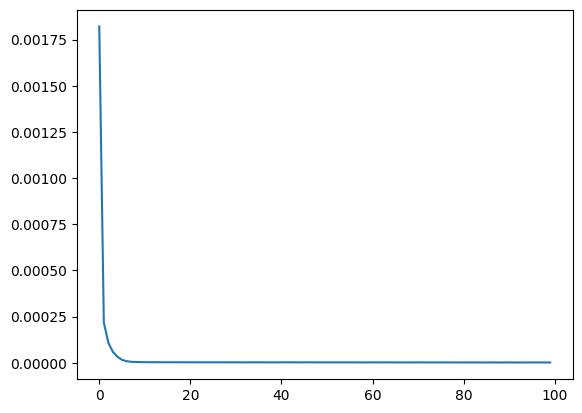

In [30]:
plt.plot(avg_losses) #plot of training losses

##Predicting test data using GRU

In [31]:
model = best_checkpoint

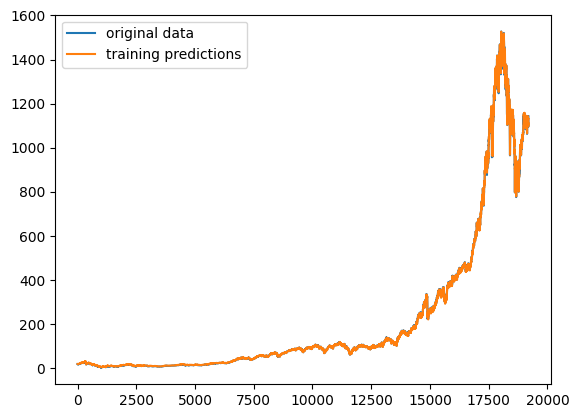

In [32]:
np.random.seed(48)
model.eval()
with torch.no_grad():
  closing_price = model(X_test.to(device))
  closing_price = scaler[0].inverse_transform(closing_price.cpu().numpy())
  training_price = model(X_train.to(device))
  valid_price = model(X_val.to(device))
  training_price = scaler[0].inverse_transform(training_price.cpu().numpy())
  valid_price = scaler[0].inverse_transform(valid_price.cpu().numpy())

training_price = [x[0] for x in training_price]
valid_price = [x[0] for x in valid_price]
plt.plot(list(scaler[0].inverse_transform(Y_train).tolist()+scaler[0].inverse_transform(Y_val).tolist()),label='original data')
plt.plot(list(training_price)+list(valid_price),label='training predictions')
plt.legend()
plt.show()

In [33]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print("RMSE:", math.sqrt(mean_squared_error(Y_test,closing_price)))
print("MAE:", mean_absolute_error(Y_test,closing_price))
print("MAE:", mean_absolute_percentage_error(Y_test,closing_price))

RMSE: 268.1728237011717
MAE: 140.93635367991115
MAE: 0.04089071798335764


##Plotting predicted data using GRU


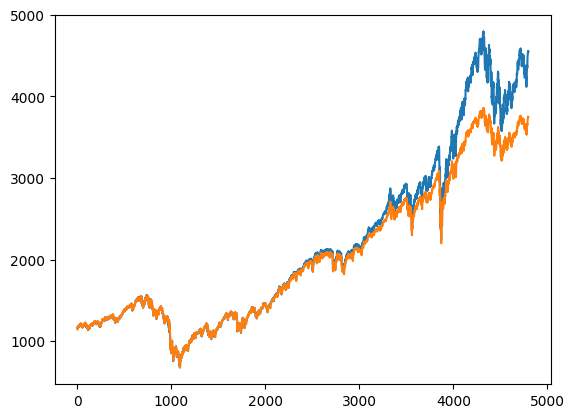

In [34]:
plt.plot(Y_test.tolist(), label='original data')
plt.plot(closing_price, label='Test Predictions')
plt.show()